In [1]:
cd /orange/adamginsburg/brick_alma_linesurvey/2019.1.00092.S/imaging_results/

/orange/adamginsburg/brick_alma_linesurvey/2019.1.00092.S/imaging_results


In [2]:
ls

AlyssaTest
BrickMaser_101_spw27.image/
BrickMaser_101_spw27.image.fits
BrickMaser_101_spw27.image.pbcor/
BrickMaser_101_spw27.image.pbcor.fits
BrickMaser_101_spw27.mask/
BrickMaser_101_spw27.model/
BrickMaser_101_spw27.pb/
BrickMaser_101_spw27.psf/
BrickMaser_101_spw27.residual/
BrickMaser_101_spw27.sumwt/
BrickMaser_101_spw29.image/
BrickMaser_101_spw29.image.fits
BrickMaser_101_spw29.image.pbcor/
BrickMaser_101_spw29.image.pbcor.fits
BrickMaser_101_spw29.mask/
BrickMaser_101_spw29.model/
BrickMaser_101_spw29.pb/
BrickMaser_101_spw29.psf/
BrickMaser_101_spw29.residual/
BrickMaser_101_spw29.sumwt/
BrickMaser_102_spw23.image/
BrickMaser_102_spw23.image.fits
BrickMaser_102_spw23.image.pbcor/
BrickMaser_102_spw23.image.pbcor.fits
BrickMaser_102_spw23.mask/
BrickMaser_102_spw23.model/
BrickMaser_102_spw23.pb/
BrickMaser_102_spw23.psf/
BrickMaser_102_spw23.residual/
BrickMaser_102_spw23.sumwt/
BrickMaser_103_spw25.image/
BrickMaser_103_spw25.image.fits
BrickMaser_103_spw25.image.pbcor/
Bric

In [3]:
import pyspeckit
from spectral_cube import SpectralCube

In [4]:
cube = SpectralCube.read('source_ab_87_spw102_clean_2sigma_n50000_masked_3sigma_pbmask0p18.image')
cube

divide by zero encountered in long_scalars
Cube is a Stokes cube, returning spectral cube for I component


DaskVaryingResolutionSpectralCube with shape=(1920, 512, 512) and unit=Jy / beam and chunk size (80, 256, 512):
 n_x:    512  type_x: RA---SIN  unit_x: deg    range:   266.528130 deg:  266.560501 deg
 n_y:    512  type_y: DEC--SIN  unit_y: deg    range:   -28.719152 deg:  -28.690763 deg
 n_s:   1920  type_s: FREQ      unit_s: Hz     range: 85551577967.789 Hz:87425349542.806 Hz

In [5]:
mnspec = cube.mean(axis=(1,2))

In [82]:
mxspec = cube.max(axis=(1,2))

In [80]:
mnspec.to(u.K)

<VaryingResolutionOneDSpectrum [-2.73401568e-04,-3.15598263e-04,
                                -7.85694038e-04,..., 3.26432666e-04,
                                -7.07549355e-05, 0.00000000e+00] K>

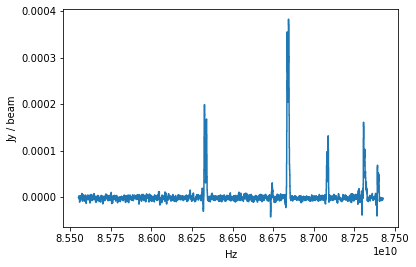

In [6]:
mnspec.quicklook()

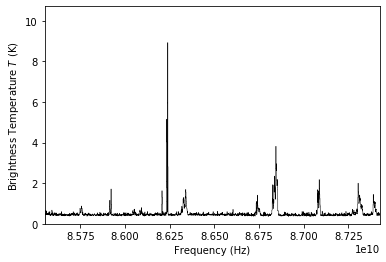

In [83]:
spmx = pyspeckit.Spectrum(data=mxspec.to(u.K), xarr=cube.spectral_axis)
spmx.plotter()

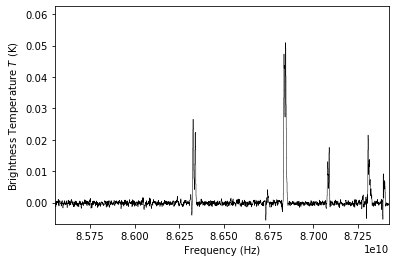

In [81]:
sp = pyspeckit.Spectrum(data=mnspec.to(u.K), xarr=cube.spectral_axis)
sp.plotter()

In [14]:
from scipy.ndimage import label
from astropy import stats

In [15]:
med = np.nanmedian(sp.data)

mad = stats.mad_std(sp.data - med)
detections = (sp.data-med) > 5*mad

labels, ct = label(detections)

In [18]:
import pylab as pl

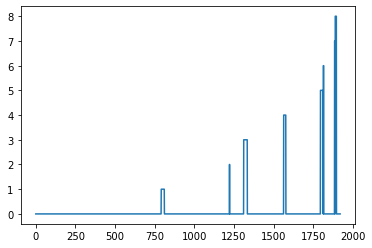

In [19]:
pl.plot(labels)

In [21]:
from astroquery.splatalogue import Splatalogue, utils
from astropy import stats
from astropy import log
from astropy import constants
from astropy import units as u
from astropy import table
from astropy.table import Column
from scipy.ndimage import label
import numpy as np

import pyspeckit
import glob


int_from_bytes is deprecated, use int.from_bytes instead
int_from_bytes is deprecated, use int.from_bytes instead


In [67]:
    results = []
    Ulines = []
    med = np.nanmedian(sp.data)

    mad = stats.mad_std(sp.data - med)
    detections = (sp.data-med) > 5*mad

    labels, ct = label(detections)

    for labelid in range(1,ct+1):
        ssp = sp[labels == labelid]
        try:
            ssp.specfit()
            ssp.specfit.parinfo
            frq = ssp.specfit.parinfo['SHIFT0'].value * ssp.xarr.unit
        except Exception as ex:
            print(ex)
            frq = ssp.xarr.mean()
        sq = Splatalogue.query_lines(frq*(1+30/3e5), frq*(1+75/3e5),
                                     only_astronomically_observed=True)
        if len(sq) > 0:
            tbl = utils.minimize_table(sq)
            tbl.add_column(Column(data=u.Quantity((-(frq.to(u.GHz).value -
                                                     tbl['Freq']) / tbl['Freq']
                                                   * constants.c), u.km/u.s),
                                  name='Velocity'))
            results.append(tbl)
        else:
            log.warning(f"Frequency {frq.to(u.GHz)} had no hits")
            Ulines.append(frq)

ERROR: number of parameters must not exceed data


In [68]:
match_table = table.unique(table.vstack(results))
match_table.sort('Freq')

In [54]:
for labelid in range(3,4):
        print((labels==labelid).sum())
        ssp = sp[labels == labelid]
        try:
            ssp.specfit(fittype='gaussian')
            ssp.specfit.parinfo
            frq = ssp.specfit.parinfo['SHIFT0'].value * ssp.xarr.unit
            sp.plotter()
            ssp.plotter(color='b', axis=sp.plotter.axis, clear=False, ymin=-0.0001)
            ssp.specfit.plot_fit()
        except Exception as ex:
            print(ex)
            frq = ssp.xarr.mean()
        sq = Splatalogue.query_lines(frq*(1+30/3e5), frq*(1+75/3e5),
                                     only_astronomically_observed=True)
sq

23
INFO: Renormalizing data by factor 2.124152e-04 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data


Species,Chemical Name,"Freq-GHz(rest frame,redshifted)","Freq Err(rest frame,redshifted)","Meas Freq-GHz(rest frame,redshifted)","Meas Freq Err(rest frame,redshifted)",Resolved QNs,CDMS/JPL Intensity,S<sub>ij</sub>&#956;<sup>2</sup> (D<sup>2</sup>),S<sub>ij</sub>,Log<sub>10</sub> (A<sub>ij</sub>),Lovas/AST Intensity,E_L (cm^-1),E_L (K),E_U (cm^-1),E_U (K),Linelist
str22,str12,float64,float64,int64,int64,str7,float64,float64,float64,float64,float64,float64,float64,float64,float64,str5
UnidentifiedTransition,UNIDENTIFIED,86.864,0.013,--,--,U-86864,0.0,0.0,0.0,0.0,0.08,0.0,0.0,0.0,0.0,Lovas


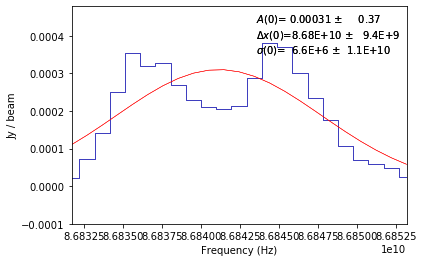

In [56]:
            sp.plotter()
            ssp.plotter(color='b', axis=sp.plotter.axis, clear=False, ymin=-0.0001)
            ssp.specfit()
            ssp.specfit.plot_fit()

In [ ]:
convert_to_unit

In [35]:
ssp.specfit.spectofit

masked_array(data=[5.8431018e-05, 1.2849273e-04, 1.7529108e-04,
                   1.9883980e-04, 1.7777226e-04, 1.2372874e-04,
                   9.0202950e-05, 7.7400335e-05, 5.9769238e-05,
                   5.4835600e-05, 3.0722978e-05, 3.6097590e-05,
                   5.1043378e-05, 9.1708476e-05, 1.2544711e-04,
                   1.6589896e-04, 1.6770023e-04, 1.3359751e-04,
                   9.0053174e-05, 4.4074197e-05],
             mask=False,
       fill_value=1e+20,
            dtype=float32)

In [37]:
ssp.specfit.errspec

array([5.18666037e-05, 5.18666037e-05, 5.18666037e-05, 5.18666037e-05,
       5.18666037e-05, 5.18666037e-05, 5.18666037e-05, 5.18666037e-05,
       5.18666037e-05, 5.18666037e-05, 5.18666037e-05, 5.18666037e-05,
       5.18666037e-05, 5.18666037e-05, 5.18666037e-05, 5.18666037e-05,
       5.18666037e-05, 5.18666037e-05, 5.18666037e-05, 5.18666037e-05])

In [58]:
from astropy.table import Table

In [59]:
tbl = Table.read('/orange/adamginsburg/brick_alma_linesurvey/2019.1.00092.S/line_fit_table.ipac', format='ascii.ipac')

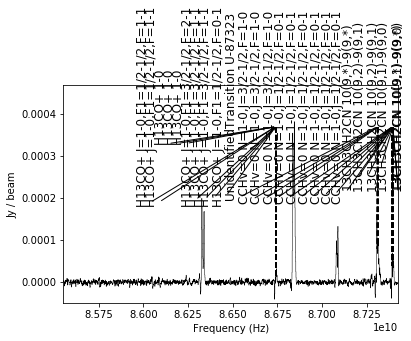

In [69]:
sp.plotter()
sp.plotter.line_ids([f"{row['Species']} {row['QNs']}" for row in match_table], match_table['Freq'], xval_units='GHz', velocity_offset=50*u.km/u.s)

In [77]:
good_table = match_table[[4,9,12,18]]
good_table

Species,ChemicalName,QNs,Freq,log10_Aij,EU_K,Velocity
,,,,,,km / s
str22,str13,str22,float64,float64,float64,float64
H13CO+,Formylium,1-0,86.7542884,-4.41416,4.16353,34.55531260389043
UnidentifiedTransition,UNIDENTIFIED,U-87323,87.323,0.0,0.0,50.40543175477376
CCHv=0,Ethynyl,"N=1-0,J=3/2-1/2,F=1-0",87.328624,0.0,0.0,69.70894561349772
CCHv=0,Ethynyl,"N=1-0,J=1/2-1/2,F=0-1",87.407165,0.0,0.0,31.777885779078723


In [72]:
match_table.show_in_notebook(display_length=100)

idx,Species,ChemicalName,QNs,Freq,log10_Aij,EU_K,Velocity
,,,,,,,km / s
0,H13CO+,Formylium,"J=1-0,F1=1/2-1/2,F=1-1",86.7542619,-5.14556,4.16352,34.46374840584151
1,H13CO+,Formylium,"J=1-0,F1=1/2-1/2,F=1-1",86.7542619,-5.60546,4.16352,34.46374840584151
2,H13CO+,Formylium,1-0,86.754288,0.0,0.0,34.55393050323603
3,H13CO+,Formylium,1-0,86.754288,-4.41417,4.16353,34.55393050323603
4,H13CO+,Formylium,1-0,86.7542884,-4.41416,4.16353,34.55531260389043
5,H13CO+,Formylium,"J=1-0,F1=3/2-1/2,F=2-1",86.7543004,-5.01621,4.16353,34.596775618627
6,H13CO+,Formylium,"J=1-0,F1=3/2-1/2,F=1-1",86.7543014,-5.14556,4.16353,34.60023086932501
7,H13CO+,Formylium,"J=1-0,F1=3/2-1/2,F=1-1",86.7543014,-5.60546,4.16353,34.60023086932501
8,H13CO+,Formylium,"J=1-0,F1=1/2-1/2,F=0-1",86.7543029,-5.01624,4.16353,34.60541374522267


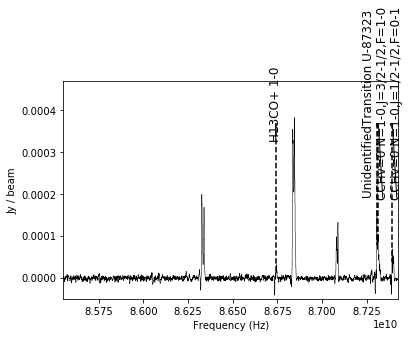

In [79]:
sp.plotter()#xmin=87.2e9, xmax=87.5e9)
sp.plotter.line_ids([f"{row['Species']} {row['QNs']}" for row in good_table], good_table['Freq'], xval_units='GHz', velocity_offset=50*u.km/u.s)

In [94]:
for labelid in range(3,4):
        print((labels==labelid).sum())
        ssp = sp[labels == labelid]
        try:
            ssp.specfit(fittype='gaussian')
            ssp.specfit.parinfo
            frq = ssp.specfit.parinfo['SHIFT0'].value * ssp.xarr.unit
            sp.plotter()
            ssp.plotter(color='b', axis=sp.plotter.axis, clear=False, ymin=-0.0001)
            ssp.specfit.plot_fit()
        except Exception as ex:
            print(ex)
            frq = ssp.xarr.mean()
        sq = Splatalogue.query_lines(frq*(1+30/3e5), frq*(1+75/3e5),
                                     only_astronomically_observed=True)
sq

23
INFO: Renormalizing data by factor 2.831669e-02 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data


Species,Chemical Name,"Freq-GHz(rest frame,redshifted)","Freq Err(rest frame,redshifted)","Meas Freq-GHz(rest frame,redshifted)","Meas Freq Err(rest frame,redshifted)",Resolved QNs,CDMS/JPL Intensity,S<sub>ij</sub>&#956;<sup>2</sup> (D<sup>2</sup>),S<sub>ij</sub>,Log<sub>10</sub> (A<sub>ij</sub>),Lovas/AST Intensity,E_L (cm^-1),E_L (K),E_U (cm^-1),E_U (K),Linelist
str22,str12,float64,float64,int64,int64,str7,float64,float64,float64,float64,float64,float64,float64,float64,float64,str5
UnidentifiedTransition,UNIDENTIFIED,86.864,0.013,--,--,U-86864,0.0,0.0,0.0,0.0,0.08,0.0,0.0,0.0,0.0,Lovas


In [98]:
frq

<Quantity 8.68424201e+10 Hz>

In [97]:
sq = Splatalogue.query_lines(frq*(1+30/3e5), frq*(1+75/3e5), ).show_in_notebook(display_length=125)
sq

idx,Species,Chemical Name,"Freq-GHz(rest frame,redshifted)","Freq Err(rest frame,redshifted)","Meas Freq-GHz(rest frame,redshifted)","Meas Freq Err(rest frame,redshifted)",Resolved QNs,CDMS/JPL Intensity,S<sub>ij</sub>&#956;<sup>2</sup> (D<sup>2</sup>),S<sub>ij</sub>,Log<sub>10</sub> (A<sub>ij</sub>),Lovas/AST Intensity,E_L (cm^-1),E_L (K),E_U (cm^-1),E_U (K),Linelist
0,c-C6H5OH,Phenol,86.8512933,1.54e-05,--,--,"89(17,72)-90(16,75),v=1-0",-8.2437,3.29332,0.0,-7.55193,--,636.1136,915.22679,639.01063,919.39497,CDMS
1,c-C6H5OH,Phenol,86.8512934,1.54e-05,--,--,"89(18,72)-90(15,75),v=1-0",-8.4655,1.97621,0.0,-7.55188,--,636.1136,915.22679,639.01063,919.39497,CDMS
2,H18ONO2,Nitric acid,86.8513053,4.02e-05,--,--,"34(24,10)-34(23,11)",-6.3546,2.23728,0.0,-6.60687,--,447.1647,643.36656,450.06175,647.53474,JPL
3,cis-S2O2,"Disulfur dioxide, <i>cis</i>-isomer",86.851768,2.07e-05,--,--,"83(22,62)-82(23,59)",-5.7124,106.52209,0.0,-5.31301,--,884.1284,1272.07183,887.02546,1276.24008,CDMS
4,CH3O13CHO(TopModel),Methyl Formate,86.851846,7e-06,--,--,0,0.0,1.437,0.0,-6.28248,--,151.7828,218.38048,154.67987,222.54869,TopModel
5,"CH3O13CHO,vt=0,1","Methyl formate, v<sub>t</sub> = 0, 1",86.851846,7e-06,--,--,"10(2,9)-10(1,10),v=5-5",-6.8626,2.87366,0.0,-6.28254,--,151.7828,218.38301,154.67987,222.55127,CDMS
6,N2H+v2=1,Diazenylium,86.8520172,0.0071117,--,--,"J=18,l=1e-1f",-5.8979,11.25531,0.974,-6.58881,--,1216.1025,1749.69016,1218.99957,1753.85838,CDMS
7,CH313CH2CN,Ethyl Cyanide,86.8521599,4.6e-06,--,--,"57(9,49)-56(10,46)",-5.8756,14.1946,0.0,-6.0263,--,549.9201,791.21751,552.81718,795.38578,CDMS
8,"CH3SD,vt&le;2",Methyl mercaptan,86.8523207,1.8e-05,--,--,"29(1,29)+-28(2,26)+E,vt=1",-7.3606,0.28315,0.0,-7.43655,--,517.1886,744.12387,520.08568,748.29215,CDMS
9,S4,Tetrasulfur,86.8523409,0.0041967,--,--,"60(58,2)-61(57,5)",-8.7398,0.07309,0.055,-7.57607,--,537.34101,773.10941,540.23809,777.27764,JPL


In [100]:
tbl = Table.read('/orange/adamginsburg/brick_alma_linesurvey/2019.1.00092.S/line_fit_table.ipac', format='ascii.ipac')
tbl

Species,ChemicalName,QNs,Freq,log10_Aij,EU_K,Velocity
,,,,,,km / s
str22,str22,str37,float64,float64,float64,float64
SiOv=0,Silicon Monoxide,3-2,130.26861,-3.97534,12.5039,69.59310233400528
SiOv=0,Silicon Monoxide,3-2,130.26861,-3.97384,12.5039,32.2359575591121
SiOv=0,Silicon Monoxide,3-2,130.26861,-3.97534,12.5039,50.87261005134527
SiOv=0,Silicon Monoxide,3-2,130.26861,-3.97384,12.5039,69.59310233400528
SiOv=0,Silicon Monoxide,3-2,130.26861,-3.97534,12.5039,32.2359575591121
SiOv=0,Silicon Monoxide,3-2,130.26861,-3.97384,12.5039,50.87261005134527
SiOv=0,Silicon Monoxide,3-2,130.268706,0.0,0.0,32.4568623504754
SiOv=0,Silicon Monoxide,3-2,130.268706,0.0,0.0,69.81397959545745


In [101]:
pwd

'/orange/adamginsburg/brick_alma_linesurvey/2019.1.00092.S/imaging_results'

In [161]:
%run ../../brick_linesurvey/spectral_ids.py

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.160493e-02 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
Species      ChemicalName                  QNs                 Freq    log10_Aij    EU_K      TotalIntensity      PeakIntensity            RMS               Velocity    
                                                                                                  km / s                                                      km / s     
------- ---------------------- --------------------------- ----------- --------- --------- ------------------- ------------------- -------------------- -----------------
C4Hv7=1 1,3-Butadiynyl radical J=25/2-23/2,&Omega;=3/2,l=f    115.2168       0.0       0.0 0.08044897217845991 0.03160493049540676 0.003089445582272436  42.9992567075429
C4Hv7=1 1,3-Butadiynyl radical J=25/2-23/2,&Omega;=3/2,l=e 115.2170442

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,7 [pyspeckit.spectrum.interactive]
Species   ChemicalName  QNs     Freq    log10_Aij   EU_K    TotalIntensity     PeakIntensity            RMS               Velocity    
                                                                km / s                                                     km / s     
------- --------------- --- ----------- --------- ------- ----------------- ------------------- -------------------- -----------------
  COv=0 Carbon Monoxide 1-0 115.2712018  -7.14246 5.53211 3.935943966253637 0.32496666093032894 0.003089445582272436  64.9390283908433
  COv=0 Carbon Monoxide 1-0  115.271202       0.0     0.0 3.935943966253637 0.32496666093032894 0.003089445582272436 64.93954842970345
  COv=0 Carbon Monoxide 1-0  115.271202  -7.14236 5.53211 3.935943966253637 0.32496666093032894 0.003089445582272436 64.93954842970345
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,13 [pyspeckit.spectrum.interac

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.510383e-02 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,5 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,5 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.700520e-02 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,7 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 4.224888e-02 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 1.730233e-02 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,6 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 1.011023e-02 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
Species   ChemicalName        QNs          Freq    log10_Aij   EU_K     TotalIntensity       PeakIntensity              RMS               Velocity     
                                                                            km / s                                                         km / s      
------- --------------- --------------- ---------- --------- ------- -------------------- -------------------- --------------------- ------------------
   C17O Carbon Monoxide J=1-0,F=3/2-5/2 112.358777  -7.17409 5.39234 0.026336299468427922 0.010110231440686308 0.0016397166631787951 37.087283575202946
   C17O Carbon Monoxide J=1-0,F=3/2-5/2  112.35878       0.0     0.0 0.026336299468427922 0.010110231440686308 0.0016397166631787951  37.09528

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 9.889307e-03 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,13 [pyspeckit.spectrum.interactive]
 Species      ChemicalName         QNs         Freq    log10_Aij   EU_K      TotalIntensity      PeakIntensity             RMS               Velocity    
                                                                                 km / s                                                       km / s     
---------- ------------------ ------------- ---------- --------- -------- ------------------- ------------------- --------------------- -----------------
c-HCCCHv=0 Cyclopropenylidene 4(0,4)-3(1,3) 150.820665  -3.78613 19.30732 0.09703485774062977 0.01501847432873795 0.0005250136501121392 40.28492784252553
c-HCCCHv=0 Cyclopropenylidene 4(0,4)-3(1,3) 150.820665  -3.74489 19.30732 0.09703485774062977 0.01501847432873795 0.0005250136501121392 40.28492784252553
c-HCCCHv=0 Cyclopropenylidene 4(0,4)-3(1,3) 150.820666       0.0      0.0 0.09703485774062977 0.01501847432873795 0.000525013650112139

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.449685e-02 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
       Species         ChemicalName   QNs      Freq  log10_Aij EU_K    TotalIntensity       PeakIntensity             RMS               Velocity     
                                                                           km / s                                                        km / s      
---------------------- ------------ -------- ------- --------- ---- -------------------- -------------------- -------------------- ------------------
UnidentifiedTransition UNIDENTIFIED U-260568 260.568       0.0  0.0 0.013774439298458799 0.024496849612219592 0.003894989767065404 50.928826772089536
UnidentifiedTransition UNIDENTIFIED U-260578 260.578       0.0  0.0 0.013774439298458799 0.024496849612219592 0.003894989767065404   62.4317751857298


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,3 [pyspeckit.spectrum.interactive]
   Species      ChemicalName     QNs       Freq    log10_Aij   EU_K      TotalIntensity      PeakIntensity            RMS              Velocity     
                                                                             km / s                                                     km / s      
------------- --------------- --------- ---------- --------- -------- ------------------- ------------------- ------------------- ------------------
SO3&Sigma;v=0 Sulfur Monoxide 4(3)-3(2)   138.1786  -4.49957 15.85716 0.05135762471785765 0.01860149869307808 0.00263733161733122 45.728539603188565
SO3&Sigma;v=0 Sulfur Monoxide 4(3)-3(2)   138.1786    -4.491 15.85716 0.05135762471785765 0.01860149869307808 0.00263733161733122 45.728539603188565
SO3&Sigma;v=0 Sulfur Monoxide 4(3)-3(2) 138.178682       0.0      0.0 0.05135762471785765 0.01860149869307808 0.00263733161733122  45.90641966012709
None
INFO: 

Species    ChemicalName               QNs                Freq    log10_Aij    EU_K     TotalIntensity     PeakIntensity            RMS              Velocity    
                                                                                           km / s                                                    km / s     
------- ----------------- --------------------------- ---------- --------- --------- ------------------ ------------------ ------------------- -----------------
    C6H 1,3,5-Hexatriynyl J=99/2-97/2,&Omega;=1/2,l=e  138.20804       0.0       0.0 1.0959865658011683 0.0806719242420327 0.00263733161733122 71.21835065248928
    C6H 1,3,5-Hexatriynyl J=99/2-97/2,&Omega;=1/2,l=e 138.208042  -3.33093 189.63723 1.0959865658011683 0.0806719242420327 0.00263733161733122 71.22268789993963
None


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,4 [pyspeckit.spectrum.interactive]
Species   ChemicalName   QNs    Freq    log10_Aij   EU_K    TotalIntensity      PeakIntensity              RMS               Velocity    
                                                                km / s                                                        km / s     
------- ---------------- --- ---------- --------- ------- ------------------ -------------------- --------------------- -----------------
 SiOv=0 Silicon Monoxide 3-2  130.26861  -3.97534 12.5039 0.0777123222053264 0.021234034180898576 0.0026472185131707396 45.75985503621161
 SiOv=0 Silicon Monoxide 3-2  130.26861  -3.97534 12.5039 0.0777123222053264 0.021234034180898576 0.0026472185131707396 45.75985503621161
 SiOv=0 Silicon Monoxide 3-2  130.26861  -3.97384 12.5039 0.0777123222053264 0.021234034180898576 0.0026472185131707396 45.75985503621161
 SiOv=0 Silicon Monoxide 3-2 130.268706       0.0     0.0 0.0777123222053264 

Species  ChemicalName          QNs             Freq    log10_Aij   EU_K      TotalIntensity      PeakIntensity              RMS               Velocity    
                                                                                 km / s                                                        km / s     
------- -------------- ------------------- ----------- --------- -------- ------------------- -------------------- --------------------- -----------------
HNCOv=0 Isocyanic Acid 6(0,6)-5(0,5),F=5-5  131.884891  -6.47285 22.15345 0.01621665453125218 0.014524181228655019 0.0026472185131707396   65.398196260074
HNCOv=0 Isocyanic Acid 6(0,6)-5(0,5),F=7-6 131.8857267  -4.98905 22.15349 0.01621665453125218 0.014524181228655019 0.0026472185131707396 67.29743062106236
HNCOv=0 Isocyanic Acid       6(0,6)-5(0,5) 131.8857341   -4.5119 22.15349 0.01621665453125218 0.014524181228655019 0.0026472185131707396 67.31424795318681
HNCOv=0 Isocyanic Acid 6(0,6)-5(0,5),F=6-5 131.8857342   -5.0013 22.15

Species      ChemicalName             QNs             Freq    log10_Aij   EU_K      TotalIntensity      PeakIntensity              RMS               Velocity     
                                                                                        km / s                                                        km / s      
------- --------------------- ------------------- ----------- --------- -------- ------------------- -------------------- --------------------- ------------------
HNCOv=0        Isocyanic Acid 6(0,6)-5(0,5),F=5-5  131.884891  -6.47285 22.15345 0.09875729867556375 0.035287756335514266 0.0026472185131707396  35.81229170452876
HNCOv=0        Isocyanic Acid 6(0,6)-5(0,5),F=7-6 131.8857267  -4.98905 22.15349 0.09875729867556375 0.035287756335514266 0.0026472185131707396  37.71171353796812
HNCOv=0        Isocyanic Acid       6(0,6)-5(0,5) 131.8857341   -4.5119 22.15349 0.09875729867556375 0.035287756335514266 0.0026472185131707396 37.728532530122806
HNCOv=0        Isocyan

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,5 [pyspeckit.spectrum.interactive]
  Species   ChemicalName      QNs          Freq    log10_Aij EU_K    TotalIntensity      PeakIntensity              RMS               Velocity     
                                                                         km / s                                                        km / s      
----------- ------------ -------------- ---------- --------- ---- ------------------- -------------------- --------------------- ------------------
CH3OHvt=0-2     Methanol 2(0,2)-1(-1,1) 254.015367       0.0  0.0 0.01836060617567502 0.006821606203306139 0.0006631349565036515 47.644963750441036
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,19 [pyspeckit.spectrum.interactive]
  Species   ChemicalName      QNs          Freq    log10_Aij EU_K   TotalIntensity      PeakIntensity              RMS               Velocity    
                                                                  

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,5 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,3 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,15 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,6 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.826999e-03 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
Species ChemicalName        QNs            Freq   log10_Aij   EU_K     TotalIntensity        PeakIntensity              RMS               Velocity    
                                                                           km / s                                                          km / s     
------- ------------ ------------------ --------- --------- ------- -------------------- --------------------- --------------------- -----------------
N2H+v=0  Diazenylium J=1-0,F1=1-1,F=0-1 93.171621       0.0     0.0 0.008958473718447386 0.0028269985621759744 0.0005187845231926323 59.58853871464095
N2H+v=0  Diazenylium J=1-0,F1=1-1,F=0-1 93.171621  -5.83831 4.47151 0.008958473718447386 0.0028269985621759744 0.0005187845231926323 59.5885387146

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,48 [pyspeckit.spectrum.interactive]
       Species          ChemicalName        QNs           Freq    log10_Aij EU_K   TotalIntensity      PeakIntensity             RMS               Velocity    
                                                                                       km / s                                                       km / s     
---------------------- ------------- ----------------- ---------- --------- ---- ------------------ ------------------- --------------------- -----------------
UnidentifiedTransition  UNIDENTIFIED          U-241719    241.719       0.0  0.0 0.6128431441127056 0.04187383846766349 0.0009462398763113816 35.09708750464843
UnidentifiedTransition  UNIDENTIFIED          U-241732    241.732       0.0  0.0 0.6128431441127056 0.04187383846766349 0.0009462398763113816 51.21760813023381
            CH2CHCNv=0 Vinyl Cyanide 25(2,23)-24(2,22) 241.737567       0.0  0.0 0.6128431441127056 0.04

  Species    ChemicalName          QNs            Freq    log10_Aij   EU_K      TotalIntensity        PeakIntensity              RMS               Velocity     
                                                                                    km / s                                                          km / s      
----------- -------------- ------------------- ---------- --------- -------- -------------------- --------------------- --------------------- ------------------
    CH3OCH3 Dimethyl ether 13(1,13)-12(0,12)EE 241.946537       0.0      0.0 0.003878871583389377 0.0064291874787963535 0.0009462398763113816  47.36351250582785
    CH3OCH3 Dimethyl ether 13(1,13)-12(0,12)EE 241.946537  -2.77608  81.1314 0.003878871583389377 0.0064291874787963535 0.0009462398763113816  47.36351250582785
    CH3OCH3 Dimethyl ether 13(1,13)-12(0,12)AA  241.94683  -3.20205 81.13141 0.003878871583389377 0.0064291874787963535 0.0009462398763113816   47.7265067747943
CH3CH2CNv=0  Ethyl Cyanide   27(12

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,5 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,9 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,6 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,3 [pyspeckit.spectrum.interactive]
       Species          ChemicalName            QNs              Freq   log10_Aij    EU_K      TotalIntensity      PeakIntensity              RMS               Velocity    
                                                                                                   km / s                                                        km / s     
---------------------- -------------- ------------------------ -------- --------- --------- ------------------- -------------------- --------------------- -----------------
            CH3OCHOv=1 Methyl Formate       8(3,6)-7(3,5)Avt=1 97.59718       0.0       0.0 0.10734821496134936 0.014683736554788704 0.0015853144584940034 47.93896950294506
            g-CH3CH2OH gauche-Ethanol 25(1,25)-25(0,25),vt=1-0 97.60039  -5.18312 320.26573 0.10734821496134936 0.0146

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,25 [pyspeckit.spectrum.interactive]
Species   ChemicalName               QNs                  Freq   log10_Aij   EU_K     TotalIntensity     PeakIntensity             RMS               Velocity    
                                                                                          km / s                                                      km / s     
-------- ------------- ------------------------------- --------- --------- -------- ----------------- ------------------- --------------------- -----------------
l-C3Hv=0 Propynylidyne J=9/2-7/2,&Omega;=1/2,F=5-4,l=e 97.995166  -4.32988 12.54227 2.215395248364357 0.04558583690361695 0.0015853144584940034 61.82405454856034
l-C3Hv=0 Propynylidyne J=9/2-7/2,&Omega;=1/2,F=5-4,l=e 97.995166  -4.21368 12.54227 2.215395248364357 0.04558583690361695 0.0015853144584940034 61.82405454856034
l-C3Hv=0 Propynylidyne            2P1/2J=9/2-7/2F=5-4e 97.995212       0.0      0.0 2.21539524

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,3 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,21 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,4 [pyspeckit.spectrum.interactive]
Species ChemicalName          QNs              Freq    log10_Aij   EU_K    TotalIntensity      PeakIntensity              RMS               Velocity     
                                                                               km / s                                                        km / s      
------- ------------ ---------------------- ---------- --------- ------- ------------------ -------------------- --------------------- ------------------
 H13CO+    Formylium J=1-0,F1=1/2-1/2,F=1-1 86.7542619  -5.14556 4.16352 0.0536892931411184 0.004818643346776931 0.0006484675985783301  37.78182049548892
 H13CO+    Formylium J=1-0,F1=1/2-1/2,F=1-1 86.7542619  -5.60546 4.16352 0.0536892931411184 0.004818643346776931 0.0006484675985783301  37.78182049548892
 H13CO+    Formylium                    1-0  86.754288  -4.41417 4.16353 0.0536892931411184 0.004818643346776931 0.0006484675985783301 

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,16 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 4.057002e-03 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data


       Species          ChemicalName          QNs             Freq   log10_Aij   EU_K     TotalIntensity      PeakIntensity              RMS               Velocity    
                                                                                              km / s                                                        km / s     
---------------------- ------------- --------------------- --------- --------- ------- ------------------- -------------------- --------------------- -----------------
            CH2CHCNv=0 Vinyl Cyanide         9(1,8)-8(1,7) 87.312815       0.0     0.0 0.01372939489284223 0.004057002134265001 0.0006484675985783301 36.04006545990511
                CCHv=0       Ethynyl N=1-0,J=3/2-1/2,F=2-1 87.316898  -5.81605 4.19268 0.01372939489284223 0.004057002134265001 0.0006484675985783301 50.05688789014094
                CCHv=0       Ethynyl N=1-0,J=3/2-1/2,F=2-1 87.316925  -5.65605 4.19269 0.01372939489284223 0.004057002134265001 0.0006484675985783301 50.1495737

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,46 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,5 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 4.984544e-03 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
  Species     ChemicalName            QNs              Freq    log10_Aij    EU_K      TotalIntensity       PeakIntensity             RMS               Velocity     
                                                                                          km / s                                                        km / s      
----------- ---------------- --------------------- ----------- --------- --------- -------------------- ------------------- --------------------- ------------------
  CH3CCHv=0 Methyl Acetylene             6(1)-5(1)  102.546023       0.0       0.0 0.014235210860849532 0.00498454389050738 0.0007413559871376146 36.082586822232244
  CH3CCHv=0 Methyl Acetylene             6(1)-5(1) 102.5460241  -5.49918  24.42607 0.01423

  Species   ChemicalName          QNs              Freq    log10_Aij    EU_K      TotalIntensity     PeakIntensity             RMS               Velocity     
                                                                                      km / s                                                      km / s      
----------- ------------ --------------------- ----------- --------- --------- ------------------- ------------------ --------------------- ------------------
(CH3)2COv=0      Acetone     10(0,10)-9(1,9)EE  102.554696       0.0       0.0 0.08680333142635177 0.0060228612362735 0.0007413559871376146  48.72153206709647
(CH3)2COv=0      Acetone     10(0,10)-9(1,9)EE 102.5546961  -4.31708  28.11837 0.08680333142635177 0.0060228612362735 0.0007413559871376146  48.72182434402777
(CH3)2COv=0      Acetone     10(1,10)-9(0,9)EE 102.5546964  -4.31708  28.11837 0.08680333142635177 0.0060228612362735 0.0007413559871376146   48.7227011748598
(CH3)2COv=0      Acetone 23(12,12)-23(11,13)AE

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,10 [pyspeckit.spectrum.interactive]
   Species     ChemicalName          QNs             Freq    log10_Aij   EU_K      TotalIntensity      PeakIntensity             RMS               Velocity     
                                                                                       km / s                                                       km / s      
------------- -------------- ------------------- ----------- --------- -------- ------------------- -------------------- -------------------- ------------------
      HNCOv=0 Isocyanic Acid 7(0,7)-6(0,6),F=6-6 153.8642528  -6.41154 29.53772 0.36702536221938814 0.060638070422725024 0.003093792843054447  43.30477882625078
      HNCOv=0 Isocyanic Acid 7(0,7)-6(0,6),F=8-7 153.8650803  -4.78344 29.53776 0.36702536221938814 0.060638070422725024 0.003093792843054447  44.91685626320117
      HNCOv=0 Isocyanic Acid       7(0,7)-6(0,6) 153.8650858  -4.30628 29.53776 0.36702536221938814

Species  ChemicalName      QNs        Freq    log10_Aij   EU_K     TotalIntensity      PeakIntensity            RMS               Velocity    
                                                                       km / s                                                      km / s     
------- -------------- ----------- ---------- --------- -------- ------------------ ------------------- -------------------- -----------------
   HCCN Cyanomethylene N=7-6,J=6-5 153.894083  -3.75006 29.42736 2.1770536637757156 0.13368082096866735 0.003093792843054447 69.27522420140949
   HCCN Cyanomethylene N=7-6,J=6-5 153.894121       0.0      0.0 2.1770536637757156 0.13368082096866735 0.003093792843054447 69.34923275272249
None


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
Species  ChemicalName       QNs          Freq    log10_Aij   EU_K     TotalIntensity      PeakIntensity              RMS               Velocity    
                                                                          km / s                                                        km / s     
------- -------------- ------------- ----------- --------- ------- ------------------- -------------------- --------------------- -----------------
 SO2v=0 Sulfur dioxide 3(1,3)-2(0,2)   104.02941       0.0     0.0 0.02289603892699053 0.004089022815246187 0.0004941436141868507 34.68025273378974
 SO2v=0 Sulfur dioxide 3(1,3)-2(0,2) 104.0294183  -4.99746 7.74352 0.02289603892699053 0.004089022815246187 0.0004941436141868507 34.70416894515904
 SO2v=0 Sulfur dioxide 3(1,3)-2(0,2) 104.0294183  -4.99747 7.74352 0.02289603892699053 0.004089022815246187 0.000494

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,10 [pyspeckit.spectrum.interactive]
Species   ChemicalName        QNs         Freq    log10_Aij   EU_K      TotalIntensity      PeakIntensity              RMS               Velocity     
                                                                            km / s                                                        km / s      
------- ---------------- ------------- ---------- --------- -------- ------------------- -------------------- --------------------- ------------------
   H2CS Thioformaldehyde 3(1,2)-2(1,1)  104.61704  -4.86098   23.231 0.15777406396239063 0.010834347529121385 0.0004941436141868507  32.43728979733577
   H2CS Thioformaldehyde 3(1,2)-2(1,1) 104.617114  -4.33929 23.21259 0.15777406396239063 0.010834347529121385 0.0004941436141868507  32.64932242453984
   H2CS Thioformaldehyde 3(1,2)-2(1,1) 104.617109       0.0      0.0 0.15777406396239063 0.010834347529121385 0.0004941436141868507 32.63499590511878

       Species          ChemicalName        QNs           Freq    log10_Aij   EU_K      TotalIntensity       PeakIntensity              RMS               Velocity     
                                                                                            km / s                                                         km / s      
---------------------- ------------- ----------------- ---------- --------- -------- -------------------- -------------------- --------------------- ------------------
            CH313CH2CN Ethyl Cyanide 12(0,12)-11(0,11) 104.812917       0.0      0.0 0.008434171009295622 0.003007294798829161 0.0004941436141868507 31.399315076333632
            CH313CH2CN Ethyl Cyanide 12(0,12)-11(0,11) 104.812917  -4.02198 32.97396 0.008434171009295622 0.003007294798829161 0.0004941436141868507 31.399315076333632
UnidentifiedTransition  UNIDENTIFIED          U-104819    104.819       0.0      0.0 0.008434171009295622 0.003007294798829161 0.0004941436141868507  48.7954600

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 1.202873e-02 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
       Species            ChemicalName               QNs                Freq   log10_Aij   EU_K      TotalIntensity       PeakIntensity             RMS               Velocity     
                                                                                                         km / s                                                        km / s      
---------------------- ----------------- --------------------------- --------- --------- -------- -------------------- -------------------- -------------------- ------------------
            t-CH3CH2OH     trans-Ethanol               4(1,4)-3(0,3) 90.117593       0.0      0.0 0.038907552418092545 0.012028725180103969 0.001692798527317091  36.46193544551473
            t-CH3CH2OH     tra

Species     ChemicalName     QNs     Freq   log10_Aij   EU_K    TotalIntensity      PeakIntensity            RMS               Velocity     
                                                                    km / s                                                      km / s      
------- ------------------- ----- --------- --------- ------- ------------------ ------------------- -------------------- ------------------
 HNCv=0 Hydrogen Isocyanide J=1-0 90.663562  -4.57028 4.35114 0.7983681854911934 0.08598356587342781 0.001692798527317091 48.228378746472465
 HNCv=0 Hydrogen Isocyanide J=1-0 90.663564       0.0     0.0 0.7983681854911934 0.08598356587342781 0.001692798527317091 48.234990977795405
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,3 [pyspeckit.spectrum.interactive]
Species     ChemicalName     QNs     Freq   log10_Aij   EU_K   TotalIntensity     PeakIntensity             RMS               Velocity     
                                                       

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,18 [pyspeckit.spectrum.interactive]
Species   ChemicalName      QNs        Freq   log10_Aij    EU_K     TotalIntensity     PeakIntensity            RMS               Velocity     
                                                                        km / s                                                     km / s      
-------- -------------- ----------- --------- --------- --------- ----------------- ------------------- -------------------- ------------------
HC3Nv5=1 Cyanoacetylene J=10-9,l=1e  90.98697  -4.24402 978.22601 4.330122548475783 0.13081861043765156 0.001692798527317091 49.052699910076974
HC3Nv5=1 Cyanoacetylene J=10-9,l=1e 90.987096       0.0       0.0 4.330122548475783 0.13081861043765156 0.001692798527317091  49.46778810089217
None


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,16 [pyspeckit.spectrum.interactive]
Species   ChemicalName        QNs         Freq    log10_Aij    EU_K      TotalIntensity      PeakIntensity              RMS               Velocity     
                                                                             km / s                                                        km / s      
------- ---------------- ------------- ---------- --------- --------- ------------------- -------------------- --------------------- ------------------
   H2CS Thioformaldehyde 4(3,2)-3(3,1)  137.36917  -4.01895 134.89341 0.18494385402813363 0.019630154559548887 0.0005625070710136745   33.6399948699422
   H2CS Thioformaldehyde 4(3,2)-3(3,1) 137.369362       0.0       0.0 0.18494385402813363 0.019630154559548887 0.0005625070710136745  34.05896524454808
   H2CS Thioformaldehyde 4(3,1)-3(3,0)  137.36917  -4.01894 134.89341 0.18494385402813363 0.019630154559548887 0.0005625070710136745   33.639994

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,8 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,63 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,6 [pyspeckit.spectrum.interactive]
Species    ChemicalName          QNs           Freq    log10_Aij   EU_K      TotalIntensity       PeakIntensity              RMS               Velocity     
                                                                                 km / s                                                         km / s      
------- ------------------ --------------- ----------- --------- -------- -------------------- -------------------- --------------------- ------------------
13CSv=0 Carbon Monosulfide J=3-2,F=5/2-5/2 138.7391833  -5.46787 13.31687 0.020998638766259427 0.003461844365692914 0.0005625070710136745  36.17777824536542
13CSv=0 Carbon Monosulfide J=3-2,F=5/2-3/2 138.7392509  -4.32177 13.31687 0.020998638766259427 0.003461844365692914 0.0005625070710136745  36.32383298048755
13CSv=0 Carbon Monosulfide             3-2  138.739264       0.0      0.0 0.020998638766259427 0.003461844365692914 0.00

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,10 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,7 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,3 [pyspeckit.spectrum.interactive]
       Species         ChemicalName       QNs          Freq    log10_Aij EU_K   TotalIntensity      PeakIntensity             RMS               Velocity    
                                                                                    km / s                                                       km / s     
---------------------- ------------ --------------- ---------- --------- ---- ------------------ -------------------- -------------------- -----------------
           CH3OHvt=0-2     Methanol 3(1,2)-2(1,1)-- 146.368342       0.0  0.0 0.0551828085898324 0.019090827535918776 0.003267535279700623 43.06437484152868
UnidentifiedTransition UNIDENTIFIED   

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 1.788439e-02 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
Species    ChemicalName    QNs     Freq    log10_Aij   EU_K      TotalIntensity       PeakIntensity             RMS               Velocity    
                                                                     km / s                                                        km / s     
------- ------------------ --- ----------- --------- -------- -------------------- -------------------- -------------------- -----------------
  CSv=0 Carbon Monosulfide 3-2  146.969029  -4.21673  14.1062 0.017868726211001558 0.017884391366129862 0.003267535279700623 73.03420996107485
  CSv=0 Carbon Monosulfide 3-2 146.9690287  -4.21812 14.10692 0.017868726211001558 0.017884391366129862 0.003267535279700623 73.03359815985992
  CSv=0 Carbon Monosulfide 3-2  146

Species    ChemicalName    QNs     Freq    log10_Aij   EU_K      TotalIntensity     PeakIntensity            RMS               Velocity    
                                                                     km / s                                                     km / s     
------- ------------------ --- ----------- --------- -------- ------------------- ------------------ -------------------- -----------------
  CSv=0 Carbon Monosulfide 3-2  146.969029  -4.21673  14.1062 0.42465292026765616 0.0566290641010672 0.003267535279700623 46.94639290285446
  CSv=0 Carbon Monosulfide 3-2 146.9690287  -4.21812 14.10692 0.42465292026765616 0.0566290641010672 0.003267535279700623 46.94578104838786
  CSv=0 Carbon Monosulfide 3-2  146.969029       0.0      0.0 0.42465292026765616 0.0566290641010672 0.003267535279700623 46.94639290285446
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
       Spec

       Species          ChemicalName         QNs           Freq    log10_Aij   EU_K     TotalIntensity      PeakIntensity            RMS               Velocity     
                                                                                            km / s                                                      km / s      
---------------------- -------------- ----------------- ---------- --------- ------- ------------------- ------------------- -------------------- ------------------
UnidentifiedTransition   UNIDENTIFIED        U-146984.5   146.9845       0.0     0.0 0.07037259756728854 0.02375191191110311 0.003267535279700623 48.190275337790936
            CH3OCHOv=0 Methyl Formate 12(3,10)-11(3,9)A 146.988082  -4.35362 52.0086 0.07037259756728854 0.02375191191110311 0.003267535279700623  55.49484011868295
            CH3OCHOv=0 Methyl Formate 12(3,10)-11(3,9)A 146.988082       0.0     0.0 0.07037259756728854 0.02375191191110311 0.003267535279700623  55.49484011868295
None
INFO:

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 9.618555e-03 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
Species  ChemicalName       QNs          Freq    log10_Aij   EU_K     TotalIntensity       PeakIntensity              RMS               Velocity    
                                                                          km / s                                                         km / s     
------- -------------- ------------- ----------- --------- ------- -------------------- -------------------- --------------------- -----------------
 SO2v=0 Sulfur dioxide 3(1,3)-2(0,2)   104.02941       0.0     0.0 0.026975918812461395 0.009618555308985602 0.0015280980791503895 36.08719096469752
 SO2v=0 Sulfur dioxide 3(1,3)-2(0,2) 104.0294183  -4.99746 7.74352 0.026975918812461395 0.009618555308985602 0.0015280980791503895 36.11110706381408
 SO2v

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,5 [pyspeckit.spectrum.interactive]
Species    ChemicalName    QNs     Freq    log10_Aij   EU_K     TotalIntensity       PeakIntensity              RMS               Velocity     
                                                                    km / s                                                         km / s      
------- ------------------ --- ----------- --------- -------- ------------------ --------------------- --------------------- ------------------
C34Sv=0 Carbon Monosulfide 3-2  144.617101  -4.23775 11.80342 0.0160446549202973 0.0036583928688906577 0.0005215152099449807 30.215046901407973
C34Sv=0 Carbon Monosulfide 3-2 144.6171007  -4.24076 11.80342 0.0160446549202973 0.0036583928688906577 0.0005215152099449807 30.214425061617852
C34Sv=0 Carbon Monosulfide 3-2  144.617101       0.0      0.0 0.0160446549202973 0.0036583928688906577 0.0005215152099449807 30.215046901407973
None
INFO: Left region selection unchange

Species  ChemicalName        QNs           Freq    log10_Aij   EU_K      TotalIntensity       PeakIntensity              RMS               Velocity     
                                                                             km / s                                                         km / s      
------- -------------- --------------- ----------- --------- -------- -------------------- -------------------- --------------------- ------------------
HC3Nv=0 Cyanoacetylene         J=16-15  145.560951       0.0      0.0 0.008836812486075315 0.004594486021597261 0.0005215152099449807   41.3981918205937
HC3Nv=0 Cyanoacetylene J=16-15,F=15-14 145.5609539   -4.0944 59.38085 0.008836812486075315 0.004594486021597261 0.0005215152099449807 41.404163738540525
HC3Nv=0 Cyanoacetylene J=16-15,F=16-15 145.5609584  -4.09435 59.38085 0.008836812486075315 0.004594486021597261 0.0005215152099449807  41.41343050733763
HC3Nv=0 Cyanoacetylene         J=16-15 145.5609596  -3.61555 59.38085 0.0088368124

Species  ChemicalName        QNs           Freq    log10_Aij   EU_K      TotalIntensity       PeakIntensity              RMS               Velocity     
                                                                             km / s                                                         km / s      
------- -------------- --------------- ----------- --------- -------- -------------------- -------------------- --------------------- ------------------
HC3Nv=0 Cyanoacetylene         J=16-15  145.560951       0.0      0.0 0.040055575264336285 0.005900614645443412 0.0005215152099449807  30.09480066851701
HC3Nv=0 Cyanoacetylene J=16-15,F=15-14 145.5609539   -4.0944 59.38085 0.040055575264336285 0.005900614645443412 0.0005215152099449807 30.100772811660455
HC3Nv=0 Cyanoacetylene J=16-15,F=16-15 145.5609584  -4.09435 59.38085 0.040055575264336285 0.005900614645443412 0.0005215152099449807 30.110039929900566
HC3Nv=0 Cyanoacetylene         J=16-15 145.5609596  -3.61555 59.38085 0.0400555752

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,51 [pyspeckit.spectrum.interactive]
Species   ChemicalName    QNs     Freq    log10_Aij   EU_K     TotalIntensity      PeakIntensity              RMS               Velocity     
                                                                   km / s                                                        km / s      
------- ---------------- ----- ---------- --------- -------- ------------------ -------------------- --------------------- ------------------
 OCSv=0 Carbonyl Sulfide 11-10 133.785897       0.0      0.0 0.8799984837065011 0.039918730068252715 0.0004944874534496649  37.71615853047247
 OCSv=0 Carbonyl Sulfide 11-10   133.7859   -5.1663 38.52536 0.8799984837065011 0.039918730068252715 0.0004944874534496649 37.722880197129825
 OCSv=0 Carbonyl Sulfide 11-10   133.7859  -5.16628 38.52493 0.8799984837065011 0.039918730068252715 0.0004944874534496649 37.722880197129825
None
INFO: Left region selection unchanged.  xminpix

       Species           ChemicalName        QNs          Freq    log10_Aij   EU_K     TotalIntensity      PeakIntensity              RMS               Velocity     
                                                                                           km / s                                                        km / s      
---------------------- ---------------- ------------- ----------- --------- -------- ------------------ -------------------- --------------------- ------------------
                  H2CS Thioformaldehyde 4(1,4)-3(1,3)  135.297811  -4.48704 29.42289 0.9563403105440327 0.047282043740323014 0.0004944874534496649  37.07494747517383
                  H2CS Thioformaldehyde 4(1,4)-3(1,3)  135.298407  -3.98395 29.40421 0.9563403105440327 0.047282043740323014 0.0004944874534496649 38.395393238439794
                  H2CS Thioformaldehyde 4(1,4)-3(1,3)  135.298364       0.0      0.0 0.9563403105440327 0.047282043740323014 0.0004944874534496649  38.30012656770883
    

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
       Species            ChemicalName               QNs                Freq   log10_Aij   EU_K      TotalIntensity      PeakIntensity              RMS               Velocity     
                                                                                                         km / s                                                        km / s      
---------------------- ----------------- --------------------------- --------- --------- -------- ------------------- -------------------- --------------------- ------------------
            t-CH3CH2OH     trans-Ethanol               4(1,4)-3(0,3) 90.117593       0.0      0.0 0.02618822454649259 0.004711178643594428 0.0004318410014617062  34.83780160885376
            t-CH3CH2OH     trans-Ethanol               4(1,4)-3(0,3)  90.11761  -5.29607  9.34984 0.02618822454649259 0.0047111786435944

Species   ChemicalName       QNs          Freq    log10_Aij    EU_K     TotalIntensity      PeakIntensity              RMS               Velocity     
                                                                            km / s                                                        km / s      
-------- -------------- -------------- ---------- --------- --------- ------------------ -------------------- --------------------- ------------------
 HC3Nv=0 Cyanoacetylene   J=10-9,F=9-8 90.9789838  -4.71759  24.01482 0.8113685533289784 0.049245741797505314 0.0004318410014617062  32.14536537707498
 HC3Nv=0 Cyanoacetylene         J=10-9  90.978989       0.0       0.0 0.8113685533289784 0.049245741797505314 0.0004318410014617062  32.16249849367706
 HC3Nv=0 Cyanoacetylene  J=10-9,F=10-9 90.9789948  -4.71715  24.01468 0.8113685533289784 0.049245741797505314 0.0004318410014617062 32.181608506012864
 HC3Nv=0 Cyanoacetylene J=10-9,F=11-10 90.9790024  -4.71276  24.01482 0.8113685533289784 0.049

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 1.003514e-02 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
Species         ChemicalName          QNs     Freq    log10_Aij EU_K    TotalIntensity       PeakIntensity              RMS               Velocity    
                                                                            km / s                                                         km / s     
------- ---------------------------- ----- ---------- --------- ---- -------------------- -------------------- --------------------- -----------------
   CCCS 3-Thioxo-1,2-Propadieylidene 24-23 138.725846       0.0  0.0 0.010521164903958791 0.010035143919558504 0.0005305828880072777 73.60437799253333
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,17 [pyspeckit.spectrum.interactive]
Species   ChemicalName         QNs           

Species  ChemicalName        QNs           Freq    log10_Aij   EU_K     TotalIntensity      PeakIntensity             RMS               Velocity     
                                                                            km / s                                                       km / s      
------- -------------- --------------- ----------- --------- -------- ------------------ ------------------- --------------------- ------------------
CH3OCH3 Dimethyl ether 9(3,6)-9(2,7)AE  139.500402  -4.65762 53.66655 0.2995786348122526 0.02336751367074803 0.0005305828880072777  47.80127004867896
CH3OCH3 Dimethyl ether 9(3,6)-9(2,7)AE  139.500411       0.0      0.0 0.2995786348122526 0.02336751367074803 0.0005305828880072777 47.820608356666284
CH3OCH3 Dimethyl ether 9(3,6)-9(2,7)AE    139.5005  -4.07904 53.66641 0.2995786348122526 0.02336751367074803 0.0005305828880072777  48.01184260113235
CH3OCH3 Dimethyl ether 9(3,6)-9(2,7)EA 139.5005411  -4.65773 53.66656 0.2995786348122526 0.023367513

  Species   ChemicalName       QNs          Freq    log10_Aij EU_K    TotalIntensity      PeakIntensity             RMS               Velocity     
                                                                          km / s                                                       km / s      
----------- ------------ --------------- ---------- --------- ---- ------------------- ------------------- --------------------- ------------------
CH3OHvt=0-2     Methanol   5(1,4)-4(1,3) 241.879038       0.0  0.0 0.03965576202454951 0.02512670568167926 0.0033232506744441735  41.15397359073024
CH3OHvt=0-2     Methanol 5(2,3)-4(2,2)++ 241.887678       0.0  0.0 0.03965576202454951 0.02512670568167926 0.0033232506744441735 51.860807804847774
CH3OHvt=0-2     Methanol   5(2,3)-4(2,2) 241.904643       0.0  0.0 0.03965576202454951 0.02512670568167926 0.0033232506744441735  72.88189763719669
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renorm

  Species    ChemicalName         QNs            Freq    log10_Aij    EU_K      TotalIntensity      PeakIntensity             RMS               Velocity    
                                                                                    km / s                                                       km / s     
----------- -------------- ----------------- ----------- --------- --------- ------------------- ------------------- --------------------- -----------------
CH3OHvt=0-2       Methanol   5(1,4)-4(1,3)--  243.915811       0.0       0.0 0.09092574087576769 0.03173151479304602 0.0033232506744441735 40.77316273725568
   34SO2v=0 Sulfur Dioxide 18(1,17)-18(0,18) 243.9359586  -4.15326 162.81949 0.09092574087576769 0.03173151479304602 0.0033232506744441735 65.53079617550864
   34SO2v=0 Sulfur Dioxide 18(1,17)-18(0,18)  243.935965       0.0       0.0 0.09092574087576769 0.03173151479304602 0.0033232506744441735 65.53865992917646
   34SO2v=0 Sulfur Dioxide 18(1,17)-18(0,18)  243.936052  

Species    ChemicalName    QNs     Freq    log10_Aij   EU_K      TotalIntensity      PeakIntensity             RMS               Velocity     
                                                                     km / s                                                       km / s      
------- ------------------ --- ----------- --------- -------- ------------------- ------------------- --------------------- ------------------
  CSv=0 Carbon Monosulfide 5-4  244.935556       0.0      0.0 0.21536698452244296 0.05436127511166153 0.0033232506744441735  42.07128179054288
  CSv=0 Carbon Monosulfide 5-4  244.935557   -3.5257  35.2659 0.21536698452244296 0.05436127511166153 0.0033232506744441735 42.072505583403476
  CSv=0 Carbon Monosulfide 5-4 244.9355565  -3.52707 35.26605 0.21536698452244296 0.05436127511166153 0.0033232506744441735  42.07189368697442
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,7 [pyspeckit.spectrum.interactive]
Species    ChemicalName    QNs     Freq   

ERROR: number of parameters must not exceed data
 Species    ChemicalName            QNs                Freq    log10_Aij    EU_K      TotalIntensity       PeakIntensity              RMS               Velocity     
                                                                                          km / s                                                         km / s      
---------- -------------- ------------------------ ----------- --------- --------- -------------------- -------------------- --------------------- ------------------
g-CH3CH2OH gauche-Ethanol 33(6,27)-32(7,26),vt=1-1 260.2487548   -6.7542 573.76032 0.012664377862191276 0.021580463871521145 0.0033232506744441735  33.09102383923207
g-CH3CH2OH gauche-Ethanol 15(5,11)-14(5,10),vt=0-0  260.249723       0.0       0.0 0.012664377862191276 0.021580463871521145 0.0033232506744441735    34.206210498316
g-CH3CH2OH gauche-Ethanol 15(5,11)-14(5,10),vt=0-0 260.2497611  -3.85085 187.15186 0.012664377862191276 0.021580463871521

       Species         ChemicalName   QNs      Freq  log10_Aij EU_K    TotalIntensity      PeakIntensity             RMS               Velocity    
                                                                           km / s                                                       km / s     
---------------------- ------------ -------- ------- --------- ---- ------------------- ------------------- --------------------- -----------------
UnidentifiedTransition UNIDENTIFIED U-260568 260.568       0.0  0.0 0.03968930103789404 0.02494811888108553 0.0033232506744441735 50.97832116384096
UnidentifiedTransition UNIDENTIFIED U-260578 260.578       0.0  0.0 0.03968930103789404 0.02494811888108553 0.0033232506744441735  62.4812676780733
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,3 [pyspeckit.spectrum.interactive]
 Species       ChemicalName              QNs                Freq    log10_Aij    EU_K      TotalIntensity      PeakIntensity              RMS               Velo

Species   ChemicalName       QNs        Freq    log10_Aij   EU_K      TotalIntensity       PeakIntensity             RMS               Velocity     
                                                                          km / s                                                        km / s      
------- ---------------- ----------- ---------- --------- -------- -------------------- ------------------- --------------------- ------------------
 HCNv=0 Hydrogen Cyanide       J=3-2  265.88618  -3.55182 25.52118 0.012780952398265122 0.02177911023152842 0.0033232506744441735 56.961698276565016
 HCNv=0 Hydrogen Cyanide J=3-2,F=2-1 265.886166  -3.55512 25.52089 0.012780952398265122 0.02177911023152842 0.0033232506744441735  56.94591597010734
 HCNv=0 Hydrogen Cyanide J=3-2,F=3-2 265.886424  -3.55512  25.5209 0.012780952398265122 0.02177911023152842 0.0033232506744441735  57.23676106458969
 HCNv=0 Hydrogen Cyanide       J=3-2 265.886431  -3.55512  25.5209 0.012780952398265122 0.0217791102315284

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,3 [pyspeckit.spectrum.interactive]
  Species   ChemicalName      QNs         Freq    log10_Aij EU_K    TotalIntensity       PeakIntensity              RMS               Velocity    
                                                                        km / s                                                         km / s     
----------- ------------ ------------- ---------- --------- ---- -------------------- -------------------- --------------------- -----------------
CH3OHvt=0-2     Methanol 5(2,3)-4(1,3) 266.838123       0.0  0.0 0.040853748991474224 0.023908693711712732 0.0033232506744441735 42.48882585669055
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
  Species   ChemicalName      QNs         Freq    log10_Aij EU_K    TotalIntensity       PeakIntensity              RMS               Velocity     
                    

       Species          ChemicalName        QNs           Freq    log10_Aij    EU_K      TotalIntensity      PeakIntensity              RMS               Velocity     
                                                                                             km / s                                                        km / s      
---------------------- ------------- ----------------- ---------- --------- --------- ------------------- -------------------- --------------------- ------------------
            13CH3CH2CN Ethyl Cyanide 32(1,32)-31(1,31) 267.600919       0.0       0.0 0.04913291626928118 0.030318067742632435 0.0033232506744441735  44.14489664796661
            13CH3CH2CN Ethyl Cyanide 32(1,32)-31(1,31) 267.600895  -2.78934 214.22288 0.04913291626928118 0.030318067742632435 0.0033232506744441735  44.11801348110219
            CH313CH2CN Ethyl Cyanide 30(8,23)-29(8,22) 267.608931  -2.82087 268.27061 0.04913291626928118 0.030318067742632435 0.0033232506744441735 53.11912436

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,3 [pyspeckit.spectrum.interactive]
Species         ChemicalName            QNs          Freq    log10_Aij   EU_K      TotalIntensity      PeakIntensity              RMS               Velocity    
                                                                                       km / s                                                        km / s     
-------- ------------------------- ------------- ----------- --------- -------- ------------------- -------------------- --------------------- -----------------
   HOCO+ Protonated Carbon Dioxide 5(0,5)-4(0,4)  106.913524  -4.58732 15.39375 0.09464481839771907 0.013622295438737856 0.0011325585208440926 40.90018998373722
   HOCO+ Protonated Carbon Dioxide 5(0,5)-4(0,4)  106.913524       0.0      0.0 0.09464481839771907 0.013622295438737856 0.0011325585208440926 40.90018998373722
   HOCO+ Protonated Carbon Dioxide 5(0,5)-4(0,4) 106.9135631  -4.58734 15.39317 0.09464481839771907 

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 1.016856e-02 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
Species         ChemicalName          QNs     Freq    log10_Aij EU_K    TotalIntensity       PeakIntensity              RMS               Velocity    
                                                                            km / s                                                         km / s     
------- ---------------------------- ----- ---------- --------- ---- -------------------- -------------------- --------------------- -----------------
   CCCS 3-Thioxo-1,2-Propadieylidene 24-23 138.725846       0.0  0.0 0.010661041433783918 0.010168558909303165 0.0005316927463521256 73.60437799253333
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,10 [pyspeckit.spectrum.interactive]
Species   ChemicalName        QNs         Fre

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.132085e-02 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
       Species          ChemicalName        QNs           Freq    log10_Aij EU_K    TotalIntensity       PeakIntensity             RMS               Velocity     
                                                                                        km / s                                                        km / s      
---------------------- ------------- ----------------- ---------- --------- ---- -------------------- ------------------- --------------------- ------------------
UnidentifiedTransition  UNIDENTIFIED          U-241732    241.732       0.0  0.0 0.012512025623875071 0.02132085127858487 0.0033232506744441735  36.88178536402475
            CH2CHCNv=0 Vinyl Cyanide 25(2,23)-24(2,22) 241.737567       0.0  0.0 0.012512025623875

  Species   ChemicalName       QNs          Freq    log10_Aij EU_K    TotalIntensity      PeakIntensity             RMS               Velocity     
                                                                          km / s                                                       km / s      
----------- ------------ --------------- ---------- --------- ---- ------------------- ------------------- --------------------- ------------------
CH3OHvt=0-2     Methanol   5(1,4)-4(1,3) 241.879038       0.0  0.0 0.03965576202454951 0.02512670568167926 0.0033232506744441735  41.15397359073024
CH3OHvt=0-2     Methanol 5(2,3)-4(2,2)++ 241.887678       0.0  0.0 0.03965576202454951 0.02512670568167926 0.0033232506744441735 51.860807804847774
CH3OHvt=0-2     Methanol   5(2,3)-4(2,2) 241.904643       0.0  0.0 0.03965576202454951 0.02512670568167926 0.0033232506744441735  72.88189763719669
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renorm

Species   ChemicalName        QNs         Freq   log10_Aij   EU_K      TotalIntensity       PeakIntensity             RMS               Velocity     
                                                                           km / s                                                        km / s      
------- ---------------- ------------- --------- --------- -------- -------------------- ------------------- --------------------- ------------------
   H2CS Thioformaldehyde 7(1,6)-6(1,5) 244.04784  -3.67817 60.04465 0.012058798993763236 0.02054854007442064 0.0033232506744441735 40.080760017674095
   H2CS Thioformaldehyde 7(1,6)-6(1,5) 244.04859       0.0      0.0 0.012058798993763236 0.02054854007442064 0.0033232506744441735  41.00194658517147
   H2CS Thioformaldehyde 7(1,6)-6(1,5) 244.04784  -3.19161 60.02627 0.012058798993763236 0.02054854007442064 0.0033232506744441735 40.080760017674095
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]


Species    ChemicalName    QNs     Freq    log10_Aij   EU_K      TotalIntensity      PeakIntensity             RMS               Velocity     
                                                                     km / s                                                       km / s      
------- ------------------ --- ----------- --------- -------- ------------------- ------------------- --------------------- ------------------
  CSv=0 Carbon Monosulfide 5-4  244.935556       0.0      0.0 0.21536698452244296 0.05436127511166153 0.0033232506744441735  42.07128179054288
  CSv=0 Carbon Monosulfide 5-4  244.935557   -3.5257  35.2659 0.21536698452244296 0.05436127511166153 0.0033232506744441735 42.072505583403476
  CSv=0 Carbon Monosulfide 5-4 244.9355565  -3.52707 35.26605 0.21536698452244296 0.05436127511166153 0.0033232506744441735  42.07189368697442
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,7 [pyspeckit.spectrum.interactive]
Species    ChemicalName    QNs     Freq   

INFO: Renormalizing data by factor 2.175667e-02 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
       Species         ChemicalName   QNs      Freq  log10_Aij EU_K    TotalIntensity      PeakIntensity              RMS               Velocity    
                                                                           km / s                                                        km / s     
---------------------- ------------ -------- ------- --------- ---- ------------------- -------------------- --------------------- -----------------
UnidentifiedTransition UNIDENTIFIED U-260568 260.568       0.0  0.0 0.01276778409566497 0.021756671065419814 0.0033232506744441735 53.17592600446636
UnidentifiedTransition UNIDENTIFIED U-260578 260.578       0.0  0.0 0.01276778409566497 0.021756671065419814 0.0033232506744441735 64.67878818292053
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,3 [pyspeckit.spectrum.interactive]


 Species    ChemicalName           QNs              Freq    log10_Aij    EU_K      TotalIntensity      PeakIntensity              RMS               Velocity     
                                                                                       km / s                                                        km / s      
---------- -------------- --------------------- ----------- --------- --------- ------------------- -------------------- --------------------- ------------------
    CCHv=0        Ethynyl N=3-2,J=5/2-3/2,F=3-2 262.0648433  -4.15212  25.15909 0.04024387006839074 0.023953173739826857 0.0033232506744441735 40.712384418769865
    CCHv=0        Ethynyl N=3-2,J=5/2-3/2,F=3-2  262.064986  -4.31202   25.1591 0.04024387006839074 0.023953173739826857 0.0033232506744441735  40.87560566683913
    CCHv=0        Ethynyl N=3-2,J=5/2-3/2,F=3-2   262.06499       0.0       0.0 0.04024387006839074 0.023953173739826857 0.0033232506744441735  40.88018089202883
    CCHv=0        Ethynyl N=

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,3 [pyspeckit.spectrum.interactive]
  Species   ChemicalName      QNs         Freq    log10_Aij EU_K    TotalIntensity       PeakIntensity              RMS               Velocity    
                                                                        km / s                                                         km / s     
----------- ------------ ------------- ---------- --------- ---- -------------------- -------------------- --------------------- -----------------
CH3OHvt=0-2     Methanol 5(2,3)-4(1,3) 266.838123       0.0  0.0 0.040853748991474224 0.023908693711712732 0.0033232506744441735 42.48882585669055
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
  Species   ChemicalName      QNs         Freq    log10_Aij EU_K    TotalIntensity       PeakIntensity              RMS               Velocity     
                    

Species ChemicalName QNs     Freq    log10_Aij   EU_K      TotalIntensity      PeakIntensity             RMS               Velocity    
                                                               km / s                                                       km / s     
------- ------------ --- ----------- --------- -------- ------------------- ------------------- --------------------- -----------------
HCO+v=0    Formylium 3-2 267.5576259  -2.83764 25.68168 0.26117913791958197 0.05671136457434975 0.0033232506744441735 47.96671687705473
HCO+v=0    Formylium 3-2  267.557619  -2.83765 25.68168 0.26117913791958197 0.05671136457434975 0.0033232506744441735 47.95898681501208
HCO+v=0    Formylium 3-2  267.557633       0.0      0.0 0.26117913791958197 0.05671136457434975 0.0033232506744441735 47.97467099843669
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,3 [pyspeckit.spectrum.interactive]
       Species          ChemicalName        QNs           Freq    log10_Aij    EU_K 

Species     ChemicalName     QNs     Freq    log10_Aij   EU_K      TotalIntensity      PeakIntensity             RMS               Velocity    
                                                                       km / s                                                       km / s     
------- ------------------- ----- ---------- --------- -------- ------------------- ------------------- --------------------- -----------------
 HNCv=0 Hydrogen Isocyanide J=3-2 271.981111  -3.02982 26.10691 0.08721763324928598 0.03663642057065173 0.0033232506744441735 44.80613259559326
 HNCv=0 Hydrogen Isocyanide J=3-2 271.981111       0.0      0.0 0.08721763324928598 0.03663642057065173 0.0033232506744441735 44.80613259559326
 HNCv=0 Hydrogen Isocyanide J=3-2 271.981142  -3.02983 26.10633 0.08721763324928598 0.03663642057065173 0.0033232506744441735 44.84029738044982
None


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,13 [pyspeckit.spectrum.interactive]
  Species   ChemicalName       QNs         Freq   log10_Aij EU_K   TotalIntensity      PeakIntensity              RMS               Velocity    
                                                                       km / s                                                        km / s     
----------- ------------ --------------- -------- --------- ---- ------------------ -------------------- --------------------- -----------------
CH3OHvt=0-2     Methanol 2(1,2)-1(1,1)++ 95.91431       0.0  0.0 0.7870174469770812 0.035097252074969616 0.0012987425932594623 32.41399802362599
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 8.132477e-03 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
   Species    ChemicalName      QNs          Freq   log10_Aij EU_K   

   Species       ChemicalName          QNs           Freq    log10_Aij   EU_K    TotalIntensity      PeakIntensity              RMS               Velocity     
                                                                                     km / s                                                        km / s      
------------- ------------------ ---------------- ---------- --------- ------- ------------------ -------------------- --------------------- ------------------
      C34Sv=0 Carbon Monosulfide              2-1 96.4129495  -4.79698 6.24804 0.2708698956046171 0.017804782009130257 0.0012987425932594623  33.02576739365619
      C34Sv=0 Carbon Monosulfide              2-1   96.41295       0.0     0.0 0.2708698956046171 0.017804782009130257 0.0012987425932594623 33.027321953658124
      C34Sv=0 Carbon Monosulfide              2-1   96.41295  -4.79596 6.24804 0.2708698956046171 0.017804782009130257 0.0012987425932594623 33.027321953658124
CH3CHOv=0,1&2       Acetaldehyde 5(-2,4)

       Species         ChemicalName   QNs    Freq  log10_Aij EU_K    TotalIntensity       PeakIntensity             RMS               Velocity    
                                                                         km / s                                                        km / s     
---------------------- ------------ ------- ------ --------- ---- -------------------- ------------------- --------------------- -----------------
UnidentifiedTransition UNIDENTIFIED U-96775 96.775       0.0  0.0 0.030858167793826406 0.01015947021734937 0.0012987425932594623 70.55546861286992
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]


INFO: Renormalizing data by factor 7.107992e-03 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
Species   ChemicalName   QNs    Freq    log10_Aij   EU_K      TotalIntensity      PeakIntensity              RMS               Velocity    
                                                                  km / s                                                        km / s     
------- ---------------- --- ---------- --------- -------- ------------------- -------------------- --------------------- -----------------
  O13CS Carbonyl Sulfide 8-7 96.9881211  -5.59226 20.94628 0.02158967121281828 0.007107992384851645 0.0012987425932594623 50.07237103977481
  O13CS Carbonyl Sulfide 8-7 96.9881211  -5.59253 20.94628 0.02158967121281828 0.007107992384851645 0.0012987425932594623 50.07237103977481
  O13CS Carbonyl Sulfide 8-7  96.988123       0.0      0.0 0.02158967121281828 0.007107992384851645 0.0012987425932594623   50.078243001365
None


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,9 [pyspeckit.spectrum.interactive]
  Species      ChemicalName          QNs           Freq    log10_Aij   EU_K      TotalIntensity      PeakIntensity             RMS               Velocity     
                                                                                     km / s                                                       km / s      
----------- ------------------ --------------- ----------- --------- -------- ------------------- ------------------- --------------------- ------------------
 c-HCCCHv=0 Cyclopropenylidene   3(1,2)-2(2,1) 145.0895946  -4.12831 16.04942 0.22440176841431184 0.03518215642005809 0.0026096713182657168  52.31118723295544
 c-HCCCHv=0 Cyclopropenylidene   3(1,2)-2(2,1) 145.0896055  -4.16955 16.04942 0.22440176841431184 0.03518215642005809 0.0026096713182657168 52.333705507720715
 c-HCCCHv=0 Cyclopropenylidene   3(1,2)-2(2,1)   145.08962       0.0      0.0 0.22440176841431184 0.0351821564

Species ChemicalName      QNs         Freq    log10_Aij EU_K    TotalIntensity      PeakIntensity             RMS               Velocity    
                                                                    km / s                                                       km / s     
------- ------------ ------------- ---------- --------- ---- ------------------- ------------------- --------------------- -----------------
   H2CO Formaldehyde 2(0,2)-1(0,1) 145.602956       0.0  0.0 0.21833376221757878 0.03526667555516718 0.0026096713182657168 46.01545929896648
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 1.535113e-02 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
Species ChemicalName      QNs         Freq    log10_Aij EU_K    TotalIntensity       PeakIntensity              RMS               Velocity    
                                      

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,8 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,4 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
Species ChemicalName      QNs         Freq    log10_Aij   EU_K      TotalIntensity       PeakIntensity              RMS                Velocity     
                                                                        km / s                                                          km / s      
------- ------------ ------------- ---------- --------- -------- -------------------- -------------------- ---------------------- ------------------
  H2CCO       Ketene 5(1,4)-4(1,3) 101.981426       0.0      0.0 0.017907038531992225 0.003181912574690988 0.00045675858016593307 34.184589796784906
  H2CCO       Ketene 5(1,4)-4(1,3) 101.981429  -4.96414 27.73519 0.017907038531992225 0.003181912574690988 0.00045675858016593307  34.19340782209635
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,6 [pyspeckit.spectrum.interactive]
Species    

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.274342e-03 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
  Species      ChemicalName         QNs           Freq    log10_Aij   EU_K      TotalIntensity       PeakIntensity              RMS                Velocity    
                                                                                    km / s                                                          km / s     
------------ ---------------- --------------- ----------- --------- -------- ------------------- --------------------- ---------------------- -----------------
   CH3CCHv=0 Methyl Acetylene       6(3)-5(3)  102.530346       0.0      0.0 0.00935110728276178 0.0032743418369864667 0.00045675858016593307 35.91150181787415
   CH3CCHv=0 Methyl Acetylene       6(3)-5(3) 102.5303487  -5.61209 82.03088 0.00935110728276178 0.00327434183

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,12 [pyspeckit.spectrum.interactive]
Species ChemicalName      QNs         Freq    log10_Aij EU_K   TotalIntensity      PeakIntensity              RMS               Velocity     
                                                                   km / s                                                        km / s      
------- ------------ ------------- ---------- --------- ---- ------------------ -------------------- --------------------- ------------------
   H2CO Formaldehyde 2(1,1)-1(1,0) 150.498342       0.0  0.0 0.3173761969941418 0.047250583840780146 0.0031164891238798843 45.439772958825046
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,17 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,7 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,7 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
 Species      ChemicalName         QNs         Freq    log10_Aij   EU_K      TotalIntensity      PeakIntensity              RMS               Velocity     
                                                                                 km / s                                                        km / s      
---------- ------------------ ------------- ---------- --------- -------- ------------------- -------------------- --------------------- ------------------
c-HCCCHv=0 Cyclopropenylidene 4(0,4)-3(1,3) 150.820665  -3.78613 19.30732 0.03500806032756411 0.018921037573778245 0.0031164891238798843 41.476405869555556
c-HCCCHv=0 Cyclopropenylidene 4(0,4)-3(1,3) 150.820665  -3.74489 19.30732 0.03500806032756411 0.018921037573778245 0.0031164891238798843 41.476405869555556
c-HCCCHv=0 Cyclopropenylidene 4(0,4)-3(1,3) 150.820666       0.0      0.0 0.

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,5 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,6 [pyspeckit.spectrum.interactive]
 Species    ChemicalName            QNs              Freq   log10_Aij    EU_K     TotalIntensity     PeakIntensity             RMS               Velocity    
                                                                                      km / s                                                      km / s     
---------- -------------- ------------------------ -------- --------- --------- ------------------ ------------------ --------------------- -----------------
CH3OCHOv=1 Methyl Formate       8(3,6)-7(3,5)Avt=1 97.59718       0.0       0.0 0.2053975950987378 0.0168410914400899 0.0010995793940070484 60.18268955988833
g-CH3CH2OH gauche-Ethanol 25(1,25)-25(0,25),vt=1-0 97.60039  -5.18312 320.26573 0.2053975950987378 0.0168410914400899 0.0010995793940070484 70.04064815769196
g-CH3CH2OH gauche-Ethanol 25(1,25)-25(0,25),vt=1-0 97.60039       0.0       0.0 0.2053975950987378 0.01684109144008

       Species          ChemicalName            QNs               Freq   log10_Aij    EU_K     TotalIntensity      PeakIntensity             RMS               Velocity     
                                                                                                   km / s                                                       km / s      
---------------------- -------------- ------------------------ --------- --------- --------- ------------------ ------------------- --------------------- ------------------
UnidentifiedTransition   UNIDENTIFIED                U-97957.2   97.9572       0.0       0.0 0.5932520792274008 0.03484494464295751 0.0010995793940070484  33.64697870535094
            g-CH3CH2OH gauche-Ethanol 17(1,17)-17(0,17),vt=1-0 97.962834  -5.17833 184.59443 0.5932520792274008 0.03484494464295751 0.0010995793940070484  50.88658961017785
            g-CH3CH2OH gauche-Ethanol 17(1,17)-17(0,17),vt=1-0 97.962858       0.0       0.0 0.5932520792274008 0.03484494464295751 0.0

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.505023e-03 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
Species   ChemicalName              QNs                 Freq    log10_Aij  EU_K     TotalIntensity       PeakIntensity              RMS               Velocity     
                                                                                        km / s                                                         km / s      
------- --------------- ---------------------------- ---------- --------- ------ ------------------- --------------------- --------------------- ------------------
   13CN Cyanide Radical N=1-0,J=3/2-1/2,F1=2-1,F=3-2 108.780201  -4.97885 5.2475 0.00676621962809084 0.0025050231019046205 0.0003853179462671573 35.745520567199065
   13CN Cyanide Radical N=1-0,J=3/2-1/2,F1=2-1,F=3-2 108.780201       0.0    0.0 0.00676621962

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.097038e-03 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
Species    ChemicalName   QNs    Freq   log10_Aij   EU_K     TotalIntensity        PeakIntensity              RMS               Velocity     
                                                                 km / s                                                          km / s      
-------- ---------------- --- --------- --------- ------- -------------------- --------------------- --------------------- ------------------
HC15Nv=0 Hydrogen Cyanide 1-0 86.054961  -4.62943 4.12996 0.010480756577758984 0.0030970375705959207 0.0006402272833804682 32.430672170877266
HC15Nv=0 Hydrogen Cyanide 1-0 86.054967   -4.6569 4.12996 0.010480756577758984 0.0030970375705959207 0.0006402272833804682 32.451572302809055
HC15Nv=0 Hydrogen Cyanide 1-0 86.054967 

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,5 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
Species ChemicalName          QNs              Freq    log10_Aij   EU_K    TotalIntensity     PeakIntensity             RMS               Velocity     
                                                                               km / s                                                      km / s      
------- ------------ ---------------------- ---------- --------- ------- ----------------- ------------------- --------------------- ------------------
 H13CO+    Formylium J=1-0,F1=1/2-1/2,F=1-1 86.7542619  -5.14556 4.16352 0.027292113919031 0.00419725875129147 0.0006402272833804682    34.465572492247
 H13CO+    Formylium J=1-0,F1=1/2-1/2,F=1-1 86.7542619  -5.60546 4.16352 0.027292113919031 0.00419725875129147 0.0006402272833804682    34.465572492247
 

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,3 [pyspeckit.spectrum.interactive]
Species   ChemicalName   QNs    Freq   log10_Aij   EU_K     TotalIntensity      PeakIntensity              RMS               Velocity     
                                                                km / s                                                        km / s      
------- ---------------- --- --------- --------- ------- ------------------- -------------------- --------------------- ------------------
 SiOv=0 Silicon Monoxide 2-1  86.84696  -4.53354 6.25203 0.05029226808434476 0.006123543762271173 0.0006402272833804682  41.38895920593049
 SiOv=0 Silicon Monoxide 2-1  86.84696  -4.53354 6.25203 0.05029226808434476 0.006123543762271173 0.0006402272833804682  41.38895920593049
 SiOv=0 Silicon Monoxide 2-1  86.84696  -4.53204 6.25203 0.05029226808434476 0.006123543762271173 0.0006402272833804682  41.38895920593049
 SiOv=0 Silicon Monoxide 2-1 86.846995       0.0     0.0 0.050292268084

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,5 [pyspeckit.spectrum.interactive]
 Species    ChemicalName      QNs       Freq   log10_Aij   EU_K      TotalIntensity      PeakIntensity              RMS               Velocity     
                                                                         km / s                                                        km / s      
--------- ---------------- --------- --------- --------- -------- ------------------- -------------------- --------------------- ------------------
CH3CCHv=0 Methyl Acetylene 5(3)-4(3) 85.442528  -5.92514 77.11031 0.15070127489365162 0.010755381470630838 0.0006402272833804682 45.624042355859665
CH3CCHv=0 Methyl Acetylene 5(3)-4(3)   85.4426       0.0      0.0 0.15070127489365162 0.010755381470630838 0.0006402272833804682  45.87663031603219
CH3CCHv=0 Methyl Acetylene 5(2)-4(2)  85.45073  -5.80699 41.10667 0.15070127489365162 0.010755381470630838 0.0006402272833804682   74.3952831880883
CH3CCHv=0 Methyl 

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,5 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
 Species    ChemicalName          QNs             Freq   log10_Aij    EU_K      TotalIntensity      PeakIntensity              RMS               Velocity     
                                                                                    km / s                                                        km / s      
---------- ------------- --------------------- --------- --------- --------- ------------------- -------------------- --------------------- ------------------
    CCHv=0       Ethynyl N=1-0,J=1/2-1/2,F=1-1 87.401989  -5.89568   4.19677 0.03773448867473441 0.006848563214541825 0.0006402272833804682  32.07291728682572
    CCHv=0       Ethynyl N=1-0,J=1/2-1/2,F=1-1 87.402004  -5.73568   4.19677 0.03773448867473441 0.006848563214541825 0.00064

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.957173e-03 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
Species  ChemicalName        QNs           Freq    log10_Aij   EU_K      TotalIntensity       PeakIntensity              RMS               Velocity     
                                                                             km / s                                                         km / s      
------- -------------- --------------- ----------- --------- -------- -------------------- -------------------- --------------------- ------------------
HC3Nv=0 Cyanoacetylene         J=14-13   127.36766       0.0      0.0 0.003389835226750902 0.002957173323787309 0.0005622525958239152  45.87901372295195
HC3Nv=0 Cyanoacetylene J=14-13,F=13-12 127.3676613  -4.27084 45.84583 0.003389835226750902 0.002957173323787309 0.0005622525958239152  45.

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
  Species    ChemicalName         QNs            Freq    log10_Aij    EU_K      TotalIntensity      PeakIntensity              RMS               Velocity    
                                                                                    km / s                                                        km / s     
----------- -------------- ----------------- ----------- --------- --------- ------------------- -------------------- --------------------- -----------------
CH3OHvt=0-2       Methanol   5(1,4)-4(1,3)--  243.915811       0.0       0.0 0.00589707944532211 0.005079966348097155 0.0007944859136894395 40.76274166852872
   34SO2v=0 Sulfur Dioxide 18(1,17)-18(0,18) 243.9359586  -4.15326 162.81949 0.00589707944532211 0.005079966348097155 0.0007944859136894395 65.52037596749743
   34SO2v=0 Sulfur Dioxide 18(1,17)-18(0,18)  243.935965       0.0

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.671636e-02 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
  Species       ChemicalName               QNs                Freq    log10_Aij   EU_K      TotalIntensity      PeakIntensity             RMS               Velocity    
                                                                                                km / s                                                       km / s     
----------- ------------------- -------------------------- ---------- --------- -------- ------------------- -------------------- -------------------- -----------------
        SO+ Sulfur Monoxide ion J=11/2-9/2,&Omega;=1/2,l=f 255.353237  -4.06194 39.02871 0.02097396768617013 0.036716360917056726 0.003334996996813875 53.08518682654739
        SO+ Sulfur Monoxide ion J=11/2-9/2,&Omega;=1/2,l=f 255.353237     

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
  Species   ChemicalName      QNs          Freq    log10_Aij EU_K    TotalIntensity      PeakIntensity              RMS               Velocity    
                                                                         km / s                                                        km / s     
----------- ------------ -------------- ---------- --------- ---- ------------------- -------------------- --------------------- -----------------
CH3OHvt=0-2     Methanol 0(0,0)-1(-1,1) 108.893929       0.0  0.0 0.05256596508219546 0.012013405131524383 0.0012104151092234164 43.69971992903528
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,6 [pyspeckit.spectrum.interactive]
       Species         ChemicalName   QNs     Freq  log10_Aij EU_K   TotalIntensity      PeakIntensity              RMS               Velocity    
                     

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 1.362923e-02 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
Species   ChemicalName        QNs         Freq    log10_Aij    EU_K      TotalIntensity       PeakIntensity             RMS               Velocity     
                                                                             km / s                                                        km / s      
------- ---------------- ------------- ---------- --------- --------- -------------------- -------------------- -------------------- ------------------
   H2CS Thioformaldehyde 4(3,2)-3(3,1)  137.36917  -4.01895 134.89341 0.014465768275016696 0.013629228300469249 0.002411949708478123  36.62903574069751
   H2CS Thioformaldehyde 4(3,2)-3(3,1) 137.369362       0.0       0.0 0.014465768275016696 0.013629228300469249 0.002411949708478123  37.04800

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,3 [pyspeckit.spectrum.interactive]
Species   ChemicalName        QNs          Freq    log10_Aij   EU_K     TotalIntensity      PeakIntensity              RMS               Velocity     
                                                                            km / s                                                        km / s      
------- --------------- --------------- ---------- --------- ------- ------------------- -------------------- --------------------- ------------------
   C17O Carbon Monoxide J=1-0,F=3/2-5/2 112.358777  -7.17409 5.39234 0.02653036348052395 0.004564304665898051 0.0005038853915866371 36.861493212188265
   C17O Carbon Monoxide J=1-0,F=3/2-5/2  112.35878       0.0     0.0 0.02653036348052395 0.004564304665898051 0.0005038853915866371    36.869496741483
   C17O Carbon Monoxide J=1-0,F=7/2-5/2 112.358982  -7.17412 5.39235 0.02653036348052395 0.004564304665898051 0.0005038853915866371 37.408400065456995

Species  ChemicalName                  QNs                    Freq   log10_Aij   EU_K     TotalIntensity       PeakIntensity              RMS               Velocity    
                                                                                              km / s                                                         km / s     
------- -------------- ----------------------------------- --------- --------- ------- -------------------- -------------------- --------------------- -----------------
   N34S Nitric sulfide J=5/2-3/2,&Omega;=1/2,F=3/2-3/2,l=e 113.13613  -5.27579 9.77502 0.039793784462862074 0.006462014953694106 0.0005038853915866371 54.37167938177509
   N34S Nitric sulfide J=5/2-3/2,&Omega;=1/2,F=3/2-3/2,l=e  113.1362       0.0     0.0 0.039793784462862074 0.006462014953694106 0.0005038853915866371 54.55713431171656
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
      

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,3 [pyspeckit.spectrum.interactive]
       Species            ChemicalName         QNs         Freq    log10_Aij   EU_K      TotalIntensity       PeakIntensity              RMS               Velocity     
                                                                                             km / s                                                         km / s      
---------------------- ------------------ ------------- ---------- --------- -------- -------------------- -------------------- --------------------- ------------------
            c-HCCCHv=0 Cyclopropenylidene 4(4,1)-3(3,0) 265.759438   -3.0973 32.22033 0.011772776002660976 0.008321990632552772 0.0008980900096688537  41.17198749269531
            c-HCCCHv=0 Cyclopropenylidene 4(4,1)-3(3,0) 265.759481  -3.13855 32.22034 0.011772776002660976 0.008321990632552772 0.0008980900096688537  41.22048738158571
            c-HCCCHv=0 Cyclopropenylidene 4(4,1)-3(3,0) 265.

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,165 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 6.143242e-03 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
 Species    ChemicalName        QNs           Freq    log10_Aij    EU_K      TotalIntensity       PeakIntensity              RMS               Velocity    
                                                                                 km / s                                                         km / s     
---------- ------------- ----------------- ---------- --------- --------- -------------------- -------------------- --------------------- -----------------
13CH3CH2CN Ethyl Cyanide 30(2,28)-29(2,27) 265.968642       0.0       0.0 0.003387818429604179 0.006143241970063785 0.0008980900096688537 66.77415245065289
13CH3CH2CN Ethyl Cyanide 30(2

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
       Species            ChemicalName               QNs                Freq   log10_Aij   EU_K      TotalIntensity       PeakIntensity              RMS               Velocity     
                                                                                                         km / s                                                         km / s      
---------------------- ----------------- --------------------------- --------- --------- -------- -------------------- -------------------- --------------------- ------------------
            t-CH3CH2OH     trans-Ethanol               4(1,4)-3(0,3) 90.117593       0.0      0.0 0.028915232319101036 0.005297040319036194 0.0007604226273066009  31.58663938508475
            t-CH3CH2OH     trans-Ethanol               4(1,4)-3(0,3)  90.11761  -5.29607  9.34984 0.028915232319101036 0.00529704031

Species     ChemicalName     QNs     Freq   log10_Aij   EU_K    TotalIntensity     PeakIntensity             RMS               Velocity     
                                                                    km / s                                                      km / s      
------- ------------------- ----- --------- --------- ------- ----------------- ------------------- --------------------- ------------------
 HNCv=0 Hydrogen Isocyanide J=1-0 90.663562  -4.57028 4.35114 0.836981533711099 0.08010899230485158 0.0007604226273066009 46.270046780175875
 HNCv=0 Hydrogen Isocyanide J=1-0 90.663564       0.0     0.0 0.836981533711099 0.08010899230485158 0.0007604226273066009  46.27665905469878
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.472646e-03 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
Species    ChemicalName        QNs      

Species  ChemicalName       QNs          Freq    log10_Aij   EU_K     TotalIntensity      PeakIntensity             RMS               Velocity     
                                                                          km / s                                                       km / s      
------- -------------- -------------- ---------- --------- -------- ------------------ ------------------- --------------------- ------------------
HC3Nv=0 Cyanoacetylene   J=10-9,F=9-8 90.9789838  -4.71759 24.01482 0.2007685072174346 0.02212495310934575 0.0007604226273066009  53.96172677422077
HC3Nv=0 Cyanoacetylene         J=10-9  90.978989       0.0      0.0 0.2007685072174346 0.02212495310934575 0.0007604226273066009  53.97885864388572
HC3Nv=0 Cyanoacetylene  J=10-9,F=10-9 90.9789948  -4.71715 24.01468 0.2007685072174346 0.02212495310934575 0.0007604226273066009 53.997967265407205
HC3Nv=0 Cyanoacetylene J=10-9,F=11-10 90.9790024  -4.71276 24.01482 0.2007685072174346 0.02212495310934575 0.000

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,4 [pyspeckit.spectrum.interactive]
Species     ChemicalName                 QNs                Freq   log10_Aij EU_K    TotalIntensity      PeakIntensity              RMS               Velocity    
                                                                                         km / s                                                        km / s     
------- -------------------- --------------------------- --------- --------- ---- ------------------- -------------------- --------------------- -----------------
  l-C5H 2,4-Pentadiynylidyne J=59/2-57/2,&Omega;=1/2,l=e 140.82464       0.0  0.0 0.06303087033845156 0.016570866023602745 0.0024825936064356373 42.21949729966124
   H2CO         Formaldehyde               2(1,2)-1(1,1) 140.83952       0.0  0.0 0.06303087033845156 0.016570866023602745 0.0024825936064356373 73.88875851925154
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,34 [pyspeckit.spectrum.in

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
       Species         ChemicalName    QNs       Freq   log10_Aij EU_K    TotalIntensity      PeakIntensity              RMS               Velocity    
                                                                              km / s                                                        km / s     
---------------------- ------------ ---------- -------- --------- ---- ------------------- -------------------- --------------------- -----------------
UnidentifiedTransition UNIDENTIFIED U-135307.7 135.3077       0.0  0.0 0.03955835952084434 0.018995125269315655 0.0027185354111491588 31.48806290946726
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,44 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 1.704822e-02 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
 Species    ChemicalName      QNs        Freq    log10_Aij   EU_K      TotalIntensity       PeakIntensity              RMS               Velocity     
                                                                           km / s                                                         km / s      
--------- ---------------- --------- ----------- --------- -------- -------------------- -------------------- --------------------- ------------------
CH3CCHv=0 Methyl Acetylene 8(1)-7(1) 136.7253966  -5.11054 36.72942 0.018320841772572802 0.017048215422227703 0.0027185354111491588  36.36301011153519
CH3CCHv=0 Methyl Acetylene 8(1)-7(1)  136.725398       0.0      0.0 0.018320841772572802 0.017048215422227703 0.0027185354111491588 36.36607946470

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,3 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,6 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
Species    ChemicalName          QNs          Freq    log10_Aij   EU_K     TotalIntensity       PeakIntensity             RMS              Velocity     
                                                                               km / s                                                       km / s      
------- ------------------ --------------- ---------- --------- ------- -------------------- -------------------- ------------------- ------------------
13CSv=0 Carbon Monosulfide J=2-1,F=3/2-3/2 92.4942167  -5.62819 6.65859 0.026432622786520133 0.004500384367758709 0.00068146711136478 33.901405478817416
13CSv=0 Carbon Monosulfide J=2-1,F=3/2-1/2 92.4942572  -4.92919 6.65859 0.026432622786520133 0.004500384367758709 0.00068146711136478 34.032659265949

Species ChemicalName        QNs            Freq   log10_Aij   EU_K    TotalIntensity      PeakIntensity            RMS              Velocity     
                                                                          km / s                                                     km / s      
------- ------------ ------------------ --------- --------- ------- ------------------ ------------------- ------------------- ------------------
N2H+v=0  Diazenylium J=1-0,F1=1-1,F=0-1 93.171621       0.0     0.0 0.7781087349189257 0.05655838731573621 0.00068146711136478 40.658918663894376
N2H+v=0  Diazenylium J=1-0,F1=1-1,F=0-1 93.171621  -5.83831 4.47151 0.7781087349189257 0.05655838731573621 0.00068146711136478 40.658918663894376
N2H+v=0  Diazenylium       J=1-0,F1=1-1  93.17188  -4.40932 4.47152 0.7781087349189257 0.05655838731573621 0.00068146711136478 41.492171314393666
N2H+v=0  Diazenylium J=1-0,F1=1-1,F=2-2 93.171917       0.0     0.0 0.7781087349189257 0.05655838731573621 0.000681467111364

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.879177e-03 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
 Species      ChemicalName                   QNs                    Freq    log10_Aij   EU_K      TotalIntensity       PeakIntensity              RMS               Velocity     
                                                                                                      km / s                                                         km / s      
---------- ------------------ --------------------------------- ----------- --------- ------- --------------------- -------------------- --------------------- ------------------
c-HCCCHv=0 Cyclopropenylidene                     2(2,0)-1(1,1) 150.4365448  -4.22981 9.70769 0.0037877212284273478 0.003879177239611576 0.0006025487455584835  41.43121500099201
c-HCCCHv=0 Cyclopropenylidene         

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,9 [pyspeckit.spectrum.interactive]
 Species      ChemicalName         QNs         Freq    log10_Aij   EU_K      TotalIntensity      PeakIntensity              RMS               Velocity    
                                                                                 km / s                                                        km / s     
---------- ------------------ ------------- ---------- --------- -------- ------------------- -------------------- --------------------- -----------------
c-HCCCHv=0 Cyclopropenylidene 4(0,4)-3(1,3) 150.820665  -3.78613 19.30732 0.08161495145779242 0.015529303578858383 0.0006025487455584835 40.48269007611382
c-HCCCHv=0 Cyclopropenylidene 4(0,4)-3(1,3) 150.820665  -3.74489 19.30732 0.08161495145779242 0.015529303578858383 0.0006025487455584835 40.48269007611382
c-HCCCHv=0 Cyclopropenylidene 4(0,4)-3(1,3) 150.820666       0.0      0.0 0.08161495145779242 0.015529303578858383 0.0006025487455

 Species      ChemicalName         QNs         Freq    log10_Aij   EU_K     TotalIntensity      PeakIntensity             RMS               Velocity     
                                                                                km / s                                                       km / s      
---------- ------------------ ------------- ---------- --------- -------- ------------------ ------------------- --------------------- ------------------
c-HCCCHv=0 Cyclopropenylidene 4(1,4)-3(0,3) 150.851899       0.0      0.0 0.3886320443446121 0.05174213318620896 0.0006025487455584835  39.62313493731079
c-HCCCHv=0 Cyclopropenylidene 4(1,4)-3(0,3) 150.851908  -3.78577 19.30738 0.3886320443446121 0.05174213318620896 0.0006025487455584835 39.641018539522136
c-HCCCHv=0 Cyclopropenylidene 4(1,4)-3(0,3) 150.851908  -3.74452 19.30738 0.3886320443446121 0.05174213318620896 0.0006025487455584835 39.641018539522136
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,15 [pyspeck

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 6.181179e-03 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
       Species         ChemicalName   QNs      Freq  log10_Aij EU_K    TotalIntensity      PeakIntensity              RMS               Velocity     
                                                                           km / s                                                        km / s      
---------------------- ------------ -------- ------- --------- ---- ------------------- -------------------- --------------------- ------------------
UnidentifiedTransition UNIDENTIFIED U-259428 259.428       0.0  0.0 0.00347564204115798 0.006181179396367981 0.0009239457758698541 48.468128309711695
UnidentifiedTransition UNIDENTIFIED U-259438 259.438       0.0  0.0 0.00347564204115798 0.006181179396367981 0.0009239457758698541  60.02171683072318


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
 Species    ChemicalName       QNs         Freq    log10_Aij   EU_K      TotalIntensity        PeakIntensity              RMS               Velocity    
                                                                             km / s                                                          km / s     
---------- -------------- ------------- ---------- --------- -------- -------------------- --------------------- --------------------- -----------------
     CH2NH    Methanimine 4(0,4)-3(1,3) 105.794057  -4.90538 30.61831 0.011031343925203855 0.0021193054887193533 0.0003480280826936148 34.76879723083803
     CH2NH    Methanimine 4(0,4)-3(1,3) 105.794057       0.0      0.0 0.011031343925203855 0.0021193054887193533 0.0003480280826936148 34.76879723083803
H13CCCNv=0 Cyanoacetylene       J=12-11 105.799093       0.0      0.0 0.011031343925203855 

Species      ChemicalName    QNs    Freq    log10_Aij   EU_K      TotalIntensity       PeakIntensity              RMS               Velocity     
                                                                      km / s                                                         km / s      
-------- ------------------- --- ---------- --------- -------- ------------------- --------------------- --------------------- ------------------
29SiSv=0 Silicon monosulfide 6-5 106.922945       0.0      0.0 0.03676518872619605 0.0049435788101501585 0.0003480280826936148 53.526257600738425
29SiSv=0 Silicon monosulfide 6-5 106.922945  -4.70654 17.96096 0.03676518872619605 0.0049435788101501585 0.0003480280826936148 53.526257600738425
29SiSv=0 Silicon monosulfide 6-5  106.92298  -4.70401 17.96053 0.03676518872619605 0.0049435788101501585 0.0003480280826936148  53.62437367092328
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,6 [pyspeckit.spectrum.interactive]
 Species    ChemicalName

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 1.357591e-02 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 1.402096e-02 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,4 [pyspeckit.spectrum.interactive]
Species  ChemicalName        QNs           Freq    log10_Aij   EU_K     TotalIntensity     PeakIntensity             RMS               Velocity     
                                                                            km / s                                                      km / s      
------- -------------- --------------- ----------- --------- -------- ------------------ ------------------

Species      ChemicalName             QNs             Freq    log10_Aij   EU_K     TotalIntensity      PeakIntensity              RMS               Velocity     
                                                                                       km / s                                                        km / s      
------- --------------------- ------------------- ----------- --------- -------- ------------------ -------------------- --------------------- ------------------
HNCOv=0        Isocyanic Acid 6(0,6)-5(0,5),F=5-5  131.884891  -6.47285 22.15345 0.1728132714247605 0.030679228010844745 0.0024661552055158025 41.896721860732896
HNCOv=0        Isocyanic Acid 6(0,6)-5(0,5),F=7-6 131.8857267  -4.98905 22.15349 0.1728132714247605 0.030679228010844745 0.0024661552055158025  43.79610513989949
HNCOv=0        Isocyanic Acid       6(0,6)-5(0,5) 131.8857341   -4.5119 22.15349 0.1728132714247605 0.030679228010844745 0.0024661552055158025 43.812923790663966
HNCOv=0        Isocyanic Aci

Species      ChemicalName             QNs             Freq    log10_Aij   EU_K     TotalIntensity      PeakIntensity              RMS               Velocity    
                                                                                       km / s                                                        km / s     
------- --------------------- ------------------- ----------- --------- -------- ------------------ -------------------- --------------------- -----------------
HNCOv=0        Isocyanic Acid 6(0,6)-5(0,5),F=5-5  131.884891  -6.47285 22.15345 0.1081369130655168 0.042330913225711794 0.0024661552055158025 35.81755777512835
HNCOv=0        Isocyanic Acid 6(0,6)-5(0,5),F=7-6 131.8857267  -4.98905 22.15349 0.1081369130655168 0.042330913225711794 0.0024661552055158025 37.71697957519902
HNCOv=0        Isocyanic Acid       6(0,6)-5(0,5) 131.8857341   -4.5119 22.15349 0.1081369130655168 0.042330913225711794 0.0024661552055158025 37.73379856705822
HNCOv=0        Isocyanic Acid 6(0,

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 1.308118e-02 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
Species   ChemicalName    QNs     Freq    log10_Aij   EU_K      TotalIntensity       PeakIntensity             RMS               Velocity     
                                                                    km / s                                                        km / s      
------- ---------------- ----- ---------- --------- -------- -------------------- ------------------- --------------------- ------------------
 OCSv=0 Carbonyl Sulfide 11-10 133.785897       0.0      0.0 0.038650363237522835 0.01888189457629802 0.0024661552055158025 36.732685116134036
 OCSv=0 Carbonyl Sulfide 11-10   1

       Species           ChemicalName        QNs          Freq    log10_Aij   EU_K      TotalIntensity      PeakIntensity              RMS               Velocity     
                                                                                            km / s                                                        km / s      
---------------------- ---------------- ------------- ----------- --------- -------- ------------------- -------------------- --------------------- ------------------
                  H2CS Thioformaldehyde 4(1,4)-3(1,3)  135.297811  -4.48704 29.42289 0.06282417652136861 0.022969132964960833 0.0024661552055158025   33.5861864657008
                  H2CS Thioformaldehyde 4(1,4)-3(1,3)  135.298407  -3.98395 29.40421 0.06282417652136861 0.022969132964960833 0.0024661552055158025  34.90664759723019
                  H2CS Thioformaldehyde 4(1,4)-3(1,3)  135.298364       0.0      0.0 0.06282417652136861 0.022969132964960833 0.0024661552055158025 34.81137981771965

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,9 [pyspeckit.spectrum.interactive]
Species ChemicalName      QNs         Freq   log10_Aij EU_K   TotalIntensity      PeakIntensity             RMS               Velocity     
                                                                  km / s                                                       km / s      
------- ------------ ------------- --------- --------- ---- ------------------ ------------------- --------------------- ------------------
   H2CO Formaldehyde 2(1,2)-1(1,1) 140.83952       0.0  0.0 0.2522331384018933 0.03478316462434942 0.0024661552055158025 46.582477369775454
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,9 [pyspeckit.spectrum.interactive]
 Species   ChemicalName       QNs          Freq    log10_Aij   EU_K      TotalIntensity      PeakIntensity              RMS               Velocity     
                                                                             km / s          

  Species      ChemicalName          QNs           Freq    log10_Aij   EU_K     TotalIntensity      PeakIntensity             RMS               Velocity    
                                                                                    km / s                                                       km / s     
----------- ------------------ --------------- ----------- --------- -------- ------------------ ------------------- --------------------- -----------------
 c-HCCCHv=0 Cyclopropenylidene   3(1,2)-2(2,1) 145.0895946  -4.12831 16.04942 0.3150697197475015 0.04065448923284151 0.0024661552055158025 36.55156883262321
 c-HCCCHv=0 Cyclopropenylidene   3(1,2)-2(2,1) 145.0896055  -4.16955 16.04942 0.3150697197475015 0.04065448923284151 0.0024661552055158025 36.57408829134539
 c-HCCCHv=0 Cyclopropenylidene   3(1,2)-2(2,1)   145.08962       0.0      0.0 0.3150697197475015 0.04065448923284151 0.0024661552055158025 36.60404536418262
CH3OHvt=0-2           Methanol   3(0,3)-2(0,2)   145.09376

ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,7 [pyspeckit.spectrum.interactive]


Species ChemicalName      QNs         Freq    log10_Aij EU_K    TotalIntensity      PeakIntensity             RMS               Velocity    
                                                                    km / s                                                       km / s     
------- ------------ ------------- ---------- --------- ---- ------------------- ------------------- --------------------- -----------------
   H2CO Formaldehyde 2(0,2)-1(0,1) 145.602956       0.0  0.0 0.15400459494326849 0.02736579012385998 0.0024661552055158025 46.55673224653296
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,8 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,5 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
       Species         ChemicalName       QNs          Freq    log10_Aij EU_K    TotalIntensity       PeakIntensity              RMS               Velocity    
                                                                                     km / s                                                         km / s     
---------------------- ------------ --------------- ---------- --------- ---- -------------------- -------------------- --------------------- -----------------
           CH3OHvt=0-2     Methanol 3(1,2)-2(1,1)-- 146.368342       0.0  0.0 0.029974967162949014 0.014667070970933666 0.0024661552055158025   45.677312659089
UnidentifiedTransition UNIDENTIFIED      U-146372.4   146.3724       0.0  0.0 0.029974967162949014 0.014667070970933666 0.0024661552055158025 53.98743421223111
None
INFO: Left region selection unchanged.  xminpix, xm

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,13 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
Species    ChemicalName    QNs     Freq    log10_Aij   EU_K      TotalIntensity      PeakIntensity             RMS               Velocity    
                                                                     km / s                                                       km / s     
------- ------------------ --- ----------- --------- -------- ------------------- ------------------- --------------------- -----------------
  CSv=0 Carbon Monosulfide 3-2  146.969029  -4.21673  14.1062 0.02957457014018814 0.01412713117664993 0.0024661552055158025 67.57419368519604
  CSv=0 Carbon Monosulfide 3-2 146.9690287  -4.21812 14.10692 0.02957457014018814 0.01412713117664993 0.0024661552055158025 67.57358187283586
  CSv=0 Carbon Monosulfide 3-2  146.969029       0

       Species          ChemicalName          QNs            Freq    log10_Aij    EU_K      TotalIntensity       PeakIntensity              RMS               Velocity    
                                                                                                km / s                                                         km / s     
---------------------- -------------- ------------------- ---------- --------- --------- -------------------- -------------------- --------------------- -----------------
UnidentifiedTransition   UNIDENTIFIED          U-150155.3   150.1553       0.0       0.0 0.013851228256370167 0.013211378608488407 0.0024661552055158025 54.24052647002077
               CH3OCH3 Dimethyl ether 25(4,21)-25(3,22)EE 150.163408       0.0       0.0 0.013851228256370167 0.013211378608488407 0.0024661552055158025   70.424745379552
               CH3OCH3 Dimethyl ether 25(4,21)-25(3,22)EE   150.1634  -3.39927 320.68414 0.013851228256370167 0.013211378608488407 0.002466155205

 Species      ChemicalName         QNs         Freq    log10_Aij   EU_K      TotalIntensity     PeakIntensity             RMS               Velocity     
                                                                                 km / s                                                      km / s      
---------- ------------------ ------------- ---------- --------- -------- ------------------- ------------------ --------------------- ------------------
c-HCCCHv=0 Cyclopropenylidene 4(0,4)-3(1,3) 150.820665  -3.78613 19.30732 0.01663418643944706 0.0158657796137791 0.0024661552055158025 41.022346830089624
c-HCCCHv=0 Cyclopropenylidene 4(0,4)-3(1,3) 150.820665  -3.74489 19.30732 0.01663418643944706 0.0158657796137791 0.0024661552055158025 41.022346830089624
c-HCCCHv=0 Cyclopropenylidene 4(0,4)-3(1,3) 150.820666       0.0      0.0 0.01663418643944706 0.0158657796137791 0.0024661552055158025   41.0243342993327
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,3 [pyspecki

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,10 [pyspeckit.spectrum.interactive]
   Species     ChemicalName          QNs             Freq    log10_Aij   EU_K     TotalIntensity      PeakIntensity             RMS               Velocity     
                                                                                      km / s                                                       km / s      
------------- -------------- ------------------- ----------- --------- -------- ------------------ ------------------- --------------------- ------------------
      HNCOv=0 Isocyanic Acid 7(0,7)-6(0,6),F=6-6 153.8642528  -6.41154 29.53772 0.4155147583672774 0.07957975498041228 0.0024661552055158025  40.83803794486512
      HNCOv=0 Isocyanic Acid 7(0,7)-6(0,6),F=8-7 153.8650803  -4.78344 29.53776 0.4155147583672774 0.07957975498041228 0.0024661552055158025  42.45012864816598
      HNCOv=0 Isocyanic Acid       7(0,7)-6(0,6) 153.8650858  -4.30628 29.53776 0.4155147583672774 0.079

   Species    ChemicalName       QNs           Freq    log10_Aij EU_K    TotalIntensity      PeakIntensity              RMS               Velocity     
                                                                             km / s                                                        km / s      
------------- ------------ ---------------- ---------- --------- ---- ------------------- -------------------- --------------------- ------------------
CH3CHOv=0,1&2 Acetaldehyde 8(2,7)-7(2,6)A-- 153.872687       0.0  0.0 0.03152348451392288 0.015073494707936763 0.0024661552055158025 35.318685612745305
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 9.939900e-03 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
Species         ChemicalName          QNs     Freq    log10_Aij EU_K    TotalIntensity      PeakIntensity             RMS               V

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.759688e-03 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
       Species           ChemicalName        QNs          Freq    log10_Aij    EU_K      TotalIntensity       PeakIntensity              RMS               Velocity     
                                                                                             km / s                                                         km / s      
---------------------- ---------------- ------------- ----------- --------- --------- -------------------- -------------------- --------------------- ------------------
UnidentifiedTransition     UNIDENTIFIED      U-153816     153.816       0.0       0.0 0.003589494949481525 0.003759687625968423 0.0006127847934277472  45.19340004602326
             CH3CCHv=0 Methyl Acetylene     9(0)-8(0) 153.8172117  -4.9474

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,27 [pyspeckit.spectrum.interactive]
Species     ChemicalName     QNs     Freq    log10_Aij   EU_K      TotalIntensity      PeakIntensity             RMS               Velocity    
                                                                       km / s                                                       km / s     
------- ------------------- ----- ---------- --------- -------- ------------------- ------------------- --------------------- -----------------
 HNCv=0 Hydrogen Isocyanide J=3-2 271.981111  -3.02982 26.10691 0.47702706648832116 0.06814864806401033 0.0008797962805382821 42.72869773868607
 HNCv=0 Hydrogen Isocyanide J=3-2 271.981111       0.0      0.0 0.47702706648832116 0.06814864806401033 0.0008797962805382821 42.72869773868607
 HNCv=0 Hydrogen Isocyanide J=3-2 271.981142  -3.02983 26.10633 0.47702706648832116 0.06814864806401033 0.0008797962805382821 42.76286276032551
None
INFO: Left region selection unchang

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 8.083322e-03 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
  Species      ChemicalName         QNs           Freq    log10_Aij   EU_K      TotalIntensity       PeakIntensity              RMS               Velocity     
                                                                                    km / s                                                         km / s      
------------ ---------------- --------------- ----------- --------- -------- -------------------- -------------------- --------------------- ------------------
   CH3CCHv=0 Methyl Acetylene       6(3)-5(3)  102.530346       0.0      0.0 0.022972916700746988 0.008083321675025817 0.0014908824793663056 35.068418682528325
   CH3CCHv=0 Methyl Acetylene       6(3)-5(3) 102.5303487  -5.61209 82.03088 0.022972916700746988 0.0080833216

Species   ChemicalName        QNs         Freq    log10_Aij   EU_K     TotalIntensity      PeakIntensity             RMS               Velocity     
                                                                           km / s                                                       km / s      
------- ---------------- ------------- ---------- --------- -------- ------------------ ------------------- --------------------- ------------------
   H2CS Thioformaldehyde 3(2,2)-2(2,1)  103.03999  -5.08492 62.59197 0.1304351393900509 0.02038192805414088 0.0014908824793663056  38.54003179090876
   H2CS Thioformaldehyde 3(0,3)-2(0,2)  103.04022  -4.82961  9.89075 0.1304351393900509 0.02038192805414088 0.0014908824793663056  39.20912392923371
   H2CS Thioformaldehyde 3(0,3)-2(0,2) 103.040539  -4.82851  9.89019 0.1304351393900509 0.02038192805414088 0.0014908824793663056 40.137120689698946
   H2CS Thioformaldehyde 3(0,3)-2(0,2) 103.040548       0.0      0.0 0.1304351393900509 0.0203819280541408

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,9 [pyspeckit.spectrum.interactive]
  Species    ChemicalName         QNs            Freq    log10_Aij    EU_K      TotalIntensity      PeakIntensity              RMS               Velocity     
                                                                                    km / s                                                        km / s      
----------- -------------- ----------------- ----------- --------- --------- ------------------- -------------------- --------------------- ------------------
CH3OHvt=0-2       Methanol   5(1,4)-4(1,3)--  243.915811       0.0       0.0 0.15654318851879648 0.035916313516763526 0.0037289926102323898 37.729755144835956
   34SO2v=0 Sulfur Dioxide 18(1,17)-18(0,18) 243.9359586  -4.15326 162.81949 0.15654318851879648 0.035916313516763526 0.0037289926102323898  62.48763994971465
   34SO2v=0 Sulfur Dioxide 18(1,17)-18(0,18)  243.935965       0.0       0.0 0.15654318851879648 0.03591631351

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 5.590873e-03 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.290409e-02 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
Species      ChemicalName                  QNs                 Freq    log10_Aij    EU_K      TotalIntensity      PeakIntensity             RMS               Velocity    
                                                                                                  km / s                                                       km / s     
------- ---------------------- --------------------------- ----------- --------- --------- ------------------- ------------------- --------------------- -----------------
C4Hv7=1 1,3-Butadiynyl radical J=25/2-23/2,&Omega;=3/2,l=f    115.2168       0.0       0.0 0.05830135285945966 0.02290408634213431 0.0009355627948635582 42.99926092278308
C4Hv7=1 1,3-Butadiynyl radical J=25/2-23/2,&Omega;=3/2,l=e 115.217

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,7 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,17 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,5 [pyspeckit.spectrum.interactive]
Species   ChemicalName  QNs     Freq    log10_Aij   EU_K    TotalIntensity     PeakIntensity             RMS               Velocity     
                                                                km / s                                                      km / s      
------- --------------- --- ----------- --------- ------- ------------------ ------------------ --------------------- ------------------
  COv=0 Carbon Monoxide 1-0 115.2712018  -7.14246 5.53211 0.7306197074724323 0.0993573449144621 0.0009355627948635582  54.30717655503327
  COv=0 Carbon Monoxide 1-0  115.271202       0.0     0.0 0.7306197074724323 0.0993573449144621 0.0009355627948635582 54.307696612340095
  COv=0 Carbon Monoxide 1-0  115.271202  -7.14236 5.53211 0.7306197074724323 0.0993573449144621 0.0009355627948635582 54.307696612340095
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spect

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.550388e-02 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,5 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 1.493074e-02 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 5.028105e-03 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,5 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,3 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 5.089104e-03 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
Species  ChemicalName                  QNs                    Freq    log10_Aij   EU_K      TotalIntensity       PeakIntensity              RMS               Velocity    
                                                                                                km / s                                                         km / s     
------- -------------- ----------------------------------- ---------- --------- -------- ------------------- --------------------- --------------------- -----------------
 NS,v=0 Nitric sulfide J=5/2-3/2,&Omega;=1/2,F=5/2-3/2,l=f 115.570763  -4.70392 10.00653 0.01295409140885866 0.0050891036581539265 0.0009355627948635582 61.87912831258801
 NS,v=0 Nitric sulfide J=5/2-3/2,&Omega;=1/2,F=5/2-3/2,l=f 115.570

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.748959e-03 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
 Species      ChemicalName         QNs         Freq    log10_Aij   EU_K       TotalIntensity        PeakIntensity              RMS               Velocity    
                                                                                  km / s                                                          km / s     
---------- ------------------ ------------- ---------- --------- -------- --------------------- --------------------- --------------------- -----------------
c-HCCCHv=0 Cyclopropenylidene 4(0,4)-3(1,3) 150.820665  -3.78613 19.30732 0.0036194560548489306 0.0037489591955904094 0.0005167175746903684 40.97849334991103
c-HCCCHv=0 Cyclopropenylidene 4(0,4)-3(1,3) 150.820665  -3.74489 19.30732 0.0036194560548489306 0.0037489591955904094 

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,5 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,5 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
Species   ChemicalName   QNs    Freq    log10_Aij   EU_K     TotalIntensity      PeakIntensity              RMS               Velocity     
                                                                 km / s                                                        km / s      
------- ---------------- --- ---------- --------- ------- ------------------- -------------------- --------------------- ------------------
 SiOv=0 Silicon Monoxide 3-2  130.26861  -3.97534 12.5039 0.03687885413682175 0.017691603094398396 0.0029183977904146084 45.367222009897475
 SiOv=0 Silicon Monoxide 3-2  130.26861  -3.97534 12.5039 0.03687885413682175 0.017691603094398396 0.0029183977904146084 45.367222009897475
 SiOv=0 Silicon Monoxide 3-2  130.26861  -3.97384 12.5039 0.03687885413682175 0.017691603094398396 0.0029183977904146084 45.367222009897475
 SiOv=0 Silicon 

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
 Species      ChemicalName         QNs         Freq    log10_Aij   EU_K      TotalIntensity       PeakIntensity             RMS              Velocity     
                                                                                 km / s                                                       km / s      
---------- ------------------ ------------- ---------- --------- -------- -------------------- -------------------- ------------------- ------------------
c-HCCCHv=0 Cyclopropenylidene 4(0,4)-3(1,3) 150.820665  -3.78613 19.30732 0.030174477092026693 0.016522558164465104 0.00257018654308342  41.46379643016034
c-HCCCHv=0 Cyclopropenylidene 4(0,4)-3(1,3) 150.820665  -3.74489 19.30732 0.030174477092026693 0.016522558164465104 0.00257018654308342  41.46379643016034
c-HCCCHv=0 Cyclopropenylidene 4(0,4)-3(1,3) 150.820666       0.0      0.0 0.03017

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
       Species            ChemicalName               QNs                Freq   log10_Aij   EU_K      TotalIntensity       PeakIntensity              RMS               Velocity     
                                                                                                         km / s                                                         km / s      
---------------------- ----------------- --------------------------- --------- --------- -------- -------------------- -------------------- --------------------- ------------------
            t-CH3CH2OH     trans-Ethanol               4(1,4)-3(0,3) 90.117593       0.0      0.0 0.028584074690043586 0.005125991550997505 0.0004346712433356827  34.83780160885376
            t-CH3CH2OH     trans-Ethanol               4(1,4)-3(0,3)  90.11761  -5.29607  9.34984 0.028584074690043586 0.00512599155

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,5 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,9 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,6 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
Species ChemicalName        QNs            Freq   log10_Aij   EU_K    TotalIntensity      PeakIntensity              RMS               Velocity     
                                                                          km / s                                                        km / s      
------- ------------ ------------------ --------- --------- ------- ------------------ -------------------- --------------------- ------------------
N2H+v=0  Diazenylium J=1-0,F1=1-1,F=0-1 93.171621       0.0     0.0 0.0468188160246539 0.011328159341880766 0.0005175080073248599 51.734026037336825
N2H+v=0  Diazenylium J=1-0,F1=1-1,F=0-1 93.171621  -5.83831 4.47151 0.0468188160246539 0.011328159341880766 0.0005175080073248599 51.734026037336825
N2H+v=0  Diazeny

Species ChemicalName        QNs            Freq   log10_Aij   EU_K     TotalIntensity      PeakIntensity              RMS               Velocity     
                                                                           km / s                                                        km / s      
------- ------------ ------------------ --------- --------- ------- ------------------- -------------------- --------------------- ------------------
N2H+v=0  Diazenylium              J=1-0 93.173404  -4.44034 4.47159 0.01754720659130012 0.005537319119624267 0.0005175080073248599 33.906885965502255
N2H+v=0  Diazenylium J=1-0,F1=2-1,F=2-1  93.17348       0.0     0.0 0.01754720659130012 0.005537319119624267 0.0005175080073248599  34.15139384352212
N2H+v=0  Diazenylium J=1-0,F1=2-1,F=2-1  93.17348  -5.18507  4.4716 0.01754720659130012 0.005537319119624267 0.0005175080073248599  34.15139384352212
N2H+v=0  Diazenylium       J=1-0,F1=2-1   93.1737  -4.40926 4.47161 0.01754720659130012 0.0055373191

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.566007e-02 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
  Species   ChemicalName      QNs         Freq    log10_Aij EU_K    TotalIntensity      PeakIntensity             RMS              Velocity     
                                                                        km / s                                                      km / s      
----------- ------------ ------------- ---------- --------- ---- ------------------- -------------------- ------------------- ------------------
CH3OHvt=0-2     Methanol 5(2,3)-4(1,3) 266.838123       0.0  0.0 0.01406056356551788 0.025660073110257964 0.00404385431513514 37.880234332410865
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.551479e-02 to improve fitting pro

ERROR: number of parameters must not exceed data
       Species          ChemicalName        QNs           Freq    log10_Aij    EU_K      TotalIntensity      PeakIntensity             RMS              Velocity     
                                                                                             km / s                                                      km / s      
---------------------- ------------- ----------------- ---------- --------- --------- ------------------- -------------------- ------------------- ------------------
            13CH3CH2CN Ethyl Cyanide 32(1,32)-31(1,31) 267.600919       0.0       0.0 0.01356504525853759 0.024755768248981434 0.00404385431513514 49.933054268923016
            13CH3CH2CN Ethyl Cyanide 32(1,32)-31(1,31) 267.600895  -2.78934 214.22288 0.01356504525853759 0.024755768248981434 0.00404385431513514 49.906171621174124
            CH313CH2CN Ethyl Cyanide 30(8,23)-29(8,22) 267.608931  -2.82087 268.27061 0.01356504525853759 0.0247557682489

       Species          ChemicalName          QNs             Freq    log10_Aij    EU_K     TotalIntensity      PeakIntensity            RMS              Velocity     
                                                                                                km / s                                                     km / s      
---------------------- -------------- ------------------- ----------- --------- --------- ------------------ ------------------- ------------------- ------------------
            13CH3CH2CN  Ethyl Cyanide   32(1,32)-31(1,31)  267.600919       0.0       0.0 0.0648675626846075 0.03235723988929564 0.00404385431513514 43.507504473328744
            13CH3CH2CN  Ethyl Cyanide   32(1,32)-31(1,31)  267.600895  -2.78934 214.22288 0.0648675626846075 0.03235723988929564 0.00404385431513514 43.480621249299276
            CH313CH2CN  Ethyl Cyanide   30(8,23)-29(8,22)  267.608931  -2.82087 268.27061 0.0648675626846075 0.03235723988929564 0.00404385431513514  52.4817512

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,7 [pyspeckit.spectrum.interactive]
  Species    ChemicalName        QNs           Freq   log10_Aij EU_K   TotalIntensity      PeakIntensity              RMS               Velocity    
                                                                           km / s                                                        km / s     
----------- ------------- ----------------- --------- --------- ---- ------------------ -------------------- --------------------- -----------------
CH3CH2CNv=0 Ethyl Cyanide 13(2,12)-13(1,13) 92.000901       0.0  0.0 0.3020615185445047 0.017999537835129444 0.0014924824448108106 59.14424570657516
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
Species    ChemicalName          QNs          Freq    log10_Aij   EU_K     TotalIntensity      PeakIntensity              RMS               Velocity     
      

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,3 [pyspeckit.spectrum.interactive]
 Species       ChemicalName              QNs                Freq    log10_Aij    EU_K      TotalIntensity      PeakIntensity             RMS               Velocity     
                                                                                               km / s                                                       km / s      
---------- ------------------- ------------------------ ----------- --------- --------- ------------------- ------------------- --------------------- ------------------
CH2CHCNv=0       Vinyl Cyanide        27(2,25)-26(2,24)  261.254679       0.0       0.0 0.03250924524841582 0.02026802150365528 0.0030020405107565886  31.29412406104854
     HN13C Hydrogen Isocyanide                    J=3-2 261.2633101  -3.18837  25.07746 0.03250924524841582 0.02026802150365528 0.0030020405107565886  41.19703993752589
     HN13C Hydrogen Isocyanide                    J=3-2  261

 Species    ChemicalName           QNs              Freq    log10_Aij    EU_K      TotalIntensity       PeakIntensity             RMS               Velocity     
                                                                                       km / s                                                        km / s      
---------- -------------- --------------------- ----------- --------- --------- -------------------- ------------------- --------------------- ------------------
    CCHv=0        Ethynyl N=3-2,J=5/2-3/2,F=3-2 262.0648433  -4.15212  25.15909 0.036737840881588574 0.02328979490728117 0.0030020405107565886  40.69651606529848
    CCHv=0        Ethynyl N=3-2,J=5/2-3/2,F=3-2  262.064986  -4.31202   25.1591 0.036737840881588574 0.02328979490728117 0.0030020405107565886   40.8597373220084
    CCHv=0        Ethynyl N=3-2,J=5/2-3/2,F=3-2   262.06499       0.0       0.0 0.036737840881588574 0.02328979490728117 0.0030020405107565886  40.86431254744031
    CCHv=0        Ethynyl N=

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,22 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.498793e-03 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
Species   ChemicalName              QNs                 Freq    log10_Aij  EU_K      TotalIntensity        PeakIntensity              RMS               Velocity     
                                                                                         km / s                                                          km / s      
------- --------------- ---------------------------- ---------- --------- ------ --------------------- --------------------- --------------------- ------------------
   13CN Cyanide Radical N=1-0,J=3/2-1/2,F1=2-1,F=3-2 108.780201  -4.97885 5.2475 0.0067493909573472675 0.0024987927086711553 0.0003904681126653936 35.745520567199065
   13CN Cyanide Radical N=1-0,J=3/2-1/2,F1=2-1,F=3-2 108.780201       0.0    0.0 0.006

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,4 [pyspeckit.spectrum.interactive]
Species   ChemicalName        QNs         Freq    log10_Aij   EU_K      TotalIntensity      PeakIntensity              RMS               Velocity     
                                                                            km / s                                                        km / s      
------- ---------------- ------------- ---------- --------- -------- ------------------- -------------------- --------------------- ------------------
   H2CS Thioformaldehyde 3(1,3)-2(1,2)  101.47762  -4.90073  22.9297 0.20932857521564138 0.026121925911318625 0.0014984285125497815 35.306999068796124
   H2CS Thioformaldehyde 3(1,3)-2(1,2) 101.477879  -4.37899 22.91086 0.20932857521564138 0.026121925911318625 0.0014984285125497815 36.072063365313184
   H2CS Thioformaldehyde 3(1,3)-2(1,2) 101.477885       0.0      0.0 0.20932857521564138 0.026121925911318625 0.0014984285125497815  36.08978681624378

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.545551e-03 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
Species ChemicalName      QNs         Freq    log10_Aij   EU_K      TotalIntensity        PeakIntensity              RMS               Velocity     
                                                                        km / s                                                          km / s      
------- ------------ ------------- ---------- --------- -------- -------------------- --------------------- --------------------- ------------------
  H2CCO       Ketene 5(1,4)-4(1,3) 101.981426       0.0      0.0 0.010076506075293859 0.0035455506600689975 0.0004461682783635528  34.77444746124807
  H2CCO       Ketene 5(1,4)-4(1,3) 101.981429  -4.96414 27.73519 0.010076506075293859 0.0035455506600689975 0.0004461682783635528 34.783265469207606
None


  Species      ChemicalName         QNs           Freq    log10_Aij   EU_K      TotalIntensity       PeakIntensity              RMS               Velocity     
                                                                                    km / s                                                         km / s      
------------ ---------------- --------------- ----------- --------- -------- -------------------- -------------------- --------------------- ------------------
   CH3CCHv=0 Methyl Acetylene       6(3)-5(3)  102.530346       0.0      0.0 0.008516919347260806 0.002996789639960033 0.0004461682783635528 35.068422748359204
   CH3CCHv=0 Methyl Acetylene       6(3)-5(3) 102.5303487  -5.61209 82.03088 0.008516919347260806 0.002996789639960033 0.0004461682783635528  35.07631645949146
(CH3)2COvt=1          Acetone 10(*,10)-9(*,9)  102.533756       0.0      0.0 0.008516919347260806 0.002996789639960033 0.0004461682783635528 45.037556215576906
   CH3CCHv=0 Methyl Acetylene       6(2)

  Species     ChemicalName            QNs              Freq    log10_Aij    EU_K      TotalIntensity      PeakIntensity              RMS               Velocity     
                                                                                          km / s                                                        km / s      
----------- ---------------- --------------------- ----------- --------- --------- ------------------- -------------------- --------------------- ------------------
  CH3CCHv=0 Methyl Acetylene             6(1)-5(1)  102.546023       0.0       0.0 0.10987182490306079 0.008775721792719014 0.0004461682783635528  32.69912229930442
  CH3CCHv=0 Methyl Acetylene             6(1)-5(1) 102.5460241  -5.49918  24.42607 0.10987182490306079 0.008775721792719014 0.0004461682783635528 32.702337789472104
  CH3CCHv=0 Methyl Acetylene             6(0)-5(0)  102.547983       0.0       0.0 0.10987182490306079 0.008775721792719014 0.0004461682783635528  38.42843174266373
  CH3CCHv=

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
Species  ChemicalName                  QNs                    Freq   log10_Aij   EU_K     TotalIntensity      PeakIntensity              RMS               Velocity    
                                                                                              km / s                                                        km / s     
------- -------------- ----------------------------------- --------- --------- ------- ------------------- -------------------- --------------------- -----------------
   N34S Nitric sulfide J=5/2-3/2,&Omega;=1/2,F=3/2-3/2,l=e 113.13613  -5.27579 9.77502 0.08211766427094011 0.016807268561166683 0.0022430529557330007 58.66760416331205
   N34S Nitric sulfide J=5/2-3/2,&Omega;=1/2,F=3/2-3/2,l=e  113.1362       0.0     0.0 0.08211766427094011 0.016807268561166683 0.0022430529557330007 58.85305643526487
None
INFO: Left 

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 1.389772e-02 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
Species   ChemicalName        QNs         Freq    log10_Aij   EU_K      TotalIntensity       PeakIntensity              RMS               Velocity    
                                                                            km / s                                                         km / s     
------- ---------------- ------------- ---------- --------- -------- -------------------- -------------------- --------------------- -----------------
   D2CS Thioformaldehyde 4(0,4)-3(0,3) 113.484714  -4.68185 13.62146 0.035946490490445085 0.013897718106665966 0.0022430529557330007 70.08733876467356
   D2CS Thioformaldehyde 4(0,4)-3(0,3) 113.484714  -4.38102 13.62146 0.035946490490445085 0.013897718106665966 0.0022430529557330007 70.0873387646

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 1.107187e-02 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
Species   ChemicalName             QNs                Freq    log10_Aij   EU_K     TotalIntensity      PeakIntensity              RMS               Velocity     
                                                                                       km / s                                                        km / s      
------- --------------- ------------------------- ----------- --------- ------- ------------------- -------------------- --------------------- ------------------
  CNv=0 Cyanide Radical N=1-0,J=3/2-1/2,F=1/2-1/2  113.499639       0.0     0.0 0.02863742945242135 0.011071871451124725 0.0022430529557330007 32.127146203928156
  CNv=0 Cyanide Radical N=1-0,J=3/2-1/2,F=1/2-1/2 113.4996443  -4.97352  5.4481 0.02863742945242135 0.

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 1.357591e-02 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 1.402096e-02 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,4 [pyspeckit.spectrum.interactive]
Species  ChemicalName        QNs           Freq    log10_Aij   EU_K     TotalIntensity     PeakIntensity             RMS               Velocity     
                                                                            km / s                                                      km / s      
------- -------------- --------------- ----------- --------- -------- ------------------ ------------------

Species      ChemicalName             QNs             Freq    log10_Aij   EU_K     TotalIntensity      PeakIntensity              RMS               Velocity     
                                                                                       km / s                                                        km / s      
------- --------------------- ------------------- ----------- --------- -------- ------------------ -------------------- --------------------- ------------------
HNCOv=0        Isocyanic Acid 6(0,6)-5(0,5),F=5-5  131.884891  -6.47285 22.15345 0.1728132714247605 0.030679228010844745 0.0024661552055158025 41.896721860732896
HNCOv=0        Isocyanic Acid 6(0,6)-5(0,5),F=7-6 131.8857267  -4.98905 22.15349 0.1728132714247605 0.030679228010844745 0.0024661552055158025  43.79610513989949
HNCOv=0        Isocyanic Acid       6(0,6)-5(0,5) 131.8857341   -4.5119 22.15349 0.1728132714247605 0.030679228010844745 0.0024661552055158025 43.812923790663966
HNCOv=0        Isocyanic Aci


                                                                                       km / s                                                        km / s     
------- --------------------- ------------------- ----------- --------- -------- ------------------ -------------------- --------------------- -----------------
HNCOv=0        Isocyanic Acid 6(0,6)-5(0,5),F=5-5  131.884891  -6.47285 22.15345 0.1081369130655168 0.042330913225711794 0.0024661552055158025 35.81755777512835
HNCOv=0        Isocyanic Acid 6(0,6)-5(0,5),F=7-6 131.8857267  -4.98905 22.15349 0.1081369130655168 0.042330913225711794 0.0024661552055158025 37.71697957519902
HNCOv=0        Isocyanic Acid       6(0,6)-5(0,5) 131.8857341   -4.5119 22.15349 0.1081369130655168 0.042330913225711794 0.0024661552055158025 37.73379856705822
HNCOv=0        Isocyanic Acid 6(0,6)-5(0,5),F=6-5 131.8857342   -5.0013 22.15349 0.1081369130655168 0.042330913225711794 0.0024661552055158025 37.73402585070511
HNCOv=0        Isocyanic Acid    

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 1.308118e-02 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
Species   ChemicalName    QNs     Freq    log10_Aij   EU_K      TotalIntensity       PeakIntensity             RMS               Velocity     
                                                                    km / s                                                        km / s      
------- ---------------- ----- ---------- --------- -------- -------------------- ------------------- --------------------- ------------------
 OCSv=0 Carbonyl Sulfide 11-10 133.785897       0.0      0.0 0.038650363237522835 0.01888189457629802 0.0024661552055158025 36.732685116134036
 OCSv=0 Carbonyl Sulfide 11-10   1

       Species           ChemicalName        QNs          Freq    log10_Aij   EU_K      TotalIntensity      PeakIntensity              RMS               Velocity     
                                                                                            km / s                                                        km / s      
---------------------- ---------------- ------------- ----------- --------- -------- ------------------- -------------------- --------------------- ------------------
                  H2CS Thioformaldehyde 4(1,4)-3(1,3)  135.297811  -4.48704 29.42289 0.06282417652136861 0.022969132964960833 0.0024661552055158025   33.5861864657008
                  H2CS Thioformaldehyde 4(1,4)-3(1,3)  135.298407  -3.98395 29.40421 0.06282417652136861 0.022969132964960833 0.0024661552055158025  34.90664759723019
                  H2CS Thioformaldehyde 4(1,4)-3(1,3)  135.298364       0.0      0.0 0.06282417652136861 0.022969132964960833 0.0024661552055158025 34.81137981771965

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,9 [pyspeckit.spectrum.interactive]
Species ChemicalName      QNs         Freq   log10_Aij EU_K   TotalIntensity      PeakIntensity             RMS               Velocity     
                                                                  km / s                                                       km / s      
------- ------------ ------------- --------- --------- ---- ------------------ ------------------- --------------------- ------------------
   H2CO Formaldehyde 2(1,2)-1(1,1) 140.83952       0.0  0.0 0.2522331384018933 0.03478316462434942 0.0024661552055158025 46.582477369775454
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,9 [pyspeckit.spectrum.interactive]
 Species   ChemicalName       QNs          Freq    log10_Aij   EU_K      TotalIntensity      PeakIntensity              RMS               Velocity     
                                                                             km / s          

  Species      ChemicalName          QNs           Freq    log10_Aij   EU_K     TotalIntensity      PeakIntensity             RMS               Velocity    
                                                                                    km / s                                                       km / s     
----------- ------------------ --------------- ----------- --------- -------- ------------------ ------------------- --------------------- -----------------
 c-HCCCHv=0 Cyclopropenylidene   3(1,2)-2(2,1) 145.0895946  -4.12831 16.04942 0.3150697197475015 0.04065448923284151 0.0024661552055158025 36.55156883262321
 c-HCCCHv=0 Cyclopropenylidene   3(1,2)-2(2,1) 145.0896055  -4.16955 16.04942 0.3150697197475015 0.04065448923284151 0.0024661552055158025 36.57408829134539
 c-HCCCHv=0 Cyclopropenylidene   3(1,2)-2(2,1)   145.08962       0.0      0.0 0.3150697197475015 0.04065448923284151 0.0024661552055158025 36.60404536418262
CH3OHvt=0-2           Methanol   3(0,3)-2(0,2)   145.09376

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 1.385350e-02 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 1.317062e-02 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,7 [pyspeckit.spectrum.interactive]


Species ChemicalName      QNs         Freq    log10_Aij EU_K    TotalIntensity      PeakIntensity             RMS               Velocity    
                                                                    km / s                                                       km / s     
------- ------------ ------------- ---------- --------- ---- ------------------- ------------------- --------------------- -----------------
   H2CO Formaldehyde 2(0,2)-1(0,1) 145.602956       0.0  0.0 0.15400459494326849 0.02736579012385998 0.0024661552055158025 46.55673224653296
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,8 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,5 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
       Species         ChemicalName       QNs          Freq    log10_Aij EU_K    TotalIntensity       PeakIntensity              RMS               Velocity    
                                                                                     km / s                                                         km / s     
---------------------- ------------ --------------- ---------- --------- ---- -------------------- -------------------- --------------------- -----------------
           CH3OHvt=0-2     Methanol 3(1,2)-2(1,1)-- 146.368342       0.0  0.0 0.029974967162949014 0.014667070970933666 0.0024661552055158025   45.677312659089
UnidentifiedTransition UNIDENTIFIED      U-146372.4   146.3724       0.0  0.0 0.029974967162949014 0.014667070970933666 0.0024661552055158025 53.98743421223111
None
INFO: Left region selection unchanged.  xminpix, xm

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,13 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
Species    ChemicalName    QNs     Freq    log10_Aij   EU_K      TotalIntensity      PeakIntensity             RMS               Velocity    
                                                                     km / s                                                       km / s     
------- ------------------ --- ----------- --------- -------- ------------------- ------------------- --------------------- -----------------
  CSv=0 Carbon Monosulfide 3-2  146.969029  -4.21673  14.1062 0.02957457014018814 0.01412713117664993 0.0024661552055158025 67.57419368519604
  CSv=0 Carbon Monosulfide 3-2 146.9690287  -4.21812 14.10692 0.02957457014018814 0.01412713117664993 0.0024661552055158025 67.57358187283586
  CSv=0 Carbon Monosulfide 3-2  146.969029       0.0      0.0 0.02957457014018814 0.01412713117664993 0.0024661552055158025 67.57419368519604
None

 Species    ChemicalName        QNs           Freq    log10_Aij   EU_K     TotalIntensity      PeakIntensity             RMS               Velocity    
                                                                               km / s                                                       km / s     
---------- -------------- ---------------- ---------- --------- -------- ------------------ ------------------- --------------------- -----------------
CH3OCHOv=0 Methyl Formate 12(6,7)-12(5,8)A 150.636666  -5.39354 69.95969 0.2217300651077058 0.03208088045477509 0.0024661552055158025 56.21341198810513
CH3OCHOv=0 Methyl Formate 12(6,7)-12(5,8)A 150.636666       0.0      0.0 0.2217300651077058 0.03208088045477509 0.0024661552055158025 56.21341198810513
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,8 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 1.326151e-02 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 1.586578e-02 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
 Species      ChemicalName         QNs         Freq    log10_Aij   EU_K      TotalIntensity     PeakIntensity             RMS               Velocity     
                                                                                 km / s                                                      km / s      
---------- ------------------ ------------- ---------- --------- -------- ------------------- ------------------ --------------------- ------------------
c-HCCCHv=0 Cyclopropenylidene 4(0,4)-3

ERROR: number of parameters must not exceed data
       Species           ChemicalName        QNs          Freq    log10_Aij    EU_K      TotalIntensity      PeakIntensity              RMS               Velocity    
                                                                                             km / s                                                        km / s     
---------------------- ---------------- ------------- ----------- --------- --------- ------------------- -------------------- --------------------- -----------------
UnidentifiedTransition     UNIDENTIFIED      U-153816     153.816       0.0       0.0 0.01663463378296168 0.015866206292513313 0.0024661552055158025 45.23740431376695
             CH3CCHv=0 Methyl Acetylene     9(0)-8(0) 153.8172117  -4.94742  36.91102 0.01663463378296168 0.015866206292513313 0.0024661552055158025 47.59867262165861
             CH3CCHv=0 Methyl Acetylene     9(0)-8(0)  153.817213       0.0       0.0 0.01663463378296168 0.01586620

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,20 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
Species   ChemicalName         QNs            Freq    log10_Aij    EU_K       TotalIntensity       PeakIntensity             RMS              Velocity     
                                                                                  km / s                                                       km / s      
------- ---------------- ---------------- ----------- --------- ---------- -------------------- -------------------- ------------------- ------------------
HCNv2=1 Hydrogen Cyanide J=3-2,F=3-2,l=1e 265.8524091  -3.19313 1049.89177 0.027971495132123887 0.026750416450216034 0.00376999169720702  38.97072693907349
HCNv2=1 Hydrogen Cyanide       J=3-2,l=1e  265.852709   -3.0985 1049.89236 0.027971495132123887 0.026750416450216034 0.00376999169720702 39.308869330686115
HCNv2=1 Hydrogen Cyanide       J=3-2,l=1e  265.852709       0.0        0.0 0

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 4.900718e-03 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,13 [pyspeckit.spectrum.interactive]
Species   ChemicalName       QNs        Freq    log10_Aij   EU_K      TotalIntensity      PeakIntensity             RMS               Velocity     
                                                                          km / s                                                       km / s      
------- ---------------- ----------- ---------- --------- -------- ------------------- -------------------- -------------------- ------------------
 HCNv=0 Hydrogen Cyanide       J=3-2  265.88618  -3.55182 25.52118 0.09238458039705692 0.017120972379697653 0.000838920491088706  50.10171260295241
 HCNv=0 Hydrogen Cyanide J=3-2,F=2-1 265.886166  -3.55512 25.52089 0.09238458039705692 0.017120972379697653 0.000838920491088706 50.085929935288284
 HCNv=0 Hydrogen Cyanide J=3-2,F=3-2 265.886424  -3.55512  25.5209 0.09238458039705692 0.017120972379697653 0.000838920491088706  50.37678168628347
 HCNv=0 Hydrogen

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,20 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
       Species         ChemicalName           QNs              Freq    log10_Aij   EU_K      TotalIntensity       PeakIntensity             RMS               Velocity     
                                                                                                 km / s                                                        km / s      
---------------------- ------------ ----------------------- ---------- --------- -------- -------------------- ------------------- --------------------- ------------------
                CH3NH2  Methylamine 4(1)E1-1-3(0)E1+1,F=5-4 254.055546  -4.75087  25.3905 0.021523890171700817 0.01915559046954021 0.0027644122845604303 44.596983192226375
                CH3NH2  Methylamine       4(1)E1-1-3(0)E1+1 254.055766  -4.42654 25.39051 0.021523890171700817 0.01915559046954021 0.0027644122845604303  44.85655033555

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 5.161420e-03 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 1.743422e-03 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
       Species         ChemicalName    QNs      Freq  log10_Aij EU_K    TotalIntensity       PeakIntensity              RMS               Velocity    
                                                                            km / s                                                         km / s     
---------------------- ------------ --------- ------- --------- ---- -------------------- -------------------- --------------------- -----------------
UnidentifiedTransition UNIDENTIFIED U-97957.2 97.9572       0.0  0.0 0.005181190782617082 0.001743421733333327 0.0003727230322012107 65.93086532331847
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,4 [pyspeckit.spectrum.interactive]
 Species    ChemicalName            QNs       

 Species    ChemicalName            QNs               Freq   log10_Aij    EU_K      TotalIntensity      PeakIntensity              RMS               Velocity    
                                                                                        km / s                                                        km / s     
---------- -------------- ------------------------ --------- --------- --------- ------------------- -------------------- --------------------- -----------------
g-CH3CH2OH gauche-Ethanol 17(1,17)-17(0,17),vt=1-0 97.962834  -5.17833 184.59443 0.13522184898858217 0.016413146136477243 0.0003727230322012107 34.20674944832598
g-CH3CH2OH gauche-Ethanol 17(1,17)-17(0,17),vt=1-0 97.962858       0.0       0.0 0.13522184898858217 0.016413146136477243 0.0003727230322012107 34.28018746530266
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.811137e-02 to improve fitting procedure [pyspeckit.sp

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
   Species      ChemicalName         QNs           Freq   log10_Aij   EU_K      TotalIntensity      PeakIntensity              RMS               Velocity     
                                                                                    km / s                                                        km / s      
------------- --------------- ----------------- --------- --------- -------- ------------------- -------------------- --------------------- ------------------
SO3&Sigma;v=0 Sulfur Monoxide         3(2)-2(1)  99.29987  -4.94877  9.22565 0.02834843446461818 0.006046922222083008 0.0003727230322012107 34.309661777653226
SO3&Sigma;v=0 Sulfur Monoxide         3(2)-2(1)  99.29987   -4.9402  9.22565 0.02834843446461818 0.006046922222083008 0.0003727230322012107 34.309661777653226
SO3&Sigma;v=0 Sulfur Monoxide         3(2)-2(1) 99.299905    

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,13 [pyspeckit.spectrum.interactive]
Species      ChemicalName            QNs            Freq    log10_Aij   EU_K     TotalIntensity     PeakIntensity             RMS               Velocity     
                                                                                     km / s                                                      km / s      
------- --------------------- ----------------- ----------- --------- -------- ----------------- ------------------- --------------------- ------------------
 AlFv=0 Aluminum Monofluoride   J=4-3,F=3/2-1/2  131.897973  -4.74802 15.82594 1.233117788518555 0.15099900164370386 0.0027631917733737343  38.72359566626798
 AlFv=0 Aluminum Monofluoride   J=4-3,F=9/2-7/2   131.89848  -4.66086 15.82539 1.233117788518555 0.15099900164370386 0.0027631917733737343  39.87580866631677
 AlFv=0 Aluminum Monofluoride   J=4-3,F=9/2-9/2 131.8984856  -5.23856 15.82539 1.233117788518555 0.150999001643703

  Species   ChemicalName      QNs         Freq   log10_Aij EU_K   TotalIntensity     PeakIntensity             RMS               Velocity    
                                                                      km / s                                                      km / s     
----------- ------------ -------------- -------- --------- ---- ----------------- ------------------- --------------------- -----------------
CH3OHvt=0-2     Methanol 6(-1,6)-5(0,5) 132.8908       0.0  0.0 3.316940401071483 0.13302989270715293 0.0027631917733737343 38.43745512778218
None


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,9 [pyspeckit.spectrum.interactive]
       Species         ChemicalName       QNs          Freq   log10_Aij EU_K    TotalIntensity      PeakIntensity              RMS               Velocity    
                                                                                    km / s                                                        km / s     
---------------------- ------------ --------------- --------- --------- ---- ------------------- -------------------- --------------------- -----------------
           13CH3OHvt=0     Methanol 2(0,2)-1(0,1)A+ 94.407129       0.0  0.0 0.31039670853789814 0.016677916869076145 0.0011181743642761793 35.66135983651093
UnidentifiedTransition UNIDENTIFIED       U-94414.6   94.4146       0.0  0.0 0.31039670853789814 0.016677916869076145 0.0011181743642761793 59.38102848624589
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,6 [pyspeckit.spectrum.interactive]
  Species   Che

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
Species     ChemicalName     QNs     Freq    log10_Aij   EU_K      TotalIntensity       PeakIntensity              RMS               Velocity    
                                                                       km / s                                                         km / s     
------- ------------------- ----- ---------- --------- -------- -------------------- -------------------- --------------------- -----------------
 HNCv=0 Hydrogen Isocyanide J=3-2 271.981111  -3.02982 26.10691 0.005498938564862461 0.005371573488460365 0.0008389673556492268  50.3416911177727
 HNCv=0 Hydrogen Isocyanide J=3-2 271.981111       0.0      0.0 0.005498938564862461 0.005371573488460365 0.0008389673556492268  50.3416911177727
 HNCv=0 Hydrogen Isocyanide J=3-2 271.981142  -3.02983 26.10633 0.005498938564862461 0.005371573488460365 0.000838967355649226

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.726996e-03 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
       Species           ChemicalName        QNs          Freq    log10_Aij    EU_K      TotalIntensity        PeakIntensity              RMS               Velocity     
                                                                                             km / s                                                          km / s      
---------------------- ---------------- ------------- ----------- --------- --------- -------------------- --------------------- --------------------- ------------------
UnidentifiedTransition     UNIDENTIFIED      U-153816     153.816       0.0       0.0 0.003558283492574578 0.0037269963058877407 0.0006130696811576166  45.19340004602326
             CH3CCHv=0 Methyl Acetylene     9(0)-8(0) 153.8172117  -4.

Species       ChemicalName                QNs              Freq   log10_Aij EU_K    TotalIntensity      PeakIntensity              RMS               Velocity    
                                                                                        km / s                                                        km / s     
-------- ---------------------- ----------------------- --------- --------- ---- ------------------- -------------------- --------------------- -----------------
C4Hv7=22 1,3-Butadiynyl radical J=33/2-31/2,&Omega;=5/2 153.84157       0.0  0.0 0.05113992977985218 0.006753139835148539 0.0006130696811576166 67.37521870923587
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,61 [pyspeckit.spectrum.interactive]
   Species     ChemicalName          QNs             Freq    log10_Aij   EU_K     TotalIntensity     PeakIntensity             RMS               Velocity    
                                                                                      km / s 

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,9 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,15 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,50 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,4 [pyspeckit.spectrum.interactive]
   Species      ChemicalName     QNs       Freq    log10_Aij   EU_K     TotalIntensity       PeakIntensity             RMS               Velocity    
                                                                            km / s                                                        km / s     
------------- --------------- --------- ---------- --------- ------- -------------------- -------------------- -------------------- -----------------
SO3&Sigma;v=0 Sulfur Monoxide 3(3)-2(2) 129.138923  -4.64782 25.5114 0.022259168335782915 0.005721425365770214 0.000606561797853677 39.50593853900321
SO3&Sigma;v=0 Sulfur Monoxide 3(3)-2(2) 129.138923  -4.63935 25.5114 0.022259168335782915 0.005721425365770214 0.000606561797853677 39.50593853900321
SO3&Sigma;v=0 Sulfur Monoxide 3(3)-2(2) 129.138939       0.0     0.0 0.022259168335782915 0.005721425365770214 0.000606561797853677 39.54307719963131
None


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,7 [pyspeckit.spectrum.interactive]
Species   ChemicalName   QNs    Freq    log10_Aij   EU_K     TotalIntensity       PeakIntensity             RMS               Velocity    
                                                                 km / s                                                        km / s     
------- ---------------- --- ---------- --------- ------- ------------------- --------------------- -------------------- -----------------
 SiOv=0 Silicon Monoxide 3-2  130.26861  -3.97534 12.5039 0.04477774162569444 0.0071191352987829215 0.000606561797853677 69.27753931436598
 SiOv=0 Silicon Monoxide 3-2  130.26861  -3.97534 12.5039 0.04477774162569444 0.0071191352987829215 0.000606561797853677 69.27753931436598
 SiOv=0 Silicon Monoxide 3-2  130.26861  -3.97384 12.5039 0.04477774162569444 0.0071191352987829215 0.000606561797853677 69.27753931436598
 SiOv=0 Silicon Monoxide 3-2 130.268706       0.0     0.0 0.04477774162

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,4 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
Species   ChemicalName   QNs    Freq   log10_Aij   EU_K     TotalIntensity      PeakIntensity              RMS               Velocity     
                                                                km / s                                                        km / s      
------- ---------------- --- --------- --------- ------- ------------------- -------------------- --------------------- ------------------
 SiOv=0 Silicon Monoxide 2-1  86.84696  -4.53354 6.25203 0.08571826692112104 0.012984131698520545 0.0019399551708851749 40.953043643581275
 SiOv=0 Silicon Monoxide 2-1  86.84696  -4.53354 6.25203 0.08571826692112104 0.012984131698520545 0.0019399551708851749 40.953043643581275
 SiOv=0 Silicon Monoxide 2-1  86.84696  -4.53204 6.25203 0.0857182

Species     ChemicalName        QNs        Freq   log10_Aij   EU_K     TotalIntensity       PeakIntensity              RMS               Velocity     
                                                                           km / s                                                         km / s      
------- ------------------- ----------- --------- --------- ------- -------------------- -------------------- --------------------- ------------------
  HN13C Hydrogen Isocyanide J=1-0,F=0-1 87.090735       0.0     0.0 0.043055069738005186 0.012722666306952934 0.0019399551708851749  41.37355977131989
  HN13C Hydrogen Isocyanide       J=1-0  87.09085  -4.72878 4.17968 0.043055069738005186 0.012722666306952934 0.0019399551708851749  41.76936914409611
  HN13C Hydrogen Isocyanide       J=1-0 87.090851  -4.72885 4.17968 0.043055069738005186 0.012722666306952934 0.0019399551708851749 41.772810960135715
  HN13C Hydrogen Isocyanide J=1-0,F=2-1 87.090859       0.0     0.0 0.043055069738005186 0.012

       Species         ChemicalName          QNs             Freq   log10_Aij   EU_K     TotalIntensity      PeakIntensity              RMS               Velocity     
                                                                                             km / s                                                        km / s      
---------------------- ------------ --------------------- --------- --------- ------- ------------------- -------------------- --------------------- ------------------
                CCHv=0      Ethynyl N=1-0,J=3/2-1/2,F=2-1 87.316898  -5.81605 4.19268 0.03441475633931295 0.010169475130443906 0.0019399551708851749  39.99949452886366
                CCHv=0      Ethynyl N=1-0,J=3/2-1/2,F=2-1 87.316925  -5.65605 4.19269 0.03441475633931295 0.010169475130443906 0.0019399551708851749 40.092183505033084
                CCHv=0      Ethynyl N=1-0,J=3/2-1/2,F=2-1 87.316925       0.0     0.0 0.03441475633931295 0.010169475130443906 0.0019399551708851749 40.09218350

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,4 [pyspeckit.spectrum.interactive]
  Species        ChemicalName                  QNs                 Freq    log10_Aij   EU_K      TotalIntensity      PeakIntensity              RMS               Velocity     
                                                                                                     km / s                                                        km / s      
----------- ---------------------- --------------------------- ----------- --------- -------- ------------------- -------------------- --------------------- ------------------
CH3OHvt=0-2               Methanol             3(1,3)-2(1,2)++  143.865795       0.0      0.0 0.07318795399074893 0.020392665685321328 0.0030003158685478096 46.782980184104055
    C4Hv7=1 1,3-Butadiynyl radical J=31/2-29/2,&Omega;=3/2,l=f      143.87       0.0      0.0 0.07318795399074893 0.020392665685321328 0.0030003158685478096  55.54387935323075
    C4Hv7=1 1,3-Butadiyny

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,18 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,8 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,3 [pyspeckit.spectrum.interactive]
Species   ChemicalName       QNs        Freq    log10_Aij   EU_K    TotalIntensity      PeakIntensity             RMS               Velocity     
                                                                        km / s                                                       km / s      
------- ---------------- ----------- ---------- --------- ------- ------------------ ------------------- --------------------- ------------------
 HCNv=0 Hydrogen Cyanide J=1-0,F=1-1 88.6304157       0.0     0.0 0.6157145986490314 0.11211631334981735 0.0016481051241171718  52.41932639150321
 HCNv=0 Hydrogen Cyanide J=1-0,F=1-1  88.630416  -5.09214 4.25356 0.6157145986490314 0.11211631334981735 0.0016481051241171718 52.420340964316715
 HCNv=0 Hydrogen Cyanide J=1-0,F=1-1  88.630416  -5.09561 4.25356 0.615714598649

Species   ChemicalName       QNs        Freq   log10_Aij   EU_K     TotalIntensity      PeakIntensity              RMS               Velocity     
                                                                        km / s                                                        km / s      
------- ---------------- ----------- --------- --------- ------- ------------------- -------------------- --------------------- ------------------
 HCNv=0 Hydrogen Cyanide J=1-0,F=0-1 88.633936   -5.0921 4.25373 0.03453616820202016 0.010426566312587674 0.0016481051241171718 35.528095149934984
 HCNv=0 Hydrogen Cyanide J=1-0,F=0-1 88.633936  -5.09555 4.25373 0.03453616820202016 0.010426566312587674 0.0016481051241171718 35.528095149934984
 HCNv=0 Hydrogen Cyanide J=1-0,F=0-1 88.633936       0.0     0.0 0.03453616820202016 0.010426566312587674 0.0016481051241171718 35.528095149934984
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizin

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,10 [pyspeckit.spectrum.interactive]
Species ChemicalName QNs    Freq    log10_Aij   EU_K    TotalIntensity      PeakIntensity             RMS               Velocity     
                                                            km / s                                                       km / s      
------- ------------ --- ---------- --------- ------- ------------------ ------------------- --------------------- ------------------
HCO+v=0    Formylium 1-0 89.1885247  -4.37813 4.28035 0.9320813168999096 0.05899939165218955 0.0016481051241171718  39.84975270782993
HCO+v=0    Formylium 1-0  89.188523  -4.37812 4.28035 0.9320813168999096 0.05899939165218955 0.0016481051241171718  39.84403919877691
HCO+v=0    Formylium 1-0  89.188526       0.0     0.0 0.9320813168999096 0.05899939165218955 0.0016481051241171718 39.854121861647826
None


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,10 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.134579e-03 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
       Species           ChemicalName     QNs       Freq   log10_Aij   EU_K     TotalIntensity        PeakIntensity              RMS               Velocity     
                                                                                    km / s                                                          km / s      
---------------------- --------------- --------- --------- --------- ------- -------------------- --------------------- --------------------- ------------------
                  34SO Sulfur Monoxide 3(2)-2(1) 97.715317  -4.96948 9.09292 0.009315479409280843 0.0031345786612500663 0.0005929130331238108 30.967459905039338
                  34SO Sulfur Monoxide 3(2)-2(1)  97.71539  -4.96102 9.09307 0.009315479409280843 0.003134

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,7 [pyspeckit.spectrum.interactive]
 Species    ChemicalName        QNs          Freq   log10_Aij   EU_K      TotalIntensity      PeakIntensity              RMS              Velocity    
                                                                              km / s                                                       km / s     
---------- -------------- ---------------- -------- --------- -------- ------------------- -------------------- --------------------- ----------------
CH3OCHOv=0 Methyl Formate 11(4,8)-11(3,9)A 98.87516  -5.88142 49.69956 0.08061006292873474 0.004519955776256383 0.0005929130331238108 64.1463987955616
CH3OCHOv=0 Methyl Formate 11(4,8)-11(3,9)A 98.87516       0.0      0.0 0.08061006292873474 0.004519955776256383 0.0005929130331238108 64.1463987955616
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,6 [pyspeckit.spectrum.interactive]
   Species    ChemicalName       QNs           Fre

Species ChemicalName        QNs           Freq   log10_Aij   EU_K     TotalIntensity     PeakIntensity              RMS               Velocity    
                                                                          km / s                                                       km / s     
------- ------------ ----------------- --------- --------- -------- ----------------- -------------------- --------------------- -----------------
  NH2CN    Cyanamide 5(1,5)-4(1,4),v=0 99.311195  -4.03092 28.79705 0.647249916167176 0.027667470240733273 0.0005929130331238108 58.34908734955279
  NH2CN    Cyanamide 5(1,5)-4(1,4),v=0 99.311195       0.0      0.0 0.647249916167176 0.027667470240733273 0.0005929130331238108 58.34908734955279
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.403957e-03 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.132085e-02 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
       Species          ChemicalName        QNs           Freq    log10_Aij EU_K    TotalIntensity       PeakIntensity             RMS               Velocity     
                                                                                        km / s                                                        km / s      
---------------------- ------------- ----------------- ---------- --------- ---- -------------------- ------------------- --------------------- ------------------
UnidentifiedTransition  UNIDENTIFIED          U-241732    241.732       0.0  0.0 0.012512025623875071 0.02132085127858487 0.0033232506744441735  36.88178536402475
            CH2CHCNv=0 Vinyl Cyanide 25(2,23)-24(2,22) 241.737567       0.0  0.0 0.012512025623875

  Species   ChemicalName       QNs          Freq    log10_Aij EU_K    TotalIntensity      PeakIntensity             RMS               Velocity     
                                                                          km / s                                                       km / s      
----------- ------------ --------------- ---------- --------- ---- ------------------- ------------------- --------------------- ------------------
CH3OHvt=0-2     Methanol   5(1,4)-4(1,3) 241.879038       0.0  0.0 0.03965576202454951 0.02512670568167926 0.0033232506744441735  41.15397359073024
CH3OHvt=0-2     Methanol 5(2,3)-4(2,2)++ 241.887678       0.0  0.0 0.03965576202454951 0.02512670568167926 0.0033232506744441735 51.860807804847774
CH3OHvt=0-2     Methanol   5(2,3)-4(2,2) 241.904643       0.0  0.0 0.03965576202454951 0.02512670568167926 0.0033232506744441735  72.88189763719669
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renorm

  Species    ChemicalName         QNs            Freq    log10_Aij    EU_K      TotalIntensity      PeakIntensity             RMS               Velocity    
                                                                                    km / s                                                       km / s     
----------- -------------- ----------------- ----------- --------- --------- ------------------- ------------------- --------------------- -----------------
CH3OHvt=0-2       Methanol   5(1,4)-4(1,3)--  243.915811       0.0       0.0 0.09092574087576769 0.03173151479304602 0.0033232506744441735 40.77316273725568
   34SO2v=0 Sulfur Dioxide 18(1,17)-18(0,18) 243.9359586  -4.15326 162.81949 0.09092574087576769 0.03173151479304602 0.0033232506744441735 65.53079617550864
   34SO2v=0 Sulfur Dioxide 18(1,17)-18(0,18)  243.935965       0.0       0.0 0.09092574087576769 0.03173151479304602 0.0033232506744441735 65.53865992917646
   34SO2v=0 Sulfur Dioxide 18(1,17)-18(0,18)  243.936052  

ERROR: number of parameters must not exceed data
Species    ChemicalName    QNs     Freq    log10_Aij   EU_K      TotalIntensity       PeakIntensity             RMS               Velocity     
                                                                     km / s                                                        km / s      
------- ------------------ --- ----------- --------- -------- -------------------- ------------------- --------------------- ------------------
  CSv=0 Carbon Monosulfide 5-4  244.935556       0.0      0.0 0.026311020714380837 0.02391012006694957 0.0033232506744441735 46.851089780772476
  CSv=0 Carbon Monosulfide 5-4  244.935557   -3.5257  35.2659 0.026311020714380837 0.02391012006694957 0.0033232506744441735  46.85231355411851
  CSv=0 Carbon Monosulfide 5-4 244.9355565  -3.52707 35.26605 0.026311020714380837 0.02391012006694957 0.0033232506744441735  46.85170166744675
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,9 [pyspeckit.spectrum.

       Species            ChemicalName         QNs          Freq    log10_Aij   EU_K     TotalIntensity      PeakIntensity              RMS               Velocity     
                                                                                             km / s                                                        km / s      
---------------------- ------------------ ------------- ----------- --------- ------- ------------------- -------------------- --------------------- ------------------
            c-HCCCHv=0 Cyclopropenylidene 7(0,7)-6(1,6) 251.3143365  -3.02921 50.6686 0.01222788048412891 0.020836659793674505 0.0033232506744441735   41.2662813267153
            c-HCCCHv=0 Cyclopropenylidene 7(1,7)-6(0,6) 251.3143433  -3.02929 50.6686 0.01222788048412891 0.020836659793674505 0.0033232506744441735  41.27439191871409
            c-HCCCHv=0 Cyclopropenylidene 7(0,7)-6(1,6)  251.314348       0.0     0.0 0.01222788048412891 0.020836659793674505 0.0033232506744441735 41.27999776

       Species         ChemicalName   QNs      Freq  log10_Aij EU_K    TotalIntensity      PeakIntensity             RMS               Velocity    
                                                                           km / s                                                       km / s     
---------------------- ------------ -------- ------- --------- ---- ------------------- ------------------- --------------------- -----------------
UnidentifiedTransition UNIDENTIFIED U-260568 260.568       0.0  0.0 0.03968930103789404 0.02494811888108553 0.0033232506744441735 50.97832116384096
UnidentifiedTransition UNIDENTIFIED U-260578 260.578       0.0  0.0 0.03968930103789404 0.02494811888108553 0.0033232506744441735  62.4812676780733
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,3 [pyspeckit.spectrum.interactive]
 Species       ChemicalName              QNs                Freq    log10_Aij    EU_K      TotalIntensity      PeakIntensity              RMS               Velo

Species   ChemicalName       QNs        Freq    log10_Aij   EU_K     TotalIntensity      PeakIntensity             RMS               Velocity     
                                                                         km / s                                                       km / s      
------- ---------------- ----------- ---------- --------- -------- ------------------ ------------------- --------------------- ------------------
 HCNv=0 Hydrogen Cyanide       J=3-2  265.88618  -3.55182 25.52118 0.7008981663986525 0.11260090848297533 0.0033232506744441735  49.21178973635642
 HCNv=0 Hydrogen Cyanide J=3-2,F=2-1 265.886166  -3.55512 25.52089 0.7008981663986525 0.11260090848297533 0.0033232506744441735 49.196007021834184
 HCNv=0 Hydrogen Cyanide J=3-2,F=3-2 265.886424  -3.55512  25.5209 0.7008981663986525 0.11260090848297533 0.0033232506744441735  49.48685963635641
 HCNv=0 Hydrogen Cyanide       J=3-2 265.886431  -3.55512  25.5209 0.7008981663986525 0.11260090848297533 0.0033232506

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,26 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,3 [pyspeckit.spectrum.interactive]
  Species   ChemicalName      QNs         Freq    log10_Aij EU_K    TotalIntensity       PeakIntensity              RMS               Velocity    
                                                                        km / s                                                         km / s     
----------- ------------ ------------- ---------- --------- ---- -------------------- -------------------- --------------------- -----------------
CH3OHvt=0-2     Methanol 5(2,3)-4(1,3) 266.838123       0.0  0.0 0.040853748991474224 0.023908693711712732 0.0033232506744441735 42.48882585669055
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit

Species ChemicalName QNs     Freq    log10_Aij   EU_K      TotalIntensity      PeakIntensity             RMS               Velocity    
                                                               km / s                                                       km / s     
------- ------------ --- ----------- --------- -------- ------------------- ------------------- --------------------- -----------------
HCO+v=0    Formylium 3-2 267.5576259  -2.83764 25.68168 0.26117913791958197 0.05671136457434975 0.0033232506744441735 47.96671687705473
HCO+v=0    Formylium 3-2  267.557619  -2.83765 25.68168 0.26117913791958197 0.05671136457434975 0.0033232506744441735 47.95898681501208
HCO+v=0    Formylium 3-2  267.557633       0.0      0.0 0.26117913791958197 0.05671136457434975 0.0033232506744441735 47.97467099843669
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,3 [pyspeckit.spectrum.interactive]
       Species          ChemicalName        QNs           Freq    log10_Aij    EU_K 

Species     ChemicalName     QNs     Freq    log10_Aij   EU_K      TotalIntensity      PeakIntensity             RMS               Velocity    
                                                                       km / s                                                       km / s     
------- ------------------- ----- ---------- --------- -------- ------------------- ------------------- --------------------- -----------------
 HNCv=0 Hydrogen Isocyanide J=3-2 271.981111  -3.02982 26.10691 0.08721763324928598 0.03663642057065173 0.0033232506744441735 44.80613259559326
 HNCv=0 Hydrogen Isocyanide J=3-2 271.981111       0.0      0.0 0.08721763324928598 0.03663642057065173 0.0033232506744441735 44.80613259559326
 HNCv=0 Hydrogen Isocyanide J=3-2 271.981142  -3.02983 26.10633 0.08721763324928598 0.03663642057065173 0.0033232506744441735 44.84029738044982
None


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,18 [pyspeckit.spectrum.interactive]
       Species          ChemicalName        QNs           Freq    log10_Aij EU_K   TotalIntensity      PeakIntensity            RMS              Velocity     
                                                                                       km / s                                                     km / s      
---------------------- ------------- ----------------- ---------- --------- ---- ------------------ ------------------- ------------------- ------------------
UnidentifiedTransition  UNIDENTIFIED          U-241719    241.719       0.0  0.0 0.3330924702992724 0.03752074020116431 0.00376290929171868  32.74832806089312
UnidentifiedTransition  UNIDENTIFIED          U-241732    241.732       0.0  0.0 0.3330924702992724 0.03752074020116431 0.00376290929171868 48.868974999390204
            CH2CHCNv=0 Vinyl Cyanide 25(2,23)-24(2,22) 241.737567       0.0  0.0 0.3330924702992724 0.0375207

  Species   ChemicalName       QNs          Freq    log10_Aij EU_K   TotalIntensity    PeakIntensity            RMS              Velocity     
                                                                         km / s                                                   km / s      
----------- ------------ --------------- ---------- --------- ---- ----------------- ------------------ ------------------- ------------------
CH3OHvt=0-2     Methanol 5(4,1)-4(4,0)++ 241.806521       0.0  0.0 8.157186397820315 0.2888685401455911 0.00376290929171868 30.081405298823615
CH3OHvt=0-2     Methanol 5(-4,2)-4(-4,1) 241.813248       0.0  0.0 8.157186397820315 0.2888685401455911 0.00376290929171868  38.42049144908977
CH3OHvt=0-2     Methanol 5(3,2)-4(3,1)-- 241.833104       0.0  0.0 8.157186397820315 0.2888685401455911 0.00376290929171868 63.032159869683994
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,3 [pyspeckit.spectrum.interactive]
  Species    ChemicalName        QNs      

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,6 [pyspeckit.spectrum.interactive]
Species   ChemicalName  QNs     Freq    log10_Aij   EU_K     TotalIntensity      PeakIntensity             RMS               Velocity    
                                                                 km / s                                                       km / s     
------- --------------- --- ----------- --------- ------- ------------------- ------------------- --------------------- -----------------
   C18O Carbon Monoxide 1-0 109.7821734  -7.20302 5.26868 0.28189740460562673 0.03496076659070281 0.0014077903894100811 38.49253382956849
   C18O Carbon Monoxide 1-0  109.782176       0.0     0.0 0.28189740460562673 0.03496076659070281 0.0014077903894100811 38.49963298117211
   C18O Carbon Monoxide 1-0  109.782176  -7.20058 5.26868 0.28189740460562673 0.03496076659070281 0.0014077903894100811 38.49963298117211
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit

Species  ChemicalName          QNs             Freq    log10_Aij   EU_K     TotalIntensity      PeakIntensity             RMS               Velocity     
                                                                                km / s                                                       km / s      
------- -------------- ------------------- ----------- --------- -------- ------------------ ------------------- --------------------- ------------------
HNCOv=0 Isocyanic Acid 5(0,5)-4(0,4),F=4-4 109.9048898  -6.54398 15.82391 0.5091101195248471 0.06324376861515571 0.0014077903894100811  43.43256251766554
HNCOv=0 Isocyanic Acid 5(0,5)-4(0,4),F=6-5 109.9057376  -5.23328 15.82395 0.5091101195248471 0.06324376861515571 0.0014077903894100811  45.74479142683569
HNCOv=0 Isocyanic Acid 5(0,5)-4(0,4),F=5-4  109.905748  -5.25093 15.82395 0.5091101195248471 0.06324376861515571 0.0014077903894100811 45.773155419406145
HNCOv=0 Isocyanic Acid       5(0,5)-4(0,4)  109.905749  -4.75613 15.82395 0.

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 1.085726e-02 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
       Species          ChemicalName            QNs               Freq    log10_Aij   EU_K      TotalIntensity       PeakIntensity              RMS               Velocity     
                                                                                                    km / s                                                         km / s      
---------------------- -------------- ----------------------- ----------- --------- -------- -------------------- -------------------- --------------------- ------------------
         HC3Nv6=1,v7=2 Cyanoacetylene          J=12-11,l=-1e-    110.1488       0.0      0.0 0.028762142023611745 0.010857257680771254 0.0014077903894100811 31.671439030410284
UnidentifiedTransition   UNIDENTIFIED         

ERROR: number of parameters must not exceed data
   Species      ChemicalName        QNs           Freq    log10_Aij  EU_K     TotalIntensity      PeakIntensity             RMS               Velocity    
                                                                                  km / s                                                       km / s     
------------- --------------- --------------- ----------- --------- ------ ------------------- ------------------- --------------------- -----------------
        CH3OD        Methanol  1(1,0)-1(0,1)E   110.18886       0.0    0.0 0.12002528968647798 0.04530766509898723 0.0014077903894100811 34.38788011063945
HC3Nv6=1,v7=2  Cyanoacetylene   J=12-11,l=1f+    110.1898       0.0    0.0 0.12002528968647798 0.04530766509898723 0.0014077903894100811 36.94503681582159
      13COv=0 Carbon Monoxide J=1-0,F=1/2-1/2 110.2013218  -7.19838 5.2888 0.12002528968647798 0.04530766509898723 0.0014077903894100811 68.28516062600919
      13COv=0 Carbon 

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,4 [pyspeckit.spectrum.interactive]
Species   ChemicalName    QNs     Freq    log10_Aij   EU_K     TotalIntensity      PeakIntensity              RMS               Velocity    
                                                                   km / s                                                        km / s     
------- ---------------- ----- ---------- --------- -------- ------------------ -------------------- --------------------- -----------------
 OCSv=0 Carbonyl Sulfide 11-10 133.785897       0.0      0.0 0.0748180181559421 0.019918975914744386 0.0022425829168710868 36.99030393724243
 OCSv=0 Carbonyl Sulfide 11-10   133.7859   -5.1663 38.52536 0.0748180181559421 0.019918975914744386 0.0022425829168710868 36.99702562017626
 OCSv=0 Carbonyl Sulfide 11-10   133.7859  -5.16628 38.52493 0.0748180181559421 0.019918975914744386 0.0022425829168710868 36.99702562017626
None
INFO: Left region selection unchanged.  xminpix, xmaxp

Species   ChemicalName       QNs          Freq    log10_Aij   EU_K      TotalIntensity     PeakIntensity             RMS               Velocity    
                                                                            km / s                                                      km / s     
------- --------------- ------------- ----------- --------- -------- ------------------- ------------------ --------------------- -----------------
 Si13CC Silicon Carbide 6(0,6)-5(0,5) 133.8135847  -4.13617 22.79102 0.06754064498925255 0.0180229356252376 0.0022425829168710868 70.07512049746796
 Si13CC Silicon Carbide 6(0,6)-5(0,5)   133.81385       0.0      0.0 0.06754064498925255 0.0180229356252376 0.0022425829168710868 70.66935157426987
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 1.199085e-02 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
     

       Species         ChemicalName    QNs       Freq   log10_Aij EU_K    TotalIntensity      PeakIntensity              RMS               Velocity    
                                                                              km / s                                                        km / s     
---------------------- ------------ ---------- -------- --------- ---- ------------------- -------------------- --------------------- -----------------
UnidentifiedTransition UNIDENTIFIED U-135307.7 135.3077       0.0  0.0 0.10353840564183989 0.019025360267963306 0.0022425829168710868 36.29937847961835
None


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.788757e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
Species         ChemicalName          QNs     Freq    log10_Aij EU_K   TotalIntensity    PeakIntensity           RMS              Velocity    
                                                                           km / s                                                  km / s     
------- ---------------------------- ----- ---------- --------- ---- ----------------- ----------------- ------------------- -----------------
   CCCS 3-Thioxo-1,2-Propadieylidene 24-23 138.725846       0.0  0.0 2.923821879091638 2.788757102438197 0.05598669597996268 73.60437799253333
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,3 [pyspeckit.spectrum.interactive]
Species    ChemicalName          QNs           Freq    log10_Aij   EU_K     To

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 5.265426e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
  Species   ChemicalName         QNs            Freq   log10_Aij EU_K   TotalIntensity     PeakIntensity           RMS              Velocity    
                                                                            km / s                                                   km / s     
----------- ------------ ------------------- --------- --------- ---- ------------------ ----------------- ------------------- -----------------
CH3OHvt=0-2     Methanol 23(3,20)-23(2,21)-+ 243.41343       0.0  0.0 3.1546044136563465 5.265426036810249 0.19270779685053332 33.39420197708124
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.452291e+00 to improve fitting pro

       Species         ChemicalName   QNs     Freq  log10_Aij EU_K   TotalIntensity    PeakIntensity           RMS              Velocity    
                                                                         km / s                                                  km / s     
---------------------- ------------ -------- ------ --------- ---- ----------------- ----------------- ------------------- -----------------
UnidentifiedTransition UNIDENTIFIED U-243490 243.49       0.0  0.0 1.490261033073565 2.487430503558569 0.19270779685053332 60.32720158973382
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.415736e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
       Species         ChemicalName   QNs     Freq  log10_Aij EU_K   TotalIntensity     PeakIntensity            RMS              Velocity    
                                      

Species  ChemicalName         QNs            Freq    log10_Aij    EU_K     TotalIntensity     PeakIntensity           RMS              Velocity     
                                                                               km / s                                                   km / s      
------- -------------- ----------------- ----------- --------- --------- ------------------ ----------------- ------------------- ------------------
 NH2CHO      Formamide 12(1,12)-11(1,11)  243.521023       0.0       0.0 1.3818448216640173 2.306470399687255 0.19270779685053332  61.24288488455459
 NH2CHO      Formamide 12(1,12)-11(1,11)  243.521025  -2.97688  79.18837 1.3818448216640173 2.306470399687255 0.19270779685053332  61.24534653002736
 NH2CHO      Formamide 12(1,12)-11(1,11) 243.5216888  -2.98012  79.18811 1.3818448216640173 2.306470399687255 0.19270779685053332  62.06236443071196
SO2v2=1 Sulfur dioxide 14(0,14)-13(1,13)   243.52266       0.0       0.0 1.3818448216640173 2.306470399687

Species  ChemicalName         QNs            Freq    log10_Aij    EU_K     TotalIntensity     PeakIntensity            RMS              Velocity     
                                                                               km / s                                                    km / s      
------- -------------- ----------------- ----------- --------- --------- ------------------ ------------------ ------------------- ------------------
 NH2CHO      Formamide 12(1,12)-11(1,11)  243.521023       0.0       0.0 1.3730443664068388 2.2917813483290774 0.19270779685053332    43.810962658286
 NH2CHO      Formamide 12(1,12)-11(1,11)  243.521025  -2.97688  79.18837 1.3730443664068388 2.2917813483290774 0.19270779685053332  43.81342444692442
 NH2CHO      Formamide 12(1,12)-11(1,11) 243.5216888  -2.98012  79.18811 1.3730443664068388 2.2917813483290774 0.19270779685053332 44.630489864156466
SO2v2=1 Sulfur dioxide 14(0,14)-13(1,13)   243.52266       0.0       0.0 1.3730443664068388 2.291781

 Species    ChemicalName         QNs            Freq    log10_Aij    EU_K     TotalIntensity     PeakIntensity           RMS              Velocity    
                                                                                  km / s                                                   km / s     
---------- -------------- ----------------- ----------- --------- --------- ------------------ ----------------- ------------------- -----------------
CH3CH213CN  Ethyl Cyanide 27(3,24)-26(3,23)  245.276513       0.0       0.0 16.243196616974995 3.076733907372529 0.19270779685053332  36.8689494379167
CH3CH213CN  Ethyl Cyanide 27(3,24)-26(3,23)  245.276513  -2.90835 173.22421 16.243196616974995 3.076733907372529 0.19270779685053332  36.8689494379167
  34SO2v=0 Sulfur Dioxide     6(3,3)-6(2,4)  245.302235       0.0       0.0 16.243196616974995 3.076733907372529 0.19270779685053332 68.30084104526017
  34SO2v=0 Sulfur Dioxide     6(3,3)-6(2,4) 245.3022389  -3.99077   40.6611 16.243196616974995

Species    ChemicalName    QNs     Freq    log10_Aij   EU_K    TotalIntensity    PeakIntensity            RMS              Velocity     
                                                                   km / s                                                   km / s      
------- ------------------ --- ----------- --------- -------- ---------------- ------------------ ------------------- ------------------
  CSv=0 Carbon Monosulfide 5-4  244.935556       0.0      0.0 4.28461320747634 2.5011768429604393 0.19270779685053332   47.6494643259474
  CSv=0 Carbon Monosulfide 5-4  244.935557   -3.5257  35.2659 4.28461320747634 2.5011768429604393 0.19270779685053332  47.65068809603391
  CSv=0 Carbon Monosulfide 5-4 244.9355565  -3.52707 35.26605 4.28461320747634 2.5011768429604393 0.19270779685053332 47.650076210991905
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,13 [pyspeckit.spectrum.interactive]
Species    ChemicalName    QNs     Freq    log10_Aij   EU_K     TotalIntensit

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,21 [pyspeckit.spectrum.interactive]
       Species         ChemicalName   QNs      Freq  log10_Aij EU_K   TotalIntensity    PeakIntensity            RMS              Velocity    
                                                                          km / s                                                   km / s     
---------------------- ------------ -------- ------- --------- ---- ----------------- ------------------ ------------------- -----------------
UnidentifiedTransition UNIDENTIFIED U-244993 244.993       0.0  0.0 36.13613517064509 3.7724235951704075 0.19270779685053332 66.67550207719692
None


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.530759e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
Species   ChemicalName        QNs         Freq    log10_Aij    EU_K     TotalIntensity    PeakIntensity           RMS              Velocity     
                                                                            km / s                                                  km / s      
------- ---------------- ------------- ---------- --------- --------- ----------------- ----------------- ------------------- ------------------
   H2CS Thioformaldehyde 4(3,2)-3(3,1)  137.36917  -4.01895 134.89341 2.684572217182018 2.530759315510404 0.17548657483635044  33.46257171171014
   H2CS Thioformaldehyde 4(3,2)-3(3,1) 137.369362       0.0       0.0 2.684572217182018 2.530759315510404 0.17548657483635044 33.881542334298864
   H2CS Thioformaldehyde 

ERROR: number of parameters must not exceed data
Species    ChemicalName               QNs                Freq    log10_Aij    EU_K     TotalIntensity    PeakIntensity           RMS              Velocity    
                                                                                           km / s                                                  km / s     
------- ----------------- --------------------------- ---------- --------- --------- ----------------- ----------------- ------------------- -----------------
    C6H 1,3,5-Hexatriynyl J=99/2-97/2,&Omega;=1/2,l=e  138.20804       0.0       0.0 2.674001334708081 2.520794093072781 0.17548657483635044 68.16580651172701
    C6H 1,3,5-Hexatriynyl J=99/2-97/2,&Omega;=1/2,l=e 138.208042  -3.33093 189.63723 2.674001334708081 2.520794093072781 0.17548657483635044 68.17014380335057
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,4 [pyspeckit.spectrum.interactive]
Species    ChemicalName               QNs               

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
Species  ChemicalName                   QNs                      Freq    log10_Aij   EU_K     TotalIntensity     PeakIntensity            RMS              Velocity    
                                                                                                  km / s                                                    km / s     
------- -------------- -------------------------------------- ---------- --------- -------- ------------------ ------------------ ------------------- -----------------
 NS,v=0 Nitric sulfide J=11/2-9/2,&Omega;=1/2,F=13/2-11/2,l=f 253.968393  -3.54677 39.93299 0.9748355889625298 0.8621078369439137 0.05515421840511987 41.44671945481718
 NS,v=0 Nitric sulfide J=11/2-9/2,&Omega;=1/2,F=13/2-11/2,l=f 253.968393       0.0      0.0 0.9748355889625298 0.8621078369439137 0.05515421840511987 41.44671945481718
None
INFO: Left 

       Species         ChemicalName           QNs              Freq    log10_Aij   EU_K     TotalIntensity     PeakIntensity            RMS              Velocity    
                                                                                                km / s                                                    km / s     
---------------------- ------------ ----------------------- ---------- --------- -------- ------------------ ------------------ ------------------- -----------------
                CH3NH2  Methylamine 4(1)E1-1-3(0)E1+1,F=5-4 254.055546  -4.75087  25.3905 0.4667673218003843 0.8116772568444716 0.05515421840511987 55.83241216643376
                CH3NH2  Methylamine       4(1)E1-1-3(0)E1+1 254.055766  -4.42654 25.39051 0.4667673218003843 0.8116772568444716 0.05515421840511987 56.09196958042773
                CH3NH2  Methylamine 4(1)E1-1-3(0)E1+1,F=4-3 254.056319  -4.85217 25.39054 0.4667673218003843 0.8116772568444716 0.05515421840511987 56.74440054953802
Unid

  Species    ChemicalName        QNs          Freq    log10_Aij    EU_K     TotalIntensity     PeakIntensity           RMS              Velocity    
                                                                                km / s                                                   km / s     
----------- -------------- --------------- ---------- --------- --------- ------------------ ----------------- ------------------- -----------------
    HC3Nv=0 Cyanoacetylene         J=28-27 254.699488       0.0       0.0 0.9256783937473365 0.808671720162948 0.05515421840511987 32.30846757660028
    HC3Nv=0 Cyanoacetylene         J=28-27   254.6995  -2.88089 177.25797 0.9256783937473365 0.808671720162948 0.05515421840511987 32.32259057956584
CH3CH2CNv=0  Ethyl Cyanide 10(6,4)-10(5,5) 254.710892       0.0       0.0 0.9256783937473365 0.808671720162948 0.05515421840511987 45.72942778142503
     NH2CHO      Formamide 12(9,3)-11(9,2) 254.726974       0.0       0.0 0.9256783937473365 0.80867172016

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 1.202227e+01 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.510712e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.374622e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.414246e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
Species   ChemicalName        QNs         Freq    log10_Aij   EU_K     TotalIntensity    PeakIntensity          RMS              Velocity    
                                                                           km / s                           

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 1.103401e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
Species  ChemicalName        QNs           Freq    log10_Aij   EU_K     TotalIntensity     PeakIntensity           RMS              Velocity    
                                                                            km / s                                                   km / s     
------- -------------- --------------- ----------- --------- -------- ------------------ ------------------ ------------------ -----------------
HC3Nv=0 Cyanoacetylene  J=11-10,F=10-9 100.0763824  -4.59063 28.81766 3.2178826192424124 1.1034010214196217 0.0965294905063471 68.42128045727803
HC3Nv=0 Cyanoacetylene         J=11-10  100.076386       0.0      0.0 3.2178826192424124 1.1034010214196217 0.0965294905063471 68.43206228678996
HC3Nv=0 Cyanoacetylene J=

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,3 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,3 [pyspeckit.spectrum.interactive]
       Species          ChemicalName            QNs              Freq   log10_Aij   EU_K     TotalIntensity    PeakIntensity           RMS              Velocity     
                                                                                                 km / s                                                  km / s      
---------------------- -------------- ----------------------- --------- --------- -------- ----------------- ----------------- ------------------- ------------------
                  NH2D        Ammonia 1(1,1)0s-1(0,1)0a,F=0-1 85.924747       0.0      0.0 9.240540228052106 1.084442159457709 0.05582215942517539 30.066678540252507
                  NH2D        Ammonia                      -- 85.924789  -5.58392 20.67876 9.240540228052106 1.084442159457709 0.05582215942517539

ERROR: number of parameters must not exceed data
Species    ChemicalName        QNs        Freq   log10_Aij   EU_K     TotalIntensity    PeakIntensity            RMS              Velocity    
                                                                          km / s                                                   km / s     
------- ------------------ ----------- --------- --------- -------- ----------------- ------------------ ------------------- -----------------
    CCS Thioxoethenylidene N=7-6,J=6-5 86.181391  -4.55632 23.34532 2.633363631400911 0.7781524208659162 0.05582215942517539 71.38241217596571
    CCS Thioxoethenylidene     6,7-5,6 86.181413       0.0      0.0 2.633363631400911 0.7781524208659162 0.05582215942517539 71.45892361194463
    CCS Thioxoethenylidene N=7-6,J=6-5  86.18139       0.0 23.34503 2.633363631400911 0.7781524208659162 0.05582215942517539 71.37893438245263
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,3 [pyspeckit.spectrum.intera

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,24 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
  Species    ChemicalName          QNs              Freq    log10_Aij   EU_K    TotalIntensity     PeakIntensity            RMS              Velocity     
                                                                                    km / s                                                    km / s      
----------- ------------- ---------------------- ---------- --------- ------- ------------------ ------------------ ------------------- ------------------
CH3CH2CNv=0 Ethyl Cyanide          8(1,8)-7(0,7)  86.745317       0.0     0.0 6.6703887426337305 1.0228731551502408 0.05582215942517539 37.301013961597654
     H13CO+     Formylium J=1-0,F1=1/2-1/2,F=1-1 86.7542619  -5.14556 4.16352 6.6703887426337305 1.0228731551502408 0.05582215942517539  68.

       Species         ChemicalName   QNs    Freq  log10_Aij EU_K   TotalIntensity    PeakIntensity           RMS              Velocity    
                                                                        km / s                                                  km / s     
---------------------- ------------ ------- ------ --------- ---- ----------------- ----------------- ------------------- -----------------
UnidentifiedTransition UNIDENTIFIED U-86864 86.864       0.0  0.0 244.8775359088723 3.938537065107926 0.05582215942517539 72.38026078476044
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,17 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 8.082329e-01 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data


Species ChemicalName          QNs             Freq   log10_Aij   EU_K   TotalIntensity    PeakIntensity           RMS              Velocity    
                                                                            km / s                                                  km / s     
------- ------------ --------------------- --------- --------- ------- ---------------- ----------------- ------------------- -----------------
 CCHv=0      Ethynyl N=1-0,J=3/2-1/2,F=1-1 87.284105  -6.58637 4.19111 2.73515951144706 0.808232850908898 0.05582215942517539 41.40781828634328
 CCHv=0      Ethynyl N=1-0,J=3/2-1/2,F=1-1 87.284156  -6.42627 4.19111 2.73515951144706 0.808232850908898 0.05582215942517539 41.58296237044267
 CCHv=0      Ethynyl N=1-0,J=3/2-1/2,F=1-1 87.284156       0.0     0.0 2.73515951144706 0.808232850908898 0.05582215942517539 41.58296237044267
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,27 [pyspeckit.spectrum.interactive]
 Species     ChemicalName        QN

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,22 [pyspeckit.spectrum.interactive]


Species   ChemicalName      QNs         Freq    log10_Aij    EU_K     TotalIntensity    PeakIntensity          RMS              Velocity     
                                                                          km / s                                                 km / s      
-------- -------------- ------------ ---------- --------- --------- ----------------- ----------------- ------------------ ------------------
HC3Nv5=1 Cyanoacetylene J=12-11,l=1e 109.182946  -4.00168 988.26422 293.8547070846685 7.070260294726987 0.1726309767940933  46.17485660342276
HC3Nv5=1 Cyanoacetylene J=12-11,l=1e 109.183021       0.0       0.0 293.8547070846685 7.070260294726987 0.1726309767940933 46.380758318070974
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.006123e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchang

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,8 [pyspeckit.spectrum.interactive]
  Species   ChemicalName      QNs          Freq    log10_Aij EU_K   TotalIntensity     PeakIntensity            RMS              Velocity    
                                                                        km / s                                                    km / s     
----------- ------------ -------------- ---------- --------- ---- ------------------ ------------------ ------------------- -----------------
CH3OHvt=0-2     Methanol 0(0,0)-1(-1,1) 108.893929       0.0  0.0 17.529329682080803 0.9608301115160421 0.05527497792554104 40.43157017011163
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 7.090832e-01 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
       Species         ChemicalName   QNs      Freq  log10_Aij EU_K   TotalIntensi

       Species         ChemicalName   QNs      Freq  log10_Aij EU_K   TotalIntensity    PeakIntensity            RMS              Velocity     
                                                                          km / s                                                   km / s      
---------------------- ------------ -------- ------- --------- ---- ----------------- ------------------ ------------------- ------------------
UnidentifiedTransition UNIDENTIFIED U-108909 108.909       0.0  0.0 22.11170160582999 1.0826464242314393 0.05527497792554104 41.700318333132344
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 7.154538e-01 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
  Species    ChemicalName        QNs           Freq    log10_Aij    EU_K     TotalIntensity     PeakIntensity            RMS              Velocity    
                  

Species   ChemicalName      QNs         Freq    log10_Aij    EU_K     TotalIntensity    PeakIntensity           RMS              Velocity    
                                                                          km / s                                                  km / s     
-------- -------------- ------------ ---------- --------- --------- ----------------- ----------------- ------------------- -----------------
HC3Nv5=1 Cyanoacetylene J=12-11,l=1e 109.182946  -4.00168 988.26422 204.4144547019208 5.154321935450657 0.05527497792554104 43.01670049145669
HC3Nv5=1 Cyanoacetylene J=12-11,l=1e 109.183021       0.0       0.0 204.4144547019208 5.154321935450657 0.05527497792554104 43.22260437550546
None


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,5 [pyspeckit.spectrum.interactive]
 Species      ChemicalName         QNs         Freq    log10_Aij   EU_K     TotalIntensity    PeakIntensity            RMS              Velocity    
                                                                                km / s                                                   km / s     
---------- ------------------ ------------- ---------- --------- -------- ----------------- ------------------ ------------------- -----------------
c-HCCCHv=0 Cyclopropenylidene 4(0,4)-3(1,3) 150.820665  -3.78613 19.30732 4.729992546406413 1.2802692386017152 0.05562022063025934 41.02782762508964
c-HCCCHv=0 Cyclopropenylidene 4(0,4)-3(1,3) 150.820665  -3.74489 19.30732 4.729992546406413 1.2802692386017152 0.05562022063025934 41.02782762508964
c-HCCCHv=0 Cyclopropenylidene 4(0,4)-3(1,3) 150.820666       0.0      0.0 4.729992546406413 1.2802692386017152 0.05562022063025934 41.02981509429639
None
INFO: 

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 7.266873e-01 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
  Species   ChemicalName         QNs            Freq    log10_Aij EU_K   TotalIntensity     PeakIntensity            RMS              Velocity    
                                                                             km / s                                                    km / s     
----------- ------------ ------------------- ---------- --------- ---- ------------------ ------------------ ------------------- -----------------
CH3OHvt=0-2     Methanol 12(-1,12)-11(-2,10) 150.884597       0.0  0.0 0.7015847509462482 0.7266872600987345 0.05562022063025934 74.84895220955323
None


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.159068e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 7.119052e-01 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,5 [pyspeckit.spectrum.interactive]
Species    ChemicalName    QNs     Freq    log10_Aij   EU_K     TotalIntensity    PeakIntensity           RMS              Velocity    
                                                                    km / s                                                  km / s     
------- ------------------ --- ----------- --------- -------- ----------------- ----------------- ------------------- -----------------
C34Sv=0 Carbon Monosulfide 3-2  144.617101  -4.23775 11.80342 4.632865748610527 1.073773001525593 0.06141064320497672 41.12955027458809
C34Sv=0 Carbon Monosulfide 3-2 144.6171007  -4.24076 11.80342 4.632865748610527 1.073773001525593 0.06141064320

Species   ChemicalName       QNs        Freq    log10_Aij   EU_K     TotalIntensity    PeakIntensity           RMS              Velocity    
                                                                         km / s                                                  km / s     
------- ---------------- ----------- ---------- --------- -------- ----------------- ----------------- ------------------- -----------------
 DCNv=0 Hydrogen Cyanide       J=2-1 144.827996  -4.37516 10.42523 5.884638445146787 1.299835219966004 0.06141064320497672 41.22923059023286
 DCNv=0 Hydrogen Cyanide J=2-1,F=2-1 144.828002  -4.90664 10.42523 5.884638445146787 1.299835219966004 0.06141064320497672 41.24164881974124
 DCNv=0 Hydrogen Cyanide J=2-1,F=2-1 144.828002       0.0      0.0 5.884638445146787 1.299835219966004 0.06141064320497672 41.24164881974124
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,145 [pyspeckit.spectrum.interactive]
  Species    ChemicalName        QNs          Freq  

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,55 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,6 [pyspeckit.spectrum.interactive]
Species    ChemicalName                QNs                  Freq    log10_Aij    EU_K     TotalIntensity    PeakIntensity            RMS              Velocity     
                                                                                              km / s                                                   km / s      
------- ----------------- ----------------------------- ----------- --------- --------- ----------------- ------------------ ------------------- ------------------
    C6H 1,3,5-Hexatriynyl J=105/2-103/2,&Omega;=3/2,l=f  145.594232       0.0       0.0 6.679902604385197 1.4644629108642422 0.06141064320497672 52.603726198254584
    C6H 1,3,5-Hexatriynyl J=105/2-103/2,&Omega;=3/2,l=f 145.5942337  -3.26311 186.64786 6.679902604385197 1.4644629108642422 0.06141064320497672  52.60722604666631
   H2CO      Formaldehyde                 2(0,2)-1(0,1)  145.602956       0.0       0

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.239359e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
   Species      ChemicalName     QNs       Freq    log10_Aij   EU_K     TotalIntensity    PeakIntensity            RMS              Velocity     
                                                                            km / s                                                   km / s      
------------- --------------- --------- ---------- --------- -------- ----------------- ------------------ ------------------- ------------------
SO3&Sigma;v=0 Sulfur Monoxide 4(3)-3(2)   138.1786  -4.49957 15.85716 4.977194289504415 2.4191519461183524 0.15660364321758316  45.06388107867246
SO3&Sigma;v=0 Sulfur M

Species    ChemicalName               QNs                Freq    log10_Aij    EU_K    TotalIntensity   PeakIntensity            RMS              Velocity    
                                                                                          km / s                                                  km / s     
------- ----------------- --------------------------- ---------- --------- --------- --------------- ------------------ ------------------- -----------------
    C6H 1,3,5-Hexatriynyl J=99/2-97/2,&Omega;=1/2,l=e  138.20804       0.0       0.0 2.5070001429115 2.3620229943860642 0.15660364321758316  72.3719997296561
    C6H 1,3,5-Hexatriynyl J=99/2-97/2,&Omega;=1/2,l=e 138.208042  -3.33093 189.63723 2.5070001429115 2.3620229943860642 0.15660364321758316 72.37633696041209
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,8 [pyspeckit.spectrum.interactive]
Species    ChemicalName               QNs                Freq    log10_Aij    EU_K     TotalIntensity     Peak

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 1.210097e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,3 [pyspeckit.spectrum.interactive]
  Species   ChemicalName      QNs         Freq    log10_Aij EU_K   TotalIntensity     PeakIntensity            RMS              Velocity    
                                                                       km / s                                                    km / s     
----------- ------------ ------------- ---------- --------- ---- ------------------ ------------------ ------------------- -----------------
CH3OHvt=0-2     Methanol 6(1,5)-5(2,3) 265.289616       0.0  0.0 1.8140012455435477 1.1520413456835332 0.06904319889560714 41.12999044615394
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,4 [pyspeckit.spectrum.inte

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,60 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,5 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 5.479071e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
 Species    ChemicalName            QNs               Freq   log10_Aij    EU_K     TotalIntensity    PeakIntensity            RMS              Velocity     
                                                                                       km / s                                                   km / s      
---------- -------------- ------------------------ --------- --------- --------- ----------------- ------------------ ------------------- ------------------
g-CH3CH2OH gauche-Ethanol 17(1,17)-17(0,17),vt=1-0 97.962834  -5.17833 184.59443 40.21434530393959 7.7598781978324665 0.330598373648528

Species    ChemicalName    QNs    Freq    log10_Aij   EU_K    TotalIntensity     PeakIntensity            RMS              Velocity     
                                                                  km / s                                                    km / s      
------- ------------------ --- ---------- --------- ------- ------------------ ------------------ ------------------- ------------------
  CSv=0 Carbon Monosulfide 2-1  97.980953       0.0     0.0 18.560286947843604 6.2453753111293535 0.33059837364852857 51.934745286048866
  CSv=0 Carbon Monosulfide 2-1  97.980953  -4.77495 7.05327 18.560286947843604 6.2453753111293535 0.33059837364852857 51.934745286048866
  CSv=0 Carbon Monosulfide 2-1 97.9809533  -4.77628 7.05355 18.560286947843604 6.2453753111293535 0.33059837364852857  51.93566303743696
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
Species    ChemicalName    QN

Species   ChemicalName               QNs                  Freq   log10_Aij   EU_K     TotalIntensity    PeakIntensity           RMS              Velocity     
                                                                                          km / s                                                  km / s      
-------- ------------- ------------------------------- --------- --------- -------- ----------------- ----------------- ------------------- ------------------
l-C3Hv=0 Propynylidyne J=9/2-7/2,&Omega;=1/2,F=5-4,l=e 97.995166  -4.32988 12.54227 15.93282454152181 5.361257038094294 0.33059837364852857 50.601120058837246
l-C3Hv=0 Propynylidyne J=9/2-7/2,&Omega;=1/2,F=5-4,l=e 97.995166  -4.21368 12.54227 15.93282454152181 5.361257038094294 0.33059837364852857 50.601120058837246
l-C3Hv=0 Propynylidyne            2P1/2J=9/2-7/2F=5-4e 97.995212       0.0      0.0 15.93282454152181 5.361257038094294 0.33059837364852857 50.741822090439996
l-C3Hv=0 Propynylidyne J=9/2-7/2,&Omega;=1/2,F

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 1.016968e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
Species  ChemicalName        QNs           Freq    log10_Aij   EU_K     TotalIntensity     PeakIntensity            RMS              Velocity    
                                                                            km / s                                                    km / s     
------- -------------- --------------- ----------- --------- -------- ------------------ ------------------ ------------------- -----------------
HC3Nv=0 Cyanoacetylene  J=11-10,F=10-9 100.0763824  -4.59063 28.81766 2.9658158050923737 1.0169684168500934 0.09154085603521064 68.42766450919413
HC3Nv=0 Cyanoacetylene         J=11-10  100.076386       0.0      0.0 2.9658158050923737 1.0169684168500934 0.09154085603521064 68.43844633847641
HC3Nv=0 Cyanoacetyle

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,19 [pyspeckit.spectrum.interactive]
   Species     ChemicalName          QNs             Freq    log10_Aij   EU_K     TotalIntensity    PeakIntensity          RMS              Velocity     
                                                                                      km / s                                                 km / s      
------------- -------------- ------------------- ----------- --------- -------- ----------------- ----------------- ------------------ ------------------
      HNCOv=0 Isocyanic Acid 7(0,7)-6(0,6),F=6-6 153.8642528  -6.41154 29.53772 83.68341583095105 10.34161546964227 0.2577312234807672  38.64395745010021
      HNCOv=0 Isocyanic Acid 7(0,7)-6(0,6),F=8-7 153.8650803  -4.78344 29.53776 83.68341583095105 10.34161546964227 0.2577312234807672  40.25605995335986
      HNCOv=0 Isocyanic Acid       7(0,7)-6(0,6) 153.8650858  -4.30628 29.53776 83.68341583095105 10.34161546964227 0.2577312234807672

ERROR: number of parameters must not exceed data
       Species          ChemicalName         QNs            Freq    log10_Aij EU_K   TotalIntensity    PeakIntensity           RMS              Velocity     
                                                                                         km / s                                                  km / s      
---------------------- -------------- ------------------ ---------- --------- ---- ----------------- ------------------ ------------------ ------------------
              HNCOv5=1 Isocyanic Acid 7(2,5)-6(2,4),v5=1 154.146055       0.0  0.0 5.844964096575116 3.1659718973882796 0.2577312234807672     34.11178658249
UnidentifiedTransition   UNIDENTIFIED         U-154149.2   154.1492       0.0  0.0 5.844964096575116 3.1659718973882796 0.2577312234807672 40.227549744715354
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.944576e+00 to improve fi

  Species     ChemicalName          QNs            Freq    log10_Aij   EU_K     TotalIntensity     PeakIntensity          RMS              Velocity    
                                                                                    km / s                                                  km / s     
----------- ---------------- ------------------ ---------- --------- -------- ------------------ ----------------- ------------------ -----------------
   HNCOv6=1   Isocyanic Acid 7(1,6)-6(1,5),v6=1 154.227515       0.0      0.0 2.8419070455631523 2.976653513953302 0.2577312234807672 39.14827770783928
      OC34S Carbonyl Sulfide              13-12  154.24277       0.0      0.0 2.8419070455631523 2.976653513953302 0.2577312234807672 68.79463805142258
      OC34S Carbonyl Sulfide              13-12  154.24278  -4.97776 51.81867 2.8419070455631523 2.976653513953302 0.2577312234807672 68.81406999264259
      OC34S Carbonyl Sulfide              13-12  154.24278  -4.97826 51.81881 2.84190704

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.088866e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.969319e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.353127e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: numb

ERROR: number of parameters must not exceed data
   Species      ChemicalName       QNs        Freq    log10_Aij EU_K   TotalIntensity    PeakIntensity           RMS              Velocity    
                                                                           km / s                                                  km / s     
------------- ---------------- ----------- ---------- --------- ---- ----------------- ------------------ ------------------ -----------------
CH3SH,vt&le;2 Methyl Mercaptan 5(1)-4(1)A- 125.130914       0.0  0.0 3.465098795231264 3.3050305180382598 0.2771686651911451 70.40180820284445
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
   Species      ChemicalName       QNs        Freq    log10_Aij EU_K   TotalIntensity    PeakIntensity           RMS              Velocity    
                                                                           km / s      

   Species      ChemicalName       QNs        Freq    log10_Aij EU_K   TotalIntensity    PeakIntensity          RMS              Velocity     
                                                                           km / s                                                 km / s      
------------- ---------------- ----------- ---------- --------- ---- ----------------- ----------------- ------------------ ------------------
CH3SH,vt&le;2 Methyl Mercaptan 5(1)-4(1)A- 125.130914       0.0  0.0 3.140433079117896 2.995362550881839 0.2771686651911451 35.305618285892976
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.954771e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.990628e+00 to improve fitting procedure [

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.283028e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.301648e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.083264e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: numb

 Species    ChemicalName      QNs         Freq    log10_Aij   EU_K     TotalIntensity    PeakIntensity          RMS              Velocity    
                                                                           km / s                                                 km / s     
---------- ------------- ------------- ---------- --------- -------- ----------------- ----------------- ------------------ -----------------
t-CH3CH2OH trans-Ethanol 8(3,5)-8(2,6) 125.173169       0.0      0.0 3.232591854079144 3.083264103406438 0.2771686651911451 66.32665786220446
t-CH3CH2OH trans-Ethanol 8(3,5)-8(2,6) 125.173193  -4.95144 41.57815 3.232591854079144 3.083264103406438 0.2771686651911451 66.38412565525731
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.951807e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
 Species    ChemicalName      QNs  

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.118964e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.045297e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.017524e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.151584e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.017506e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.038360e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.104640e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.923927e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data


Species  ChemicalName        QNs           Freq    log10_Aij   EU_K    TotalIntensity    PeakIntensity           RMS              Velocity     
                                                                           km / s                                                  km / s      
------- -------------- --------------- ----------- --------- ------- ----------------- ------------------ ------------------ ------------------
CH3OCH3 Dimethyl ether 2(2,1)-1(1,0)EE  125.246882       0.0     0.0 9.848668092291614 3.3992215937588375 0.2771686651911451  52.13542612163452
CH3OCH3 Dimethyl ether 2(2,1)-1(1,0)EE    125.2469  -3.73641 8.35462 9.848668092291614 3.3992215937588375 0.2771686651911451 52.178503641361445
CH3OCH3 Dimethyl ether 2(2,1)-1(1,0)EE 125.2468852  -4.74071 8.35549 9.848668092291614 3.3992215937588375 0.2771686651911451 52.143084348257354
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.009725e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.944914e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.964846e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renor

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.596941e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.954832e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.215147e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.939142e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.391841e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.946859e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: numb

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.024838e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,3 [pyspeckit.spectrum.interactive]


       Species         ChemicalName    QNs       Freq   log10_Aij EU_K   TotalIntensity    PeakIntensity          RMS              Velocity     
                                                                             km / s                                                 km / s      
---------------------- ------------ ---------- -------- --------- ---- ----------------- ----------------- ------------------ ------------------
UnidentifiedTransition UNIDENTIFIED U-144896.6 144.8966       0.0  0.0 9.592858790623604 3.191744567973746 0.2771686651911451 39.235419241219994
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.015217e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.015368e+00 to improve fitting pro

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.270421e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.127117e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.073984e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.203878e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,3 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,3 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,7 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.920654e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.031755e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.983833e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.253198e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,3 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.360813e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.155955e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.926824e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.027461e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.378234e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: numb

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.430080e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,3 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,4 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,4 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.996184e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,3 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,7 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.143554e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.061916e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,4 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.273392e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.991130e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.144390e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.996004e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.057191e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renor

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.022742e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
  Species    ChemicalName        QNs           Freq    log10_Aij EU_K  TotalIntensity    PeakIntensity           RMS              Velocity    
                                                                           km / s                                                  km / s     
----------- ------------- ----------------- ---------- --------- ---- ---------------- ------------------ ------------------ -----------------
CH3CH2CNv=0 Ethyl Cyanide 14(3,12)-13(3,11) 125.564486       0.0  0.0 3.16913875415999 3.0227421835161454 0.2771686651911451 73.57428837046338
None
INFO: Left region selection u

       Species          ChemicalName   QNs       Freq    log10_Aij   EU_K     TotalIntensity     PeakIntensity          RMS              Velocity     
                                                                                  km / s                                                  km / s      
---------------------- ------------- -------- ---------- --------- -------- ------------------ ----------------- ------------------ ------------------
                N2Ov=0 Nitrous Oxide      5-0 125.613696   -6.5666 18.08572 3.0962857696306827 2.953254601363828 0.2771686651911451 54.642075841493416
                N2Ov=0 Nitrous Oxide      5-4 125.613702       0.0      0.0 3.0962857696306827 2.953254601363828 0.2771686651911451  54.65639296507651
UnidentifiedTransition  UNIDENTIFIED U-125621    125.621       0.0      0.0 3.0962857696306827 2.953254601363828 0.2771686651911451  72.06977509167652
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interac

Species ChemicalName         QNs             Freq    log10_Aij   EU_K     TotalIntensity    PeakIntensity          RMS              Velocity     
                                                                              km / s                                                 km / s      
------- ------------ ------------------- ----------- --------- -------- ----------------- ----------------- ------------------ ------------------
 NH2CHO    Formamide       6(3,4)-5(3,3)  127.393518       0.0      0.0 214.5839770153074 6.713576904945253 0.2771686651911451 51.979416568276164
 NH2CHO    Formamide       6(3,4)-5(3,3)   127.39352  -3.84894 48.21226 214.5839770153074 6.713576904945253 0.2771686651911451  51.98412230963298
 NH2CHO    Formamide 6(3,4)-5(3,3),F=5-4 127.3937095  -3.97743 48.21256 214.5839770153074 6.713576904945253 0.2771686651911451  52.42999063409086
 NH2CHO    Formamide 6(3,4)-5(3,3),F=7-6 127.3937366  -3.96283 48.21256 214.5839770153074 6.713576904945253 0.27716866519114

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,3 [pyspeckit.spectrum.interactive]
Species   ChemicalName   QNs    Freq    log10_Aij   EU_K    TotalIntensity     PeakIntensity           RMS              Velocity    
                                                                km / s                                                   km / s     
------- ---------------- --- ---------- --------- ------- ------------------ ------------------ ------------------ -----------------
 SiOv=0 Silicon Monoxide 3-2  130.26861  -3.97534 12.5039 10.434815308110657 3.5953776972484284 0.2771686651911451 45.89669249990337
 SiOv=0 Silicon Monoxide 3-2  130.26861  -3.97534 12.5039 10.434815308110657 3.5953776972484284 0.2771686651911451 45.89669249990337
 SiOv=0 Silicon Monoxide 3-2  130.26861  -3.97384 12.5039 10.434815308110657 3.5953776972484284 

Species   ChemicalName   QNs    Freq    log10_Aij   EU_K    TotalIntensity    PeakIntensity           RMS              Velocity    
                                                                km / s                                                  km / s     
------- ---------------- --- ---------- --------- ------- ----------------- ------------------ ------------------ -----------------
 SiOv=0 Silicon Monoxide 3-2  130.26861  -3.97534 12.5039 9.244722693986997 2.9481411881606876 0.2771686651911451 32.90778931216854
 SiOv=0 Silicon Monoxide 3-2  130.26861  -3.97534 12.5039 9.244722693986997 2.9481411881606876 0.2771686651911451 32.90778931216854
 SiOv=0 Silicon Monoxide 3-2  130.26861  -3.97384 12.5039 9.244722693986997 2.9481411881606876 0.2771686651911451 32.90778931216854
 SiOv=0 Silicon Monoxide 3-2 130.268706       0.0     0.0 9.244722693986997 2.9481411881606876 0.2771686651911451 33.12869360843328
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspecki

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,4 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,47 [pyspeckit.spectrum.interactive]
Species      ChemicalName             QNs             Freq    log10_Aij   EU_K     TotalIntensity     PeakIntensity          RMS              Velocity     
                                                                                       km / s                                                  km / s      
------- --------------------- ------------------- ----------- --------- -------- ------------------ ----------------- ------------------ ------------------
HNCOv=0        Isocyanic Acid 6(0,6)-5(0,5),F=5-5  131.884891  -6.47285 22.15345 274.90760445590763 9.270495610611194 0.2771686651911451  31.73853641074693
HNCOv=0        Isocyanic Acid 6(0,6)-5(0,5),F=7-6 131.8857267  -4.98905 22.15349 274.90760445590763 9.270495610611194 0.2771686651911451  33.63798405772491
HNCOv=0        Isocyanic Acid       6(0,6)-5(0,5) 131.8857341   -4.5119 22.15349 274.90760445590763 9.270495610611194 0.2771

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.026895e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,19 [pyspeckit.spectrum.interactive]
  Species   ChemicalName      QNs         Freq   log10_Aij EU_K   TotalIntensity     PeakIntensity          RMS              Velocity    
                                                                      km / s                                                  km / s     
----------- ------------ -------------- -------- --------- ---- ------------------ ----------------- ------------------ -----------------
CH3OHvt=0-2     Methanol 6(-1,6)-5(0,5) 132.8908       0.0  0.0 159.90902412165156 12.78063586026446 0.2771686651911451 39.90768251452527
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,22 [pyspeckit.spectrum.interactive]
 

Species   ChemicalName      QNs         Freq    log10_Aij    EU_K      TotalIntensity   PeakIntensity          RMS              Velocity     
                                                                           km / s                                                km / s      
-------- -------------- ------------ ---------- --------- ---------- ----------------- ---------------- ------------------ ------------------
HC3Nv5=1 Cyanoacetylene J=15-14,l=1e  136.47532  -3.70642 1006.60907 90.01355487648648 5.14094858067984 0.2771686651911451   34.4375142349528
HC3Nv5=1 Cyanoacetylene J=15-14,l=1e 136.475496       0.0        0.0 90.01355487648648 5.14094858067984 0.2771686651911451 34.824084814627334
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,4 [pyspeckit.spectrum.interactive]
   Species      ChemicalName     QNs       Freq    log10_Aij   EU_K     TotalIntensity     PeakIntensity           RMS              Velocity     
                                            

Species    ChemicalName               QNs                Freq    log10_Aij    EU_K     TotalIntensity   PeakIntensity          RMS              Velocity    
                                                                                           km / s                                                km / s     
------- ----------------- --------------------------- ---------- --------- --------- ----------------- ---------------- ------------------ -----------------
    C6H 1,3,5-Hexatriynyl J=99/2-97/2,&Omega;=1/2,l=e  138.20804       0.0       0.0 6.534956613852616 3.20264345773266 0.2771686651911451 61.28113299969682
    C6H 1,3,5-Hexatriynyl J=99/2-97/2,&Omega;=1/2,l=e 138.208042  -3.33093 189.63723 6.534956613852616 3.20264345773266 0.2771686651911451 61.28547039094805
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
Species ChemicalName      QNs         Freq   log10_Aij EU_K   Tota

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,11 [pyspeckit.spectrum.interactive]
 Species   ChemicalName       QNs          Freq    log10_Aij   EU_K     TotalIntensity    PeakIntensity           RMS              Velocity     
                                                                            km / s                                                  km / s      
--------- -------------- ------------- ----------- --------- -------- ----------------- ------------------ ------------------ ------------------
NaCN/NaNC Sodium Cyanide 9(4,6)-8(4,5)  140.666615   -2.9257 72.21055 38.02882976504535 3.9573866979631185 0.2771686651911451   53.9816298197519
NaCN/NaNC Sodium Cyanide 9(4,6)-8(4,5)   140.66662       0.0      0.0 38.02882976504535 3.9573866979631185 0.2771686651911451  53.99228403450496
NaCN/NaNC Sodium Cyanide 9(4,6)-8(4,5) 140.6666997  -3.01571 72.21099 38.02882976504535 3.9573866979631185 0.2771686651911451 54.162112115869924
NaCN/NaNC Sodium Cyanide 9(4,5)-8(

  Species        ChemicalName                  QNs                 Freq    log10_Aij   EU_K     TotalIntensity     PeakIntensity          RMS              Velocity     
                                                                                                    km / s                                                  km / s      
----------- ---------------------- --------------------------- ----------- --------- -------- ------------------ ----------------- ------------------ ------------------
CH3OHvt=0-2               Methanol             3(1,3)-2(1,2)++  143.865795       0.0      0.0 48.894975005035576 4.189646938244732 0.2771686651911451  40.52939179250162
    C4Hv7=1 1,3-Butadiynyl radical J=31/2-29/2,&Omega;=3/2,l=f      143.87       0.0      0.0 48.894975005035576 4.189646938244732 0.2771686651911451  49.29047374010324
    C4Hv7=1 1,3-Butadiynyl radical J=31/2-29/2,&Omega;=3/2,l=f 143.8703796  -4.89932 244.1953 48.894975005035576 4.189646938244732 0.2771686651911451 50.08

 Species  ChemicalName      QNs          Freq    log10_Aij   EU_K     TotalIntensity     PeakIntensity          RMS              Velocity    
                                                                          km / s                                                  km / s     
--------- ------------ ------------- ----------- --------- -------- ------------------ ----------------- ------------------ -----------------
t-H13COOH  Formic Acid 7(3,4)-8(2,7) 143.8793266  -6.83986 57.97259 13.126229741299314 3.485800173795501 0.2771686651911451  43.9553872246627
t-H13COOH  Formic Acid 7(3,4)-8(2,7)   143.88012  -6.94516 57.97277 13.126229741299314 3.485800173795501 0.2771686651911451 45.60829425567293
t-H13COOH  Formic Acid 7(3,4)-8(2,7)   143.88012       0.0      0.0 13.126229741299314 3.485800173795501 0.2771686651911451 45.60829425567293
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,7 [pyspeckit.spectrum.interactive]
 Species  ChemicalName      QNs          Freq   

  Species      ChemicalName          QNs           Freq    log10_Aij   EU_K    TotalIntensity    PeakIntensity           RMS              Velocity    
                                                                                   km / s                                                  km / s     
----------- ------------------ --------------- ----------- --------- -------- ---------------- ------------------ ------------------ -----------------
 c-HCCCHv=0 Cyclopropenylidene   3(1,2)-2(2,1) 145.0895946  -4.12831 16.04942 3.06096880377301 2.9195690827504013 0.2771686651911451 56.87680277461326
 c-HCCCHv=0 Cyclopropenylidene   3(1,2)-2(2,1) 145.0896055  -4.16955 16.04942 3.06096880377301 2.9195690827504013 0.2771686651911451 56.89932070638214
 c-HCCCHv=0 Cyclopropenylidene   3(1,2)-2(2,1)   145.08962       0.0      0.0 3.06096880377301 2.9195690827504013 0.2771686651911451 56.92927574795159
CH3OHvt=0-2           Methanol   3(0,3)-2(0,2)   145.09376       0.0      0.0 3.06096880377301

  Species      ChemicalName          QNs           Freq    log10_Aij   EU_K     TotalIntensity    PeakIntensity           RMS              Velocity     
                                                                                    km / s                                                  km / s      
----------- ------------------ --------------- ----------- --------- -------- ----------------- ------------------ ------------------ ------------------
 c-HCCCHv=0 Cyclopropenylidene   3(1,2)-2(2,1) 145.0895946  -4.12831 16.04942 3.069107685879753 2.9273319938057862 0.2771686651911451  48.80525069340254
 c-HCCCHv=0 Cyclopropenylidene   3(1,2)-2(2,1) 145.0896055  -4.16955 16.04942 3.069107685879753 2.9273319938057862 0.2771686651911451  48.82776923155476
 c-HCCCHv=0 Cyclopropenylidene   3(1,2)-2(2,1)   145.08962       0.0      0.0 3.069107685879753 2.9273319938057862 0.2771686651911451 48.857725079780785
CH3OHvt=0-2           Methanol   3(0,3)-2(0,2)   145.09376       0.0      0.0 3.06

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,7 [pyspeckit.spectrum.interactive]
Species    ChemicalName                QNs                  Freq    log10_Aij    EU_K     TotalIntensity     PeakIntensity          RMS              Velocity    
                                                                                              km / s                                                  km / s     
------- ----------------- ----------------------------- ----------- --------- --------- ------------------ ----------------- ------------------ -----------------
    C6H 1,3,5-Hexatriynyl J=105/2-103/2,&Omega;=3/2,l=f  145.594232       0.0       0.0 30.597866482119244 4.925179451876544 0.2771686651911451 69.35806016691848
    C6H 1,3,5-Hexatriynyl J=105/2-103/2,&Omega;=3/2,l=f 145.5942337  -3.26311 186.64786 30.597866482119244 4.925179451876544 0.2771686651911451  69.3615598197018
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interact

Species ChemicalName      QNs         Freq    log10_Aij EU_K   TotalIntensity     PeakIntensity          RMS              Velocity     
                                                                   km / s                                                  km / s      
------- ------------ ------------- ---------- --------- ---- ------------------ ----------------- ------------------ ------------------
   H2CO Formaldehyde 2(0,2)-1(0,1) 145.602956       0.0  0.0 19.933077774361454 3.436964060725028 0.2771686651911451 30.218539826823196
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.227065e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,6 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: numb

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,13 [pyspeckit.spectrum.interactive]
       Species         ChemicalName       QNs          Freq    log10_Aij EU_K  TotalIntensity    PeakIntensity          RMS              Velocity    
                                                                                   km / s                                                 km / s     
---------------------- ------------ --------------- ---------- --------- ---- ---------------- ----------------- ------------------ -----------------
           CH3OHvt=0-2     Methanol 3(1,2)-2(1,1)-- 146.368342       0.0  0.0 50.7486245588392 4.842532534932093 0.2771686651911451 43.26140591595374
UnidentifiedTransition UNIDENTIFIED      U-146372.4   146.3724       0.0  0.0 50.7486245588392 4.842532534932093 0.2771686651911451 51.57159444722536
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
     

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,5 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,6 [pyspeckit.spectrum.interactive]
       Species         ChemicalName       QNs          Freq    log10_Aij EU_K   TotalIntensity    PeakIntensity           RMS              Velocity     
                                                                                    km / s                                                  km / s      
---------------------- ------------ --------------- ---------- --------- ---- ----------------- ------------------ ------------------ ------------------
           CH3OHvt=0-2     Methanol 9(0,9)-8(1,8)++ 146.618838       0.0  0.0 62.50016466663931 14.890988941788633 0.2771686651911451  44.49659798655979
UnidentifiedTransition UNIDENTIFIED      U-146622.4   146.6224       0.0  0.0 62.50016466663931 14.890988941788633 0.2771686651911451 51.778583812125305
None
INFO: Left region selection unchanged.  

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.074069e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
Species    ChemicalName    QNs     Freq    log10_Aij   EU_K     TotalIntensity     PeakIntensity           RMS              Velocity    
                                                                    km / s                                                   km / s     
------- ------------------ --- ----------- --------- -------- ------------------ ------------------ ------------------ -----------------
  CSv=0 Carbon Monosulfide 3-2  146.969029  -4.21673  14.1062 3.2229517770907417 3.0740693443170994 0.2771686651911451 74.04846455458397
  CSv=0 Carbon Monosulfide 3-2 146.9690287  -4.21812 14.10692 3.2229517770907417 3.0740693443170994 0.2771686651911451 74.04785275543937
  CSv=0 Carbon Monosulfide 3-2  146.969029       0.0      0.0 3.2

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,10 [pyspeckit.spectrum.interactive]
 Species    ChemicalName         QNs            Freq    log10_Aij   EU_K     TotalIntensity    PeakIntensity           RMS              Velocity    
                                                                                 km / s                                                  km / s     
---------- -------------- ----------------- ----------- --------- -------- ----------------- ------------------ ------------------ -----------------
   CH3OCH3 Dimethyl ether 10(3,8)-10(2,9)AA  150.998636       0.0      0.0 35.21129406372963 3.7734052174686226 0.2771686651911451 35.36387740365321
   CH3OCH3 Dimethyl ether 10(3,8)-10(2,9)AA    150.9987  -3.76973 62.75301 35.21129406372963 3.7734052174686226 0.2771686651911451 35.49092786187919
   CH3OCH3 Dimethyl ether 10(3,8)-10(2,9)AA 150.9986491  -4.57018 62.75387 35.21129406372963 3.7734052174686226 0.2771686651911451 35.38988305306341
CH3OCHOv=0

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,6 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,9 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.038761e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.988025e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data


       Species         ChemicalName   QNs      Freq  log10_Aij EU_K   TotalIntensity    PeakIntensity         RMS              Velocity     
                                                                          km / s                                                km / s      
---------------------- ------------ -------- ------- --------- ---- ------------------ --------------- ------------------ ------------------
UnidentifiedTransition UNIDENTIFIED U-150689 150.689       0.0  0.0 3.1327396463847346 2.9880245119184 0.2771686651911451 45.291677931712734
UnidentifiedTransition UNIDENTIFIED U-150702 150.702       0.0  0.0 3.1327396463847346 2.9880245119184 0.2771686651911451  71.14875456101065
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,47 [pyspeckit.spectrum.interactive]
Species  ChemicalName      QNs        Freq    log10_Aij   EU_K     TotalIntensity   PeakIntensity         RMS              Velocity     
                                                         

       Species          ChemicalName         QNs            Freq    log10_Aij EU_K   TotalIntensity    PeakIntensity           RMS              Velocity    
                                                                                         km / s                                                  km / s     
---------------------- -------------- ------------------ ---------- --------- ---- ----------------- ------------------ ------------------ -----------------
              HNCOv5=1 Isocyanic Acid 7(2,5)-6(2,4),v5=1 154.146055       0.0  0.0 6.352633413084037 3.0990073100904527 0.2771686651911451 34.15580820078993
UnidentifiedTransition   UNIDENTIFIED         U-154149.2   154.1492       0.0  0.0 6.352633413084037 3.0990073100904527 0.2771686651911451 40.27157046487251
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.926487e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: nu

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.476924e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
Species   ChemicalName        QNs           Freq    log10_Aij   EU_K    TotalIntensity   PeakIntensity           RMS              Velocity     
                                                                            km / s                                                 km / s      
-------- -------------- --------------- ----------- --------- -------- ---------------- ---------------- ------------------- ------------------
 CH3OCH3 Dimethyl ether 6(2,5)-6(1,6)EE   100.46304  -5.16051 24.70666 10.0621962989624 3.47692379316537 0.21026100935483344 43.924165104691056
 CH3OCH3 Dimethyl ether 6(2,5)-6(1,6)EE  100.463066       0.0      0.0 10.0621962989624 3.47692379316537 0.21026100935483344  44.00174049819008
 CH3OCH3 Dimethyl ether 6(2,5)

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.054460e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.262315e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
Species   ChemicalName       QNs          Freq    log10_Aij   EU_K     TotalIntensity    PeakIntensity           RMS               Velocity    
                                                                           km / s                                                   km / s     
------- --------------- ------------- ----------- --------- -------- ----------------- ----------------- -------------------- -----------------
SiC2v=0 Silicon Carbide 6(0,6)-5(0,5) 137.1807729  -4.10354 23.35072 2.399812448381845 2.262314893355839 0.060835839070533665 66.77459547238114
SiC2v=0 Silicon Carbide 6(0,6)-5(0,5)  137.180777       0.0      0.0 2.399812448381845 2.262314893355839 0.060835839070533665 66.78355354458733
SiC2v=0 Silicon Carbide 6(0,6)

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,7 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,8 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,22 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,18 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 6.807234e-01 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,5 [pyspeckit.spectrum.interactive]
Species   ChemicalName   QNs    Freq    log10_Aij   EU_K    TotalIntensity    PeakIntensity            RMS              Velocity    
                                                                km / s                                                   km / s     
------- ---------------- --- ---------- --------- ------- ----------------- ------------------ ------------------- -----------------
 SiOv=0 Silicon Monoxide 3-2  130.26861  -3.97534 12.5039 5.196953362064173 1.1097785518121792 0.06139946859826075 69.23794480576791
 SiOv=0 Silicon Monoxide 3-2  130.26861  -3.97534 12.5039 5.196953362064173 1.1097785518121792 0.06139946859826075 69.23794480576791
 SiOv=0 Silicon Monoxide 3-2  130.26861  -3.97384 12.5039 5.196953362064173 1.1097785518121792 0.06139946859826075 69.23794480576791
 SiOv=0 Silicon Monoxide 3-2 130.268706       0.0     0.0 5.196953362064173 1.1097785518121792 0.0613994685

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,19 [pyspeckit.spectrum.interactive]
 Species    ChemicalName            QNs              Freq   log10_Aij    EU_K     TotalIntensity    PeakIntensity           RMS               Velocity    
                                                                                      km / s                                                   km / s     
---------- -------------- ------------------------ -------- --------- --------- ----------------- ----------------- -------------------- -----------------
CH3OCHOv=1 Methyl Formate       8(3,6)-7(3,5)Avt=1 97.59718       0.0       0.0 87.83520489346444 2.666837461706286 0.055218996495534294 64.25296455239014
g-CH3CH2OH gauche-Ethanol 25(1,25)-25(0,25),vt=1-0 97.60039  -5.18312 320.26573 87.83520489346444 2.666837461706286 0.055218996495534294 74.11078928205323
g-CH3CH2OH gauche-Ethanol 25(1,25)-25(0,25),vt=1-0 97.60039       0.0       0.0 87.83520489346444 2.666837461706286 0.05521899649

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,3 [pyspeckit.spectrum.interactive]
   Species     ChemicalName        QNs           Freq   log10_Aij   EU_K     TotalIntensity    PeakIntensity           RMS               Velocity     
                                                                                 km / s                                                   km / s      
------------- -------------- ---------------- --------- --------- -------- ----------------- ----------------- -------------------- ------------------
CH3CHOv=0,1&2   Acetaldehyde   5(1,4)-4(1,3)E 98.863314       0.0      0.0 5.975481840446807 0.740200788009405 0.055218996495534294 38.252274867439176
   CH3OCHOv=0 Methyl Formate 11(4,8)-11(3,9)A  98.87516  -5.88142 49.69956 5.975481840446807 0.740200788009405 0.055218996495534294  74.16512012622137
   CH3OCHOv=0 Methyl Formate 11(4,8)-11(3,9)A  98.87516       0.0      0.0 5.975481840446807 0.740200788009405 0.055218996495534294  74.16512012622137

   Species      ChemicalName     QNs       Freq   log10_Aij   EU_K    TotalIntensity     PeakIntensity            RMS               Velocity    
                                                                          km / s                                                     km / s     
------------- --------------- --------- --------- --------- ------- ------------------ ------------------ -------------------- -----------------
SO3&Sigma;v=0 Sulfur Monoxide 3(2)-2(1)  99.29987  -4.94877 9.22565 16.259337859844944 1.1216643049534663 0.055218996495534294 58.96292692629428
SO3&Sigma;v=0 Sulfur Monoxide 3(2)-2(1)  99.29987   -4.9402 9.22565 16.259337859844944 1.1216643049534663 0.055218996495534294 58.96292692629428
SO3&Sigma;v=0 Sulfur Monoxide 3(2)-2(1) 99.299905       0.0     0.0 16.259337859844944 1.1216643049534663 0.055218996495534294 59.06857327436105
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,26 [pyspeckit.spectrum.interactive]
Species ChemicalName        Q

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.134406e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
  Species   ChemicalName       QNs          Freq    log10_Aij EU_K   TotalIntensity    PeakIntensity           RMS              Velocity     
                                                                         km / s                                                  km / s      
----------- ------------ --------------- ---------- --------- ---- ----------------- ----------------- ------------------- ------------------
CH3OHvt=0-2     Methanol 5(-2,4)-6(-1,6) 133.605385       0.0  0.0 2.322777499146729 2.134405703058467 0.05314187810168659 51.909380928867144
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,10 [pyspeckit.spectrum.interactive]
Species   ChemicalName    QNs     Freq    log10_Aij   EU_K     TotalIntensity    

Species   ChemicalName          QNs           Freq    log10_Aij EU_K   TotalIntensity    PeakIntensity            RMS              Velocity    
                                                                           km / s                                                   km / s     
------- ---------------- ----------------- ---------- --------- ---- ----------------- ------------------ ------------------- -----------------
 l-C4H2 Butatrienylidene 15(3,12)-14(3,11) 133.931294       0.0  0.0 2.871282278106575 0.7167379816273002 0.05314187810168659 30.26342634790528
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,13 [pyspeckit.spectrum.interactive]
       Species           ChemicalName        QNs          Freq    log10_Aij   EU_K     TotalIntensity    PeakIntensity           RMS              Velocity    
                                                                                           km / s                                                  km / s     
-----

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 1.117437e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
       Species          ChemicalName    QNs        Freq    log10_Aij    EU_K     TotalIntensity     PeakIntensity            RMS               Velocity     
                                                                                     km / s                                                     km / s      
---------------------- -------------- -------- ----------- --------- --------- ------------------ ------------------ -------------------- ------------------
            H13CCCNv=0 Cyanoacetylene  J=28-27   246.82792       0.0       0.0 0.6602700107781653 1.1174368733232825 0.051458407793806414 43.000566598484156
            H13CCCNv=0 Cyanoacetylene  J=28-27 246.8279341  -2.92175 171.77919 0.6602700107781653 1.1174368733232825 0.051

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,3 [pyspeckit.spectrum.interactive]
Species  ChemicalName                   QNs                      Freq    log10_Aij   EU_K     TotalIntensity     PeakIntensity           RMS            Velocity   
                                                                                                  km / s                                                 km / s    
------- -------------- -------------------------------------- ---------- --------- -------- ------------------ ------------------ ----------------- ---------------
 NS,v=0 Nitric sulfide J=11/2-9/2,&Omega;=1/2,F=13/2-11/2,l=f 253.968393  -3.54677 39.93299 1.4316456946827576 0.8673553396533381 0.055194466796175 40.368797071787
 NS,v=0 Nitric sulfide J=11/2-9/2,&Omega;=1/2,F=13/2-11/2,l=f 253.968393       0.0      0.0 1.4316456946827576 0.8673553396533381 0.055194466796175 40.368797071787
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,4 [pyspeckit.spectru

  Species    ChemicalName        QNs          Freq    log10_Aij    EU_K     TotalIntensity     PeakIntensity           RMS             Velocity     
                                                                                km / s                                                  km / s      
----------- -------------- --------------- ---------- --------- --------- ------------------ ------------------ ----------------- ------------------
    HC3Nv=0 Cyanoacetylene         J=28-27 254.699488       0.0       0.0 0.9273660874009838 0.8077307725969427 0.055194466796175  41.50397460111378
    HC3Nv=0 Cyanoacetylene         J=28-27   254.6995  -2.88089 177.25797 0.9273660874009838 0.8077307725969427 0.055194466796175 41.518097170839056
CH3CH2CNv=0  Ethyl Cyanide 10(6,4)-10(5,5) 254.710892       0.0       0.0 0.9273660874009838 0.8077307725969427 0.055194466796175  54.92452310166753
     NH2CHO      Formamide 12(9,3)-11(9,2) 254.726974       0.0       0.0 0.9273660874009838 0.80773077259

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,23 [pyspeckit.spectrum.interactive]
Species      ChemicalName            QNs            Freq    log10_Aij   EU_K     TotalIntensity    PeakIntensity           RMS              Velocity     
                                                                                     km / s                                                  km / s      
------- --------------------- ----------------- ----------- --------- -------- ----------------- ----------------- ------------------- ------------------
 AlFv=0 Aluminum Monofluoride   J=4-3,F=3/2-1/2  131.897973  -4.74802 15.82594 61.86466022456045 4.664253205711399 0.05836860910957567 41.707648808498924
 AlFv=0 Aluminum Monofluoride   J=4-3,F=9/2-7/2   131.89848  -4.66086 15.82539 61.86466022456045 4.664253205711399 0.05836860910957567  42.85985033824917
 AlFv=0 Aluminum Monofluoride   J=4-3,F=9/2-9/2 131.8984856  -5.23856 15.82539 61.86466022456045 4.664253205711399 0.05836860910957567

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 1.390690e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
       Species         ChemicalName   QNs      Freq  log10_Aij EU_K   TotalIntensity     PeakIntensity            RMS            Velocity  
                                                                          km / s                                                  km / s   
---------------------- ------------ -------- ------- --------- ---- ------------------ ------------------ ------------------- -------------
UnidentifiedTransition UNIDENTIFIED U-257738 257.738       0.0  0.0 0.7871267509864318 1.3906901714627802 0.07200797821369652 64.0205362781
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 1.028407e+00 to improve fitting procedure [pyspeckit.sp

   Species      ChemicalName         QNs             Freq    log10_Aij    EU_K     TotalIntensity     PeakIntensity            RMS              Velocity    
                                                                                       km / s                                                    km / s     
------------- --------------- ------------------ ----------- --------- --------- ------------------ ------------------ ------------------- -----------------
SO3&Sigma;v=0 Sulfur Monoxide          6(6)-5(5)  258.255813  -3.66526  56.49798 1.8753499858704559 1.1209395981604435 0.07200797821369652 40.15547804514682
SO3&Sigma;v=0 Sulfur Monoxide          6(6)-5(5) 258.2558259  -3.67373  56.49798 1.8753499858704559 1.1209395981604435 0.07200797821369652 40.17045081367786
SO3&Sigma;v=0 Sulfur Monoxide          6(6)-5(5)  258.255893       0.0       0.0 1.8753499858704559 1.1209395981604435 0.07200797821369652 40.24833239952691
    CH3CNv8=1  Methyl Cyanide    14(4)-13(4),l=1   258.267

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.420470e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
       Species          ChemicalName        QNs           Freq    log10_Aij EU_K   TotalIntensity     PeakIntensity            RMS              Velocity     
                                                                                       km / s                                                    km / s      
---------------------- ------------- ----------------- ---------- --------- ---- ------------------ ------------------ ------------------- ------------------
UnidentifiedTransition  UNIDENTIFIED          U-241719    241.719       0.0  0.0 1.4603230572586605 2.4204695906295894 0.20577711025735929 38.322371757928614
UnidentifiedTransition  UNIDENTIFIED          U-241732    241.732       0.0  0.0 1.4603230572586605 2.4204695906295894

ERROR: number of parameters must not exceed data
       Species          ChemicalName        QNs           Freq    log10_Aij EU_K   TotalIntensity    PeakIntensity           RMS              Velocity    
                                                                                       km / s                                                  km / s     
---------------------- ------------- ----------------- ---------- --------- ---- ----------------- ----------------- ------------------- -----------------
            CH2CHCNv=0 Vinyl Cyanide 25(2,23)-24(2,22) 241.737567       0.0  0.0 3.281635907971676 2.836492664618453 0.20577711025735929 32.58248210717673
UnidentifiedTransition  UNIDENTIFIED        U-241739.9   241.7399       0.0  0.0 3.281635907971676 2.836492664618453 0.20577711025735929 35.47542526459988
           CH3OHvt=0-2      Methanol   5(-1,5)-4(-1,4) 241.767247       0.0  0.0 3.281635907971676 2.836492664618453 0.20577711025735929 69.38181376092432
None
INFO: Left regio

  Species    ChemicalName          QNs            Freq    log10_Aij   EU_K     TotalIntensity     PeakIntensity            RMS              Velocity     
                                                                                   km / s                                                    km / s      
----------- -------------- ------------------- ---------- --------- -------- ------------------ ------------------ ------------------- ------------------
CH3CH2CNv=0  Ethyl Cyanide     27(9,*)-26(9,*) 241.932175       0.0      0.0 1.5629977421479957 2.5906517645443383 0.20577711025735929 41.670490080455934
    CH3OCH3 Dimethyl ether 13(1,13)-12(0,12)EE 241.946537       0.0      0.0 1.5629977421479957 2.5906517645443383 0.20577711025735929  59.46376318780826
    CH3OCH3 Dimethyl ether 13(1,13)-12(0,12)EE 241.946537  -2.77608  81.1314 1.5629977421479957 2.5906517645443383 0.20577711025735929  59.46376318780826
    CH3OCH3 Dimethyl ether 13(1,13)-12(0,12)AA  241.94683  -3.20205 81.13141

ERROR: number of parameters must not exceed data
       Species          ChemicalName           QNs              Freq    log10_Aij    EU_K     TotalIntensity     PeakIntensity            RMS              Velocity    
                                                                                                  km / s                                                    km / s     
---------------------- -------------- ---------------------- ---------- --------- --------- ------------------ ------------------ ------------------- -----------------
            g-CH3CH2OH gauche-Ethanol 14(7,7)-13(7,6),vt=1-1 242.349842  -4.01846 209.08362 3.0807006352503867 2.6902810867062237 0.20577711025735929 35.49569414276762
            g-CH3CH2OH gauche-Ethanol 14(7,7)-13(7,6),vt=1-1 242.349842  -4.01846 209.08362 3.0807006352503867 2.6902810867062237 0.20577711025735929 35.49569414276762
            g-CH3CH2OH gauche-Ethanol 14(7,*)-13(7,*),vt=1-1 242.349842       0.0       0.0 3.0807006352503867 

       Species         ChemicalName   QNs     Freq  log10_Aij EU_K   TotalIntensity     PeakIntensity            RMS              Velocity    
                                                                         km / s                                                    km / s     
---------------------- ------------ -------- ------ --------- ---- ------------------ ------------------ ------------------- -----------------
UnidentifiedTransition UNIDENTIFIED U-243490 243.49       0.0  0.0 1.4573332356635837 2.4155139938413854 0.20577711025735929 55.51778283474772
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
       Species         ChemicalName   QNs     Freq  log10_Aij EU_K   TotalIntensity    PeakIntensity            RMS              Velocity     
                                                                         km / s                                                   km / s

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 4.605231e-01 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
       Species         ChemicalName    QNs      Freq  log10_Aij EU_K   TotalIntensity     PeakIntensity            RMS               Velocity    
                                                                           km / s                                                     km / s     
---------------------- ------------ --------- ------- --------- ---- ------------------ ------------------ -------------------- -----------------
UnidentifiedTransition UNIDENTIFIED U-89814.7 89.8147       0.0  0.0 1.4895864659026172 0.4605230891515259 0.032754574638698825 39.18005140232561
UnidentifiedTransition UNIDENTIFIED   U-89823  89.823       0.0  0.0 1.4895864659026172 0.4605230891515259 0.032754574638698825 66.87843830735838
None
INFO: Left regi

       Species            ChemicalName               QNs                Freq   log10_Aij   EU_K     TotalIntensity     PeakIntensity            RMS               Velocity     
                                                                                                        km / s                                                     km / s      
---------------------- ----------------- --------------------------- --------- --------- -------- ------------------ ------------------ -------------------- ------------------
            t-CH3CH2OH     trans-Ethanol               4(1,4)-3(0,3) 90.117593       0.0      0.0 26.186499068420066 0.7458611137872379 0.032754574638698825  32.11972897362803
            t-CH3CH2OH     trans-Ethanol               4(1,4)-3(0,3)  90.11761  -5.29607  9.34984 26.186499068420066 0.7458611137872379 0.032754574638698825 32.176276475836765
                   C6H 1,3,5-Hexatriynyl J=65/2-63/2,&Omega;=3/2,l=f 90.121406       0.0      0.0 26.186499068420066 0.7

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 4.598860e-01 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
       Species         ChemicalName   QNs    Freq  log10_Aij EU_K   TotalIntensity    PeakIntensity            RMS              Velocity    
                                                                        km / s                                                   km / s     
---------------------- ------------ ------- ------ --------- ---- ----------------- ------------------ -------------------- ----------------
UnidentifiedTransition UNIDENTIFIED U-90964 90.964       0.0  0.0 1.487525732149342 0.4598859891941212 0.032754574638698825 38.8137460347365
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,32 [pyspeckit.spectrum.interactive]


Species   ChemicalName      QNs        Freq   log10_Aij    EU_K    TotalIntensity    PeakIntensity           RMS               Velocity     
                                                                       km / s                                                   km / s      
-------- -------------- ----------- --------- --------- --------- ---------------- ----------------- -------------------- ------------------
HC3Nv5=1 Cyanoacetylene J=10-9,l=1e  90.98697  -4.24402 978.22601 340.147560635154 7.851511884161963 0.032754574638698825 45.056423841275986
HC3Nv5=1 Cyanoacetylene J=10-9,l=1e 90.987096       0.0       0.0 340.147560635154 7.851511884161963 0.032754574638698825  45.47151756618126
None


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.258929e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
Species   ChemicalName       QNs          Freq    log10_Aij   EU_K     TotalIntensity     PeakIntensity            RMS              Velocity    
                                                                           km / s                                                    km / s     
------- --------------- ------------- ----------- --------- -------- ------------------ ------------------ ------------------- -----------------
SiC2v=0 Silicon Carbide 6(0,6)-5(0,5) 137.1807729  -4.10354 23.35072 2.3962211044029864 2.2589293158803936 0.06156814160575586 66.77459547238114
SiC2v=0 Silicon Carbide 6(0,6)-5(0,5)  137.180777       0.0      0.0 2.3962211044029864 2.2589293158803936 0.06156814160575586 66.78355354458733
SiC2v=0 Silicon Carbide 6

ERROR: number of parameters must not exceed data
   Species      ChemicalName     QNs       Freq    log10_Aij   EU_K     TotalIntensity     PeakIntensity            RMS              Velocity    
                                                                            km / s                                                    km / s     
------------- --------------- --------- ---------- --------- -------- ------------------ ------------------ ------------------- -----------------
SO3&Sigma;v=0 Sulfur Monoxide 4(3)-3(2)   138.1786  -4.49957 15.85716 0.7750399546461751 0.7306339433000921 0.06156814160575586 73.16867811669178
SO3&Sigma;v=0 Sulfur Monoxide 4(3)-3(2)   138.1786    -4.491 15.85716 0.7750399546461751 0.7306339433000921 0.06156814160575586 73.16867811669178
SO3&Sigma;v=0 Sulfur Monoxide 4(3)-3(2) 138.178682       0.0      0.0 0.7750399546461751 0.7306339433000921 0.06156814160575586 73.34654188970485
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,3 [pyspeck

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,14 [pyspeckit.spectrum.interactive]


Species      ChemicalName                  QNs                 Freq    log10_Aij    EU_K     TotalIntensity    PeakIntensity          RMS              Velocity     
                                                                                                 km / s                                                 km / s      
------- ---------------------- --------------------------- ----------- --------- --------- ----------------- ----------------- ------------------ ------------------
C4Hv7=1 1,3-Butadiynyl radical J=25/2-23/2,&Omega;=3/2,l=f    115.2168       0.0       0.0 96.23202611807129 4.299667484844872 0.1156491508897788  36.65294598089034
C4Hv7=1 1,3-Butadiynyl radical J=25/2-23/2,&Omega;=3/2,l=e 115.2170442  -5.19394 224.75326 96.23202611807129 4.299667484844872 0.1156491508897788 37.288271840025686
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,58 [pyspeckit.spectrum.interactive]
Species   ChemicalName  QNs     Freq    log10_Aij   EU_K    TotalIntensity

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,29 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 5.374488e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,12 [pyspeckit.spectrum.interactive]
  Species      ChemicalName          QNs           Freq    log10_Aij   EU_K     TotalIntensity    PeakIntensity            RMS              Velocity     
                                                                                    km / s                                                   km / s      
----------- ------------------ --------------- ----------- --------- -------- ----------------- ------------------ ------------------- ------------------
 c-HCCCHv=0 Cyclopropenylidene   3(1,2)-2(2,1) 145.0895946  -4.12831 16.04942 33.02581171404413 3.0516756959112596 0.17363300017160146  53.23031026901591
 c-HCCCHv=0 Cyclopropenylidene   3(1,2

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,27 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,6 [pyspeckit.spectrum.interactive]
Species ChemicalName      QNs         Freq    log10_Aij EU_K   TotalIntensity     PeakIntensity            RMS              Velocity    
                                                                   km / s                                                    km / s     
------- ------------ ------------- ---------- --------- ---- ------------------ ------------------ ------------------- -----------------
   H2CO Formaldehyde 2(0,2)-1(0,1) 145.602956       0.0  0.0 16.933452271501842 3.7317028324020387 0.17363300017160146 47.48277671340091
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,3 [pyspeckit.spectrum.interactive]
Species ChemicalName      QNs         Freq    log10_Aij EU_K   TotalIntensity    PeakIntensity            RMS              Velocity    
                         

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,6 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.526372e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 7.172488e-01 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
Species     ChemicalName             QNs             Freq    log10_Aij   EU_K     TotalIntensity    PeakIntensity           RMS              Velocity     
                                                                                      km / s                                                  km / s      
------- -------------------- ------------------- ----------- --------- -------- ----------------- ------------------ ------------------ ------------------
 NH2CHO            Formamide       5(1,5)-4(1,4)  102.064263       0.0      0.0 2.048372074238136 0.7172487896440639 0.0622657796378457  37.98969872314281
 NH2CHO            Formamide       5(1,5)-4(1,4)  102.064265  -4.13505 17.68462 2.048372074238136 0.7172487896440639 0.06226577963

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 7.635596e-01 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
  Species     ChemicalName            QNs              Freq    log10_Aij    EU_K     TotalIntensity    PeakIntensity           RMS              Velocity     
                                                                                         km / s                                                  km / s      
----------- ---------------- --------------------- ----------- --------- --------- ----------------- ------------------ ------------------ ------------------
  CH3CCHv=0 Methyl Acetylene             6(1)-5(1)  102.546023       0.0       0.0 2.180629897181503 0.7635595964648274 0.0622657796378457  41.77330282406278
  CH3CCHv=0 Methyl Acetylene             6(1)-5(1) 102.5460241  -5.49918  24.42607 2.180629897181503 0.763559596464827

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 4.129992e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.629053e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
       Species         ChemicalName       QNs          Freq    log10_Aij   EU_K     TotalIntensity     PeakIntensity           RMS              Velocity    
                                                                                        km / s                                                   km / s     
---------------------- ------------ --------------- ---------- --------- -------- ------------------ ----------------- ------------------- -----------------
           (CH3)2COv=0      A

       Species         ChemicalName       QNs          Freq    log10_Aij   EU_K     TotalIntensity     PeakIntensity           RMS              Velocity     
                                                                                        km / s                                                   km / s      
---------------------- ------------ --------------- ---------- --------- -------- ------------------ ----------------- ------------------- ------------------
UnidentifiedTransition UNIDENTIFIED         U-91660      91.66       0.0      0.0 11.550234811222678 3.644872801921883 0.22702832224865419 31.489721211715636
           (CH3)2COv=0      Acetone 8(2,7)-7(1,6)AA  91.662028       0.0      0.0 11.550234811222678 3.644872801921883 0.22702832224865419  38.12185948027275
           (CH3)2COv=0      Acetone 8(2,7)-7(1,6)AA 91.6620281  -4.55077 21.77046 11.550234811222678 3.644872801921883 0.22702832224865419  38.12218650153177
UnidentifiedTransition UNIDENTIFIED         U-91665 

Species ChemicalName        QNs            Freq   log10_Aij   EU_K    TotalIntensity     PeakIntensity           RMS              Velocity     
                                                                          km / s                                                   km / s      
------- ------------ ------------------ --------- --------- ------- ------------------ ----------------- ------------------- ------------------
N2H+v=0  Diazenylium J=1-0,F1=1-1,F=0-1 93.171621       0.0     0.0 15.126078232055464 4.773290937271033 0.22702832224865419 59.588533076062376
N2H+v=0  Diazenylium J=1-0,F1=1-1,F=0-1 93.171621  -5.83831 4.47151 15.126078232055464 4.773290937271033 0.22702832224865419 59.588533076062376
N2H+v=0  Diazenylium       J=1-0,F1=1-1  93.17188  -4.40932 4.47152 15.126078232055464 4.773290937271033 0.22702832224865419 60.421733105855374
N2H+v=0  Diazenylium J=1-0,F1=1-1,F=2-2 93.171917       0.0     0.0 15.126078232055464 4.773290937271033 0.22702832224865419  60.5407613

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.637971e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.433164e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.480582e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.496872e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.461221e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.500898e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.448944e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.677776e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.469225e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.333199e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
Species   ChemicalName         QNs            Freq    log10_Aij    EU_K      TotalIntensity    PeakIntensity            RMS              Velocity     
                                                                                 km / s                                                   km / s      
------- ---------------- ---------------- ----------- --------- ---------- ----------------- ------------------ ------------------- ------------------
HCNv2=1 Hydrogen Cyanide J=3-2,F=3-2,l=1e 265.8524091  -3.19313 1049.89177 2.609692712546653 2.4520506238524296 0.18733493742895466   37.8695093086514
HC

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.386834e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,51 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
 Species    ChemicalName        QNs           Freq    log10_Aij    EU_K     TotalIntensity    PeakIntensity            RMS              Velocity    
                                                                                km / s                                                   km / s     
---------- ------------- ----------------- ---------- --------- --------- ----------------- ------------------ ------------------- -----------------
13CH3CH2CN Ethyl Cyanide 30(2,28)-29(2,27) 265.968642       0.0       0.0 2.791815510639536 2.5385619117197176 0.18733493742895466 73.10338770943214
13CH3CH2CN Ethyl Cyanide 30(2,28)-29(2,27) 265.968621  -2.79951 202.78978 2.791815510639536 2.5385619117197176 0.18733493742895466  73.0797228634652
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renor

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 1.806854e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,3 [pyspeckit.spectrum.interactive]
       Species             ChemicalName       QNs        Freq    log10_Aij   EU_K    TotalIntensity    PeakIntensity            RMS              Velocity    
                                                                                         km / s                                                   km / s     
---------------------- ------------------- ---------- ---------- --------- -------- ---------------- ------------------ ------------------- -----------------
                   DNC Hydrogen Isocyanide        2-1 152.609774  -3.81265 10.98574 3.21249523691752 1.3165538550553517 0.06627464388838002 42.75276485832413
                   DNC Hydrogen Isocyanide        2-1 152.609739       0.0      0.0 3.21249523691752 1.3165538550553517 0.06627464388838002 42.68401931330814
                   DNC Hydrogen Isocyanide        2-1 152.609774  -3.81268 10.98617 3.21249523691752 1.316553855055

       Species           ChemicalName        QNs          Freq    log10_Aij    EU_K     TotalIntensity    PeakIntensity           RMS              Velocity    
                                                                                            km / s                                                  km / s     
---------------------- ---------------- ------------- ----------- --------- --------- ----------------- ----------------- ------------------- -----------------
UnidentifiedTransition     UNIDENTIFIED      U-153816     153.816       0.0       0.0 2.825179200327017 1.075977583228841 0.06627464388838002 46.48919323600719
             CH3CCHv=0 Methyl Acetylene     9(0)-8(0) 153.8172117  -4.94742  36.91102 2.825179200327017 1.075977583228841 0.06627464388838002 48.85045168289161
             CH3CCHv=0 Methyl Acetylene     9(0)-8(0)  153.817213       0.0       0.0 2.825179200327017 1.075977583228841 0.06627464388838002 48.85298499294604
               HNCOv=0   Isocyanic Acid 

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.509129e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
       Species          ChemicalName        QNs           Freq    log10_Aij EU_K   TotalIntensity     PeakIntensity           RMS              Velocity     
                                                                                       km / s                                                   km / s      
---------------------- ------------- ----------------- ---------- --------- ---- ------------------ ----------------- ------------------- ------------------
UnidentifiedTransition  UNIDENTIFIED          U-241719    241.719       0.0  0.0 1.4724689725953362 2.509129450400915 0.22975039253257495 38.927953504393756
UnidentifiedTransition  UNIDENTIFIED          U-241732    241.732       0.0  0.0 1.4724689725953362 2.509129450400915 0.22

       Species          ChemicalName        QNs           Freq    log10_Aij EU_K   TotalIntensity     PeakIntensity            RMS              Velocity    
                                                                                       km / s                                                    km / s     
---------------------- ------------- ----------------- ---------- --------- ---- ------------------ ------------------ ------------------- -----------------
            CH2CHCNv=0 Vinyl Cyanide 25(2,23)-24(2,22) 241.737567       0.0  0.0 1.5500329440274339 2.6413006870330205 0.22975039253257495 32.88524960126798
UnidentifiedTransition  UNIDENTIFIED        U-241739.9   241.7399       0.0  0.0 1.5500329440274339 2.6413006870330205 0.22975039253257495 35.77818983672183
           CH3OHvt=0-2      Methanol   5(-1,5)-4(-1,4) 241.767247       0.0  0.0 1.5500329440274339 2.6413006870330205 0.22975039253257495 69.68454408646053
None
INFO: Left region selection unchanged.  xminpix, xmax

       Species          ChemicalName           QNs              Freq    log10_Aij    EU_K     TotalIntensity    PeakIntensity           RMS              Velocity    
                                                                                                  km / s                                                  km / s     
---------------------- -------------- ---------------------- ---------- --------- --------- ----------------- ----------------- ------------------- -----------------
            g-CH3CH2OH gauche-Ethanol 14(7,7)-13(7,6),vt=1-1 242.349842  -4.01846 209.08362 2.910169889753255 2.542680528397623 0.22975039253257495 56.63589161002943
            g-CH3CH2OH gauche-Ethanol 14(7,7)-13(7,6),vt=1-1 242.349842  -4.01846 209.08362 2.910169889753255 2.542680528397623 0.22975039253257495 56.63589161002943
            g-CH3CH2OH gauche-Ethanol 14(7,*)-13(7,*),vt=1-1 242.349842       0.0       0.0 2.910169889753255 2.542680528397623 0.22975039253257495 56.63589161002943
Unid

       Species          ChemicalName           QNs              Freq    log10_Aij    EU_K     TotalIntensity     PeakIntensity           RMS              Velocity     
                                                                                                  km / s                                                   km / s      
---------------------- -------------- ---------------------- ---------- --------- --------- ------------------ ----------------- ------------------- ------------------
            g-CH3CH2OH gauche-Ethanol 14(7,7)-13(7,6),vt=1-1 242.349842  -4.01846 209.08362 4.4324387420654405 2.708980887749147 0.22975039253257495  35.21731643846034
            g-CH3CH2OH gauche-Ethanol 14(7,7)-13(7,6),vt=1-1 242.349842  -4.01846 209.08362 4.4324387420654405 2.708980887749147 0.22975039253257495  35.21731643846034
            g-CH3CH2OH gauche-Ethanol 14(7,*)-13(7,*),vt=1-1 242.349842       0.0       0.0 4.4324387420654405 2.708980887749147 0.22975039253257495  35.2173164

  Species    ChemicalName         QNs            Freq    log10_Aij    EU_K    TotalIntensity    PeakIntensity           RMS              Velocity    
                                                                                  km / s                                                  km / s     
----------- -------------- ----------------- ----------- --------- --------- ---------------- ----------------- ------------------- -----------------
CH3OHvt=0-2       Methanol   5(1,4)-4(1,3)--  243.915811       0.0       0.0 8.02564803692398 3.066622616815835 0.22975039253257495 44.08572212380689
   34SO2v=0 Sulfur Dioxide 18(1,17)-18(0,18) 243.9359586  -4.15326 162.81949 8.02564803692398 3.066622616815835 0.22975039253257495  68.8430819651622
   34SO2v=0 Sulfur Dioxide 18(1,17)-18(0,18)  243.935965       0.0       0.0 8.02564803692398 3.066622616815835 0.22975039253257495 68.85094563192759
   34SO2v=0 Sulfur Dioxide 18(1,17)-18(0,18)  243.936052  -4.15326 162.81949 8.02564803692398 3.0666

INFO: Renormalizing data by factor 2.516658e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
Species    ChemicalName    QNs     Freq    log10_Aij   EU_K     TotalIntensity     PeakIntensity           RMS              Velocity     
                                                                    km / s                                                   km / s      
------- ------------------ --- ----------- --------- -------- ------------------ ----------------- ------------------- ------------------
  CSv=0 Carbon Monosulfide 5-4  244.935556       0.0      0.0 1.4768872720223019 2.516658359613412 0.22975039253257495 47.747533784082286
  CSv=0 Carbon Monosulfide 5-4  244.935557   -3.5257  35.2659 1.4768872720223019 2.516658359613412 0.22975039253257495  47.74875755376841
  CSv=0 Carbon Monosulfide 5-4 244.9355565  -3.52707 35.26605 1.4768872720223019 2.516658359613412 0.22975039253257495   47.7481456689266
None
INFO: Left r

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,6 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,22 [pyspeckit.spectrum.interactive]
       Species         ChemicalName   QNs      Freq  log10_Aij EU_K   TotalIntensity     PeakIntensity            RMS              Velocity    
                                                                          km / s                                                    km / s     
---------------------- ------------ -------- ------- --------- ---- ------------------ ------------------ ------------------- -----------------
UnidentifiedTransition UNIDENTIFIED U-244993 244.993       0.0  0.0 37.807751782837556 3.8163244413168487 0.22975039253257495 63.34573876894585
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.460721e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters

 Species    ChemicalName          QNs             Freq    log10_Aij    EU_K     TotalIntensity    PeakIntensity            RMS              Velocity     
                                                                                    km / s                                                   km / s      
---------- -------------- ------------------- ----------- --------- --------- ----------------- ------------------ ------------------- ------------------
CH3OCHOv=0 Methyl Formate  27(1,26)-27(1,27)A   250.00587       0.0       0.0 6.593215739259115 3.1255139424584697 0.22975039253257495 58.087539558943384
   13CH3CN Methyl Cyanide 14(4)-13(4),F=14-13 250.0176738  -2.90863 204.51074 6.593215739259115 3.1255139424584697 0.22975039253257495  72.23855739809964
   13CH3CN Methyl Cyanide         14(4)-13(4)  250.017695       0.0       0.0 6.593215739259115 3.1255139424584697 0.22975039253257495  72.26397187386213
   13CH3CN Methyl Cyanide 14(4)-13(4),F=13-12 250.0177254   -2.9088 204.5107

   Species    ChemicalName         QNs            Freq    log10_Aij EU_K   TotalIntensity    PeakIntensity           RMS              Velocity    
                                                                               km / s                                                  km / s     
------------- ------------ ------------------- ---------- --------- ---- ----------------- ----------------- ------------------- -----------------
  CH3OHvt=0-2     Methanol 11(0,11)-10(1,10)++ 250.507016       0.0  0.0 5.098103974185678 3.342055237791904 0.22975039253257495 42.88438751991463
CH3CHOv=0,1&2 Acetaldehyde  13(7,6)-12(7,5)A-- 250.524485       0.0  0.0 5.098103974185678 3.342055237791904 0.22975039253257495  63.7858387351045
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,3 [pyspeckit.spectrum.interactive]
 Species    ChemicalName            QNs                Freq    log10_Aij    EU_K     TotalIntensity    PeakIntensity           RMS              Velocity     
       

       Species              ChemicalName            QNs           Freq    log10_Aij   EU_K     TotalIntensity     PeakIntensity            RMS              Velocity    
                                                                                                   km / s                                                    km / s     
---------------------- --------------------- ----------------- ---------- --------- -------- ------------------ ------------------ ------------------- -----------------
UnidentifiedTransition          UNIDENTIFIED          U-263744    263.744       0.0      0.0 3.3750451008847095 3.0017351165113912 0.22975039253257495 67.55026903385172
               HNCOv=0        Isocyanic Acid 12(0,12)-11(0,11) 263.748625  -3.59197 82.28046 3.3750451008847095 3.0017351165113912 0.22975039253257495 72.80613604831859
               HNCOv=0        Isocyanic Acid 12(0,12)-11(0,11)  263.74863       0.0      0.0 3.3750451008847095 3.0017351165113912 0.22975039253257495 72.8

Species   ChemicalName         QNs            Freq    log10_Aij    EU_K      TotalIntensity    PeakIntensity           RMS              Velocity     
                                                                                 km / s                                                  km / s      
------- ---------------- ---------------- ----------- --------- ---------- ----------------- ----------------- ------------------- ------------------
HCNv2=1 Hydrogen Cyanide J=3-2,F=3-2,l=1e 265.8524091  -3.19313 1049.89177 6.784184025635675 3.224136803983616 0.22975039253257495  31.10147225421931
HCNv2=1 Hydrogen Cyanide       J=3-2,l=1e  265.852709   -3.0985 1049.89236 6.784184025635675 3.224136803983616 0.22975039253257495  31.43962352288829
HCNv2=1 Hydrogen Cyanide       J=3-2,l=1e  265.852709       0.0        0.0 6.784184025635675 3.224136803983616 0.22975039253257495  31.43962352288829
HCNv2=1 Hydrogen Cyanide       J=3-2,l=1e 265.8527094  -3.14205 1049.89192 6.784184025635675 3.22413

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,3 [pyspeckit.spectrum.interactive]
 Species    ChemicalName        QNs           Freq    log10_Aij    EU_K     TotalIntensity    PeakIntensity            RMS              Velocity    
                                                                                km / s                                                   km / s     
---------- ------------- ----------------- ---------- --------- --------- ----------------- ------------------ ------------------- -----------------
13CH3CH2CN Ethyl Cyanide 30(2,28)-29(2,27) 265.968642       0.0       0.0 5.086966042344869 3.0940818496582123 0.22975039253257495 74.14408140377911
13CH3CH2CN Ethyl Cyanide 30(2,28)-29(2,27) 265.968621  -2.79951 202.78978 5.086966042344869 3.0940818496582123 0.22975039253257495  74.1204166399819
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.414260e+00 to improve f

INFO: Renormalizing data by factor 2.479987e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
  Species   ChemicalName      QNs         Freq    log10_Aij EU_K   TotalIntensity    PeakIntensity            RMS              Velocity    
                                                                       km / s                                                   km / s     
----------- ------------ ------------- ---------- --------- ---- ----------------- ------------------ ------------------- -----------------
CH3OHvt=0-2     Methanol 9(0,9)-8(1,7) 267.403394       0.0  0.0 1.455366723103917 2.4799867257217056 0.22975039253257495 50.78358316862531
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
Species ChemicalName QNs     Freq    log10_Aij   EU_K     TotalIntensity    PeakIntensity           RMS              Velocity     
     

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.468595e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.428369e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 1.234843e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
       Species          ChemicalName        QNs           Freq    log10_Aij EU_K   TotalIntensity     PeakIntensity           RMS              Velocity    
                                                                                       km / s                                                   km / s     
---------------------- ------------- ----------------- ---------- --------- ---- ------------------ ----------------- ------------------- -----------------
UnidentifiedTransition  UNIDENTIFIED          U-241719    241.719       0.0  0.0 0.7450083398259476 1.234843223611567 0.07555184155931761 44.37819049676469
UnidentifiedTransition  UNIDENTIFIED          U-241732    241.732       0.0  0.0 0.7450083398259476 1.234843223611567 0.075551

  Species   ChemicalName       QNs          Freq    log10_Aij EU_K   TotalIntensity     PeakIntensity            RMS              Velocity     
                                                                         km / s                                                    km / s      
----------- ------------ --------------- ---------- --------- ---- ------------------ ------------------ ------------------- ------------------
CH3OHvt=0-2     Methanol   5(1,4)-4(1,3) 241.879038       0.0  0.0 3.4744129872733693 1.2606695285677278 0.07555184155931761 31.962507421627862
CH3OHvt=0-2     Methanol 5(2,3)-4(2,2)++ 241.887678       0.0  0.0 3.4744129872733693 1.2606695285677278 0.07555184155931761 42.669669946258594
CH3OHvt=0-2     Methanol   5(2,3)-4(2,2) 241.904643       0.0  0.0 3.4744129872733693 1.2606695285677278 0.07555184155931761  63.69140436174505
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,13 [pyspeckit.spectrum.interactive]
  Species    ChemicalName        QN

Species   ChemicalName          QNs            Freq    log10_Aij    EU_K     TotalIntensity     PeakIntensity           RMS              Velocity     
                                                                                 km / s                                                   km / s      
------- ---------------- ----------------- ----------- --------- --------- ------------------ ----------------- ------------------- ------------------
 OCSv=0 Carbonyl Sulfide             20-19  243.218036       0.0       0.0 2.6599742986268984 1.183634171660069 0.07555184155931761  40.88172871680507
 OCSv=0 Carbonyl Sulfide             20-19 243.2180364    -4.379 122.57184 2.6599742986268984 1.183634171660069 0.07555184155931761 40.882221692676275
 OCSv=0 Carbonyl Sulfide             20-19  243.218036  -4.37897 122.57141 2.6599742986268984 1.183634171660069 0.07555184155931761  40.88172871680507
 SO2v=0   Sulfur dioxide 26(8,18)-27(7,21)  243.245401       0.0       0.0 2.6599742986268984 

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.287348e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
 Species     ChemicalName          QNs           Freq    log10_Aij    EU_K     TotalIntensity     PeakIntensity           RMS              Velocity     
                                                                                   km / s                                                   km / s      
--------- ------------------ --------------- ----------- --------- --------- ------------------ ----------------- ------------------- ------------------
    CH2NH        Methanimine   4(1,4)-3(1,3)   245.12579       0.0       0.0 1.9558714037807254 3.287348265205268 0.12575059414962672 44.482486877313754
    CH2NH        Methanimine   4(1,4)-3(1,3)  245.125791  -3.87685  37.30514 1.9558714037807254 3.287348265205268 0.12575059414962672  44.

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 4.979547e-01 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
  Species    ChemicalName      QNs          Freq   log10_Aij EU_K   TotalIntensity    PeakIntensity           RMS             Velocity    
                                                                        km / s                                                 km / s     
----------- ------------- -------------- --------- --------- ---- ----------------- ------------------ ----------------- -----------------
CH3CH2CNv=0 Ethyl Cyanide 10(1,9)-9(1,8) 91.549117       0.0  0.0 1.577968446800576 0.4979547488182412 0.035061826374251 36.13442213033021
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,7 [pyspeckit.spectrum.interactive]
       Species         ChemicalName       QNs          Freq    log10_Aij   EU_K     TotalInten

ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 5.027557e-01 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,34 [pyspeckit.spectrum.interactive]


  Species    ChemicalName        QNs           Freq   log10_Aij EU_K   TotalIntensity     PeakIntensity           RMS             Velocity    
                                                                           km / s                                                  km / s     
----------- ------------- ----------------- --------- --------- ---- ------------------ ------------------ ----------------- -----------------
CH3CH2CNv=0 Ethyl Cyanide 13(2,12)-13(1,13) 92.000901       0.0  0.0 130.68683212199005 2.2709901432351183 0.035061826374251 69.49187813835452
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 5.922848e-01 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
Species    ChemicalName          QNs          Freq    log10_Aij   EU_K    TotalIntensity     PeakIntensity           RMS             Velocity     
                          

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,37 [pyspeckit.spectrum.interactive]
Species  ChemicalName         QNs            Freq   log10_Aij   EU_K     TotalIntensity     PeakIntensity          RMS             Velocity     
                                                                             km / s                                                 km / s      
------- -------------- ------------------ --------- --------- -------- ------------------ ----------------- ----------------- ------------------
N2H+v=0    Diazenylium       J=1-0,F1=0-1  93.17613  -4.40918  4.47172 306.18479368763013 5.507306601714715 0.035061826374251  30.01854274614761
N2H+v=0    Diazenylium J=1-0,F1=0-1,F=1-2 93.176265       0.0      0.0 306.18479368763013 5.507306601714715 0.035061826374251 30.452858602517196
N2H+v=0    Diazenylium J=1-0,F1=0-1,F=1-2 93.176265  -5.39891  4.47173 306.18479368763013 5.507306601714715 0.035061826374251 30.452858602517196
HC5Nv=0 Cyanobutadiyne            

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 1.283859e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
 Species    ChemicalName          QNs             Freq    log10_Aij    EU_K     TotalIntensity     PeakIntensity            RMS              Velocity     
                                                                                    km / s                                                    km / s      
---------- -------------- ------------------- ----------- --------- --------- ------------------ ------------------ ------------------- ------------------
   CH3OCH3 Dimethyl ether 18(2,16)-17(3,15)AA  257.048633  -4.21159 164.42769 0.7285531126777223 1.2838585574383556 0.05910409278922999  43.75270956288862
   CH3OCH3 Dimethyl ether 18(2,16)-17(3,15)EE  257.049891       0.0       0.0 0.7285531126777223 1.2838585574383556 0.059104092789

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
   Species      ChemicalName         QNs             Freq    log10_Aij    EU_K     TotalIntensity    PeakIntensity            RMS              Velocity    
                                                                                       km / s                                                   km / s     
------------- --------------- ------------------ ----------- --------- --------- ----------------- ------------------ ------------------- -----------------
SO3&Sigma;v=0 Sulfur Monoxide          6(6)-5(5)  258.255813  -3.66526  56.49798 0.812104565813748 0.7460101716555382 0.05910409278922999 41.19273751639817
SO3&Sigma;v=0 Sulfur Monoxide          6(6)-5(5) 258.2558259  -3.67373  56.49798 0.812104565813748 0.7460101716555382 0.05910409278922999 41.20771023311761
SO3&Sigma;v=0 Sulfur Monoxide          6(6)-5(5)  258.255893       0.0      

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.238233e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
       Species           ChemicalName    QNs       Freq    log10_Aij   EU_K     TotalIntensity    PeakIntensity            RMS              Velocity    
                                                                                    km / s                                                   km / s     
---------------------- --------------- -------- ---------- --------- -------- ----------------- ------------------ ------------------- -----------------
             Na37Clv=0 Sodium Chloride      8-7 101.961512       0.0      0.0 9.203106209359538 3.2382334759112985 0.19898415784446427 45.13212743247175
             Na37Clv=0 Sodium Chloride      8-7 101.961512   -3.3275 22.02189 9.203106209359538 3.2382334759112985 0.19898415784446427 45.

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.198758e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.253711e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
       Species          ChemicalName        QNs           Freq    log10_Aij EU_K   TotalIntensity     PeakIntensity            RMS              Velocity     
                                                                                       km / s                                                    km / s      
---------------------- ------------- ----------------- ---------- --------- ---- ------------------ ------------------ ------------------- ------------------
           CH3CH2CNv=0 Eth

       Species          ChemicalName           QNs              Freq    log10_Aij   EU_K     TotalIntensity    PeakIntensity           RMS              Velocity    
                                                                                                 km / s                                                  km / s     
---------------------- -------------- ---------------------- ---------- --------- -------- ----------------- ----------------- ------------------- -----------------
UnidentifiedTransition   UNIDENTIFIED             U-152579.5   152.5795       0.0      0.0 2.539201433857441 2.630053362121401 0.14974222581103006 32.82032733097968
            CH3OCHOv=1 Methyl Formate 14(0,14)-13(0,13)Avt=1 152.581782       0.0      0.0 2.539201433857441 2.630053362121401 0.14974222581103006 37.30350667392025
            CH3OCHOv=0 Methyl Formate     17(2,16)-17(1,17)A 152.598246  -5.78384 89.09162 2.539201433857441 2.630053362121401 0.14974222581103006 69.64443452163356
          

ERROR: number of parameters must not exceed data
Species ChemicalName      QNs         Freq    log10_Aij EU_K   TotalIntensity   PeakIntensity           RMS              Velocity    
                                                                   km / s                                                 km / s     
------- ------------ ------------- ---------- --------- ---- ----------------- ---------------- ------------------- -----------------
   H2CO Formaldehyde 2(1,1)-1(1,0) 150.498342       0.0  0.0 2.911751903827505 2.98205729253233 0.24489428981811084 37.09255154280477
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.965955e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]


ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.064719e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.294286e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
 Species      ChemicalName         QNs         Freq    log10_Aij   EU_K     TotalIntensity    PeakIntensity           RMS              Velocity    
                                                                                km / s                                                  km / s     
---------- ------------------ ------------- ---------- --------- -------- ----------------- ----------------- ------------------- -----------------
c-HCCCH

  Species   ChemicalName         QNs            Freq    log10_Aij EU_K   TotalIntensity     PeakIntensity           RMS              Velocity    
                                                                             km / s                                                   km / s     
----------- ------------ ------------------- ---------- --------- ---- ------------------ ----------------- ------------------- -----------------
CH3OHvt=0-2     Methanol 12(-1,12)-11(-2,10) 150.884597       0.0  0.0 2.9341056817942697 3.004950811212206 0.24489428981811084 72.92117324703223
None


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 1.326268e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
 Species     ChemicalName          QNs           Freq    log10_Aij    EU_K     TotalIntensity     PeakIntensity           RMS              Velocity     
                                                                                   km / s                                                   km / s      
--------- ------------------ --------------- ----------- --------- --------- ------------------ ----------------- ------------------- ------------------
    CH2NH        Methanimine   4(1,4)-3(1,3)   245.12579       0.0       0.0 0.7890887788789298 1.326267986395393 0.05242872786906442  44.48248598449879
    CH2NH        Methanimine   4(1,4)-3(1,3)  245.125791  -3.87685  37.30514 0.7890887788789298 1.326267986395393 0.05242872786906442   44

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.594392e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,20 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,4 [pyspeckit.spectrum.interactive]
 Species      ChemicalName               QNs                Freq   log10_Aij   EU_K     TotalIntensity    PeakIntensity            RMS               Velocity     
                                                                                            km / s                                                    km / s      
---------- ----------------- --------------------------- --------- --------- -------- ----------------- ------------------ -------------------- ------------------
t-CH3CH2OH     trans-Ethanol               4(1,4)-3(0,3) 90.117593       0.0      0.0 9.724361480229971 0.9091064432200634 0.032221554953013556 41.973301269018826
t-CH3CH2OH     trans-Ethanol               4(1,4)-3(0,3)  90.11761  -5.29607  9.34984 9.724361480229971 0.9091064432200634 0.032221554953013556  42.02984691242629
       C6H 1,3,5-Hexatriynyl J=65/2-63/2,&Omega;=3/2,l=f 90.121406       0.0      0.0 9.72

       Species          ChemicalName       QNs          Freq    log10_Aij   EU_K     TotalIntensity     PeakIntensity            RMS               Velocity     
                                                                                         km / s                                                     km / s      
---------------------- -------------- -------------- ---------- --------- -------- ------------------ ------------------ -------------------- ------------------
            HCC13CNv=0 Cyanoacetylene         J=10-9  90.601777  -4.24108 23.91528 10.638153081934863 0.8710195451423712 0.032221554953013556  33.17801728851039
            HCC13CNv=0 Cyanoacetylene   J=10-9,F=9-8  90.601778  -4.72302 23.91528 10.638153081934863 0.8710195451423712 0.032221554953013556  33.18132582489724
            HCC13CNv=0 Cyanoacetylene  J=10-9,F=10-9  90.601789  -4.72258 23.91514 10.638153081934863 0.8710195451423712 0.032221554953013556  33.21771972042629
            HCC13CNv=0 Cyanoacetyl

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 5.904746e-01 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
       Species            ChemicalName        QNs        Freq   log10_Aij   EU_K     TotalIntensity     PeakIntensity            RMS               Velocity     
                                                                                         km / s                                                     km / s      
---------------------- ------------------ ----------- --------- --------- -------- ------------------ ------------------ -------------------- ------------------
                   CCS Thioxoethenylidene N=7-6,J=7-6 90.686381  -4.48258 26.11591 1.9099191122597352 0.5904745833049837 0.032221554953013556 47.583681659899405
                   CCS Thioxoethenylidene     7,7-6,6 90.686383       0.0      0.0 1.9099191122597352 0.59

       Species         ChemicalName   QNs    Freq  log10_Aij EU_K   TotalIntensity    PeakIntensity            RMS               Velocity    
                                                                        km / s                                                    km / s     
---------------------- ------------ ------- ------ --------- ---- ----------------- ------------------ -------------------- -----------------
UnidentifiedTransition UNIDENTIFIED U-90838 90.838       0.0  0.0 1.704846659714009 0.5270739554003809 0.032221554953013556 74.18259774354041
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 6.599882e-01 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,3 [pyspeckit.spectrum.interactive]


Species  ChemicalName       QNs          Freq    log10_Aij   EU_K     TotalIntensity    PeakIntensity            RMS               Velocity    
                                                                          km / s                                                    km / s     
------- -------------- -------------- ---------- --------- -------- ----------------- ------------------ -------------------- -----------------
HC3Nv=0 Cyanoacetylene   J=10-9,F=9-8 90.9789838  -4.71759 24.01482 8.815536084803458 1.0634354611613466 0.032221554953013556 73.28069850697868
HC3Nv=0 Cyanoacetylene         J=10-9  90.978989       0.0      0.0 8.815536084803458 1.0634354611613466 0.032221554953013556 73.29782927244743
HC3Nv=0 Cyanoacetylene  J=10-9,F=10-9 90.9789948  -4.71715 24.01468 8.815536084803458 1.0634354611613466 0.032221554953013556 73.31693666236562
HC3Nv=0 Cyanoacetylene J=10-9,F=11-10 90.9790024  -4.71276 24.01482 8.815536084803458 1.0634354611613466 0.032221554953013556 73.3419739

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 4.241301e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
  Species       ChemicalName               QNs                Freq    log10_Aij   EU_K     TotalIntensity     PeakIntensity            RMS              Velocity    
                                                                                               km / s                                                    km / s     
----------- ------------------- -------------------------- ---------- --------- -------- ------------------ ------------------ ------------------- -----------------
        SO+ Sulfur Monoxide ion J=11/2-9/2,&Omega;=1/2,l=f 255.353237  -4.06194 39.02871 2.4228139540555116 4.2413010691649005 0.13899360273755393 53.08518682654739
        SO+ Sulfur Monoxide ion J=11/2-9/2,&Omega;=1/2,l=f 255.353237       0.0      0.0 2

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
Species   ChemicalName             QNs                Freq    log10_Aij   EU_K    TotalIntensity     PeakIntensity           RMS              Velocity     
                                                                                      km / s                                                   km / s      
------- --------------- ------------------------- ----------- --------- ------- ------------------ ----------------- ------------------- ------------------
  CNv=0 Cyanide Radical N=1-0,J=1/2-1/2,F=1/2-3/2 113.1441573   -4.9776 5.43003 5.3944544667072325 1.093330071448529 0.08536442784479979  43.71207060161782
  CNv=0 Cyanide Radical N=1-0,J=1/2-1/2,F=1/2-3/2  113.144192       0.0     0.0 5.3944544667072325 1.093330071448529 0.08536442784479979 43.804000035201994
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspecki

Species ChemicalName      QNs         Freq   log10_Aij EU_K   TotalIntensity     PeakIntensity            RMS             Velocity    
                                                                  km / s                                                   km / s     
------- ------------ -------------- -------- --------- ---- ------------------ ------------------ ------------------- ----------------
  CH3OD     Methanol 6(1,5)-6(0,6)E 113.3508       0.0  0.0 11.119597237390085 1.3434508168080816 0.08536442784479979 45.9962223586658
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 9.151886e-01 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
Species   ChemicalName             QNs                Freq    log10_Aij   EU_K    TotalIntensity    PeakIntensity            RMS              Velocity    
                                                  

Species   ChemicalName             QNs                Freq    log10_Aij   EU_K    TotalIntensity     PeakIntensity           RMS              Velocity    
                                                                                      km / s                                                   km / s     
------- --------------- ------------------------- ----------- --------- ------- ------------------ ----------------- ------------------- -----------------
  CNv=0 Cyanide Radical N=1-0,J=1/2-1/2,F=3/2-3/2 113.1912787  -5.17504 5.43229 10.518013873946042 1.048537105809895 0.08536442784479979 66.06658751599299
  CNv=0 Cyanide Radical N=1-0,J=1/2-1/2,F=3/2-3/2  113.191317       0.0     0.0 10.518013873946042 1.048537105809895 0.08536442784479979 66.16800448944404
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 1.016473e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of pa

Species   ChemicalName             QNs                Freq    log10_Aij   EU_K    TotalIntensity     PeakIntensity            RMS              Velocity    
                                                                                      km / s                                                    km / s     
------- --------------- ------------------------- ----------- --------- ------- ------------------ ------------------ ------------------- -----------------
  CNv=0 Cyanide Radical N=1-0,J=1/2-1/2,F=3/2-3/2 113.1912787  -5.17504 5.43229 2.5887733939449364 1.0008777597293153 0.08536442784479979 43.06977341396995
  CNv=0 Cyanide Radical N=1-0,J=1/2-1/2,F=3/2-3/2  113.191317       0.0     0.0 2.5887733939449364 1.0008777597293153 0.08536442784479979 43.17119816874208
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 9.401250e-01 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number 

Species   ChemicalName             QNs                Freq    log10_Aij   EU_K    TotalIntensity    PeakIntensity            RMS              Velocity     
                                                                                      km / s                                                   km / s      
------- --------------- ------------------------- ----------- --------- ------- ----------------- ------------------ ------------------- ------------------
  CNv=0 Cyanide Radical N=1-0,J=3/2-1/2,F=3/2-1/2 113.4881202  -5.17159 5.44755 44.97968615726303 1.8547253206648384 0.08536442784479979 37.386805386181415
  CNv=0 Cyanide Radical N=1-0,J=3/2-1/2,F=3/2-1/2   113.48814       0.0     0.0 44.97968615726303 1.8547253206648384 0.08536442784479979  37.43910292503309
  CNv=0 Cyanide Radical N=1-0,J=3/2-1/2,F=5/2-3/2 113.4909702  -4.92358 5.44668 44.97968615726303 1.8547253206648384 0.08536442784479979  44.91429370883785
  CNv=0 Cyanide Radical N=1-0,J=3/2-1/2,F=5/2-3/2  113.490982   

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.072966e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
Species     ChemicalName      QNs    Freq   log10_Aij EU_K   TotalIntensity     PeakIntensity           RMS              Velocity     
                                                                 km / s                                                   km / s      
------- -------------------- ----- -------- --------- ---- ------------------ ------------------ ------------------ ------------------
 25MgNC Magnesium Isocyanide 12-11 140.5041       0.0  0.0 3.1812110707669823 3.0729658760092375 0.1975658659216551 39.119276008519705
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.854093e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERRO

Species     ChemicalName                 QNs                Freq   log10_Aij EU_K   TotalIntensity     PeakIntensity          RMS              Velocity     
                                                                                        km / s                                                  km / s      
------- -------------------- --------------------------- --------- --------- ---- ------------------ ----------------- ------------------ ------------------
  l-C5H 2,4-Pentadiynylidyne J=59/2-57/2,&Omega;=1/2,l=e 140.82464       0.0  0.0 2.9546283321719575 2.854092934759426 0.1975658659216551 44.692259567235205
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.815059e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
Species ChemicalName      QNs         Freq   log10_Aij EU_K   TotalIntensity    PeakIntensity          RMS           

Species ChemicalName        QNs            Freq    log10_Aij   EU_K     TotalIntensity     PeakIntensity           RMS              Velocity    
                                                                            km / s                                                   km / s     
------- ------------ ----------------- ----------- --------- -------- ------------------ ------------------ ------------------ -----------------
  NH2CN    Cyanamide 7(1,6)-6(1,5),v=0 140.8777289  -3.55517 41.54326 2.9309726078963325 2.8312421298759407 0.1975658659216551 69.32610382235005
  NH2CN    Cyanamide 7(1,6)-6(1,5),v=0  140.877729       0.0      0.0 2.9309726078963325 2.8312421298759407 0.1975658659216551 69.32631657642852
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
Species ChemicalName        QNs            Freq    log10_Aij   EU_K     TotalIntensity     PeakIntensity           RMS        

Species      ChemicalName                  QNs                 Freq    log10_Aij    EU_K     TotalIntensity     PeakIntensity           RMS              Velocity     
                                                                                                 km / s                                                   km / s      
------- ---------------------- --------------------------- ----------- --------- --------- ------------------ ------------------ ------------------ ------------------
C4Hv7=1 1,3-Butadiynyl radical J=29/2-27/2,&Omega;=1/2,l=f 142.2235755   -4.9134 245.67129 2.7858867402702376 2.6910930135839837 0.1975658659216551  47.27540472198696
C4Hv7=1 1,3-Butadiynyl radical J=29/2-27/2,&Omega;=1/2,l=f    142.2237       0.0       0.0 2.7858867402702376 2.6910930135839837 0.1975658659216551 47.537796118305614
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.825023e+00 to improve fittin

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
Species     ChemicalName             QNs             Freq    log10_Aij   EU_K     TotalIntensity     PeakIntensity            RMS               Velocity     
                                                                                      km / s                                                     km / s      
------- -------------------- ------------------- ----------- --------- -------- ------------------ ------------------ -------------------- ------------------
 NH2CHO            Formamide       5(1,5)-4(1,4)  102.064263       0.0      0.0 4.0601089435846776 0.7215850428262106 0.060866312328041954  38.57873966339288
 NH2CHO            Formamide       5(1,5)-4(1,4)  102.064265  -4.13505 17.68462 4.0601089435846776 0.7215850428262106 0.060866312328041954  38.58461348966565
 NH2CHO            Formamide 5(1,5)-4(1,4),F=6-5 102.0643112  -4.1

  Species     ChemicalName            QNs              Freq    log10_Aij    EU_K     TotalIntensity    PeakIntensity            RMS               Velocity     
                                                                                         km / s                                                    km / s      
----------- ---------------- --------------------- ----------- --------- --------- ----------------- ------------------ -------------------- ------------------
  CH3CCHv=0 Methyl Acetylene             6(1)-5(1)  102.546023       0.0       0.0 9.812682632728658 1.0905447648263056 0.060866312328041954   36.4507245434146
  CH3CCHv=0 Methyl Acetylene             6(1)-5(1) 102.5460241  -5.49918  24.42607 9.812682632728658 1.0905447648263056 0.060866312328041954  36.45393999333926
  CH3CCHv=0 Methyl Acetylene             6(0)-5(0)  102.547983       0.0       0.0 9.812682632728658 1.0905447648263056 0.060866312328041954  42.17996228238555
  CH3CCHv=0 Methyl Acetylene            

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,6 [pyspeckit.spectrum.interactive]
Species   ChemicalName        QNs         Freq    log10_Aij   EU_K     TotalIntensity     PeakIntensity            RMS               Velocity     
                                                                           km / s                                                     km / s      
------- ---------------- ------------- ---------- --------- -------- ------------------ ------------------ -------------------- ------------------
   H2CS Thioformaldehyde 3(2,1)-2(2,0)  103.05181  -5.08476 62.59268 16.577418292677056 1.1657843546999382 0.060866312328041954  54.40927577956632
   H2CS Thioformaldehyde 3(2,1)-2(2,0)  103.05181  -4.87537 62.55254 16.577418292677056 1.1657843546999382 0.060866312328041954  54.40927577956632
   H2CS Thioformaldehyde 3(2,1)-2(2,0) 103.051867       0.0      0.0 16.577418292677056 1.1657843546999382 0.060866312328041954 54.575066747494546
None
INFO: Left region 

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,7 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,9 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,23 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,19 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,3 [pyspeckit.spectrum.interactive]
Species  ChemicalName     QNs       Freq    log10_Aij   EU_K     TotalIntensity    PeakIntensity            RMS              Velocity     
                                                                     km / s                                                   km / s      
------- -------------- --------- ---------- --------- -------- ----------------- ------------------ ------------------- ------------------
CH313CN Methyl Cyanide 7(2)-6(2)  128.70574  -3.78629 53.29144 2.354141041162575 0.7217957446550259 0.06119879094451937  52.59832645392795
CH313CN Methyl Cyanide 7(2)-6(2) 128.705792       0.0      0.0 2.354141041162575 0.7217957446550259 0.06119879094451937 52.719428017921814
CH313CN Methyl Cya

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,5 [pyspeckit.spectrum.interactive]
Species   ChemicalName   QNs    Freq    log10_Aij   EU_K   TotalIntensity    PeakIntensity            RMS              Velocity    
                                                               km / s                                                   km / s     
------- ---------------- --- ---------- --------- ------- ---------------- ------------------ ------------------- -----------------
 SiOv=0 Silicon Monoxide 3-2  130.26861  -3.97534 12.5039 5.98836373528406 1.2646222377361098 0.06119879094451937 69.25915901894449
 SiOv=0 Silicon Monoxide 3-2  130.26861  -3.97534 12.5039 5.98836373528406 1.2646222377361098 0.06119879094451937 69.25915901894449
 SiOv=0 Silicon Monoxide 3-2  130.26861  -3.97384 12.5039 5.98836373528406 1.2646222377361098 0.06119879094451937 69.25915901894449
 SiOv=0 Silicon Monoxide 3-2 130.268706       0.0     0.0 5.98836373528406 1.2646222377361098 0.06119879094451937

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 4.979547e-01 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
  Species    ChemicalName      QNs          Freq   log10_Aij EU_K   TotalIntensity    PeakIntensity           RMS             Velocity    
                                                                        km / s                                                 km / s     
----------- ------------- -------------- --------- --------- ---- ----------------- ------------------ ----------------- -----------------
CH3CH2CNv=0 Ethyl Cyanide 10(1,9)-9(1,8) 91.549117       0.0  0.0 1.577968446800576 0.4979547488182412 0.035061826374251 36.13442213033021
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,7 [pyspeckit.spectrum.interactive]
       Species         ChemicalName       QNs          Freq    log10_Aij   EU_K     TotalInten

  Species    ChemicalName        QNs           Freq   log10_Aij EU_K   TotalIntensity     PeakIntensity           RMS             Velocity    
                                                                           km / s                                                  km / s     
----------- ------------- ----------------- --------- --------- ---- ------------------ ------------------ ----------------- -----------------
CH3CH2CNv=0 Ethyl Cyanide 13(2,12)-13(1,13) 92.000901       0.0  0.0 146.16929344858335 3.0185788774747278 0.035061826374251 68.04968645001635
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 5.922848e-01 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
Species    ChemicalName          QNs          Freq    log10_Aij   EU_K    TotalIntensity     PeakIntensity           RMS             Velocity     
                          

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,37 [pyspeckit.spectrum.interactive]
Species  ChemicalName    QNs      Freq   log10_Aij   EU_K     TotalIntensity    PeakIntensity          RMS             Velocity    
                                                                  km / s                                                km / s     
------- -------------- ------- --------- --------- -------- ----------------- ----------------- ----------------- -----------------
HC5Nv=0 Cyanobutadiyne J=35-34 93.188125       0.0      0.0 373.2881330840237 6.983463875880555 0.035061826374251 67.22699470918224
HC5Nv=0 Cyanobutadiyne J=35-34 93.188123  -4.06019 80.50403 373.2881330840237 6.983463875880555 0.035061826374251 67.22056201753442
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 4.951129e-01 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not e

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.509129e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
       Species          ChemicalName        QNs           Freq    log10_Aij EU_K   TotalIntensity     PeakIntensity           RMS              Velocity     
                                                                                       km / s                                                   km / s      
---------------------- ------------- ----------------- ---------- --------- ---- ------------------ ----------------- ------------------- ------------------
UnidentifiedTransition  UNIDENTIFIED          U-241719    241.719       0.0  0.0 1.4724689725953362 2.509129450400915 0.22975039253257495 38.927953504393756
UnidentifiedTransition  UNIDENTIFIED          U-241732    241.732       0.0  0.0 1.4724689725953362 2.509129450400915 0.22

       Species          ChemicalName        QNs           Freq    log10_Aij EU_K   TotalIntensity    PeakIntensity           RMS              Velocity     
                                                                                       km / s                                                  km / s      
---------------------- ------------- ----------------- ---------- --------- ---- ------------------ ---------------- ------------------- ------------------
UnidentifiedTransition  UNIDENTIFIED          U-241719    241.719       0.0  0.0 1.5513828117806292 2.64360090048181 0.22975039253257495   32.2665515897018
UnidentifiedTransition  UNIDENTIFIED          U-241732    241.732       0.0  0.0 1.5513828117806292 2.64360090048181 0.22975039253257495    48.387224437446
            CH2CHCNv=0 Vinyl Cyanide 25(2,23)-24(2,22) 241.737567       0.0  0.0 1.5513828117806292 2.64360090048181 0.22975039253257495 55.290062348491816
UnidentifiedTransition  UNIDENTIFIED        U-241739.9   241.739

ERROR: number of parameters must not exceed data
       Species          ChemicalName           QNs              Freq    log10_Aij    EU_K     TotalIntensity    PeakIntensity           RMS              Velocity    
                                                                                                  km / s                                                  km / s     
---------------------- -------------- ---------------------- ---------- --------- --------- ----------------- ----------------- ------------------- -----------------
            g-CH3CH2OH gauche-Ethanol 14(7,7)-13(7,6),vt=1-1 242.349842  -4.01846 209.08362 2.910169889753255 2.542680528397623 0.22975039253257495 56.63589161002943
            g-CH3CH2OH gauche-Ethanol 14(7,7)-13(7,6),vt=1-1 242.349842  -4.01846 209.08362 2.910169889753255 2.542680528397623 0.22975039253257495 56.63589161002943
            g-CH3CH2OH gauche-Ethanol 14(7,*)-13(7,*),vt=1-1 242.349842       0.0       0.0 2.910169889753255 2.542680528

INFO: Renormalizing data by factor 2.593645e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
       Species          ChemicalName           QNs              Freq    log10_Aij    EU_K     TotalIntensity     PeakIntensity           RMS              Velocity    
                                                                                                  km / s                                                   km / s     
---------------------- -------------- ---------------------- ---------- --------- --------- ------------------ ----------------- ------------------- -----------------
            g-CH3CH2OH gauche-Ethanol 14(7,7)-13(7,6),vt=1-1 242.349842  -4.01846 209.08362 1.5220666489383563 2.593645316405465 0.22975039253257495 40.02573626463379
            g-CH3CH2OH gauche-Ethanol 14(7,7)-13(7,6),vt=1-1 242.349842  -4.01846 209.08362 1.5220666489383563 2.593645316405465 0.22975039253257495 40.02573626463379
          

       Species         ChemicalName   QNs     Freq  log10_Aij EU_K   TotalIntensity     PeakIntensity           RMS              Velocity    
                                                                         km / s                                                   km / s     
---------------------- ------------ -------- ------ --------- ---- ------------------ ----------------- ------------------- -----------------
UnidentifiedTransition UNIDENTIFIED U-243490 243.49       0.0  0.0 1.4481504322184335 2.467689958645173 0.22975039253257495 53.11307318038458
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,5 [pyspeckit.spectrum.interactive]
  Species    ChemicalName         QNs            Freq    log10_Aij    EU_K    TotalIntensity    PeakIntensity           RMS              Velocity    
                                                                                  km / s                                                  km / s     
----------- -------------- -----

ERROR: number of parameters must not exceed data
Species    ChemicalName    QNs     Freq    log10_Aij   EU_K     TotalIntensity     PeakIntensity           RMS              Velocity     
                                                                    km / s                                                   km / s      
------- ------------------ --- ----------- --------- -------- ------------------ ----------------- ------------------- ------------------
  CSv=0 Carbon Monosulfide 5-4  244.935556       0.0      0.0 1.4768872720223019 2.516658359613412 0.22975039253257495 47.747533784082286
  CSv=0 Carbon Monosulfide 5-4  244.935557   -3.5257  35.2659 1.4768872720223019 2.516658359613412 0.22975039253257495  47.74875755376841
  CSv=0 Carbon Monosulfide 5-4 244.9355565  -3.52707 35.26605 1.4768872720223019 2.516658359613412 0.22975039253257495   47.7481456689266
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,12 [pyspeckit.spectrum.interactive]
Species    ChemicalNam

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,6 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,22 [pyspeckit.spectrum.interactive]
       Species         ChemicalName   QNs      Freq  log10_Aij EU_K   TotalIntensity     PeakIntensity            RMS              Velocity    
                                                                          km / s                                                    km / s     
---------------------- ------------ -------- ------- --------- ---- ------------------ ------------------ ------------------- -----------------
UnidentifiedTransition UNIDENTIFIED U-244993 244.993       0.0  0.0 37.807751782837556 3.8163244413168487 0.22975039253257495 63.34573876894585
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.460721e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
       Species         ChemicalName   QNs      Freq  log10_Aij EU_K   Tot

ERROR: number of parameters must not exceed data
 Species    ChemicalName         QNs            Freq   log10_Aij EU_K   TotalIntensity     PeakIntensity            RMS              Velocity    
                                                                            km / s                                                    km / s     
---------- -------------- ------------------ --------- --------- ---- ------------------ ------------------ ------------------- -----------------
CH3OCHOv=0 Methyl Formate 27(1,26)-27(1,27)A 250.00587       0.0  0.0 1.4133679218475066 2.4084195612684858 0.22975039253257495 63.85886326023585
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,4 [pyspeckit.spectrum.interactive]
 Species    ChemicalName          QNs             Freq    log10_Aij    EU_K     TotalIntensity    PeakIntensity            RMS              Velocity     
                                                                                    km / s                       

   Species    ChemicalName         QNs            Freq    log10_Aij EU_K   TotalIntensity    PeakIntensity           RMS              Velocity    
                                                                               km / s                                                  km / s     
------------- ------------ ------------------- ---------- --------- ---- ----------------- ----------------- ------------------- -----------------
  CH3OHvt=0-2     Methanol 11(0,11)-10(1,10)++ 250.507016       0.0  0.0 5.098103974185678 3.342055237791904 0.22975039253257495 42.88438751991463
CH3CHOv=0,1&2 Acetaldehyde  13(7,6)-12(7,5)A-- 250.524485       0.0  0.0 5.098103974185678 3.342055237791904 0.22975039253257495  63.7858387351045
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,3 [pyspeckit.spectrum.interactive]
 Species    ChemicalName            QNs                Freq    log10_Aij    EU_K     TotalIntensity    PeakIntensity           RMS              Velocity     
       

INFO: Renormalizing data by factor 2.638324e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
       Species              ChemicalName            QNs           Freq    log10_Aij   EU_K     TotalIntensity    PeakIntensity            RMS              Velocity    
                                                                                                   km / s                                                   km / s     
---------------------- --------------------- ----------------- ---------- --------- -------- ----------------- ------------------ ------------------- -----------------
UnidentifiedTransition          UNIDENTIFIED          U-263744    263.744       0.0      0.0 1.548286078073994 2.6383239772406553 0.22975039253257495 60.05762808892393
               HNCOv=0        Isocyanic Acid 12(0,12)-11(0,11) 263.748625  -3.59197 82.28046 1.548286078073994 2.6383239772406553 0.22975039253257495 65.31362649161841
     

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,50 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,3 [pyspeckit.spectrum.interactive]


 Species    ChemicalName        QNs           Freq    log10_Aij    EU_K     TotalIntensity    PeakIntensity            RMS              Velocity    
                                                                                km / s                                                   km / s     
---------- ------------- ----------------- ---------- --------- --------- ----------------- ------------------ ------------------- -----------------
13CH3CH2CN Ethyl Cyanide 30(2,28)-29(2,27) 265.968642       0.0       0.0 5.086966042344869 3.0940818496582123 0.22975039253257495 74.14408140377911
13CH3CH2CN Ethyl Cyanide 30(2,28)-29(2,27) 265.968621  -2.79951 202.78978 5.086966042344869 3.0940818496582123 0.22975039253257495  74.1204166399819
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.414260e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.403635e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
  Species   ChemicalName      QNs         Freq    log10_Aij EU_K   TotalIntensity     PeakIntensity            RMS              Velocity     
                                                                       km / s                                                    km / s      
----------- ------------ ------------- ---------- --------- ---- ------------------ ------------------ ------------------- ------------------
CH3OHvt=0-2     Methanol 5(2,3)-4(1,3) 266.838123       0.0  0.0 3.0581346500238764 2.6512830548414414 0.22975039253257495 40.910561799258964
None
INFO: Left region selection uncha

Species ChemicalName QNs     Freq    log10_Aij   EU_K     TotalIntensity    PeakIntensity           RMS              Velocity     
                                                              km / s                                                  km / s      
------- ------------ --- ----------- --------- -------- ----------------- ----------------- ------------------- ------------------
HCO+v=0    Formylium 3-2 267.5576259  -2.83764 25.68168 3.056280785984475 2.614953373858894 0.22975039253257495  48.76944788192508
HCO+v=0    Formylium 3-2  267.557619  -2.83765 25.68168 3.056280785984475 2.614953373858894 0.22975039253257495 48.761717840583934
HCO+v=0    Formylium 3-2  267.557633       0.0      0.0 3.056280785984475 2.614953373858894 0.22975039253257495  48.77740198200551
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.469078e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: n

INFO: Renormalizing data by factor 2.433379e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
Species     ChemicalName     QNs     Freq    log10_Aij   EU_K     TotalIntensity     PeakIntensity           RMS              Velocity     
                                                                      km / s                                                   km / s      
------- ------------------- ----- ---------- --------- -------- ------------------ ----------------- ------------------- ------------------
 HNCv=0 Hydrogen Isocyanide J=3-2 271.981111  -3.02982 26.10691 1.4280151407721788 2.433378843300478 0.22975039253257495  44.17855216269658
 HNCv=0 Hydrogen Isocyanide J=3-2 271.981111       0.0      0.0 1.4280151407721788 2.433378843300478 0.22975039253257495  44.17855216269658
 HNCv=0 Hydrogen Isocyanide J=3-2 271.981142  -3.02983 26.10633 1.4280151407721788 2.433378843300478 0.22975039253257495 44.212717019083804
None


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.428369e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.489549e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
       Species          ChemicalName    QNs        Freq    log10_Aij    EU_K     TotalIntensity    PeakIntensity           RMS              Velocity     
                                                                                     km / s                                                  km / s      
---------------------- -------------- -------- ----------- --------- --------- ----------------- ------------------ ------------------ ------------------
            H13CCCNv=0 Cyanoacetylene  J=28-27   246.82792       0.0       0.0 2.061901325738149 3.4895490222530663 0.1418498990091737 43.000567497258935
            H13CCCNv=0 Cyanoacetylene  J=28-27 246.8279341  -2.92175 171.77919 2.061901325738149 3.4895490222530663 0.1418498990091737

       Species         ChemicalName   QNs      Freq  log10_Aij EU_K   TotalIntensity    PeakIntensity           RMS              Velocity    
                                                                          km / s                                                  km / s     
---------------------- ------------ -------- ------- --------- ---- ----------------- ------------------ ------------------ -----------------
UnidentifiedTransition UNIDENTIFIED U-248213 248.213       0.0  0.0 8.061269434381952 2.4528645838288186 0.1418498990091737 45.80723459298549
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 1.949004e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
       Species         ChemicalName   QNs      Freq  log10_Aij EU_K   TotalIntensity     PeakIntensity           RMS              Velocity     
                                 

       Species          ChemicalName          QNs             Freq    log10_Aij    EU_K     TotalIntensity     PeakIntensity          RMS              Velocity     
                                                                                                km / s                                                  km / s      
---------------------- -------------- -------------------- ---------- --------- --------- ------------------ ----------------- ------------------ ------------------
            CH3OCHOv=0 Methyl Formate 43(11,33)-42(12,30)A 248.317032  -5.08024 643.97697 3.3602219240397377 2.041489063840119 0.1418498990091737  45.91286159948287
            CH3OCHOv=0 Methyl Formate 43(11,33)-42(12,30)A 248.317032       0.0       0.0 3.3602219240397377 2.041489063840119 0.1418498990091737  45.91286159948287
UnidentifiedTransition   UNIDENTIFIED             U-248326    248.326       0.0       0.0 3.3602219240397377 2.041489063840119 0.1418498990091737 56.737853814537594
None
INFO:

       Species          ChemicalName        QNs          Freq   log10_Aij EU_K   TotalIntensity     PeakIntensity          RMS              Velocity    
                                                                                     km / s                                                  km / s     
---------------------- ------------- ----------------- -------- --------- ---- ------------------ ----------------- ------------------ -----------------
UnidentifiedTransition  UNIDENTIFIED          U-248213  248.213       0.0  0.0 3.4093900899098952 2.041613483699274 0.1418498990091737 32.77046303128177
          CH2CHCNv11=1 Vinyl Cyanide 26(16,*)-24(16,*) 248.2457       0.0  0.0 3.4093900899098952 2.041613483699274 0.1418498990091737 72.25610883485672
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 1.840320e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters m

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 1.482629e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
Species  ChemicalName          QNs             Freq    log10_Aij    EU_K     TotalIntensity     PeakIntensity           RMS              Velocity     
                                                                                 km / s                                                   km / s      
------- -------------- ------------------- ----------- --------- --------- ------------------ ------------------ ------------------ ------------------
13CH3CN Methyl Cyanide         15(0)-14(0)  267.950325       0.0       0.0 0.8072674011169014 1.4826293064761118 0.0611429291859891  54.55684454672206
13CH3CN Methyl Cyanide 15(0)-14(0),F=14-13 267.9503312  -2.78019 102.88485 0.8072674011169014 1.4826293064761118 0.0611429291859891 54.56378006708

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
Species ChemicalName      QNs         Freq    log10_Aij   EU_K     TotalIntensity     PeakIntensity            RMS              Velocity     
                                                                       km / s                                                    km / s      
------- ------------ ------------- ---------- --------- -------- ------------------ ------------------ ------------------- ------------------
  H2CCO       Ketene 5(1,4)-4(1,3) 101.981426       0.0      0.0 3.7011813872204424 0.6888071439138074 0.03771064683807955 39.941875389098534
  H2CCO       Ketene 5(1,4)-4(1,3) 101.981429  -4.96414 27.73519 3.7011813872204424 0.6888071439138074 0.03771064683807955  39.95069324504722
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 6.294069e-0

Species     ChemicalName             QNs             Freq    log10_Aij   EU_K     TotalIntensity    PeakIntensity            RMS              Velocity    
                                                                                      km / s                                                   km / s     
------- -------------------- ------------------- ----------- --------- -------- ----------------- ------------------ ------------------- -----------------
 NH2CHO            Formamide       5(1,5)-4(1,4)  102.064263       0.0      0.0 7.978573627890015 0.8279321833066201 0.03771064683807955  40.9231167485443
 NH2CHO            Formamide       5(1,5)-4(1,4)  102.064265  -4.13505 17.68462 7.978573627890015 0.8279321833066201 0.03771064683807955 40.92899052887782
 NH2CHO            Formamide 5(1,5)-4(1,4),F=6-5 102.0643112  -4.15117 17.68405 7.978573627890015 0.8279321833066201 0.03771064683807955 41.06467478988328
 NH2CHO            Formamide 5(1,5)-4(1,4),F=4-3 102.0643802  -4.17317

  Species     ChemicalName            QNs              Freq    log10_Aij    EU_K     TotalIntensity     PeakIntensity            RMS              Velocity     
                                                                                         km / s                                                    km / s      
----------- ---------------- --------------------- ----------- --------- --------- ------------------ ------------------ ------------------- ------------------
  CH3CCHv=0 Methyl Acetylene             6(1)-5(1)  102.546023       0.0       0.0 12.852416153892776 0.8618388043161528 0.03771064683807955 34.504248332991814
  CH3CCHv=0 Methyl Acetylene             6(1)-5(1) 102.5460241  -5.49918  24.42607 12.852416153892776 0.8618388043161528 0.03771064683807955  34.50746380379611
  CH3CCHv=0 Methyl Acetylene             6(0)-5(0)  102.547983       0.0       0.0 12.852416153892776 0.8618388043161528 0.03771064683807955 40.233523274970175
  CH3CCHv=0 Methyl Acetylene            

ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,6 [pyspeckit.spectrum.interactive]


Species   ChemicalName        QNs         Freq    log10_Aij   EU_K     TotalIntensity    PeakIntensity            RMS              Velocity    
                                                                           km / s                                                   km / s     
------- ---------------- ------------- ---------- --------- -------- ----------------- ------------------ ------------------- -----------------
   H2CS Thioformaldehyde 3(2,2)-2(2,1)  103.03999  -5.08492 62.59197 15.16758138543875 1.0439420232274188 0.03771064683807955 37.02068302211163
   H2CS Thioformaldehyde 3(0,3)-2(0,2)  103.04022  -4.82961  9.89075 15.16758138543875 1.0439420232274188 0.03771064683807955 37.68977855183284
   H2CS Thioformaldehyde 3(0,3)-2(0,2) 103.040539  -4.82851  9.89019 15.16758138543875 1.0439420232274188 0.03771064683807955 38.61778001599218
   H2CS Thioformaldehyde 3(0,3)-2(0,2) 103.040548       0.0      0.0 15.16758138543875 1.0439420232274188 0.03771064683807955  38.643961

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,4 [pyspeckit.spectrum.interactive]
Species   ChemicalName   QNs    Freq    log10_Aij   EU_K    TotalIntensity     PeakIntensity            RMS              Velocity    
                                                                km / s                                                    km / s     
------- ---------------- --- ---------- --------- ------- ------------------ ------------------ ------------------- -----------------
 SiOv=0 Silicon Monoxide 3-2  130.26861  -3.97534 12.5039 13.306035924158001 3.3550658679550387 0.16896256537879006 46.19612506092116
 SiOv=0 Silicon Monoxide 3-2  130.26861  -3.97534 12.5039 13.306035924158001 3.3550658679550387 0.16896256537879006 46.19612506092116
 SiOv=0 Silicon Monoxide 3-2  130.26861  -3.97384 12.5039 13.306035924158001 3.3550658679550387 0.16896256537879006 46.19612506092116
 SiOv=0 Silicon Monoxide 3-2 130.268706       0.0     0.0 13.306035924158001 3.3550658679550387 0.168

Species   ChemicalName   QNs    Freq    log10_Aij   EU_K    TotalIntensity    PeakIntensity            RMS              Velocity     
                                                                km / s                                                   km / s      
------- ---------------- --- ---------- --------- ------- ----------------- ------------------ ------------------- ------------------
 SiOv=0 Silicon Monoxide 3-2  130.26861  -3.97534 12.5039 2.684174620863362 2.4040370698928344 0.16896256537879006 34.691747818608945
 SiOv=0 Silicon Monoxide 3-2  130.26861  -3.97534 12.5039 2.684174620863362 2.4040370698928344 0.16896256537879006 34.691747818608945
 SiOv=0 Silicon Monoxide 3-2  130.26861  -3.97384 12.5039 2.684174620863362 2.4040370698928344 0.16896256537879006 34.691747818608945
 SiOv=0 Silicon Monoxide 3-2 130.268706       0.0     0.0 2.684174620863362 2.4040370698928344 0.16896256537879006 34.912650800206315
None
INFO: Left region selection unchanged.  xminpix, xmaxpix:

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,7 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,8 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.436502e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
Species     ChemicalName      QNs     Freq    log10_Aij   EU_K     TotalIntensity     PeakIntensity           RMS              Velocity    
                                                                       km / s                                                   km / s     
------- -------------------- ----- ---------- --------- -------- ------------------ ----------------- ------------------- -----------------
   C4H- 1,3-Butadiynyl anion 14-13 130.332001  -3.32183 46.91293 2.7204229000190794 2.436502247878214 0.16896256537879006  47.9520756976601
   C4H- 1,3-Butadiynyl anion 14-13 130.332011       0.0      0.0 2.7204229000190794 2.436502247878214 0.16896256537879006 47.97507423069274
None
INFO: Left region selection unchanged.  xminp

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,4 [pyspeckit.spectrum.interactive]
 Species      ChemicalName         QNs         Freq    log10_Aij   EU_K     TotalIntensity     PeakIntensity            RMS              Velocity     
                                                                                km / s                                                    km / s      
---------- ------------------ ------------- ---------- --------- -------- ------------------ ------------------ ------------------- ------------------
c-HCCCHv=0 Cyclopropenylidene 4(0,4)-3(1,3) 150.820665  -3.78613 19.30732 3.7119667555322216 1.1656022005265252 0.05588777781173429  38.69778307779679
c-HCCCHv=0 Cyclopropenylidene 4(0,4)-3(1,3) 150.820665  -3.74489 19.30732 3.7119667555322216 1.1656022005265252 0.05588777781173429  38.69778307779679
c-HCCCHv=0 Cyclopropenylidene 4(0,4)-3(1,3) 150.820666       0.0      0.0 3.7119667555322216 1.1656022005265252 0.05588777781173429 38.699770562452635

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,53 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,4 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,4 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,4 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,3 [pyspeckit.spectrum.interactive]
       Species          ChemicalName        QNs          Freq   log10_Aij   EU_K     TotalIntensity    PeakIntensity            RMS              Velocity     
                                                                                         km / s                                                   km / s      
---------------------- -------------- --------------- --------- --------- -------- ----------------- ------------------ ------------------- ------------------
UnidentifiedTransition   UNIDENTIFIED       U-86220.9   86.2209       0.0      0.0 90.05646083139669 11.020313677081177 0.35206817008966235 48.695595133832434
            CH3OCHOv=0 Methyl Formate  7(4,3)-6(4,2)E 86.223548  -5.20314  27.1713 90.05646083139669 11.020313677081177 0.35206817008966235  57.90098625095684
            CH3OCHOv=0 Methyl Formate  7(4,3)-6(4,2)E 86.223548       0.0      0.0 90.05646083139669 11.020313

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.134406e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
  Species   ChemicalName       QNs          Freq    log10_Aij EU_K   TotalIntensity    PeakIntensity          RMS              Velocity     
                                                                         km / s                                                 km / s      
----------- ------------ --------------- ---------- --------- ---- ----------------- ----------------- ------------------ ------------------
CH3OHvt=0-2     Methanol 5(-2,4)-6(-1,6) 133.605385       0.0  0.0 2.322777499146729 2.134405703058467 0.0536762491909353 51.909380928867144
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,8 [pyspeckit.spectrum.interactive]
Species   ChemicalName    QNs     Freq    log10_Aij   EU_K     TotalIntensity    PeakI

Species   ChemicalName       QNs          Freq    log10_Aij   EU_K     TotalIntensity    PeakIntensity           RMS              Velocity    
                                                                           km / s                                                  km / s     
------- --------------- ------------- ----------- --------- -------- ----------------- ------------------ ------------------ -----------------
 Si13CC Silicon Carbide 6(0,6)-5(0,5) 133.8135847  -4.13617 22.79102 18.49315493307926 1.3998048785113837 0.0536762491909353 71.92753478983639
 Si13CC Silicon Carbide 6(0,6)-5(0,5)   133.81385       0.0      0.0 18.49315493307926 1.3998048785113837 0.0536762491909353 72.52176219403256
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,4 [pyspeckit.spectrum.interactive]
Species   ChemicalName          QNs            Freq    log10_Aij    EU_K     TotalIntensity    PeakIntensity           RMS              Velocity     
                                   

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.819040e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.796985e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.686612e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.726813e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
   Species    ChemicalName       QNs           Freq   log10_Aij EU_K   TotalIntensity    PeakIntensity          RMS              Velocity    
                                                                           km / s                                                 km / s     
------------- ------------ ---------------- --------- --------- ---- ----------------- ----------------- ------------------ -----------------
CH3CHOv=0,1&2 Acetaldehyde 5(1,5)-4(1,4)A++ 93.580914       0.0  0.0 8.446699608948014 2.726813229297276 0.1594496050520005 72.41473597386319
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,7 [pyspeckit.spectrum.interactive]
  Species   ChemicalName       QNs          Freq   log10_Aij EU_K   TotalIntensity

Species      ChemicalName             QNs           Freq   log10_Aij EU_K   TotalIntensity    PeakIntensity           RMS              Velocity    
                                                                                km / s                                                  km / s     
------- ---------------------- ------------------ -------- --------- ---- ----------------- ------------------ ------------------ -----------------
 C4Hv=0 1,3-Butadiynyl radical N=10-9,J=19/2-17/2 95.18894       0.0  0.0 7.720511660423078 2.4923809662040863 0.1594496050520005 70.68653242540057
None


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 1.503027e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
       Species         ChemicalName   QNs      Freq  log10_Aij EU_K   TotalIntensity     PeakIntensity           RMS              Velocity     
                                                                          km / s                                                   km / s      
---------------------- ------------ -------- ------- --------- ---- ------------------ ----------------- ------------------- ------------------
UnidentifiedTransition UNIDENTIFIED U-259428 259.428       0.0  0.0 0.8451437449336365 1.503027366251041 0.07600394837281985 48.468128309711695
UnidentifiedTransition UNIDENTIFIED U-259438 259.438       0.0  0.0 0.8451437449336365 1.503027366251041 0.07600394837281985  60.02171683072318
None
INFO: Left region selecti

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,5 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,4 [pyspeckit.spectrum.interactive]
 Species    ChemicalName            QNs              Freq   log10_Aij    EU_K     TotalIntensity   PeakIntensity          RMS              Velocity    
                                                                                      km / s                                                km / s     
---------- -------------- ------------------------ -------- --------- --------- ----------------- ---------------- ------------------ -----------------
CH3OCHOv=1 Methyl Formate       8(3,6)-7(3,5)Avt=1 97.59718       0.0       0.0 39.68639735639801 3.96022813747417 0.1715056815751236 62.77918150494476
g-CH3CH2OH gauche-Ethanol 25(1,25)-25(0,25),vt=1-0 97.60039  -5.18312 320.26573 39.68639735639801 3.96022813747417 0.1715056815751236 72.63705470617218
g-CH3CH2OH gauche-Ethanol 25(1,25)-25(0,25),vt=1-0

Species ChemicalName        QNs           Freq   log10_Aij   EU_K     TotalIntensity    PeakIntensity          RMS              Velocity     
                                                                          km / s                                                 km / s      
------- ------------ ----------------- --------- --------- -------- ----------------- ----------------- ------------------ ------------------
  NH2CN    Cyanamide 5(1,5)-4(1,4),v=0 99.311195  -4.03092 28.79705 7.890224599966939 2.654986011056574 0.1715056815751236 43.438318142509154
  NH2CN    Cyanamide 5(1,5)-4(1,4),v=0 99.311195       0.0      0.0 7.890224599966939 2.654986011056574 0.1715056815751236 43.438318142509154
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,3 [pyspeckit.spectrum.interactive]
Species  ChemicalName         QNs           Freq   log10_Aij   EU_K     TotalIntensity     PeakIntensity           RMS              Velocity     
                                            

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,5 [pyspeckit.spectrum.interactive]
  Species   ChemicalName       QNs         Freq   log10_Aij EU_K   TotalIntensity    PeakIntensity            RMS              Velocity    
                                                                       km / s                                                   km / s     
----------- ------------ --------------- -------- --------- ---- ----------------- ------------------ ------------------- -----------------
CH3OHvt=0-2     Methanol 2(1,2)-1(1,1)++ 95.91431       0.0  0.0 41.19785990197371 2.9863814954829815 0.14466539396199785 38.32841658001419
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,4 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.337766e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,10 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,28 [pyspeckit.spectrum.interactive]


  Species   ChemicalName       QNs          Freq   log10_Aij EU_K   TotalIntensity    PeakIntensity           RMS              Velocity    
                                                                        km / s                                                  km / s     
----------- ------------ --------------- --------- --------- ---- ----------------- ----------------- ------------------- -----------------
CH3OHvt=0-2     Methanol 2(-1,2)-1(-1,1) 96.739363       0.0  0.0 454.0379739324849 9.502776972066261 0.14466539396199785 43.83127858430581
CH3OHvt=0-2     Methanol 2(0,2)_1(0,1)++ 96.741377       0.0  0.0 454.0379739324849 9.502776972066261 0.14466539396199785 50.07156327880335
CH3OHvt=0-2     Methanol   2(0,2)-1(0,1) 96.744549       0.0  0.0 454.0379739324849 9.502776972066261 0.14466539396199785 59.89932990345521
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,4 [pyspeckit.spectrum.interactive]
       Species         ChemicalName   QNs    Freq  log10_Aij

Species   ChemicalName   QNs    Freq    log10_Aij   EU_K     TotalIntensity    PeakIntensity            RMS              Velocity    
                                                                 km / s                                                   km / s     
------- ---------------- --- ---------- --------- -------- ----------------- ------------------ ------------------- -----------------
 OCSv=0 Carbonyl Sulfide 8-7  97.301208   -5.5882 21.01411 7.152558643870489 2.3548451419978633 0.14466539396199785 33.79571856113679
 OCSv=0 Carbonyl Sulfide 8-7 97.3012085  -5.58817 21.01382 7.152558643870489 2.3548451419978633 0.14466539396199785 33.79725892567155
 OCSv=0 Carbonyl Sulfide 8-7 97.3012085       0.0      0.0 7.152558643870489 2.3548451419978633 0.14466539396199785 33.79725892567155
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix

 Species    ChemicalName       QNs          Freq   log10_Aij   EU_K    TotalIntensity     PeakIntensity            RMS              Velocity    
                                                                           km / s                                                    km / s     
---------- -------------- -------------- --------- --------- ------- ------------------ ------------------ ------------------- -----------------
CH3OCHOv=0 Methyl Formate 4(2,2)-3(1,3)E 97.318571  -6.17166 8.63721 23.950568438180632 2.7008796964922523 0.14466539396199785 61.70970497962204
CH3OCHOv=0 Methyl Formate 4(2,2)-3(1,3)E 97.318571       0.0     0.0 23.950568438180632 2.7008796964922523 0.14466539396199785 61.70970497962204
None


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,17 [pyspeckit.spectrum.interactive]
Species      ChemicalName            QNs            Freq    log10_Aij   EU_K     TotalIntensity    PeakIntensity          RMS              Velocity     
                                                                                     km / s                                                 km / s      
------- --------------------- ----------------- ----------- --------- -------- ----------------- ----------------- ------------------ ------------------
 AlFv=0 Aluminum Monofluoride   J=4-3,F=3/2-1/2  131.897973  -4.74802 15.82594 80.07893124764695 5.736406245355348 0.2525923693192696  37.23767590962705
 AlFv=0 Aluminum Monofluoride   J=4-3,F=9/2-7/2   131.89848  -4.66086 15.82539 80.07893124764695 5.736406245355348 0.2525923693192696  38.38989462135133
 AlFv=0 Aluminum Monofluoride   J=4-3,F=9/2-9/2 131.8984856  -5.23856 15.82539 80.07893124764695 5.736406245355348 0.2525923693192696 38.40

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.295904e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.969033e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.089069e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,19 [pyspeckit.spectrum.interactive]
  Species   ChemicalName      QNs         Freq   log10_Aij EU_K   TotalIntensity     PeakIntensity          RMS              Velocity    
                

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.279809e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
 Species    ChemicalName       QNs           Freq    log10_Aij   EU_K     TotalIntensity     PeakIntensity           RMS              Velocity     
                                                                              km / s                                                   km / s      
---------- ------------- ---------------- ---------- --------- -------- ------------------ ----------------- ------------------- ------------------
CH313CH2CN Ethyl Cyanide 15(6,10)-14(6,9) 133.732369  -3.77541 90.32997 2.4810129151701723 2.279808598591672 0.15378743307282416 50.826405956084635
CH313CH2CN Ethyl Cyanide  15(6,*)-14(6,*) 133.732373       0.0      0.0 2.4810129151701723 2.279808598591672 0.15378743307282416  50.83537137333144
CH313CH2CN

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.050203e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.070829e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.068963e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
       Species         ChemicalName   QNs      Freq  log10_Aij EU_K   TotalIntensity     PeakIntensity           RMS              Velocity    
                                                                          km / s                                                   km / s     
---------------------- ------------ -------- ------- --------- ---- ------------------ ----------------- ------------------- -----------------
UnidentifiedTransition UNIDENTIFIED U-263744 263.744       0.0  0.0 1.1483407502400336 2.068963055701136 0.16062146679087766 72.81627675255507
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
       Species         Chemic

INFO: Renormalizing data by factor 2.064963e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
       Species          ChemicalName         QNs           Freq    log10_Aij   EU_K     TotalIntensity    PeakIntensity            RMS              Velocity    
                                                                                            km / s                                                   km / s     
---------------------- -------------- ----------------- ---------- --------- -------- ----------------- ------------------ ------------------- -----------------
UnidentifiedTransition   UNIDENTIFIED          U-263744    263.744       0.0      0.0 1.146120334046147 2.0649625366283155 0.16062146679087766 69.48621403751048
               HNCOv=0 Isocyanic Acid 12(0,12)-11(0,11) 263.748625  -3.59197 82.28046 1.146120334046147 2.0649625366283155 0.16062146679087766 74.74204710394959
               HNCOv=0 Isocyanic Acid 12

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.279392e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
       Species              ChemicalName            QNs           Freq    log10_Aij   EU_K     TotalIntensity    PeakIntensity            RMS              Velocity    
                                                                                                   km / s                                                   km / s     
---------------------- --------------------- ----------------- ---------- --------- -------- ----------------- ------------------ ------------------- -----------------
UnidentifiedTransition          UNIDENTIFIED          U-263744    263.744       0.0      0.0 1.265135424393801 2.2793917684993943 0.16062146679087766 63.93610951247922
               HNCOv=0        Isocyanic Acid 12(0,12)-11(0,11) 263.748625  -3.

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.150919e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
       Species              ChemicalName            QNs           Freq    log10_Aij   EU_K     TotalIntensity     PeakIntensity            RMS              Velocity     
                                                                                                   km / s                                                    km / s      
---------------------- --------------------- ----------------- ---------- --------- -------- ------------------ ------------------ ------------------- ------------------
UnidentifiedTransition          UNIDENTIFIED          U-263744    263.744       0.0      0.0 1.1938290496637904 2.1509192267720936 0.16062146679087766  52.83590046235209
               HNCOv=0        Isocyanic Acid 12(0,12)-11(0,11) 263.748

       Species              ChemicalName            QNs           Freq    log10_Aij   EU_K     TotalIntensity     PeakIntensity            RMS              Velocity     
                                                                                                   km / s                                                    km / s      
---------------------- --------------------- ----------------- ---------- --------- -------- ------------------ ------------------ ------------------- ------------------
UnidentifiedTransition          UNIDENTIFIED          U-263744    263.744       0.0      0.0 1.1733455276452098 2.1140141092812916 0.16062146679087766  49.50583774730748
               HNCOv=0        Isocyanic Acid 12(0,12)-11(0,11) 263.748625  -3.59197 82.28046 1.1733455276452098 2.1140141092812916 0.16062146679087766 54.762021182361195
               HNCOv=0        Isocyanic Acid 12(0,12)-11(0,11)  263.74863       0.0      0.0 1.1733455276452098 2.1140141092812916 0.16062146679087766

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.199493e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
       Species              ChemicalName            QNs           Freq    log10_Aij   EU_K     TotalIntensity     PeakIntensity            RMS              Velocity     
                                                                                                   km / s                                                    km / s      
---------------------- --------------------- ----------------- ---------- --------- -------- ------------------ ------------------ ------------------- ------------------
UnidentifiedTransition          UNIDENTIFIED          U-263744    263.744       0.0      0.0 1.2207892866845704 2.1994934277288047 0.16062146679087766 40.625670507167015
               HNCOv=0        Isocyanic Acid 12(0,12)-11(0,11) 263.748

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,24 [pyspeckit.spectrum.interactive]
  Species    ChemicalName       QNs           Freq    log10_Aij EU_K   TotalIntensity    PeakIntensity            RMS              Velocity     
                                                                           km / s                                                   km / s      
----------- ------------- ---------------- ---------- --------- ---- ----------------- ------------------ ------------------- ------------------
CH3CH2CNv=0 Ethyl Cyanide 12(2,10)-11(2,9) 108.940596       0.0  0.0 65.85360940678368 1.4967425493805733 0.05468109270645512 43.929697953564634
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 7.095101e-01 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
  Species    ChemicalName        QNs           Freq    log10_Aij    E

   Species      ChemicalName     QNs       Freq    log10_Aij   EU_K     TotalIntensity     PeakIntensity            RMS              Velocity     
                                                                            km / s                                                    km / s      
------------- --------------- --------- ---------- --------- -------- ------------------ ------------------ ------------------- ------------------
SO3&Sigma;v=0 Sulfur Monoxide 2(3)-1(2) 109.252212       0.0      0.0 1.9029463154004056 0.7045181421501285 0.05468109270645512  42.02966707271515
SO3&Sigma;v=0 Sulfur Monoxide 2(3)-1(2)  109.25222  -4.96649 21.05114 1.9029463154004056 0.7045181421501285 0.05468109270645512 42.051616314798004
SO3&Sigma;v=0 Sulfur Monoxide 2(3)-1(2)  109.25222  -4.95802 21.05114 1.9029463154004056 0.7045181421501285 0.05468109270645512 42.051616314798004
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of p

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.509129e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
       Species          ChemicalName        QNs           Freq    log10_Aij EU_K   TotalIntensity     PeakIntensity           RMS              Velocity     
                                                                                       km / s                                                   km / s      
---------------------- ------------- ----------------- ---------- --------- ---- ------------------ ----------------- ------------------- ------------------
UnidentifiedTransition  UNIDENTIFIED          U-241719    241.719       0.0  0.0 1.4724689725953362 2.509129450400915 0.22975039253257495 38.927953504393756
UnidentifiedTransition  UNIDENTIFIED          U-241732    241.732       0.0  0.0 1.4724689725953362 2.509129450400915 0.22

       Species          ChemicalName        QNs           Freq    log10_Aij EU_K   TotalIntensity    PeakIntensity           RMS              Velocity     
                                                                                       km / s                                                  km / s      
---------------------- ------------- ----------------- ---------- --------- ---- ------------------ ---------------- ------------------- ------------------
UnidentifiedTransition  UNIDENTIFIED          U-241719    241.719       0.0  0.0 1.5513828117806292 2.64360090048181 0.22975039253257495   32.2665515897018
UnidentifiedTransition  UNIDENTIFIED          U-241732    241.732       0.0  0.0 1.5513828117806292 2.64360090048181 0.22975039253257495    48.387224437446
            CH2CHCNv=0 Vinyl Cyanide 25(2,23)-24(2,22) 241.737567       0.0  0.0 1.5513828117806292 2.64360090048181 0.22975039253257495 55.290062348491816
UnidentifiedTransition  UNIDENTIFIED        U-241739.9   241.739

  Species    ChemicalName          QNs            Freq    log10_Aij   EU_K     TotalIntensity    PeakIntensity            RMS              Velocity    
                                                                                   km / s                                                   km / s     
----------- -------------- ------------------- ---------- --------- -------- ----------------- ------------------ ------------------- -----------------
CH3CH2CNv=0  Ethyl Cyanide     27(9,*)-26(9,*) 241.932175       0.0      0.0 1.533621350230012 2.6133348595069252 0.22975039253257495 41.67048983494414
    CH3OCH3 Dimethyl ether 13(1,13)-12(0,12)EE 241.946537       0.0      0.0 1.533621350230012 2.6133348595069252 0.22975039253257495 59.46376294231105
    CH3OCH3 Dimethyl ether 13(1,13)-12(0,12)EE 241.946537  -2.77608  81.1314 1.533621350230012 2.6133348595069252 0.22975039253257495 59.46376294231105
    CH3OCH3 Dimethyl ether 13(1,13)-12(0,12)AA  241.94683  -3.20205 81.13141 1.533621350

       Species          ChemicalName           QNs              Freq    log10_Aij    EU_K     TotalIntensity     PeakIntensity           RMS              Velocity     
                                                                                                  km / s                                                   km / s      
---------------------- -------------- ---------------------- ---------- --------- --------- ------------------ ----------------- ------------------- ------------------
            g-CH3CH2OH gauche-Ethanol 14(7,7)-13(7,6),vt=1-1 242.349842  -4.01846 209.08362 4.4324387420654405 2.708980887749147 0.22975039253257495  35.21731643846034
            g-CH3CH2OH gauche-Ethanol 14(7,7)-13(7,6),vt=1-1 242.349842  -4.01846 209.08362 4.4324387420654405 2.708980887749147 0.22975039253257495  35.21731643846034
            g-CH3CH2OH gauche-Ethanol 14(7,*)-13(7,*),vt=1-1 242.349842       0.0       0.0 4.4324387420654405 2.708980887749147 0.22975039253257495  35.2173164

  Species    ChemicalName         QNs            Freq    log10_Aij    EU_K    TotalIntensity    PeakIntensity           RMS              Velocity    
                                                                                  km / s                                                  km / s     
----------- -------------- ----------------- ----------- --------- --------- ---------------- ----------------- ------------------- -----------------
CH3OHvt=0-2       Methanol   5(1,4)-4(1,3)--  243.915811       0.0       0.0 8.02564803692398 3.066622616815835 0.22975039253257495 44.08572212380689
   34SO2v=0 Sulfur Dioxide 18(1,17)-18(0,18) 243.9359586  -4.15326 162.81949 8.02564803692398 3.066622616815835 0.22975039253257495  68.8430819651622
   34SO2v=0 Sulfur Dioxide 18(1,17)-18(0,18)  243.935965       0.0       0.0 8.02564803692398 3.066622616815835 0.22975039253257495 68.85094563192759
   34SO2v=0 Sulfur Dioxide 18(1,17)-18(0,18)  243.936052  -4.15326 162.81949 8.02564803692398 3.0666

  Species    ChemicalName         QNs            Freq    log10_Aij    EU_K     TotalIntensity    PeakIntensity           RMS              Velocity    
                                                                                   km / s                                                  km / s     
----------- -------------- ----------------- ----------- --------- --------- ----------------- ----------------- ------------------- -----------------
CH3OHvt=0-2       Methanol   5(1,4)-4(1,3)--  243.915811       0.0       0.0 6.288482709118165 2.916301226332297 0.22975039253257495 40.62101999523756
   34SO2v=0 Sulfur Dioxide 18(1,17)-18(0,18) 243.9359586  -4.15326 162.81949 6.288482709118165 2.916301226332297 0.22975039253257495 65.37866599953911
   34SO2v=0 Sulfur Dioxide 18(1,17)-18(0,18)  243.935965       0.0       0.0 6.288482709118165 2.916301226332297 0.22975039253257495 65.38652975719829
   34SO2v=0 Sulfur Dioxide 18(1,17)-18(0,18)  243.936052  -4.15326 162.81949 6.288482709118165

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,22 [pyspeckit.spectrum.interactive]
       Species         ChemicalName   QNs      Freq  log10_Aij EU_K   TotalIntensity     PeakIntensity            RMS              Velocity    
                                                                          km / s                                                    km / s     
---------------------- ------------ -------- ------- --------- ---- ------------------ ------------------ ------------------- -----------------
UnidentifiedTransition UNIDENTIFIED U-244993 244.993       0.0  0.0 37.807751782837556 3.8163244413168487 0.22975039253257495 63.34573876894585
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.460721e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
       Species         ChemicalName   QNs      Freq  log10_Aij EU_K   Tot

   Species    ChemicalName         QNs            Freq    log10_Aij EU_K   TotalIntensity    PeakIntensity           RMS              Velocity    
                                                                               km / s                                                  km / s     
------------- ------------ ------------------- ---------- --------- ---- ----------------- ----------------- ------------------- -----------------
  CH3OHvt=0-2     Methanol 11(0,11)-10(1,10)++ 250.507016       0.0  0.0 5.098103974185678 3.342055237791904 0.22975039253257495 42.88438751991463
CH3CHOv=0,1&2 Acetaldehyde  13(7,6)-12(7,5)A-- 250.524485       0.0  0.0 5.098103974185678 3.342055237791904 0.22975039253257495  63.7858387351045
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,3 [pyspeckit.spectrum.interactive]


 Species    ChemicalName            QNs                Freq    log10_Aij    EU_K     TotalIntensity    PeakIntensity           RMS              Velocity     
                                                                                         km / s                                                  km / s      
---------- -------------- ------------------------ ----------- --------- --------- ----------------- ----------------- ------------------- ------------------
g-CH3CH2OH gauche-Ethanol 33(6,27)-32(7,26),vt=1-1 260.2487548   -6.7542 573.76032 4.930909911016758 2.929950152871972 0.22975039253257495 32.329613829998564
g-CH3CH2OH gauche-Ethanol 15(5,11)-14(5,10),vt=0-0  260.249723       0.0       0.0 4.930909911016758 2.929950152871972 0.22975039253257495  33.44480332173555
g-CH3CH2OH gauche-Ethanol 15(5,11)-14(5,10),vt=0-0 260.2497611  -3.85085 187.15186 4.930909911016758 2.929950152871972 0.22975039253257495  33.48868739044532
CH3OCHOv=0 Methyl Formate       21(3,18)-20(3,17)A  

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.440889e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
       Species              ChemicalName            QNs           Freq    log10_Aij   EU_K     TotalIntensity     PeakIntensity            RMS              Velocity     
                                                                                                   km / s                                                    km / s      
---------------------- --------------------- ----------------- ---------- --------- -------- ------------------ ------------------ ------------------- ------------------
UnidentifiedTransition          UNIDENTIFIED          U-263744    263.744       0.0      0.0 1.4324225528525858 2.4408892001615192 0.22975039253257495  47.84739840091264
               HNCOv=0        Isocyanic Acid 12(0,12)-11(0,11) 263.748

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,3 [pyspeckit.spectrum.interactive]
 Species    ChemicalName        QNs           Freq    log10_Aij    EU_K     TotalIntensity    PeakIntensity            RMS              Velocity    
                                                                                km / s                                                   km / s     
---------- ------------- ----------------- ---------- --------- --------- ----------------- ------------------ ------------------- -----------------
13CH3CH2CN Ethyl Cyanide 30(2,28)-29(2,27) 265.968642       0.0       0.0 5.086966042344869 3.0940818496582123 0.22975039253257495 74.14408140377911
13CH3CH2CN Ethyl Cyanide 30(2,28)-29(2,27) 265.968621  -2.79951 202.78978 5.086966042344869 3.0940818496582123 0.22975039253257495  74.1204166399819
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.414260e+00 to improve f

  Species   ChemicalName      QNs         Freq    log10_Aij EU_K   TotalIntensity    PeakIntensity            RMS              Velocity    
                                                                       km / s                                                   km / s     
----------- ------------ ------------- ---------- --------- ---- ----------------- ------------------ ------------------- -----------------
CH3OHvt=0-2     Methanol 9(0,9)-8(1,7) 267.403394       0.0  0.0 1.455366723103917 2.4799867257217056 0.22975039253257495 50.78358316862531
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
Species ChemicalName QNs     Freq    log10_Aij   EU_K     TotalIntensity    PeakIntensity           RMS              Velocity     
                                                              km / s                                                  km / s      
------- ------------ --- ----

Species ChemicalName QNs     Freq    log10_Aij   EU_K     TotalIntensity     PeakIntensity            RMS              Velocity    
                                                              km / s                                                    km / s     
------- ------------ --- ----------- --------- -------- ------------------ ------------------ ------------------- -----------------
HCO+v=0    Formylium 3-2 267.5576259  -2.83764 25.68168 1.4489650867531203 2.4690781533867456 0.22975039253257495 47.40169884949295
HCO+v=0    Formylium 3-2  267.557619  -2.83765 25.68168 1.4489650867531203 2.4690781533867456 0.22975039253257495 47.39396877287914
HCO+v=0    Formylium 3-2  267.557633       0.0      0.0 1.4489650867531203 2.4690781533867456 0.22975039253257495 47.40965298586843
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.623953e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ER

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.576442e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.483433e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.250285e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data


Species    ChemicalName                 QNs                   Freq    log10_Aij   EU_K     TotalIntensity    PeakIntensity            RMS              Velocity     
                                                                                               km / s                                                   km / s      
-------- ---------------- ------------------------------- ----------- --------- -------- ----------------- ------------------ ------------------- ------------------
29SiOv=0 Silicon Monoxide                             3-2  128.637035       0.0      0.0 3.676795677860852 3.2502846434477353 0.27893653185515915 31.298292739255718
29SiOv=0 Silicon Monoxide                             3-2  128.637035  -3.99176 12.34733 3.676795677860852 3.2502846434477353 0.27893653185515915 31.298292739255718
29SiOv=0 Silicon Monoxide                             3-2   128.63705  -3.99177 12.34718 3.676795677860852 3.2502846434477353 0.27893653185515915 31.333247034249087
29SiOv=0 S

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 8.020934e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,44 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,3 [pyspeckit.spectrum.interactive]
Species ChemicalName         QNs             Freq    log10_Aij   EU_K     TotalIntensity    PeakIntensity            RMS              Velocity     
                                                                              km / s                                                   km / s      
------- ------------ ------------------- ----------- --------- -------- ----------------- ------------------ ------------------- ------------------
 NH2CHO    Formamide       6(3,4)-5(3,3)  127.393518       0.0      0.0 9.745714109202769 2.9313184274495607 0.17938683311893766 57.740664391770835
 NH2CHO    Formamide       6(3,4)-5(3,3)   127.39352  -3.84894 48.21226 9.745714109202769 2.9313184274495607 0.17938683311893766  57.74537004267959
 NH2CHO    Formamide 6(3,4)-5(3,3),F=5-4 127.3937095  -3.97743 48.21256 9.745714109202769 2.9313184274495607 0.17938683311893766 58.191229797197494
 NH2CHO    Formam

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 1.990167e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.046963e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 1.483434e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
  Species   ChemicalName         QNs            Freq   log10_Aij EU_K   TotalIntensity     PeakIntensity            RMS              Velocity    
                                                                            km / s                                                    km / s     
----------- ------------ ------------------- --------- --------- ---- ------------------ ------------------ ------------------- -----------------
CH3OHvt=0-2     Methanol 23(3,20)-23(2,21)-+ 243.41343       0.0  0.0 0.8887500629711482 1.4834340881305885 0.06545177401414777 33.39420109034218
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,16 [pyspeckit.spectrum.interactive]
  Species    ChemicalName         QNs            Freq    log10_Ai

Species   ChemicalName         QNs            Freq    log10_Aij    EU_K     TotalIntensity    PeakIntensity            RMS              Velocity     
                                                                                km / s                                                   km / s      
-------- -------------- ----------------- ----------- --------- --------- ----------------- ------------------ ------------------- ------------------
34SO2v=0 Sulfur Dioxide 18(1,17)-18(0,18) 243.9359586  -4.15326 162.81949 2.536168867168186 1.1367021554278691 0.06545177401414777  41.45094221461164
34SO2v=0 Sulfur Dioxide 18(1,17)-18(0,18)  243.935965       0.0       0.0 2.536168867168186 1.1367021554278691 0.06545177401414777    41.458806600048
34SO2v=0 Sulfur Dioxide 18(1,17)-18(0,18)  243.936052  -4.15326 162.81949 2.536168867168186 1.1367021554278691 0.06545177401414777 41.565713048315104
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]


Species    ChemicalName    QNs     Freq    log10_Aij   EU_K     TotalIntensity    PeakIntensity           RMS              Velocity    
                                                                    km / s                                                  km / s     
------- ------------------ --- ----------- --------- -------- ----------------- ----------------- ------------------- -----------------
  CSv=0 Carbon Monosulfide 5-4  244.935556       0.0      0.0 50.09502215865459 3.943937552620673 0.06545177401414777 40.08978843456448
  CSv=0 Carbon Monosulfide 5-4  244.935557   -3.5257  35.2659 50.09502215865459 3.943937552620673 0.06545177401414777 40.09101223551494
  CSv=0 Carbon Monosulfide 5-4 244.9355565  -3.52707 35.26605 50.09502215865459 3.943937552620673 0.06545177401414777 40.09040033504096
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,24 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,48 [pyspeckit.spectrum.

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 9.550352e-01 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
       Species          ChemicalName         QNs            Freq    log10_Aij    EU_K     TotalIntensity    PeakIntensity            RMS              Velocity    
                                                                                              km / s                                                   km / s     
---------------------- -------------- ----------------- ----------- --------- --------- ----------------- ------------------ ------------------- -----------------
UnidentifiedTransition   UNIDENTIFIED          U-244993     244.993       0.0       0.0 0.572177477470822 0.9550351779478229 0.06545177401414777 55.89039900587687
               SO2v2=1 Sulfur dioxide     5(2,4)-4(1,3)  245.002659  -4.04562 783.65756 0.57217747

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,3 [pyspeckit.spectrum.interactive]


 Species      ChemicalName           QNs            Freq    log10_Aij    EU_K     TotalIntensity     PeakIntensity           RMS              Velocity    
                                                                                      km / s                                                   km / s     
---------- ------------------ ------------------ ---------- --------- --------- ------------------ ----------------- ------------------- -----------------
CH3OCHOv=0     Methyl Formate 20(5,16)-19(5,15)A 249.047435  -3.66232 141.55948 1.8547276178611405 1.131091616012855 0.06497138563498028 33.79817537129349
CH3OCHOv=0     Methyl Formate 20(5,16)-19(5,15)A 249.047435       0.0       0.0 1.8547276178611405 1.131091616012855 0.06497138563498028 33.79817537129349
c-HCCCHv=0 Cyclopropenylidene      5(2,3)-4(3,2) 249.054368  -3.38107  41.02111 1.8547276178611405 1.131091616012855 0.06497138563498028 42.14264571828712
c-HCCCHv=0 Cyclopropenylidene      5(2,3)-4(3,2) 249.054368  -3.33982 

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.397751e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,4 [pyspeckit.spectrum.interactive]
  Species   ChemicalName      QNs         Freq    log10_Aij EU_K   TotalIntensity    PeakIntensity           RMS              Velocity    
                                                                       km / s                                                  km / s     
----------- ------------ ------------- ---------- --------- ---- ----------------- ------------------ ------------------ -----------------
CH3OHvt=0-2     Methanol 5(2,3)-4(1,3) 266.838123       0.0  0.0 5.578609996024844 2.7416496959097305 0.1846105918458513 40.88371794414671
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]

ERROR: number of parameters must not exceed data
Species ChemicalName QNs     Freq    log10_Aij   EU_K     TotalIntensity    PeakIntensity           RMS              Velocity     
                                                              km / s                                                  km / s      
------- ------------ --- ----------- --------- -------- ----------------- ------------------ ------------------ ------------------
HCO+v=0    Formylium 3-2 267.5576259  -2.83764 25.68168 1.329438265260065 2.4261817759430127 0.1846105918458513 44.653035127376484
HCO+v=0    Formylium 3-2  267.557619  -2.83765 25.68168 1.329438265260065 2.4261817759430127 0.1846105918458513  44.64530497987783
HCO+v=0    Formylium 3-2  267.557633       0.0      0.0 1.329438265260065 2.4261817759430127 0.1846105918458513  44.66098933669143
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.546114e+00 to improve fittin

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.118373e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,5 [pyspeckit.spectrum.interactive]
Species ChemicalName      QNs         Freq    log10_Aij EU_K   TotalIntensity    PeakIntensity            RMS              Velocity    
                                                                   km / s                                                   km / s     
------- ------------ ------------- ---------- --------- ---- ----------------- ------------------ ------------------- -----------------
   H2CO Formaldehyde 2(1,1)-1(1,0) 150.498342       0.0  0.0 4.959454173795259 1.2829438589297113 0.06532731520098771 70.71995886123044
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,9 [pyspeckit.spectrum.interactive]
Species ChemicalName      QNs         Freq    log10_Aij EU_K   TotalIntensity    PeakIntensity            RMS              Velocity     
                                                                   km / s                                                   

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,37 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,4 [pyspeckit.spectrum.interactive]
 Species      ChemicalName         QNs         Freq    log10_Aij   EU_K     TotalIntensity    PeakIntensity            RMS              Velocity     
                                                                                km / s                                                   km / s      
---------- ------------------ ------------- ---------- --------- -------- ----------------- ------------------ ------------------- ------------------
c-HCCCHv=0 Cyclopropenylidene 4(0,4)-3(1,3) 150.820665  -3.78613 19.30732 3.850423483221669 1.2081722979704315 0.06532731520098771  40.76064935381689
c-HCCCHv=0 Cyclopropenylidene 4(0,4)-3(1,3) 150.820665  -3.74489 19.30732 3.850423483221669 1.2081722979704315 0.06532731520098771  40.76064935381689
c-HCCCHv=0 Cyclopropenylidene 4(0,4)-3(1,3) 150.820666     

 Species      ChemicalName         QNs         Freq    log10_Aij   EU_K     TotalIntensity     PeakIntensity            RMS              Velocity     
                                                                                km / s                                                    km / s      
---------- ------------------ ------------- ---------- --------- -------- ------------------ ------------------ ------------------- ------------------
c-HCCCHv=0 Cyclopropenylidene 4(1,4)-3(0,3) 150.851899       0.0      0.0 20.627212484689682 1.8996726461920432 0.06532731520098771 37.282755483835594
c-HCCCHv=0 Cyclopropenylidene 4(1,4)-3(0,3) 150.851908  -3.78577 19.30738 20.627212484689682 1.8996726461920432 0.06532731520098771  37.30063922567669
c-HCCCHv=0 Cyclopropenylidene 4(1,4)-3(0,3) 150.851908  -3.74452 19.30738 20.627212484689682 1.8996726461920432 0.06532731520098771  37.30063922567669
None


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,4 [pyspeckit.spectrum.interactive]
 Species    ChemicalName            QNs                Freq    log10_Aij    EU_K     TotalIntensity    PeakIntensity           RMS              Velocity     
                                                                                         km / s                                                  km / s      
---------- -------------- ------------------------ ----------- --------- --------- ----------------- ------------------ ------------------ ------------------
g-CH3CH2OH gauche-Ethanol 33(6,27)-32(7,26),vt=1-1 260.2487548   -6.7542 573.76032 6.056879423302269 2.9722899525855406 0.1764986228468175  33.22473792658924
g-CH3CH2OH gauche-Ethanol 15(5,11)-14(5,10),vt=0-0  260.249723       0.0       0.0 6.056879423302269 2.9722899525855406 0.1764986228468175  34.33992408822027
g-CH3CH2OH gauche-Ethanol 15(5,11)-14(5,10),vt=0-0 260.2497611  -3.85085 187.15186 6.056879423302269 2.972289952585

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 1.929637e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.149091e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
Species ChemicalName          QNs              Freq    log10_Aij   EU_K     TotalIntensity     PeakIntensity           RMS              Velocity    
                                                                                km / s                                                   km / s     
------- ------------ --------------------- ----------- --------- -------- ------------------ ----------------- ------------------- -----------------
 CCHv=0      Ethynyl N=3-2,J=7/2-5/2,F=4-3 262.004226

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 7.258162e-01 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,19 [pyspeckit.spectrum.interactive]
 Species        ChemicalName       QNs      Freq    log10_Aij   EU_K     TotalIntensity    PeakIntensity            RMS              Velocity    
                                                                             km / s                                                   km / s     
--------- ----------------------- ----- ----------- --------- -------- ----------------- ------------------ ------------------- -----------------
C6H&#150; 1,3,5-Hexatriynyl anion 38-37  104.634486       0.0      0.0 59.48111534881777 1.9226573330635068 0.06615104858662682 69.36087039878602
C6H&#150; 1,3,5-Hexatriynyl anion 38-37  104.634486  -3.35411  97.9258

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 6.343899e-01 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
 Species    ChemicalName       QNs         Freq    log10_Aij   EU_K     TotalIntensity     PeakIntensity            RMS              Velocity     
                                                                            km / s                                                    km / s      
---------- -------------- ------------- ---------- --------- -------- ------------------ ------------------ ------------------- ------------------
     CH2NH    Methanimine 4(0,4)-3(1,3) 105.794057  -4.90538 30.61831 1.7436933626116975 0.6343898947076946 0.05179080163667025  41.68618628915195
     CH2NH    Methanimine 4(0,4)-3(1,3) 105.794057       0.0      0.0 1.7436933626116975 0.6343898947076946 0.05179080163667025  41.68618628915195
H13CCCNv=0 Cyan

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
  Species    ChemicalName       QNs          Freq    log10_Aij   EU_K     TotalIntensity     PeakIntensity            RMS              Velocity    
                                                                              km / s                                                    km / s     
----------- ------------- --------------- ---------- --------- -------- ------------------ ------------------ ------------------- -----------------
CH3OHvt=0-2      Methanol 3(1,3)-4(0,4)++  107.01377       0.0      0.0 3.9466828351542924 0.7400343765747649 0.05179080163667025 40.25600312470181
 CH313CH2CN Ethyl Cyanide 12(4,9)-11(4,8) 107.024746       0.0      0.0 3.9466828351542924 0.7400343765747649 0.05179080163667025 70.99730634739325
 CH313CH2CN Ethyl Cyanide 12(4,9)-11(4,8) 107.024746  -4.04459 50.70935 3.9466828351542924 0.7400343765747649 0.0517

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 1.719461e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
Species  ChemicalName                   QNs                      Freq    log10_Aij   EU_K     TotalIntensity     PeakIntensity          RMS             Velocity    
                                                                                                  km / s                                                 km / s     
------- -------------- -------------------------------------- ---------- --------- -------- ------------------ ----------------- ------------------ ----------------
 NS,v=0 Nitric sulfide J=11/2-9/2,&Omega;=1/2,F=13/2-11/2,l=f 253.968393  -3.54677 39.93299 0.9888019804574858 1.719460728022042 0.1301258372771091 42.8876546297937
 NS,v=0 Nitric sulfide J=11/2-9/2,&Omega;=1/2,F=13/2-11/2,l=f 253.968393       0.0      0.

Species   ChemicalName      QNs          Freq    log10_Aij    EU_K     TotalIntensity     PeakIntensity           RMS              Velocity    
                                                                           km / s                                                   km / s     
-------- -------------- ------------ ----------- --------- --------- ------------------ ------------------ ------------------ -----------------
HC3Nv6=1 Cyanoacetylene J=28-27,l=1e 255.1167658  -2.88054 895.22327 1.0239425365601185 1.7805678125278563 0.1301258372771091 73.05055935250381
HC3Nv6=1 Cyanoacetylene J=28-27,l=1e  255.116766       0.0       0.0 1.0239425365601185 1.7805678125278563 0.1301258372771091 73.05079431897579
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 4.605231e-01 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
       Species         Ch

       Species            ChemicalName               QNs                Freq   log10_Aij   EU_K     TotalIntensity    PeakIntensity           RMS              Velocity     
                                                                                                        km / s                                                  km / s      
---------------------- ----------------- --------------------------- --------- --------- -------- ----------------- ------------------ ------------------ ------------------
            t-CH3CH2OH     trans-Ethanol               4(1,4)-3(0,3) 90.117593       0.0      0.0 25.18762841658379 0.7008071206426081 0.0327279555599153  32.12302014145911
            t-CH3CH2OH     trans-Ethanol               4(1,4)-3(0,3)  90.11761  -5.29607  9.34984 25.18762841658379 0.7008071206426081 0.0327279555599153 32.179567643046994
                   C6H 1,3,5-Hexatriynyl J=65/2-63/2,&Omega;=3/2,l=f 90.121406       0.0      0.0 25.18762841658379 0.7008071206426081 

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 4.598853e-01 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
       Species         ChemicalName   QNs    Freq  log10_Aij EU_K   TotalIntensity      PeakIntensity           RMS             Velocity    
                                                                        km / s                                                   km / s     
---------------------- ------------ ------- ------ --------- ---- ------------------ ------------------- ------------------ ----------------
UnidentifiedTransition UNIDENTIFIED U-90964 90.964       0.0  0.0 1.4875235059300793 0.45988530093238184 0.0327279555599153 38.8137460347365
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,32 [pyspeckit.spectrum.interactive]
Species   ChemicalName      QNs        Freq   log10_Aij    EU_K     TotalIntensity   

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 4.699071e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,19 [pyspeckit.spectrum.interactive]
 Species    ChemicalName         QNs           Freq   log10_Aij EU_K   TotalIntensity     PeakIntensity            RMS              Velocity    
                                                                           km / s                                                    km / s     
---------- -------------- ------------------ -------- --------- ---- ------------------ ------------------ ------------------- -----------------
CH3OCHOv=1 Methyl Formate 8(3,6)-7(3,5)Avt=1 97.59718       0.0  0.0 113.79743842363716 3.2298934268459374 0.08472076021916693 68.58645084900107
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,57 [pyspeckit.spectrum.interactive]
Species   ChemicalName               QNs                  Freq   log10_Aij   EU_K     TotalIntensity    PeakIntensity           RMS              Velocity     
                                                                

   Species    ChemicalName      QNs          Freq   log10_Aij EU_K   TotalIntensity    PeakIntensity            RMS              Velocity    
                                                                         km / s                                                   km / s     
------------- ------------ -------------- --------- --------- ---- ----------------- ------------------ ------------------- -----------------
CH3CHOv=0,1&2 Acetaldehyde 5(1,4)-4(1,3)E 98.863314       0.0  0.0 5.785814334730388 0.9798046609488054 0.08472076021916693 40.10422181605983
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
 Species    ChemicalName        QNs          Freq   log10_Aij   EU_K     TotalIntensity    PeakIntensity            RMS              Velocity    
                                                                             km / s                                                   km 

   Species    ChemicalName       QNs           Freq   log10_Aij EU_K   TotalIntensity    PeakIntensity            RMS              Velocity     
                                                                           km / s                                                   km / s      
------------- ------------ ---------------- --------- --------- ---- ----------------- ------------------ ------------------- ------------------
CH3CHOv=0,1&2 Acetaldehyde 5(1,4)-4(1,3)A-- 98.900951       0.0  0.0 2.778891048830512 0.9350729254926667 0.08472076021916693 40.223565231262626
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,3 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,5 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,26 [pyspeckit.spectrum.interactive]
Species ChemicalName        QNs           Freq   log10_Aij   EU_K     TotalIntensity     PeakIntensity           RMS              Velocity    
                                                                          km / s                                                   km / s     
------- ------------ ----------------- --------- --------- -------- ------------------ ----------------- ------------------- -----------------
  NH2CN    Cyanamide 5(1,5)-4(1,4),v=0 99.311195  -4.03092 28.79705 196.31269996884924 4.659922316345804 0.08472076021916693 49.97254204704388
  NH2CN    Cyanamide 5(1,5)-4(1,4),v=0 99.311195       0.0      0.0 196.31269996884924 4.659922316345804 0.08472076021916693 49.97254204704388
None


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.389844e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
       Species         ChemicalName    QNs      Freq  log10_Aij EU_K   TotalIntensity     PeakIntensity            RMS              Velocity    
                                                                           km / s                                                    km / s     
---------------------- ------------ --------- ------- --------- ---- ------------------ ------------------ ------------------- -----------------
UnidentifiedTransition UNIDENTIFIED U-90174.5 90.1745       0.0  0.0 10.964632302614127 3.3898443996622367 0.20986578014511198 40.59582476099361
UnidentifiedTransition UNIDENTIFIED U-90179.1 90.1791       0.0  0.0 10.964632302614127 3.3898443996622367 0.20986578014511198 55.88604795028331
None
INFO: Left region se

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.271752e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
Species     ChemicalName     QNs     Freq   log10_Aij   EU_K    TotalIntensity     PeakIntensity            RMS              Velocity    
                                                                    km / s                                                    km / s     
------- ------------------- ----- --------- --------- ------- ------------------ ------------------ ------------------- -----------------
 HNCv=0 Hydrogen Isocyanide J=1-0 90.663562  -4.57028 4.35114 10.582654638036448 3.2717515342265213 0.20986578014511198 62.54589970743095
 HNCv=0 Hydrogen Isocyanide J=1-0 90.663564       0.0     0.0 10.582654638036448 3.2717515342265213 0.20986578014511198  62.5525116229154
None
INFO: Left region selection unchanged.  xminpix, xmaxpi

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,19 [pyspeckit.spectrum.interactive]
Species   ChemicalName      QNs        Freq   log10_Aij    EU_K     TotalIntensity    PeakIntensity           RMS              Velocity     
                                                                        km / s                                                  km / s      
-------- -------------- ----------- --------- --------- --------- ----------------- ----------------- ------------------- ------------------
HC3Nv5=1 Cyanoacetylene J=10-9,l=1e  90.98697  -4.24402 978.22601 358.4555019912888 7.831415133659255 0.20986578014511198 49.791278943280645
HC3Nv5=1 Cyanoacetylene J=10-9,l=1e 90.987096       0.0       0.0 358.4555019912888 7.831415133659255 0.20986578014511198  50.20636611130293
None


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.657935e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.406336e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
Species   ChemicalName             QNs                Freq    log10_Aij   EU_K    TotalIntensity    PeakIntensity            RMS              Velocity    
                                                                                      km / s                                                   km / s     
------- --------------- ------------------------- ----------- --------- ------- ----------------- ------------------ ------------------- -----------------
  CNv=0 Cyanide Radical N=1-0,J=1/2

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.088866e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.969319e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.353127e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.951367e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.305031e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
   Species      ChemicalName       QNs        Freq    log10_Aij EU_K   TotalIntensity    PeakIntensity           RMS              Velocity    
                                                                           km / s                                                  km / s     
------------- ---------------- ----------- ---------- --------- ---- ----------------- ------------------ ------------------ -----------------
CH3SH,vt&le;2 Methyl Mercaptan 5(1)-4(1)A- 125.130914       0.0  0.0 3.465098795231264 3.3050305180382598 0.2771686651911451 70.40180820284445
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data


   Species      ChemicalName       QNs        Freq    log10_Aij EU_K   TotalIntensity    PeakIntensity           RMS              Velocity    
                                                                           km / s                                                  km / s     
------------- ---------------- ----------- ---------- --------- ---- ----------------- ------------------ ------------------ -----------------
CH3SH,vt&le;2 Methyl Mercaptan 5(1)-4(1)A- 125.130914       0.0  0.0 6.732491925795949 3.2971253312743807 0.2771686651911451 67.47712570975098
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.075039e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
   Species      ChemicalName       QNs        Freq    log10_Aij EU_K   TotalIntensity    PeakIntensity          RMS              Velocity     
                              

   Species      ChemicalName       QNs        Freq    log10_Aij EU_K   TotalIntensity    PeakIntensity           RMS              Velocity     
                                                                           km / s                                                  km / s      
------------- ---------------- ----------- ---------- --------- ---- ----------------- ------------------ ------------------ ------------------
CH3SH,vt&le;2 Methyl Mercaptan 5(1)-4(1)A- 125.130914       0.0  0.0 3.506166380222866 3.3442010091902485 0.2771686651911451 52.853713244385744
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.055206e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
   Species      ChemicalName       QNs        Freq    log10_Aij EU_K   TotalIntensity     PeakIntensity          RMS              Velocity    
                          

ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.283028e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.301648e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.083264e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
 Species    ChemicalName      QNs         Freq    log10_Aij   EU_K     TotalIntensity    PeakIntensity          RMS              Velocity    
                                                                           km / s                                                 km / s     
---------- ------------- ------------- ---------- --------- -------- ---

 Species    ChemicalName      QNs         Freq    log10_Aij   EU_K     TotalIntensity    PeakIntensity           RMS              Velocity    
                                                                           km / s                                                  km / s     
---------- ------------- ------------- ---------- --------- -------- ----------------- ------------------ ------------------ -----------------
t-CH3CH2OH trans-Ethanol 8(3,5)-8(2,6) 125.173169       0.0      0.0 3.094767937678557 2.9518068847994594 0.2771686651911451 61.64874554037274
t-CH3CH2OH trans-Ethanol 8(3,5)-8(2,6) 125.173193  -4.95144 41.57815 3.094767937678557 2.9518068847994594 0.2771686651911451 61.70621423034203
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.979238e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
 Species    ChemicalName      

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.118964e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.045297e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.017524e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.151584e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.017506e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.038360e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.104640e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.923927e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.943381e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,3 [pyspeckit.spectrum.interactive]


Species  ChemicalName        QNs           Freq    log10_Aij   EU_K    TotalIntensity    PeakIntensity           RMS              Velocity     
                                                                           km / s                                                  km / s      
------- -------------- --------------- ----------- --------- ------- ----------------- ------------------ ------------------ ------------------
CH3OCH3 Dimethyl ether 2(2,1)-1(1,0)EE  125.246882       0.0     0.0 9.848668092291614 3.3992215937588375 0.2771686651911451  52.13542612163452
CH3OCH3 Dimethyl ether 2(2,1)-1(1,0)EE    125.2469  -3.73641 8.35462 9.848668092291614 3.3992215937588375 0.2771686651911451 52.178503641361445
CH3OCH3 Dimethyl ether 2(2,1)-1(1,0)EE 125.2468852  -4.74071 8.35549 9.848668092291614 3.3992215937588375 0.2771686651911451 52.143084348257354
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,3 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.009725e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.944914e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.964846e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.105942e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.160969e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.038993e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.596941e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.954832e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.215147e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renor

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.391841e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.946859e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.942115e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: numb

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.024838e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,3 [pyspeckit.spectrum.interactive]
       Species         ChemicalName    QNs       Freq   log10_Aij EU_K   TotalIntensity    PeakIntensity          RMS              Velocity     
                                                                             km / s                                                 km / s      
---------------------- ------------ ---------- -------- --------- ---- ----------------- ----------------- ------------------ ------------------
UnidentifiedTransition UNIDENTIFIED U-144896.6 144.8966       0.0  0.0 9.592858790623604 3.191744567973746 0.2771686651911451 39.235419241219994
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeck

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.270421e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.127117e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.073984e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.203878e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]


ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.247357e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,3 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,3 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,3 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,7 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.920654e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.031755e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.983833e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.253198e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,3 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.360813e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.155955e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspe

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.378234e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.943581e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,3 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.430080e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,3 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,4 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,4 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.996184e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,3 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,7 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.143554e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.061916e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,4 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.273392e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.991130e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.144390e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: numb

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.996004e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.057191e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.193292e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.022742e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
  Species    ChemicalName        QNs           Freq    log10_Aij EU_K  TotalIntensity    PeakIntensity           RMS              Velocity    
                                                                           km / s                                                  km / s     
----------- ------------- ----------------- ---------- --------- ---- ---------------- ------------------ ------------------ -----------------
CH3CH2CNv=0 Ethyl Cyanide 14(3,12)-13(3,11) 125.564486       0.0  0.0 3.16913875415999 3.0227421835161454 0.2771686651911451 73.57428837046338
None
INFO: Left region selection u

       Species          ChemicalName   QNs       Freq    log10_Aij   EU_K     TotalIntensity     PeakIntensity          RMS              Velocity     
                                                                                  km / s                                                  km / s      
---------------------- ------------- -------- ---------- --------- -------- ------------------ ----------------- ------------------ ------------------
                N2Ov=0 Nitrous Oxide      5-0 125.613696   -6.5666 18.08572 3.0962857696306827 2.953254601363828 0.2771686651911451 54.642075841493416
                N2Ov=0 Nitrous Oxide      5-4 125.613702       0.0      0.0 3.0962857696306827 2.953254601363828 0.2771686651911451  54.65639296507651
UnidentifiedTransition  UNIDENTIFIED U-125621    125.621       0.0      0.0 3.0962857696306827 2.953254601363828 0.2771686651911451  72.06977509167652
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interac

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,7 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,3 [pyspeckit.spectrum.interactive]
Species   ChemicalName   QNs    Freq    log10_Aij   EU_K    TotalIntensity     PeakIntensity           RMS              Velocity    
                                                                km / s                                                   km / s     
------- ---------------- --- ---------- --------- ------- ------------------ ------------------ ------------------ -----------------
 SiOv=0 Silicon Monoxide 3-2  130.26861  -3.97534 12.5039 10.434815308110657 3.5953776972484284 0.2771686651911451 45.89669249990337
 SiOv=0 Silicon Monoxide 3-2  130.26861  -3.97534 12.5039 10.434815308110657 3.5953776972484284 0.2771686651911451 45.89669249990337
 SiOv=0 Silicon Monoxide 3-2  130.26861  -3.97384 12.5039 10.434815308110657 3.5953776972484284 

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,9 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,4 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,47 [pyspeckit.spectrum.interactive]
Species      ChemicalName             QNs             Freq    log10_Aij   EU_K     TotalIntensity     PeakIntensity          RMS              Velocity     
                                                                                       km / s                                                  km / s      
------- --------------------- ------------------- ----------- --------- -------- ------------------ ----------------- ------------------ ------------------
HNCOv=0        Isocyanic Acid 6(0,6)-5(0,5),F=5-5  131.884891  -6.47285 22.15345 274.90760445590763 9.270495610611194 0.2771686651911451  31.73853641074693
HNCOv=0        Isocyanic Acid 6(0,6)-5(0,5),F=7-6 131.8857267  -4.98905 22.15349 274.90760445590763 9.270495610611194 0.2771686651911451  33.63798405772491
HNCOv=0        Isocyanic Acid

  Species   ChemicalName      QNs         Freq   log10_Aij EU_K   TotalIntensity     PeakIntensity          RMS              Velocity    
                                                                      km / s                                                  km / s     
----------- ------------ -------------- -------- --------- ---- ------------------ ----------------- ------------------ -----------------
CH3OHvt=0-2     Methanol 6(-1,6)-5(0,5) 132.8908       0.0  0.0 159.90902412165156 12.78063586026446 0.2771686651911451 39.90768251452527
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,22 [pyspeckit.spectrum.interactive]
 Species    ChemicalName        QNs           Freq    log10_Aij EU_K   TotalIntensity     PeakIntensity          RMS             Velocity    
                                                                           km / s                                                 km / s     
---------- ------------- ----------------- ---------- ---------

Species   ChemicalName      QNs         Freq    log10_Aij    EU_K      TotalIntensity   PeakIntensity          RMS              Velocity     
                                                                           km / s                                                km / s      
-------- -------------- ------------ ---------- --------- ---------- ----------------- ---------------- ------------------ ------------------
HC3Nv5=1 Cyanoacetylene J=15-14,l=1e  136.47532  -3.70642 1006.60907 90.01355487648648 5.14094858067984 0.2771686651911451   34.4375142349528
HC3Nv5=1 Cyanoacetylene J=15-14,l=1e 136.475496       0.0        0.0 90.01355487648648 5.14094858067984 0.2771686651911451 34.824084814627334
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,4 [pyspeckit.spectrum.interactive]
   Species      ChemicalName     QNs       Freq    log10_Aij   EU_K     TotalIntensity     PeakIntensity           RMS              Velocity     
                                            

ERROR: number of parameters must not exceed data
   Species      ChemicalName     QNs       Freq    log10_Aij   EU_K     TotalIntensity     PeakIntensity          RMS              Velocity     
                                                                            km / s                                                  km / s      
------------- --------------- --------- ---------- --------- -------- ------------------ ----------------- ------------------ ------------------
SO3&Sigma;v=0 Sulfur Monoxide 4(3)-3(2)   138.1786  -4.49957 15.85716 3.0882051628547176 2.945547273643306 0.2771686651911451  32.91124031136222
SO3&Sigma;v=0 Sulfur Monoxide 4(3)-3(2)   138.1786    -4.491 15.85716 3.0882051628547176 2.945547273643306 0.2771686651911451  32.91124031136222
SO3&Sigma;v=0 Sulfur Monoxide 4(3)-3(2) 138.178682       0.0      0.0 3.0882051628547176 2.945547273643306 0.2771686651911451 33.089127974528616
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spe

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,11 [pyspeckit.spectrum.interactive]
 Species   ChemicalName       QNs          Freq    log10_Aij   EU_K     TotalIntensity    PeakIntensity           RMS              Velocity     
                                                                            km / s                                                  km / s      
--------- -------------- ------------- ----------- --------- -------- ----------------- ------------------ ------------------ ------------------
NaCN/NaNC Sodium Cyanide 9(4,6)-8(4,5)  140.666615   -2.9257 72.21055 38.02882976504535 3.9573866979631185 0.2771686651911451   53.9816298197519
NaCN/NaNC Sodium Cyanide 9(4,6)-8(4,5)   140.66662       0.0      0.0 38.02882976504535 3.9573866979631185 0.2771686651911451  53.99228403450496
NaCN/NaNC Sodium Cyanide 9(4,6)-8(4,5) 140.6666997  -3.01571 72.21099 38.02882976504535 3.9573866979631185 0.2771686651911451 54.162112115869924
NaCN/NaNC Sodium Cyanide 9(4,5)-8(

  Species        ChemicalName                  QNs                 Freq    log10_Aij   EU_K     TotalIntensity     PeakIntensity          RMS              Velocity     
                                                                                                    km / s                                                  km / s      
----------- ---------------------- --------------------------- ----------- --------- -------- ------------------ ----------------- ------------------ ------------------
CH3OHvt=0-2               Methanol             3(1,3)-2(1,2)++  143.865795       0.0      0.0 48.894975005035576 4.189646938244732 0.2771686651911451  40.52939179250162
    C4Hv7=1 1,3-Butadiynyl radical J=31/2-29/2,&Omega;=3/2,l=f      143.87       0.0      0.0 48.894975005035576 4.189646938244732 0.2771686651911451  49.29047374010324
    C4Hv7=1 1,3-Butadiynyl radical J=31/2-29/2,&Omega;=3/2,l=f 143.8703796  -4.89932 244.1953 48.894975005035576 4.189646938244732 0.2771686651911451 50.08

 Species  ChemicalName      QNs          Freq    log10_Aij   EU_K     TotalIntensity     PeakIntensity          RMS              Velocity    
                                                                          km / s                                                  km / s     
--------- ------------ ------------- ----------- --------- -------- ------------------ ----------------- ------------------ -----------------
t-H13COOH  Formic Acid 7(3,4)-8(2,7) 143.8793266  -6.83986 57.97259 13.126229741299314 3.485800173795501 0.2771686651911451  43.9553872246627
t-H13COOH  Formic Acid 7(3,4)-8(2,7)   143.88012  -6.94516 57.97277 13.126229741299314 3.485800173795501 0.2771686651911451 45.60829425567293
t-H13COOH  Formic Acid 7(3,4)-8(2,7)   143.88012       0.0      0.0 13.126229741299314 3.485800173795501 0.2771686651911451 45.60829425567293
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,7 [pyspeckit.spectrum.interactive]
 Species  ChemicalName      QNs          Freq   

  Species      ChemicalName          QNs           Freq    log10_Aij   EU_K     TotalIntensity     PeakIntensity           RMS              Velocity     
                                                                                    km / s                                                   km / s      
----------- ------------------ --------------- ----------- --------- -------- ------------------ ------------------ ------------------ ------------------
 c-HCCCHv=0 Cyclopropenylidene   3(1,2)-2(2,1) 145.0895946  -4.12831 16.04942 13.657559644859273 3.3681710593718712 0.2771686651911451  53.37410555362802
 c-HCCCHv=0 Cyclopropenylidene   3(1,2)-2(2,1) 145.0896055  -4.16955 16.04942 13.657559644859273 3.3681710593718712 0.2771686651911451  53.39662374854049
 c-HCCCHv=0 Cyclopropenylidene   3(1,2)-2(2,1)   145.08962       0.0      0.0 13.657559644859273 3.3681710593718712 0.2771686651911451 53.426579140163284
CH3OHvt=0-2           Methanol   3(0,3)-2(0,2)   145.09376       0.0      0.

  Species    ChemicalName        QNs          Freq    log10_Aij EU_K   TotalIntensity    PeakIntensity           RMS             Velocity    
                                                                           km / s                                                 km / s     
----------- -------------- --------------- ---------- --------- ---- ----------------- ------------------ ------------------ ----------------
CH3OHvt=0-2       Methanol 3(2,2)-2(2,1)-- 145.124334       0.0  0.0 655.9658677048114 12.688565601892222 0.2771686651911451 59.5958321116028
   HC3Nv7=1 Cyanoacetylene    J=16-15,l=1f 145.127639       0.0  0.0 655.9658677048114 12.688565601892222 0.2771686651911451 66.4216656763578
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,3 [pyspeckit.spectrum.interactive]
Species  ChemicalName        QNs           Freq    log10_Aij   EU_K     TotalIntensity     PeakIntensity           RMS              Velocity     
                                            

Species    ChemicalName                QNs                  Freq    log10_Aij    EU_K     TotalIntensity     PeakIntensity          RMS              Velocity    
                                                                                              km / s                                                  km / s     
------- ----------------- ----------------------------- ----------- --------- --------- ------------------ ----------------- ------------------ -----------------
    C6H 1,3,5-Hexatriynyl J=105/2-103/2,&Omega;=3/2,l=f  145.594232       0.0       0.0 30.597866482119244 4.925179451876544 0.2771686651911451 69.35806016691848
    C6H 1,3,5-Hexatriynyl J=105/2-103/2,&Omega;=3/2,l=f 145.5942337  -3.26311 186.64786 30.597866482119244 4.925179451876544 0.2771686651911451  69.3615598197018
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
Species ChemicalName      QNs         Fre

Species ChemicalName      QNs         Freq    log10_Aij EU_K   TotalIntensity     PeakIntensity          RMS              Velocity     
                                                                   km / s                                                  km / s      
------- ------------ ------------- ---------- --------- ---- ------------------ ----------------- ------------------ ------------------
   H2CO Formaldehyde 2(0,2)-1(0,1) 145.602956       0.0  0.0 19.933077774361454 3.436964060725028 0.2771686651911451 30.218539826823196
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.227065e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,6 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: numb

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,13 [pyspeckit.spectrum.interactive]
       Species         ChemicalName       QNs          Freq    log10_Aij EU_K  TotalIntensity    PeakIntensity          RMS              Velocity    
                                                                                   km / s                                                 km / s     
---------------------- ------------ --------------- ---------- --------- ---- ---------------- ----------------- ------------------ -----------------
           CH3OHvt=0-2     Methanol 3(1,2)-2(1,1)-- 146.368342       0.0  0.0 50.7486245588392 4.842532534932093 0.2771686651911451 43.26140591595374
UnidentifiedTransition UNIDENTIFIED      U-146372.4   146.3724       0.0  0.0 50.7486245588392 4.842532534932093 0.2771686651911451 51.57159444722536
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
     

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,6 [pyspeckit.spectrum.interactive]
       Species         ChemicalName       QNs          Freq    log10_Aij EU_K   TotalIntensity    PeakIntensity           RMS              Velocity     
                                                                                    km / s                                                  km / s      
---------------------- ------------ --------------- ---------- --------- ---- ----------------- ------------------ ------------------ ------------------
           CH3OHvt=0-2     Methanol 9(0,9)-8(1,8)++ 146.618838       0.0  0.0 62.50016466663931 14.890988941788633 0.2771686651911451  44.49659798655979
UnidentifiedTransition UNIDENTIFIED      U-146622.4   146.6224       0.0  0.0 62.50016466663931 14.890988941788633 0.2771686651911451 51.778583812125305
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.187

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,4 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.074069e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
Species    ChemicalName    QNs     Freq    log10_Aij   EU_K     TotalIntensity     PeakIntensity           RMS              Velocity    
                                                                    km / s                                                   km / s     
------- ------------------ --- ----------- --------- -------- ------------------ ------------------ ------------------ -----------------
  CSv=0 Carbon Monosulfide 3-2  146.969029  -4.21673  14.1062 3.2229517770907417 3.0740693443170994 0.2771686651911451 74.04846455458397
  CSv=0 Carbon Monosulfide 3-2 146.9690287  -4.21812 14.10692 3.2229517770907417 3.0740693443170994 0.2771686651911451 74.04785275543937
  CSv=0 Carbon Monosulfide 3-2  146.969029       0.0      0.0 3.2

 Species    ChemicalName         QNs            Freq    log10_Aij   EU_K     TotalIntensity    PeakIntensity           RMS              Velocity    
                                                                                 km / s                                                  km / s     
---------- -------------- ----------------- ----------- --------- -------- ----------------- ------------------ ------------------ -----------------
   CH3OCH3 Dimethyl ether 10(3,8)-10(2,9)AA  150.998636       0.0      0.0 35.21129406372963 3.7734052174686226 0.2771686651911451 35.36387740365321
   CH3OCH3 Dimethyl ether 10(3,8)-10(2,9)AA    150.9987  -3.76973 62.75301 35.21129406372963 3.7734052174686226 0.2771686651911451 35.49092786187919
   CH3OCH3 Dimethyl ether 10(3,8)-10(2,9)AA 150.9986491  -4.57018 62.75387 35.21129406372963 3.7734052174686226 0.2771686651911451 35.38988305306341
CH3OCHOv=0 Methyl Formate  11(6,6)-11(5,7)E  151.008932  -5.42958 62.85709 35.21129406372963 3.77340521746

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,6 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,9 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.038761e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.988025e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
       Species         ChemicalName   QNs      Freq  log10_Aij EU_K   TotalIntensity    PeakIntensity         RMS              Velocity     
                                                                          km / s                                                km / s      
---------------------- ------------ -------- ------- --------- ---- ------------------ --------------- ------------------ ------------------
UnidentifiedTransition UNIDENTIFIED U-150689 150.689       0.0  0.0 3.1327396

   Species    ChemicalName       QNs           Freq    log10_Aij EU_K   TotalIntensity    PeakIntensity           RMS              Velocity    
                                                                            km / s                                                  km / s     
------------- ------------ ---------------- ---------- --------- ---- ----------------- ------------------ ------------------ -----------------
CH3CHOv=0,1&2 Acetaldehyde 8(4,5)-7(4,4)A-- 154.200919       0.0  0.0 3.089324905375635 2.9466152902923755 0.2771686651911451 70.08352744219151
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.986630e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
  Species     ChemicalName          QNs            Freq    log10_Aij   EU_K     TotalIntensity     PeakIntensity           RMS              Velocity    
                

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,3 [pyspeckit.spectrum.interactive]
  Species        ChemicalName                  QNs                 Freq    log10_Aij   EU_K     TotalIntensity     PeakIntensity           RMS              Velocity    
                                                                                                    km / s                                                   km / s     
----------- ---------------------- --------------------------- ----------- --------- -------- ------------------ ----------------- ------------------- -----------------
CH3OHvt=0-2               Methanol             3(1,3)-2(1,2)++  143.865795       0.0      0.0 11.324264876931192 3.908525697518085 0.23738510478890873 43.98474531201895
    C4Hv7=1 1,3-Butadiynyl radical J=31/2-29/2,&Omega;=3/2,l=f      143.87       0.0      0.0 11.324264876931192 3.908525697518085 0.23738510478890873 52.74572626732509
    C4Hv7=1 1,3-Butadiynyl radical J=31/2-29/2,&Omega;=3/2,l

Species ChemicalName     QNs         Freq    log10_Aij   EU_K     TotalIntensity    PeakIntensity            RMS              Velocity     
                                                                      km / s                                                   km / s      
------- ------------ ----------- ----------- --------- -------- ----------------- ------------------ ------------------- ------------------
DCO+v=0    Formylium J=2-1,F=1-1 144.0772131  -4.03834 10.37194 6.194472511298802 3.0653332976898766 0.23738510478890873  56.46138706891679
DCO+v=0    Formylium J=2-1,F=3-2 144.0772815  -3.65811 10.37194 6.194472511298802 3.0653332976898766 0.23738510478890873 56.603685299116115
DCO+v=0    Formylium       J=2-1  144.077289  -3.67408 10.37194 6.194472511298802 3.0653332976898766 0.23738510478890873  56.61928816703379
DCO+v=0    Formylium       J=2-1  144.077285       0.0      0.0 6.194472511298802 3.0653332976898766 0.23738510478890873 56.610966637652254
DCO+v=0    Formylium

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.680085e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,55 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,17 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,23 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 6.111059e-01 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 5.271835e-01 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,6 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,27 [pyspeckit.spectrum.interactive]
  Species    ChemicalName        QNs           Freq   log10_Aij EU_K   TotalIntensity    PeakIntensity           RMS              Velocity    
                                                                           km / s                                                  km / s     
----------- ------------- ----------------- --------- --------- ---- ----------------- ----------------- ------------------- -----------------
CH3CH2CNv=0 Ethyl Cyanide 13(2,12)-13(1,13) 92.000901       0.0  0.0 129.2119721485784 2.993412073992156 0.03164426842658099 69.26415109427246
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,5 [pyspeckit.spectrum.interactive]
Species    ChemicalName          QNs          Freq    log10_Aij   EU_K    TotalIntensity     PeakIntensity            RMS              Velocity     
                                                                              km / 

Species  ChemicalName         QNs            Freq   log10_Aij   EU_K     TotalIntensity    PeakIntensity           RMS              Velocity     
                                                                             km / s                                                  km / s      
------- -------------- ------------------ --------- --------- -------- ------------------ ---------------- ------------------- ------------------
N2H+v=0    Diazenylium       J=1-0,F1=0-1  93.17613  -4.40918  4.47172 386.16849001040646 7.03945088541064 0.03164426842658099  30.88347269472089
N2H+v=0    Diazenylium J=1-0,F1=0-1,F=1-2 93.176265       0.0      0.0 386.16849001040646 7.03945088541064 0.03164426842658099 31.317787297922166
N2H+v=0    Diazenylium J=1-0,F1=0-1,F=1-2 93.176265  -5.39891  4.47173 386.16849001040646 7.03945088541064 0.03164426842658099 31.317787297922166
HC5Nv=0 Cyanobutadiyne            J=35-34 93.188125       0.0      0.0 386.16849001040646 7.03945088541064 0.031644268426580

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 1.806768e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,3 [pyspeckit.spectrum.interactive]
       Species             ChemicalName       QNs        Freq    log10_Aij   EU_K     TotalIntensity     PeakIntensity            RMS              Velocity    
                                                                                          km / s                                                    km / s     
---------------------- ------------------- ---------- ---------- --------- -------- ------------------ ------------------ ------------------- -----------------
                   DNC Hydrogen Isocyanide        2-1 152.609774  -3.81265 10.98574 3.2000514460654896 1.3180628700630024 0.06624996398512681 42.75220729572253
               

       Species           ChemicalName        QNs          Freq    log10_Aij    EU_K     TotalIntensity    PeakIntensity            RMS              Velocity     
                                                                                            km / s                                                   km / s      
---------------------- ---------------- ------------- ----------- --------- --------- ----------------- ------------------ ------------------- ------------------
UnidentifiedTransition     UNIDENTIFIED      U-153816     153.816       0.0       0.0 2.831913679002465 1.0783986093670557 0.06624996398512681 46.488238247252774
             CH3CCHv=0 Methyl Acetylene     9(0)-8(0) 153.8172117  -4.94742  36.91102 2.831913679002465 1.0783986093670557 0.06624996398512681  48.84949670166015
             CH3CCHv=0 Methyl Acetylene     9(0)-8(0)  153.817213       0.0       0.0 2.831913679002465 1.0783986093670557 0.06624996398512681 48.852030011722654
               HNCOv=0   Iso

       Species           ChemicalName        QNs          Freq    log10_Aij    EU_K     TotalIntensity    PeakIntensity            RMS              Velocity     
                                                                                            km / s                                                   km / s      
---------------------- ---------------- ------------- ----------- --------- --------- ----------------- ------------------ ------------------- ------------------
UnidentifiedTransition     UNIDENTIFIED      U-153816     153.816       0.0       0.0 2.761591687262502 1.0766376555243293 0.06624996398512681 37.250519856950696
             CH3CCHv=0 Methyl Acetylene     9(0)-8(0) 153.8172117  -4.94742  36.91102 2.761591687262502 1.0766376555243293 0.06624996398512681  39.61185108177987
             CH3CCHv=0 Methyl Acetylene     9(0)-8(0)  153.817213       0.0       0.0 2.761591687262502 1.0766376555243293 0.06624996398512681  39.61438446991515
               HNCOv=0   Iso

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 4.005054e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
       Species          ChemicalName        QNs           Freq    log10_Aij EU_K   TotalIntensity     PeakIntensity          RMS              Velocity     
                                                                                       km / s                                                  km / s      
---------------------- ------------- ----------------- ---------- --------- ---- ------------------ ----------------- ------------------ ------------------
            CH2CHCNv=0 Vinyl Cyanide 26(3,23)-25(3,22) 248.529059       0.0  0.0 2.3503444625041054 4.005054341518323 0.1832938447347055 40.337127515006856
UnidentifiedTransition  UNIDENTIFIED          U-248547    248.547       0.0  0.0 2.3503444625041054 4.005054341518323 0.183293

 Species    ChemicalName        QNs           Freq    log10_Aij    EU_K     TotalIntensity     PeakIntensity           RMS              Velocity    
                                                                                km / s                                                   km / s     
---------- ------------- ----------------- ---------- --------- --------- ------------------ ------------------ ------------------ -----------------
CH313CH2CN Ethyl Cyanide 28(7,22)-27(7,21) 249.846422       0.0       0.0 1.3182296006762904 2.2463010292889445 0.1832938447347055 69.42024402476126
CH313CH2CN Ethyl Cyanide 28(7,22)-27(7,21) 249.846422  -2.90685 226.81753 1.3182296006762904 2.2463010292889445 0.1832938447347055 69.42024402476126
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.241360e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data


  Species    ChemicalName          QNs             Freq    log10_Aij    EU_K     TotalIntensity   PeakIntensity         RMS              Velocity     
                                                                                     km / s                                               km / s      
----------- -------------- ------------------- ----------- --------- --------- ----------------- --------------- ------------------ ------------------
CH3CH2CNv=0  Ethyl Cyanide   35(6,30)-35(5,31)  249.973273       0.0       0.0 2.664727638555342 2.3127132011365 0.1832938447347055  35.59383237542107
    13CH3CN Methyl Cyanide 14(5)-13(5),F=14-13 249.9754115  -2.93112 268.87821 2.664727638555342 2.3127132011365 0.1832938447347055  38.15820480779826
    13CH3CN Methyl Cyanide         14(5)-13(5)  249.975454       0.0       0.0 2.664727638555342 2.3127132011365 0.1832938447347055 38.209168042545336
    13CH3CN Methyl Cyanide 14(5)-13(5),F=13-12 249.9754961  -2.93129 268.87822 2.6647276385553

 Species    ChemicalName          QNs             Freq    log10_Aij    EU_K     TotalIntensity    PeakIntensity          RMS              Velocity     
                                                                                    km / s                                                 km / s      
---------- -------------- ------------------- ----------- --------- --------- ----------------- ----------------- ------------------ ------------------
CH3OCHOv=0 Methyl Formate  27(1,26)-27(1,27)A   250.00587       0.0       0.0 8.837882104743713 2.977265689161982 0.1832938447347055 57.659035862139596
   13CH3CN Methyl Cyanide 14(4)-13(4),F=14-13 250.0176738  -2.90863 204.51074 8.837882104743713 2.977265689161982 0.1832938447347055  71.81007393175341
   13CH3CN Methyl Cyanide         14(4)-13(4)  250.017695       0.0       0.0 8.837882104743713 2.977265689161982 0.1832938447347055  71.83548844384872
   13CH3CN Methyl Cyanide 14(4)-13(4),F=13-12 250.0177254   -2.9088 204.51074 8.83788210

INFO: Renormalizing data by factor 2.231161e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
       Species          ChemicalName          QNs             Freq    log10_Aij    EU_K    TotalIntensity    PeakIntensity           RMS              Velocity     
                                                                                               km / s                                                  km / s      
---------------------- -------------- ------------------- ----------- --------- --------- ---------------- ------------------ ------------------ ------------------
            CH3OCHOv=0 Methyl Formate  27(1,26)-27(1,27)A   250.00587       0.0       0.0 1.30934470744771 2.2311609165238817 0.1832938447347055  47.45144548595582
               13CH3CN Methyl Cyanide 14(4)-13(4),F=14-13 250.0176738  -2.90863 204.51074 1.30934470744771 2.2311609165238817 0.1832938447347055  61.60296547492139
               13CH3CN Me

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.988500e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.879663e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,17 [pyspeckit.spectrum.interactive]


Species   ChemicalName        QNs           Freq    log10_Aij    EU_K      TotalIntensity    PeakIntensity           RMS              Velocity    
                                                                               km / s                                                  km / s     
-------- -------------- --------------- ----------- --------- ---------- ----------------- ----------------- ------------------- -----------------
 HC3Nv=0 Cyanoacetylene         J=15-14  136.464403       0.0        0.0 70.66857111223128 4.800651661808433 0.24358506685406245 40.09529550846057
 HC3Nv=0 Cyanoacetylene J=15-14,F=14-13 136.4644056  -4.17965   52.39515 70.66857111223128 4.800651661808433 0.24358506685406245  40.1010065664902
 HC3Nv=0 Cyanoacetylene J=15-14,F=15-14 136.4644107  -4.17952   52.39501 70.66857111223128 4.800651661808433 0.24358506685406245 40.11220902591373
 HC3Nv=0 Cyanoacetylene         J=15-14 136.4644109  -3.70042   52.39515 70.66857111223128 4.800651661808433 0.2435850

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 6.111232e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,11 [pyspeckit.spectrum.interactive]
Species  ChemicalName        QNs           Freq    log10_Aij   EU_K     TotalIntensity    PeakIntensity          RMS              Velocity     
                                                                            km / s                                                 km / s      
------- -------------- --------------- ----------- --------- -------- ----------------- ----------------- ------------------ ------------------
HC3Nv=0 Cyanoacetylene  J=11-10,F=10-9 100.0763824  -4.59063 28.81766 238.8979847642764 9.260674655649657 0.3296444675068259 34.633650485279915
HC3Nv=0 Cyanoacetylene         J=11-10  100.076386       0.0      0.0 238.8979

INFO: Renormalizing data by factor 5.815292e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
 Species    ChemicalName          QNs             Freq    log10_Aij    EU_K     TotalIntensity     PeakIntensity          RMS              Velocity    
                                                                                    km / s                                                  km / s     
---------- -------------- -------------------- ---------- --------- --------- ------------------ ----------------- ------------------ -----------------
CH3OCHOv=0 Methyl Formate 33(11,23)-32(12,20)E 100.680626  -7.57232 412.73862 16.959315204141927 5.815291585506346 0.3296444675068259 64.60486192414082
CH3OCHOv=0 Methyl Formate       9(0,9)-8(0,8)E 100.681476  -4.82952  24.91138 16.959315204141927 5.815291585506346 0.3296444675068259 67.13530431820449
CH3OCHOv=0 Methyl Formate       9(0,9)-8(0,8)E 100.681476       0.0       0.0 16.9593

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,7 [pyspeckit.spectrum.interactive]
   Species    ChemicalName         QNs            Freq    log10_Aij EU_K   TotalIntensity     PeakIntensity            RMS               Velocity     
                                                                               km / s                                                     km / s      
------------- ------------ ------------------- ---------- --------- ---- ------------------ ------------------ -------------------- ------------------
  CH3OHvt=0-2     Methanol 11(0,11)-10(1,10)++ 250.507016       0.0  0.0 4.7924811993307035 1.3356803687685141 0.061440606069007905 40.626556386678544
CH3CHOv=0,1&2 Acetaldehyde  13(7,6)-12(7,5)A-- 250.524485       0.0  0.0 4.7924811993307035 1.3356803687685141 0.061440606069007905  61.52816503978138
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 8.795437e-01 to

       Species            ChemicalName         QNs          Freq    log10_Aij   EU_K    TotalIntensity    PeakIntensity            RMS               Velocity     
                                                                                            km / s                                                    km / s      
---------------------- ------------------ ------------- ----------- --------- ------- ----------------- ------------------ -------------------- ------------------
            c-HCCCHv=0 Cyclopropenylidene 7(0,7)-6(1,6) 251.3143365  -3.02921 50.6686 4.020589958659499 1.6295573450236802 0.061440606069007905  41.28260669164699
            c-HCCCHv=0 Cyclopropenylidene 7(1,7)-6(0,6) 251.3143433  -3.02929 50.6686 4.020589958659499 1.6295573450236802 0.061440606069007905 41.290717283204046
            c-HCCCHv=0 Cyclopropenylidene 7(0,7)-6(1,6)  251.314348       0.0     0.0 4.020589958659499 1.6295573450236802 0.061440606069007905  41.29632313300528
UnidentifiedTransition

  Species   ChemicalName       QNs          Freq    log10_Aij EU_K   TotalIntensity    PeakIntensity            RMS               Velocity     
                                                                         km / s                                                    km / s      
----------- ------------ --------------- ---------- --------- ---- ----------------- ------------------ -------------------- ------------------
CH3OHvt=0-2     Methanol 5(3,3)-5(2,4)+- 251.890868       0.0  0.0 5.116934774984847 1.0330297655300142 0.061440606069007905 40.501340668786916
CH3OHvt=0-2     Methanol 6(3,4)-6(2,5)+- 251.895703       0.0  0.0 5.116934774984847 1.0330297655300142 0.061440606069007905 46.254915236287914
CH3OHvt=0-2     Methanol 4(3,2)-4(2,3)+- 251.900439       0.0  0.0 5.116934774984847 1.0330297655300142 0.061440606069007905 51.890467216457054
CH3OHvt=0-2     Methanol 3(3,0)-3(2,1)-+  251.90572       0.0  0.0 5.116934774984847 1.0330297655300142 0.061440606069007905  58.1742861

  Species   ChemicalName       QNs          Freq    log10_Aij EU_K   TotalIntensity     PeakIntensity            RMS               Velocity    
                                                                         km / s                                                     km / s     
----------- ------------ --------------- ---------- --------- ---- ------------------ ------------------ -------------------- -----------------
CH3OHvt=0-2     Methanol 3(3,1)-3(2,2)+- 251.917057       0.0  0.0 0.5103891034047248 0.8756559911013828 0.061440606069007905 39.05760573811702
CH3OHvt=0-2     Methanol 7(3,5)-7(2,6)+- 251.923671       0.0  0.0 0.5103891034047248 0.8756559911013828 0.061440606069007905 46.92732668312346
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
  Species   ChemicalName       QNs          Freq    log10_Aij EU_K   TotalIntensity     PeakIntensity            RMS               

  Species   ChemicalName       QNs          Freq    log10_Aij EU_K   TotalIntensity     PeakIntensity            RMS               Velocity     
                                                                         km / s                                                     km / s      
----------- ------------ --------------- ---------- --------- ---- ------------------ ------------------ -------------------- ------------------
CH3OHvt=0-2     Methanol 8(3,6)-8(2,7)+- 251.984802       0.0  0.0 0.5184270375406177 0.8894463818742666 0.061440606069007905 40.060209652480275
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,3 [pyspeckit.spectrum.interactive]
  Species    ChemicalName         QNs            Freq    log10_Aij    EU_K     TotalIntensity     PeakIntensity            RMS               Velocity     
                                                                                   km / s                                                     km / s      
----------

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.790553e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
Species         ChemicalName          QNs     Freq    log10_Aij EU_K   TotalIntensity    PeakIntensity            RMS              Velocity    
                                                                           km / s                                                   km / s     
------- ---------------------------- ----- ---------- --------- ---- ----------------- ------------------ ------------------- -----------------
   CCCS 3-Thioxo-1,2-Propadieylidene 24-23 138.725846       0.0  0.0 2.925704406373478 2.7905526671288188 0.05622723924600788 73.60437799253333
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,3 [pyspeckit.spectrum.interactive]
Species    ChemicalName          QNs           Freq    log10_Aij   EU_K   

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 1.207622e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,3 [pyspeckit.spectrum.interactive]
Species     ChemicalName     QNs     Freq    log10_Aij   EU_K     TotalIntensity     PeakIntensity            RMS              Velocity    
                                                                      km / s                                                    km / s     
------- ------------------- ----- ---------- --------- -------- ------------------ ------------------ ------------------- -----------------
 HNCv=0 Hydrogen Isocyanide J=3-2 271.981111  -3.02982 26.10691 1.2378557312265304 0.8010804005806996 0.06515926285771503 51.17930861801428
 HNCv=0 Hydrogen Isocyanide J=3-2 271.981111       0.0      0.0 1.2378557312265304 0.8010804005

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,31 [pyspeckit.spectrum.interactive]
       Species         ChemicalName   QNs      Freq  log10_Aij EU_K   TotalIntensity    PeakIntensity            RMS              Velocity    
                                                                          km / s                                                   km / s     
---------------------- ------------ -------- ------- --------- ---- ----------------- ------------------ ------------------- -----------------
UnidentifiedTransition UNIDENTIFIED U-272028 272.028       0.0  0.0 23.33344830621094 1.9254904121092637 0.06515926285771503 60.71951893839155
None


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,3 [pyspeckit.spectrum.interactive]
Species   ChemicalName             QNs                Freq    log10_Aij   EU_K    TotalIntensity     PeakIntensity            RMS              Velocity    
                                                                                      km / s                                                    km / s     
------- --------------- ------------------------- ----------- --------- ------- ------------------ ------------------ ------------------- -----------------
  CNv=0 Cyanide Radical N=1-0,J=1/2-1/2,F=1/2-3/2 113.1441573   -4.9776 5.43003 6.6428404109815355 0.9303866986352911 0.06359689121887356 43.13071280891203
  CNv=0 Cyanide Radical N=1-0,J=1/2-1/2,F=1/2-3/2  113.144192       0.0     0.0 6.6428404109815355 0.9303866986352911 0.06359689121887356 43.22264242079184
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data 

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 6.783607e-01 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
   Species      ChemicalName           QNs              Freq    log10_Aij    EU_K     TotalIntensity    PeakIntensity            RMS              Velocity     
                                                                                          km / s                                                   km / s      
------------- ---------------- -------------------- ----------- --------- --------- ----------------- ------------------ ------------------- ------------------
       OCSv=0 Carbonyl Sulfide                21-20 255.3744558  -4.31489 134.82784 0.387508846163542 0.6783606642112557 0.05663818989934992 41.878609750880386
       OCSv=0 Carbonyl Sulfide                21-20  255.374456       0.0       0.0 0.387508846163542 0.678360

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 4.258216e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
Species ChemicalName      QNs         Freq    log10_Aij EU_K   TotalIntensity    PeakIntensity          RMS              Velocity    
                                                                   km / s                                                 km / s     
------- ------------ ------------- ---------- --------- ---- ----------------- ----------------- ------------------ -----------------
   H2CO Formaldehyde 2(0,2)-1(0,1) 145.602956       0.0  0.0 4.254485837053629 4.258215659752887 0.2577799070960333 41.91281051863237
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.021933e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: n

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 3.242327e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
       Species            ChemicalName       QNs         Freq    log10_Aij   EU_K     TotalIntensity    PeakIntensity           RMS              Velocity     
                                                                                          km / s                                                  km / s      
---------------------- ------------------ ---------- ----------- --------- -------- ----------------- ------------------ ------------------ ------------------
                 CSv=0 Carbon Monosulfide        3-2  146.969029  -4.21673  14.1062 3.239487174284435 3.2423271679427446 0.2577799070960333   40.1648319084827
                 CSv=0 Carbon Monosulfide        3-2 146.9690287  -4.21812 14.10692 3.239487174284435 3.2423271679

       Species          ChemicalName         QNs           Freq    log10_Aij   EU_K    TotalIntensity    PeakIntensity           RMS              Velocity    
                                                                                           km / s                                                  km / s     
---------------------- -------------- ----------------- ---------- --------- ------- ----------------- ------------------ ------------------ -----------------
UnidentifiedTransition   UNIDENTIFIED        U-146984.5   146.9845       0.0     0.0 91.78643686183311 4.9781609614869735 0.2577799070960333 37.19167092487798
            CH3OCHOv=0 Methyl Formate 12(3,10)-11(3,9)A 146.988082  -4.35362 52.0086 91.78643686183311 4.9781609614869735 0.2577799070960333 44.49650373430993
            CH3OCHOv=0 Methyl Formate 12(3,10)-11(3,9)A 146.988082       0.0     0.0 91.78643686183311 4.9781609614869735 0.2577799070960333 44.49650373430993
None
INFO: Left region selection unchanged.  x

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 1.218300e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
Species     ChemicalName     QNs     Freq    log10_Aij   EU_K     TotalIntensity     PeakIntensity            RMS              Velocity    
                                                                      km / s                                                    km / s     
------- ------------------- ----- ---------- --------- -------- ------------------ ------------------ ------------------- -----------------
 HNCv=0 Hydrogen Isocyanide J=3-2 271.981111  -3.02982 26.10691 0.8508492229569988 0.8044422255548224 0.06471008248886963 51.41809444443525
 HNCv=0 Hydrogen Isocyanide J=3-2 271.981111  

       Species         ChemicalName   QNs      Freq  log10_Aij EU_K   TotalIntensity    PeakIntensity            RMS              Velocity    
                                                                          km / s                                                   km / s     
---------------------- ------------ -------- ------- --------- ---- ----------------- ------------------ ------------------- -----------------
UnidentifiedTransition UNIDENTIFIED U-272028 272.028       0.0  0.0 22.14704623855747 1.8386630486440665 0.06471008248886963 60.49071725193065
None


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.409870e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,3 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,3 [pyspeckit.spectrum.interactive]
       Species          ChemicalName            QNs              Freq   log10_Aij   EU_K     TotalIntensity    PeakIntensity            RMS              Velocity     
                                                                                                 km / s                                                   km / s      
---------------------- -------------- ----------------------- --------- --------- -------- ----------------- ------------------ ------------------- ------------------
                  NH2D        Ammonia 1(1,1)0s-1(0,1)0a,F=0-1 85.924747       0.0      0.0 9.110824467290264 1.0916941741176995 0.05593264404806506  35.25755689359191
                  NH2D        Ammonia                      -- 85.924789  -5.58392 20.67876 9.110824467290264 1.0916941741176995 0.05593264404806506 35.404078084594225
                  NH2D        Ammonia 1(1,1)0s-1(0,1)0a,F=2-1 85.92568

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 7.833852e-01 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
Species    ChemicalName        QNs        Freq   log10_Aij   EU_K     TotalIntensity    PeakIntensity           RMS              Velocity    
                                                                          km / s                                                  km / s     
------- ------------------ ----------- --------- --------- -------- ----------------- ----------------- ------------------- -----------------
    CCS Thioxoethenylidene N=7-6,J=6-5 86.181391  -4.55632 23.34532 2.651072011917446 0.783385203381875 0.05593264404806506 71.38241217596571
    CCS Thioxoethenylidene     6,7-5,6 86.181413       0.0      0.0 2.651072011917446 0.783385203381875 0.05593264404806506 71.45892361194463
    CCS Thioxoethenylidene N=7-6,J=6-5  

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,11 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
  Species    ChemicalName          QNs              Freq    log10_Aij   EU_K    TotalIntensity    PeakIntensity            RMS              Velocity     
                                                                                    km / s                                                   km / s      
----------- ------------- ---------------------- ---------- --------- ------- ----------------- ------------------ ------------------- ------------------
CH3CH2CNv=0 Ethyl Cyanide          8(1,8)-7(0,7)  86.745317       0.0     0.0 6.678681805173849 1.0221336958250309 0.05593264404806506 37.301013961597654
     H13CO+     Formylium J=1-0,F1=1/2-1/2,F=1-1 86.7542619  -5.14556 4.16352 6.678681805173849 1.0221336958250309 0.05593264404806506  68.20762

Species ChemicalName          QNs              Freq    log10_Aij   EU_K    TotalIntensity    PeakIntensity            RMS              Velocity     
                                                                               km / s                                                   km / s      
------- ------------ ---------------------- ---------- --------- ------- ----------------- ------------------ ------------------- ------------------
 H13CO+    Formylium J=1-0,F1=1/2-1/2,F=1-1 86.7542619  -5.14556 4.16352 2.433377412236694 0.7190569891804449 0.05593264404806506  32.77847005403833
 H13CO+    Formylium J=1-0,F1=1/2-1/2,F=1-1 86.7542619  -5.60546 4.16352 2.433377412236694 0.7190569891804449 0.05593264404806506  32.77847005403833
 H13CO+    Formylium                    1-0  86.754288  -4.41417 4.16353 2.433377412236694 0.7190569891804449 0.05593264404806506  32.86865265844831
 H13CO+    Formylium                    1-0  86.754288       0.0     0.0 2.433377412236694 0.7190569891804

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 8.180610e-01 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
Species ChemicalName          QNs             Freq   log10_Aij   EU_K    TotalIntensity     PeakIntensity            RMS              Velocity    
                                                                             km / s                                                    km / s     
------- ------------ --------------------- --------- --------- ------- ------------------ ------------------ ------------------- -----------------
 CCHv=0      Ethynyl N=1-0,J=3/2-1/2,F=1-1 87.284105  -6.58637 4.19111 2.7684190323849784 0.8180609568438589 0.05593264404806506 41.40781828634328
 CCHv=0      Ethynyl N=1-0,J=3/2-1/2,F=1-1 87.284156  -6.42627 4.19111 2.7684190323849784 0.8180609568438589 0.05593264404806506 41.58296237044267
 CCHv=0      Et

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,4 [pyspeckit.spectrum.interactive]
Species   ChemicalName        QNs         Freq    log10_Aij    EU_K     TotalIntensity    PeakIntensity           RMS               Velocity     
                                                                            km / s                                                   km / s      
------- ---------------- ------------- ---------- --------- --------- ----------------- ----------------- -------------------- ------------------
   H2CS Thioformaldehyde 4(3,2)-3(3,1)  137.36917  -4.01895 134.89341 3.848203975752055 1.093209972203749 0.053935158752144746  36.95202575022824
   H2CS Thioformaldehyde 4(3,2)-3(3,1) 137.369362       0.0       0.0 3.848203975752055 1.093209972203749 0.053935158752144746  37.37099149563646
   H2CS Thioformaldehyde 4(3,1)-3(3,0)  137.36917  -4.01894 134.89341 3.848203975752055 1.093209972203749 0.053935158752144746  36.95202575022824
   H2CS Thioformaldehyde 4(0,

Species    ChemicalName               QNs                Freq    log10_Aij    EU_K     TotalIntensity     PeakIntensity            RMS               Velocity    
                                                                                           km / s                                                     km / s     
------- ----------------- --------------------------- ---------- --------- --------- ------------------ ------------------ -------------------- -----------------
    C6H 1,3,5-Hexatriynyl J=99/2-97/2,&Omega;=1/2,l=e  138.20804       0.0       0.0 1.4288213642800105 0.6838797225676257 0.053935158752144746 49.59961290650156
    C6H 1,3,5-Hexatriynyl J=99/2-97/2,&Omega;=1/2,l=e 138.208042  -3.33093 189.63723 1.4288213642800105 0.6838797225676257 0.053935158752144746 49.60395046679535
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 6.681405e-01 to improve fitting procedure [pyspeckit.sp

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.467793e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
       Species          ChemicalName          QNs             Freq    log10_Aij    EU_K     TotalIntensity     PeakIntensity           RMS              Velocity     
                                                                                                km / s                                                   km / s      
---------------------- -------------- -------------------- ---------- --------- --------- ------------------ ----------------- ------------------- ------------------
UnidentifiedTransition   UNIDENTIFIED             U-258737    258.737       0.0       0.0 1.3967639556573608 2.467793023870497 0.19332109017186402 42.832094799548095
            CH3OCHOv=0 Methyl Formate  21(11,10)-20(11,9)E   258.7462  -3.72045 216.62

       Species          ChemicalName          QNs             Freq    log10_Aij    EU_K     TotalIntensity    PeakIntensity            RMS              Velocity    
                                                                                                km / s                                                   km / s     
---------------------- -------------- -------------------- ---------- --------- --------- ----------------- ------------------ ------------------- -----------------
UnidentifiedTransition   UNIDENTIFIED             U-258737    258.737       0.0       0.0 1.366262240438238 2.4139028015971062 0.19332109017186402 41.13484229728153
            CH3OCHOv=0 Methyl Formate  21(11,10)-20(11,9)E   258.7462  -3.72045 216.62942 1.366262240438238 2.4139028015971062 0.19332109017186402  51.7928236436363
            CH3OCHOv=0 Methyl Formate  21(11,10)-20(11,9)E  258.74617       0.0       0.0 1.366262240438238 2.4139028015971062 0.19332109017186402  51.7580705883558
          

  Species    ChemicalName          QNs             Freq    log10_Aij    EU_K     TotalIntensity     PeakIntensity            RMS              Velocity     
                                                                                     km / s                                                    km / s      
----------- -------------- -------------------- ---------- --------- --------- ------------------ ------------------ ------------------- ------------------
 CH3OCHOv=0 Methyl Formate 21(11,11)-20(11,10)A 258.756601  -3.72042  216.6256 1.5993480444523847 2.8257172093068514 0.19332109017186402  33.85869936407433
 CH3OCHOv=0 Methyl Formate  21(11,10)-20(11,9)A 258.756601  -3.72042  216.6256 1.5993480444523847 2.8257172093068514 0.19332109017186402  33.85869936407433
 CH3OCHOv=0 Methyl Formate   21(11,*)-20(11,*)A 258.756662       0.0       0.0 1.5993480444523847 2.8257172093068514 0.19332109017186402 33.929365272426054
 CH3OCHOv=0 Methyl Formate 21(11,11)-20(11,10)E   258.7699  -3.7

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 5.298095e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,4 [pyspeckit.spectrum.interactive]
       Species         ChemicalName      QNs         Freq    log10_Aij   EU_K     TotalIntensity    PeakIntensity          RMS              Velocity    
                                                                      

Species ChemicalName QNs    Freq    log10_Aij   EU_K    TotalIntensity    PeakIntensity          RMS              Velocity     
                                                            km / s                                                 km / s      
------- ------------ --- ---------- --------- ------- ----------------- ----------------- ------------------ ------------------
HCO+v=0    Formylium 1-0 89.1885247  -4.37813 4.28035 64.28769380931992 6.905223984788052 0.3318273857065619  52.82709351127614
HCO+v=0    Formylium 1-0  89.188523  -4.37812 4.28035 64.28769380931992 6.905223984788052 0.3318273857065619  52.82138024958095
HCO+v=0    Formylium 1-0  89.188526       0.0     0.0 64.28769380931992 6.905223984788052 0.3318273857065619 52.831462475938054
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,5 [pyspeckit.spectrum.interactive]
       Species             ChemicalName       QNs       Freq    log10_Aij   EU_K     TotalIntensity     PeakIntensity          RMS  

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 4.489349e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
       Species         ChemicalName   QNs      Freq  log10_Aij EU_K   TotalIntensity    PeakIntensity           RMS              Velocity    
                                                                          km / s                                                  km / s     
---------------------- ------------ -------- ------- --------- ---- ----------------- ----------------- ------------------- -----------------
UnidentifiedTransition UNIDENTIFIED U-251953 251.953       0.0  0.0 2.599057867508603 4.489348587784896 0.13586783846903625 60.89773882414106
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 1.892044e+00 to improve fitting procedure [pysp

INFO: Renormalizing data by factor 1.843553e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
  Species    ChemicalName         QNs            Freq    log10_Aij    EU_K     TotalIntensity    PeakIntensity           RMS              Velocity     
                                                                                   km / s                                                  km / s      
----------- -------------- ------------------ ---------- --------- --------- ------------------ ---------------- ------------------- ------------------
 CH313CH2CN  Ethyl Cyanide  28(2,26)-27(2,25) 253.716765       0.0       0.0 1.0673045226247113 1.84355343191135 0.13586783846903625  32.92455768625644
 CH313CH2CN  Ethyl Cyanide  28(2,26)-27(2,25) 253.716765  -2.86166 181.14541 1.0673045226247113 1.84355343191135 0.13586783846903625  32.92455768625644
 CH3OCHOv=0 Methyl Formate 23(4,19)-22(5,18)E 253.718237       0.0       0.0 1.067304

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.327566e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 2.800727e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
Species         ChemicalName          QNs     Freq    log10_Aij EU_K   TotalIntensity     PeakIntensity           RMS              Velocity    
                                                                           km / s                                                   km / s     
------- ---------------------------- ----- ---------- --------- ---- ------------------ ------------------ ------------------ -----------------
   CCCS 3-Thioxo-1,2-Propadieylidene 24-23 138.725846       0.0  0.0 2.9363715686134957 2.8007270640961717 0.0564511759541645 73.60437799253333
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,3 [pyspeckit.spectrum.interactive]
Species    ChemicalName          QNs           Freq    log10_Aij   EU_K   

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]
INFO: Renormalizing data by factor 1.200049e+00 to improve fitting procedure [pyspeckit.spectrum.fitters]
ERROR: number of parameters must not exceed data
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,3 [pyspeckit.spectrum.interactive]
  Species   ChemicalName      QNs         Freq    log10_Aij EU_K   TotalIntensity     PeakIntensity            RMS              Velocity    
                                                                       km / s                                                    km / s     
----------- ------------ ------------- ---------- --------- ---- ------------------ ------------------ ------------------- -----------------
CH3OHvt=0-2     Methanol 6(1,5)-5(2,3) 265.289616       0.0  0.0 1.8121499408218622 1.1493853775841545 0.06966199694211174 41.10239166740507
None
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,4 [pyspeckit.spectrum.inte

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,60 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,5 [pyspeckit.spectrum.interactive]


In [200]:
def unique_rows(tbl):
    rows = []
    lastrow = None
    for ii,row in enumerate(tbl):
        if lastrow is None:
            rows.append(ii)
        elif row['EU_K'] > 0 and (row['Species'] != lastrow['Species'] or (row['Freq']-lastrow['Freq'])/lastrow['Freq'] > 35/3e5):
            rows.append(ii)
        if row['EU_K'] > 0:
            lastrow = row
    return rows

In [201]:
match_table = Table.read('line_fit_table_max.ipac', format='ascii.ipac')
match_table.sort('Freq')
urows = unique_rows(match_table)
match_table = match_table[urows]

In [202]:
match_table[(match_table['Freq'] < 115) & (match_table['EU_K'] > 0)].show_in_notebook()

idx,Species,ChemicalName,QNs,Freq,log10_Aij,EU_K,TotalIntensity,PeakIntensity,RMS,Velocity
,,,,,,,km / s,,,km / s
0,NH2D,Ammonia,--,85.924789,-5.58392,20.67876,9.110824467290264,1.0916941741176995,0.05593264404806506,35.404078084594225
1,CH3OCHOv=0,Methyl Formate,"7(6,2)-6(6,1)E",85.926508,-5.60906,40.41674,9.110824467290264,1.0916941741176995,0.05593264404806506,41.40085821314373
2,NH2D,Ammonia,"1(1,1)0s-1(0,1)0a,F=1-2",85.926885,-5.96413,20.67872,9.240540228052106,1.084442159457709,0.05582215942517539,37.525252101320596
3,CH3OCHOv=0,Methyl Formate,"7(6,2)-6(6,1)A",85.92723,-5.60913,40.41533,9.240540228052106,1.084442159457709,0.05582215942517539,38.72877573168518
4,NH2D,Ammonia,"1(1,1)0s-1(0,1)0a,F=1-0",85.927723,-6.06102,20.67876,9.240540228052106,1.084442159457709,0.05582215942517539,40.44857678482513
5,CCS,Thioxoethenylidene,"N=7-6,J=6-5",86.18139,0.0,23.34503,2.651072011917446,0.783385203381875,0.05593264404806506,71.37893438245263
6,CH3OCHOv=0,Methyl Formate,"7(4,3)-6(4,2)E",86.223548,-5.20314,27.1713,90.05646083139669,11.020313677081177,0.35206817008966235,57.90098625095684
7,CH3OCH3,Dimethyl ether,"2(2,0)-2(1,1)EA",86.22567,-5.47152,8.35749,12.339671358959956,1.505196960299142,0.05582215942517539,65.82100274917799
8,SiOv=1,Silicon Monoxide,2-1,86.24337,-4.53713,1775.33934,46.13812685318376,4.998271792822944,0.05582215942517539,34.55652995298804


Text(0, 0.5, '# of lines (arbitrary - there are duplicates)')

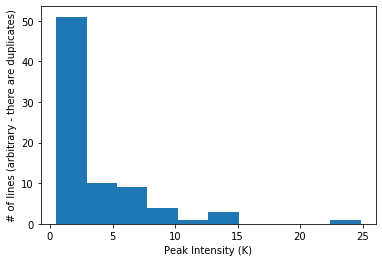

In [204]:
pl.hist(match_table[(match_table['Freq'] < 115) & (match_table['EU_K'] > 0)]['PeakIntensity'])
pl.xlabel("Peak Intensity (K)")
pl.ylabel("# of lines (arbitrary - there are duplicates)")

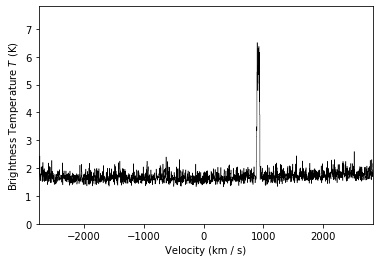

In [140]:
fn = 'spectra/BrickMaser_101_spw27.max.fits'
sp = pyspeckit.Spectrum(fn)

beams = Beams.from_fits_bintable(fits.open(fn)[1])
factors = jtok_factors(beams, sp.xarr.to(u.GHz))
sp.data = sp.data*factors
sp.unit = u.K
sp.xarr.convert_to_unit(u.km/u.s)

sp.plotter()

In [151]:
        fn = 'spectra/BrickMaser_87_spw25.max.fits'
        sp = pyspeckit.Spectrum(fn)
        
        # this is a bit hackier than I like
        # we'll do all our measurements in Kelvin!
        beams = Beams.from_fits_bintable(fits.open(fn)[1])
        factors = jtok_factors(beams, sp.xarr.to(u.GHz))
        sp.data = sp.data*factors
        sp.unit = u.K
        
        # want km/s - reference will be ~middle of SPW
        sp.xarr.convert_to_unit(u.km/u.s)

        med = np.nanmedian(sp.data)

        mad = stats.mad_std(sp.data - med)
        detections = (sp.data-med) > 5*mad

        labels, ct = label(detections)

        for labelid in range(1,ct+1):
            ssp = sp[labels == labelid]
            try:
                ssp.xarr.convert_to_unit(u.GHz)
                ssp.specfit()
                ssp.specfit.parinfo
                frq = ssp.specfit.parinfo['SHIFT0'].value * ssp.xarr.unit
            except Exception as ex:
                print(ex)
                frq = ssp.xarr.to(u.GHz).mean()
            sq = Splatalogue.query_lines(frq*(1+30/3e5), frq*(1+75/3e5),
                                         only_astronomically_observed=True)
            if len(sq) > 0:
                tbl = utils.minimize_table(sq)
                try:
                    total_intensity = ssp.data.sum() * np.abs(ssp.xarr.to(u.km/u.s).cdelt())
                except ValueError:
                    total_intensity = ssp.data.sum() * np.abs(sp.xarr.to(u.km/u.s).cdelt())
                peak_intensity = ssp.data.max()
                print(total_intensity,peak_intensity,mad, ssp.xarr.to(u.km/u.s).cdelt(), ssp.data.sum(), ssp.data.max())

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,3 [pyspeckit.spectrum.interactive]
90.05646083139669 km / s 11.020313677081177 0.35206817008966235 -3.3841231624911265 km / s 26.611460785340974 11.020313677081177
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2 [pyspeckit.spectrum.interactive]
ERROR: number of parameters must not exceed data
53.06194875870844 km / s 8.82152721711719 0.35206817008966235 -3.384123162491278 km / s 15.679674234919396 8.82152721711719
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,3 [pyspeckit.spectrum.interactive]
161.07717138290764 km / s 24.83307087238086 0.35206817008966235 -3.3841231624911643 km / s 47.597904582271006 24.83307087238086


(<Quantity 0.10353841 km / s>,
 0.019025360267963306,
 0.15896270406088828,
 <Quantity -2.91633762 km / s>,
 102.15442419523828,
 6.506194682606947)

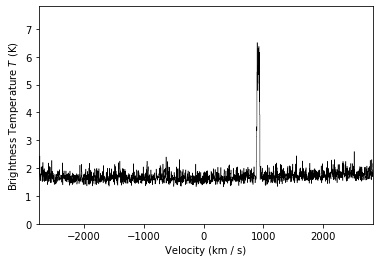

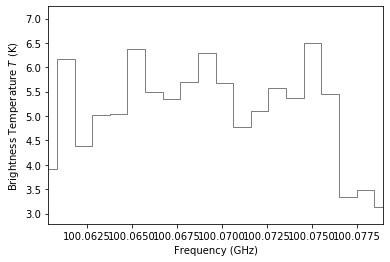

In [148]:
sp.plotter()
ssp.plotter()
total_intensity,peak_intensity,mad, ssp.xarr.to(u.km/u.s).cdelt(), ssp.data.sum(), ssp.data.max()

In [112]:
from radio_beam import Beams

In [110]:
from astropy.io import fits
fits.open(fn)

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2ac97fb06f28>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ac97f8d2470>]

In [116]:
beams = Beams.from_fits_bintable(fits.open(fn)[1])

In [120]:
sp.xarr.convert_to_unit(u.km/u.s)

In [122]:
sp.xarr


SpectroscopicAxis([2080.1929879975223,...,-2097.617634886356], unit=Unit("km / s"), refX=<Quantity 1.34515625e+11 Hz>, refX_unit=Unit("Hz"), frame=None, redshift=None, xtype=None, velocity convention='radio')

In [123]:
sp.xarr.cdelt()

<Quantity -1.08825492 km / s>

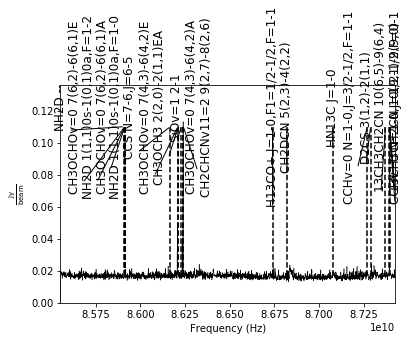

In [212]:
fn = 'spectra/BrickMaser_87_spw25.max.fits'
sp = pyspeckit.Spectrum(fn)
sp.plotter()#xmin=87.2e9, xmax=87.5e9)
sp.plotter.line_ids([f"{row['Species']} {row['QNs']}" for row in b3tb], b3tb['Freq'], xval_units='GHz', velocity_offset=50*u.km/u.s)

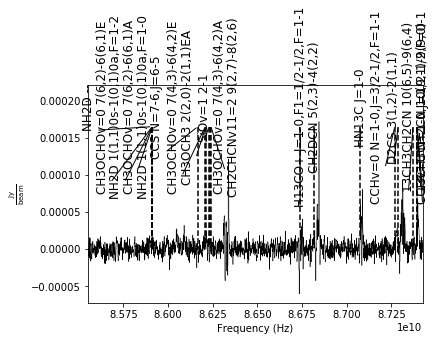

In [213]:
fn = 'spectra/BrickMaser_87_spw25.mean.fits'
sp = pyspeckit.Spectrum(fn)
sp.plotter()#xmin=87.2e9, xmax=87.5e9)
sp.plotter.line_ids([f"{row['Species']} {row['QNs']}" for row in b3tb], b3tb['Freq'], xval_units='GHz', velocity_offset=50*u.km/u.s)

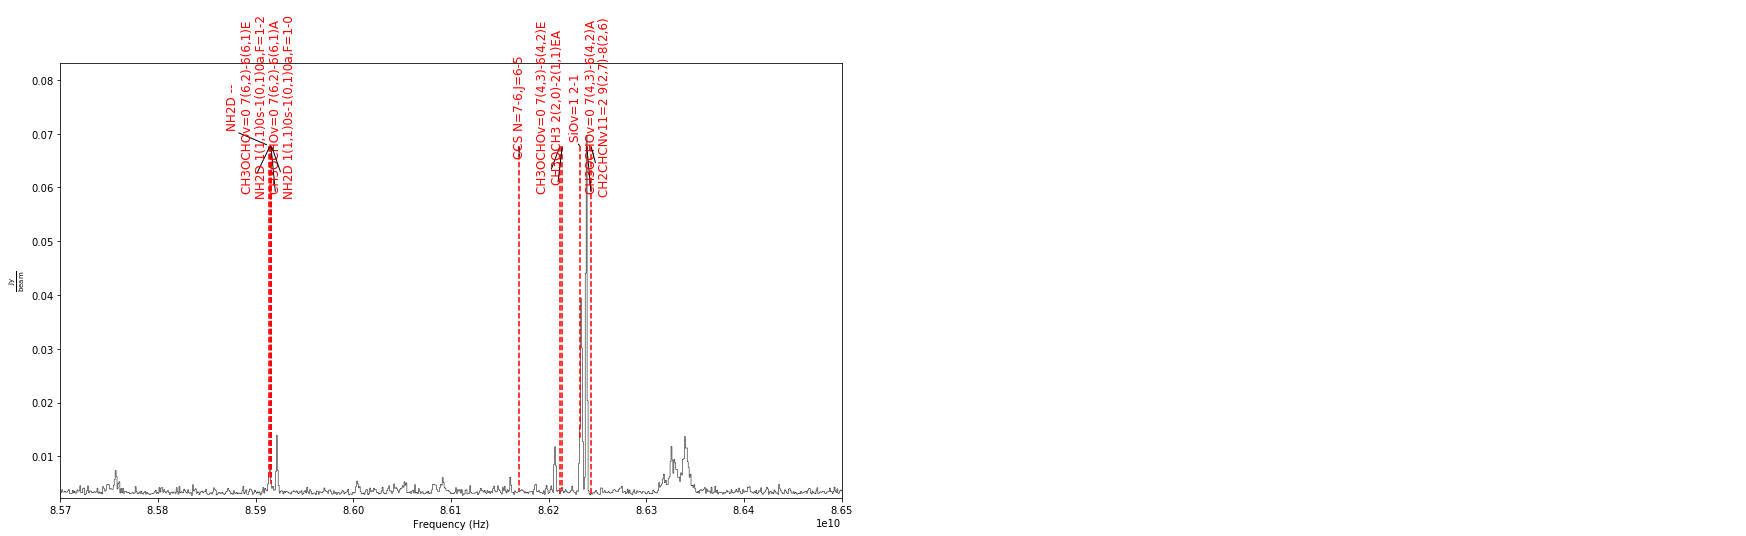

In [228]:
fn = 'spectra/source_ab_87_spw25_clean_2sigma_n50000_masked_3sigma_pbmask0p18.max.fits'
sp = pyspeckit.Spectrum(fn)
sp.plotter(figure=pl.figure(figsize=(14,8)), xmin=85.7e9, xmax=86.5e9)#xmin=87.2e9, xmax=87.5e9)
sp.plotter.line_ids([f"{row['Species']} {row['QNs']}" for row in b3tb], b3tb['Freq'], xval_units='GHz', velocity_offset=40*u.km/u.s, plot_kwargs={'color':'r'}, annotate_kwargs={'color':'r'})

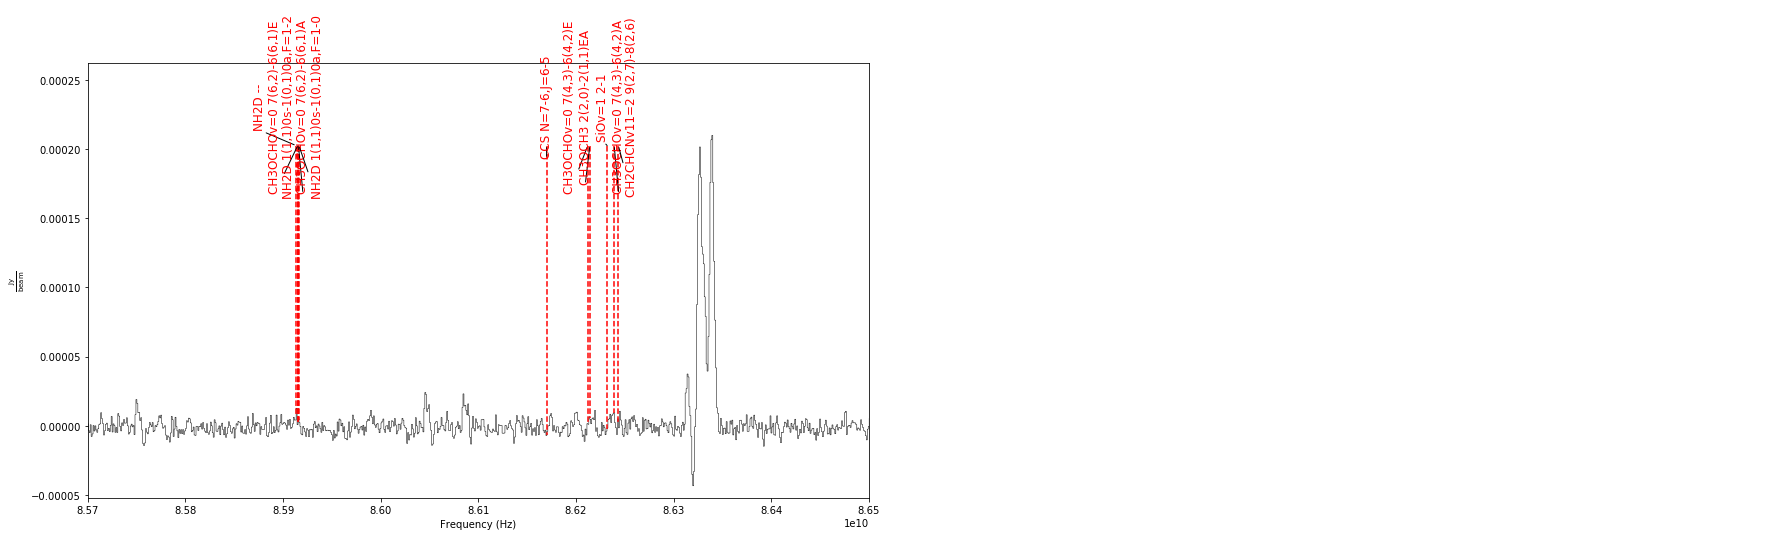

In [227]:
fn = 'spectra/source_ab_87_spw25_clean_2sigma_n50000_masked_3sigma_pbmask0p18.mean.fits'
sp = pyspeckit.Spectrum(fn)
sp.plotter(figure=pl.figure(figsize=(14,8)), xmin=85.7e9, xmax=86.5e9)#xmin=87.2e9, xmax=87.5e9)
sp.plotter.line_ids([f"{row['Species']} {row['QNs']}" for row in b3tb], b3tb['Freq'], xval_units='GHz', velocity_offset=40*u.km/u.s, plot_kwargs={'color':'r'}, annotate_kwargs={'color':'r'})

In [220]:
b3tb

Species,ChemicalName,QNs,Freq,log10_Aij,EU_K,TotalIntensity,PeakIntensity,RMS,Velocity
,,,,,,km / s,,,km / s
str22,str28,str38,float64,float64,float64,float64,float64,float64,float64
CH3OCHOv=0,Methyl Formate,"7(4,3)-6(4,2)A",86.250576,-5.20026,27.15102,161.07717138290764,24.83307087238086,0.35206817008966235,41.01537713434509
HC3Nv7=3,Cyanoacetylene,"J=12-11,l=3",110.211713,-4.01448,995.95346,564.1014254032181,13.176444988041082,0.19704394743497194,64.81469853066157
13COv=0,Carbon Monoxide,"J=1-0,F=1/2-1/2",110.2013218,-7.19838,5.2888,564.1014254032181,13.176444988041082,0.19704394743497194,36.55251586168315
HCNv=0,Hydrogen Cyanide,"J=1-0,F=1-1",88.630416,-5.09214,4.25356,404.5067693920142,12.849637710872813,0.3318273857065619,41.24709920815267
CH3OCHOv=0,Methyl Formate,"7(4,3)-6(4,2)E",86.223548,-5.20314,27.1713,90.05646083139669,11.020313677081177,0.35206817008966235,57.90098625095684
CSv=0,Carbon Monosulfide,2-1,97.980953,-4.77495,7.05327,45.31877938291147,8.937288242093603,0.33059837364852857,44.465775130626504
CH2CHCNv11=2,Vinyl Cyanide,"9(2,7)-8(2,6)",86.254848,-4.31024,716.79189,53.06194875870844,8.82152721711719,0.35206817008966235,73.7993769587843
HOC+v=0,Hydroxymethylidyne,1-0,89.487414,-4.67064,4.29469,121.09883289716666,8.159571292046742,0.3318273857065619,38.06076400837078


In [210]:
b3tb = match_table[(match_table['Freq'] < 115) & (match_table['EU_K'] > 0)]
b3tb.sort('PeakIntensity', reverse=True)
b3tb

Species,ChemicalName,QNs,Freq,log10_Aij,EU_K,TotalIntensity,PeakIntensity,RMS,Velocity
,,,,,,km / s,,,km / s
str22,str28,str38,float64,float64,float64,float64,float64,float64,float64
CH3OCHOv=0,Methyl Formate,"7(4,3)-6(4,2)A",86.250576,-5.20026,27.15102,161.07717138290764,24.83307087238086,0.35206817008966235,41.01537713434509
HC3Nv7=3,Cyanoacetylene,"J=12-11,l=3",110.211713,-4.01448,995.95346,564.1014254032181,13.176444988041082,0.19704394743497194,64.81469853066157
13COv=0,Carbon Monoxide,"J=1-0,F=1/2-1/2",110.2013218,-7.19838,5.2888,564.1014254032181,13.176444988041082,0.19704394743497194,36.55251586168315
HCNv=0,Hydrogen Cyanide,"J=1-0,F=1-1",88.630416,-5.09214,4.25356,404.5067693920142,12.849637710872813,0.3318273857065619,41.24709920815267
CH3OCHOv=0,Methyl Formate,"7(4,3)-6(4,2)E",86.223548,-5.20314,27.1713,90.05646083139669,11.020313677081177,0.35206817008966235,57.90098625095684
CSv=0,Carbon Monosulfide,2-1,97.980953,-4.77495,7.05327,45.31877938291147,8.937288242093603,0.33059837364852857,44.465775130626504
CH2CHCNv11=2,Vinyl Cyanide,"9(2,7)-8(2,6)",86.254848,-4.31024,716.79189,53.06194875870844,8.82152721711719,0.35206817008966235,73.7993769587843
HOC+v=0,Hydroxymethylidyne,1-0,89.487414,-4.67064,4.29469,121.09883289716666,8.159571292046742,0.3318273857065619,38.06076400837078


divide by zero encountered in long_scalars


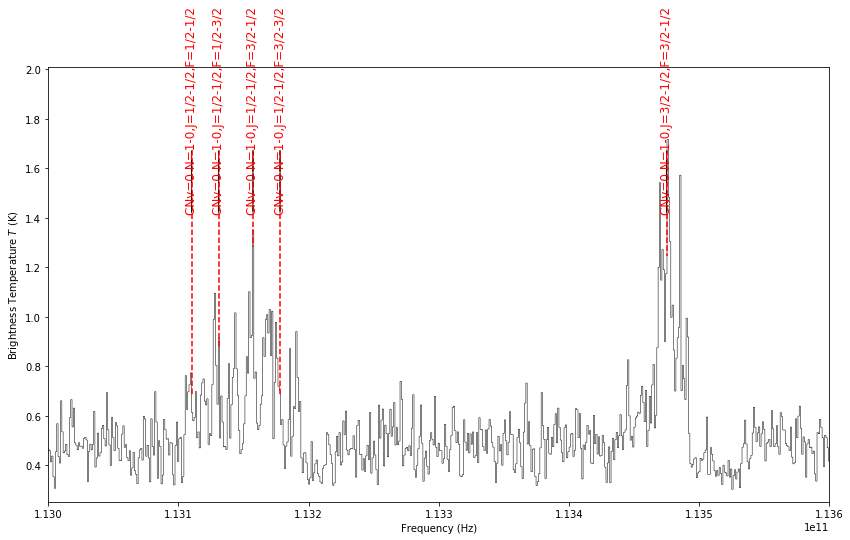

In [236]:
fn = 'spectra/source_ab_112_spw27_clean_2sigma_n50000_masked_3sigma_pbmask0p18.max.fits'
cube = SpectralCube.read('source_ab_112_spw27_clean_2sigma_n50000_masked_3sigma_pbmask0p18.image')
jtok = cube.beams[1920//2].jtok(cube.spectral_axis[1920//2])
sp = pyspeckit.Spectrum(fn)
sp.data = sp.data * jtok.value
sp.unit = 'K'
sp.plotter(figure=pl.figure(figsize=(14,8)), xmin=113e9, xmax=113.6e9)#xmin=87.2e9, xmax=87.5e9)
sp.plotter.line_ids([f"{row['Species']} {row['QNs']}" for row in b3tb], b3tb['Freq'], xval_units='GHz', velocity_offset=35*u.km/u.s, plot_kwargs={'color':'r'}, annotate_kwargs={'color':'r'})

In [238]:
cube.beams[960]

Beam: BMAJ=1.4173699617385864 arcsec BMIN=0.9778373837471008 arcsec BPA=-82.01464080810547 deg

In [ ]:
fn = 'spectra/source_ab_112_spw27_clean_2sigma_n50000_masked_3sigma_pbmask0p18.max.fits'
sp = pyspeckit.Spectrum(fn)
sp.plotter(figure=pl.figure(figsize=(14,8)), )#xmin=85.7e9, xmax=86.5e9)#xmin=87.2e9, xmax=87.5e9)
sp.plotter.line_ids([f"{row['Species']} {row['QNs']}" for row in b3tb], b3tb['Freq'], xval_units='GHz', velocity_offset=40*u.km/u.s, plot_kwargs={'color':'r'}, annotate_kwargs={'color':'r'})